In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

# Login

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Setup and Training Paramters

## Parameters

In [0]:
# Size of image
image_size = 28

# no of channels
nc = 1

# size of latent space
nz = 128

# no of GPUs
ngpu = 1

# No of filters in the generator and discriminator 
ngf = 64
ndf = 64

# Batch Size
batch_size = 64

# Number of workers
num_workers = 0 # Default in Pytorch

# Enable CUDA if True
cuda = True

# Set Random Seed (set to None if not required)
manual_seed = None

# Learning Rate
lr = 0.0002 # As suggested in the DCGAN paper

# No of epochs
niter = 200

## Load Dataset

In [3]:
# Load MNIST
# Transforms are required to normalize MNIST images
dataset = dset.MNIST(root='../../data/', download=True,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

# Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(num_workers))

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Enable CUDA

In [0]:
device = torch.device("cuda:0" if cuda else "cpu")
if cuda:
  cudnn.benchmark = True

## Set Random Seed

In [5]:
if manual_seed is None:
    manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  3745


## Architectures

### Generator

In [6]:
# Following the DCGAN paper guidelines
# No Leaky ReLus in generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

## Custom Weight Initialization

In [0]:
# custom weights initialization called on netG and netD
# It is mentioned in Section 4 page 3 to initialize weight with a normal distribution with stdev 0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

netG = Generator(ngpu).to(device)
#netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
#netD.apply(weights_init)

## Training Parameters

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.9, 0.999))

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

D_save_loc = 'gdrive/My Drive/GAN-Test/DCGAN+MNIST/D_200.ckpt'
G_save_loc = 'gdrive/My Drive/GAN-Test/DCGAN+MNIST/G_200.ckpt'

# Load Pretrained Models (Optional)

In [10]:
# Load D and G
netD.load_state_dict(torch.load('gdrive/My Drive/GAN-Test/DCGAN+MNIST/D_200.ckpt'))
netG.load_state_dict(torch.load('gdrive/My Drive/GAN-Test/DCGAN+MNIST/G_200.ckpt'))

FileNotFoundError: ignored

# Training

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/200][0/938] Loss_D: 1.5102 Loss_G: 1.1225 D(x): 0.5603 D(G(z)): 0.5967 / 0.3323
[0/200][100/938] Loss_D: 0.0256 Loss_G: 4.8808 D(x): 0.9977 D(G(z)): 0.0230 / 0.0078
[0/200][200/938] Loss_D: 0.0067 Loss_G: 6.3379 D(x): 0.9970 D(G(z)): 0.0037 / 0.0018
[0/200][300/938] Loss_D: 0.0034 Loss_G: 7.4329 D(x): 0.9983 D(G(z)): 0.0017 / 0.0008
[0/200][400/938] Loss_D: 0.0087 Loss_G: 8.0421 D(x): 0.9958 D(G(z)): 0.0044 / 0.0004
[0/200][500/938] Loss_D: 0.0024 Loss_G: 7.5057 D(x): 0.9987 D(G(z)): 0.0011 / 0.0006
[0/200][600/938] Loss_D: 0.0006 Loss_G: 9.9477 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[0/200][700/938] Loss_D: 0.0033 Loss_G: 7.7866 D(x): 0.9976 D(G(z)): 0.0009 / 0.0007
[0/200][800/938] Loss_D: 0.0092 Loss_G: 9.3275 D(x): 0.9979 D(G(z)): 0.0067 / 0.0008
[0/200][900/938] Loss_D: 0.1350 Loss_G: 7.1328 D(x): 0.9332 D(G(z)): 0.0204 / 0.0241


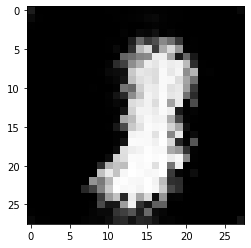

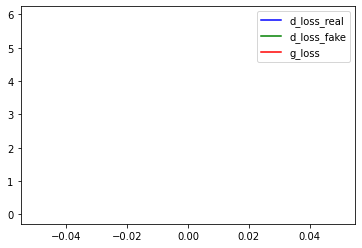

[1/200][0/938] Loss_D: 0.0251 Loss_G: 5.5012 D(x): 0.9847 D(G(z)): 0.0090 / 0.0084
[1/200][100/938] Loss_D: 0.0204 Loss_G: 5.0561 D(x): 0.9986 D(G(z)): 0.0185 / 0.0104
[1/200][200/938] Loss_D: 0.2211 Loss_G: 7.3661 D(x): 0.8578 D(G(z)): 0.0020 / 0.0045
[1/200][300/938] Loss_D: 0.0927 Loss_G: 6.1126 D(x): 0.9943 D(G(z)): 0.0731 / 0.0062
[1/200][400/938] Loss_D: 0.0093 Loss_G: 7.1201 D(x): 0.9987 D(G(z)): 0.0078 / 0.0026
[1/200][500/938] Loss_D: 0.1814 Loss_G: 6.7387 D(x): 0.9999 D(G(z)): 0.0935 / 0.0185
[1/200][600/938] Loss_D: 0.0854 Loss_G: 6.1865 D(x): 0.9574 D(G(z)): 0.0221 / 0.0132
[1/200][700/938] Loss_D: 0.0412 Loss_G: 6.0506 D(x): 0.9791 D(G(z)): 0.0179 / 0.0086
[1/200][800/938] Loss_D: 0.0754 Loss_G: 5.2115 D(x): 0.9656 D(G(z)): 0.0269 / 0.0186
[1/200][900/938] Loss_D: 0.0926 Loss_G: 5.8553 D(x): 0.9820 D(G(z)): 0.0589 / 0.0129


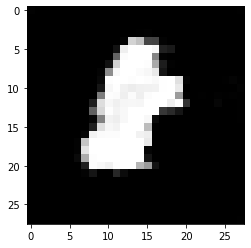

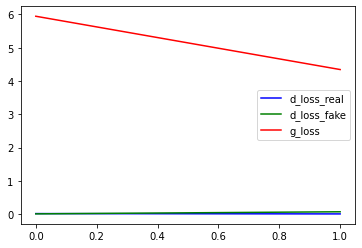

[2/200][0/938] Loss_D: 0.2256 Loss_G: 4.8285 D(x): 0.9580 D(G(z)): 0.0945 / 0.0495
[2/200][100/938] Loss_D: 0.1833 Loss_G: 6.2118 D(x): 0.8765 D(G(z)): 0.0084 / 0.0050
[2/200][200/938] Loss_D: 0.1064 Loss_G: 5.0897 D(x): 0.9481 D(G(z)): 0.0393 / 0.0242
[2/200][300/938] Loss_D: 0.0688 Loss_G: 4.9139 D(x): 0.9738 D(G(z)): 0.0340 / 0.0254
[2/200][400/938] Loss_D: 0.1411 Loss_G: 5.5300 D(x): 0.9318 D(G(z)): 0.0430 / 0.0217
[2/200][500/938] Loss_D: 0.1290 Loss_G: 4.6315 D(x): 0.9329 D(G(z)): 0.0480 / 0.0368
[2/200][600/938] Loss_D: 0.1700 Loss_G: 4.5500 D(x): 0.9482 D(G(z)): 0.0770 / 0.0343
[2/200][700/938] Loss_D: 0.1298 Loss_G: 3.6062 D(x): 0.9371 D(G(z)): 0.0486 / 0.0574
[2/200][800/938] Loss_D: 0.2035 Loss_G: 3.2989 D(x): 0.9893 D(G(z)): 0.1594 / 0.0776
[2/200][900/938] Loss_D: 0.3351 Loss_G: 3.6319 D(x): 0.8325 D(G(z)): 0.0864 / 0.0837


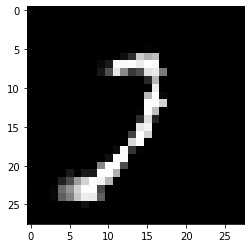

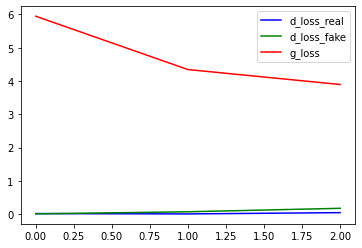

[3/200][0/938] Loss_D: 0.2618 Loss_G: 3.7272 D(x): 0.9793 D(G(z)): 0.1796 / 0.0724
[3/200][100/938] Loss_D: 0.2843 Loss_G: 2.5894 D(x): 0.9447 D(G(z)): 0.1647 / 0.1592
[3/200][200/938] Loss_D: 0.5406 Loss_G: 2.9367 D(x): 0.6654 D(G(z)): 0.0307 / 0.0855
[3/200][300/938] Loss_D: 0.1046 Loss_G: 4.6193 D(x): 0.9300 D(G(z)): 0.0245 / 0.0301
[3/200][400/938] Loss_D: 0.3306 Loss_G: 1.8785 D(x): 0.9246 D(G(z)): 0.1752 / 0.2401
[3/200][500/938] Loss_D: 0.1125 Loss_G: 4.7164 D(x): 0.9494 D(G(z)): 0.0501 / 0.0310
[3/200][600/938] Loss_D: 0.3482 Loss_G: 3.0616 D(x): 0.9047 D(G(z)): 0.1806 / 0.1087
[3/200][700/938] Loss_D: 0.3361 Loss_G: 4.7121 D(x): 0.8069 D(G(z)): 0.0278 / 0.0385
[3/200][800/938] Loss_D: 0.2450 Loss_G: 3.9408 D(x): 0.8623 D(G(z)): 0.0722 / 0.0441
[3/200][900/938] Loss_D: 0.4441 Loss_G: 2.9561 D(x): 0.9260 D(G(z)): 0.2204 / 0.1169


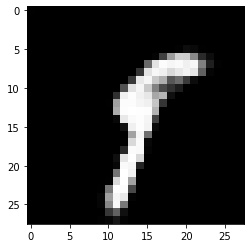

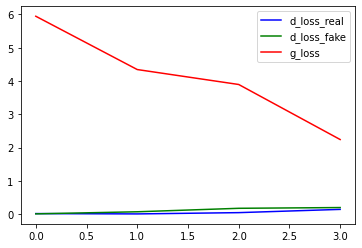

[4/200][0/938] Loss_D: 0.2013 Loss_G: 3.0303 D(x): 0.9657 D(G(z)): 0.1351 / 0.0956
[4/200][100/938] Loss_D: 0.5461 Loss_G: 3.8295 D(x): 0.6463 D(G(z)): 0.0410 / 0.0468
[4/200][200/938] Loss_D: 0.0837 Loss_G: 4.9698 D(x): 0.9452 D(G(z)): 0.0245 / 0.0156
[4/200][300/938] Loss_D: 0.2230 Loss_G: 3.0876 D(x): 0.9541 D(G(z)): 0.1330 / 0.0916
[4/200][400/938] Loss_D: 0.1037 Loss_G: 4.1598 D(x): 0.9406 D(G(z)): 0.0351 / 0.0321
[4/200][500/938] Loss_D: 0.4808 Loss_G: 3.1693 D(x): 0.7421 D(G(z)): 0.0252 / 0.0912
[4/200][600/938] Loss_D: 0.1758 Loss_G: 3.6323 D(x): 0.9384 D(G(z)): 0.0893 / 0.0643
[4/200][700/938] Loss_D: 0.1668 Loss_G: 2.8182 D(x): 0.9606 D(G(z)): 0.1034 / 0.1041
[4/200][800/938] Loss_D: 0.1923 Loss_G: 4.1202 D(x): 0.8698 D(G(z)): 0.0382 / 0.0360
[4/200][900/938] Loss_D: 0.1395 Loss_G: 3.3860 D(x): 0.9185 D(G(z)): 0.0430 / 0.0690


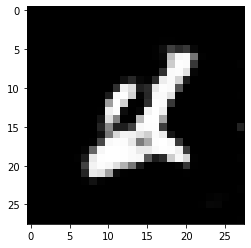

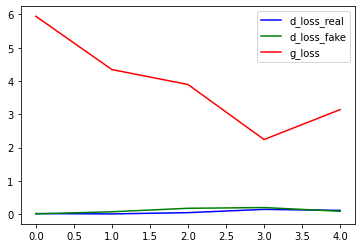

[5/200][0/938] Loss_D: 0.2029 Loss_G: 3.0991 D(x): 0.9781 D(G(z)): 0.1476 / 0.0826
[5/200][100/938] Loss_D: 0.2820 Loss_G: 3.8954 D(x): 0.8155 D(G(z)): 0.0306 / 0.0379
[5/200][200/938] Loss_D: 0.4466 Loss_G: 5.0967 D(x): 0.9767 D(G(z)): 0.2813 / 0.0162
[5/200][300/938] Loss_D: 0.1648 Loss_G: 2.4290 D(x): 0.9638 D(G(z)): 0.1026 / 0.1540
[5/200][400/938] Loss_D: 0.2563 Loss_G: 3.4311 D(x): 0.9725 D(G(z)): 0.1645 / 0.0753
[5/200][500/938] Loss_D: 0.2147 Loss_G: 3.7728 D(x): 0.9238 D(G(z)): 0.0906 / 0.0616
[5/200][600/938] Loss_D: 0.1429 Loss_G: 3.3085 D(x): 0.9497 D(G(z)): 0.0653 / 0.0755
[5/200][700/938] Loss_D: 0.2349 Loss_G: 3.4124 D(x): 0.9082 D(G(z)): 0.1095 / 0.0620
[5/200][800/938] Loss_D: 0.1748 Loss_G: 3.1380 D(x): 0.9436 D(G(z)): 0.0965 / 0.0884
[5/200][900/938] Loss_D: 0.1099 Loss_G: 5.5810 D(x): 0.9316 D(G(z)): 0.0301 / 0.0126


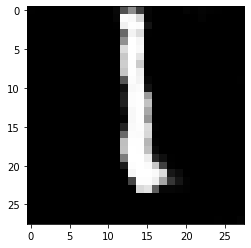

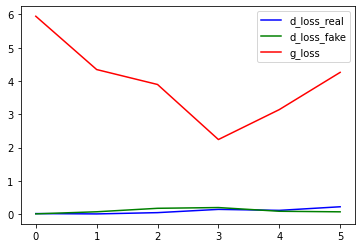

[6/200][0/938] Loss_D: 0.7321 Loss_G: 2.8941 D(x): 0.6124 D(G(z)): 0.0480 / 0.1224
[6/200][100/938] Loss_D: 0.2492 Loss_G: 3.1303 D(x): 0.8450 D(G(z)): 0.0311 / 0.0868
[6/200][200/938] Loss_D: 0.2259 Loss_G: 4.1217 D(x): 0.8692 D(G(z)): 0.0567 / 0.0376
[6/200][300/938] Loss_D: 0.4420 Loss_G: 4.9097 D(x): 0.7461 D(G(z)): 0.0282 / 0.0199
[6/200][400/938] Loss_D: 0.3359 Loss_G: 2.8832 D(x): 0.9808 D(G(z)): 0.2270 / 0.1107
[6/200][500/938] Loss_D: 0.1880 Loss_G: 2.6856 D(x): 0.9420 D(G(z)): 0.0978 / 0.1172
[6/200][600/938] Loss_D: 0.0811 Loss_G: 4.6886 D(x): 0.9465 D(G(z)): 0.0197 / 0.0213
[6/200][700/938] Loss_D: 0.2296 Loss_G: 4.3640 D(x): 0.8417 D(G(z)): 0.0175 / 0.0331
[6/200][800/938] Loss_D: 0.3043 Loss_G: 2.2172 D(x): 0.9518 D(G(z)): 0.1968 / 0.1706
[6/200][900/938] Loss_D: 0.3451 Loss_G: 2.6107 D(x): 0.8329 D(G(z)): 0.0977 / 0.1205


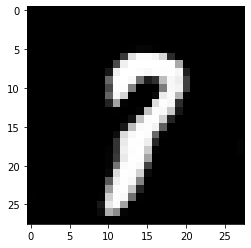

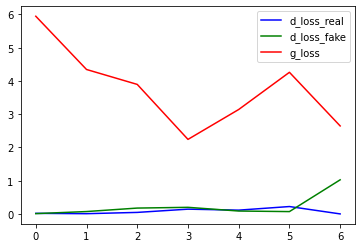

[7/200][0/938] Loss_D: 0.2413 Loss_G: 4.7951 D(x): 0.9074 D(G(z)): 0.1053 / 0.0189
[7/200][100/938] Loss_D: 0.0998 Loss_G: 5.0515 D(x): 0.9516 D(G(z)): 0.0407 / 0.0172
[7/200][200/938] Loss_D: 0.1356 Loss_G: 3.4791 D(x): 0.9642 D(G(z)): 0.0831 / 0.0614
[7/200][300/938] Loss_D: 0.4029 Loss_G: 1.9316 D(x): 0.9877 D(G(z)): 0.2513 / 0.2289
[7/200][400/938] Loss_D: 0.2994 Loss_G: 3.1628 D(x): 0.9129 D(G(z)): 0.1459 / 0.0978
[7/200][500/938] Loss_D: 0.3608 Loss_G: 2.7897 D(x): 0.8015 D(G(z)): 0.0874 / 0.1253
[7/200][600/938] Loss_D: 0.2730 Loss_G: 4.3521 D(x): 0.9713 D(G(z)): 0.1967 / 0.0204
[7/200][700/938] Loss_D: 0.4054 Loss_G: 3.2986 D(x): 0.7587 D(G(z)): 0.0560 / 0.0737
[7/200][800/938] Loss_D: 0.2029 Loss_G: 4.1998 D(x): 0.8727 D(G(z)): 0.0355 / 0.0361
[7/200][900/938] Loss_D: 0.1890 Loss_G: 5.9746 D(x): 0.8610 D(G(z)): 0.0115 / 0.0054


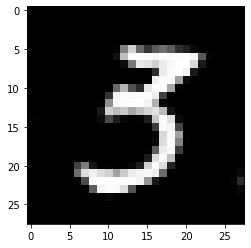

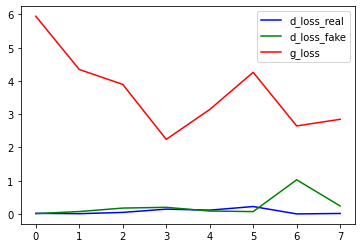

[8/200][0/938] Loss_D: 0.3343 Loss_G: 2.9983 D(x): 0.9203 D(G(z)): 0.1856 / 0.1024
[8/200][100/938] Loss_D: 0.1667 Loss_G: 4.0226 D(x): 0.8944 D(G(z)): 0.0391 / 0.0349
[8/200][200/938] Loss_D: 0.1248 Loss_G: 4.0072 D(x): 0.9748 D(G(z)): 0.0857 / 0.0424
[8/200][300/938] Loss_D: 0.3000 Loss_G: 3.9441 D(x): 0.8868 D(G(z)): 0.1217 / 0.0561
[8/200][400/938] Loss_D: 0.2058 Loss_G: 2.5749 D(x): 0.8693 D(G(z)): 0.0472 / 0.1438
[8/200][500/938] Loss_D: 0.1778 Loss_G: 4.8450 D(x): 0.8688 D(G(z)): 0.0208 / 0.0155
[8/200][600/938] Loss_D: 0.4136 Loss_G: 2.6026 D(x): 0.7598 D(G(z)): 0.0405 / 0.1453
[8/200][700/938] Loss_D: 0.1415 Loss_G: 3.2830 D(x): 0.9104 D(G(z)): 0.0347 / 0.0722
[8/200][800/938] Loss_D: 0.1627 Loss_G: 5.1361 D(x): 0.8890 D(G(z)): 0.0348 / 0.0168
[8/200][900/938] Loss_D: 0.1941 Loss_G: 5.0964 D(x): 0.8597 D(G(z)): 0.0296 / 0.0126


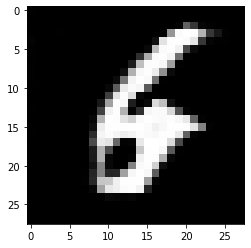

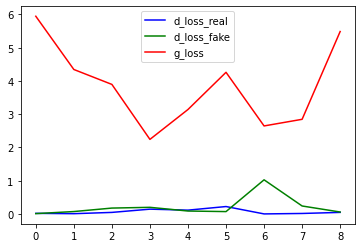

[9/200][0/938] Loss_D: 0.5933 Loss_G: 4.8778 D(x): 0.6203 D(G(z)): 0.0148 / 0.0228
[9/200][100/938] Loss_D: 0.1949 Loss_G: 2.9051 D(x): 0.9600 D(G(z)): 0.1235 / 0.1095
[9/200][200/938] Loss_D: 0.1951 Loss_G: 4.4287 D(x): 0.8803 D(G(z)): 0.0395 / 0.0370
[9/200][300/938] Loss_D: 0.2270 Loss_G: 2.7340 D(x): 0.9674 D(G(z)): 0.1546 / 0.1191
[9/200][400/938] Loss_D: 0.2214 Loss_G: 3.0429 D(x): 0.9447 D(G(z)): 0.1260 / 0.0872
[9/200][500/938] Loss_D: 0.2561 Loss_G: 4.7906 D(x): 0.8009 D(G(z)): 0.0071 / 0.0159
[9/200][600/938] Loss_D: 0.1317 Loss_G: 5.3009 D(x): 0.9186 D(G(z)): 0.0367 / 0.0173
[9/200][700/938] Loss_D: 0.1352 Loss_G: 4.9237 D(x): 0.9157 D(G(z)): 0.0293 / 0.0194
[9/200][800/938] Loss_D: 0.2824 Loss_G: 2.3080 D(x): 0.9064 D(G(z)): 0.1494 / 0.1672
[9/200][900/938] Loss_D: 0.2284 Loss_G: 3.3042 D(x): 0.8834 D(G(z)): 0.0749 / 0.0746


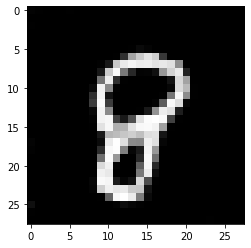

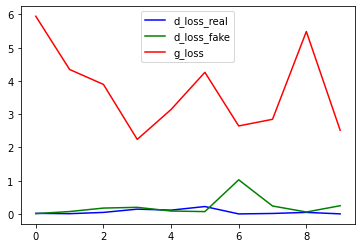

[10/200][0/938] Loss_D: 0.4472 Loss_G: 2.6642 D(x): 0.9866 D(G(z)): 0.2939 / 0.1252
[10/200][100/938] Loss_D: 0.2951 Loss_G: 2.4907 D(x): 0.9436 D(G(z)): 0.1780 / 0.1446
[10/200][200/938] Loss_D: 0.6366 Loss_G: 3.5192 D(x): 0.9473 D(G(z)): 0.3582 / 0.0659
[10/200][300/938] Loss_D: 0.2320 Loss_G: 2.4374 D(x): 0.9519 D(G(z)): 0.1347 / 0.1713
[10/200][400/938] Loss_D: 0.1022 Loss_G: 4.3150 D(x): 0.9440 D(G(z)): 0.0372 / 0.0392
[10/200][500/938] Loss_D: 0.3897 Loss_G: 1.7005 D(x): 0.9325 D(G(z)): 0.2151 / 0.2950
[10/200][600/938] Loss_D: 0.2297 Loss_G: 3.2809 D(x): 0.8902 D(G(z)): 0.0828 / 0.0742
[10/200][700/938] Loss_D: 0.2909 Loss_G: 4.1025 D(x): 0.9207 D(G(z)): 0.1402 / 0.0542
[10/200][800/938] Loss_D: 0.1481 Loss_G: 4.4911 D(x): 0.8888 D(G(z)): 0.0206 / 0.0220
[10/200][900/938] Loss_D: 0.1952 Loss_G: 3.5639 D(x): 0.9020 D(G(z)): 0.0734 / 0.0666


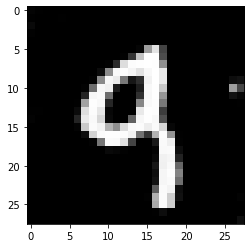

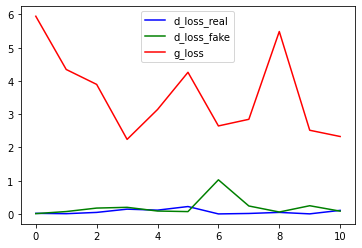

[11/200][0/938] Loss_D: 0.4344 Loss_G: 1.9677 D(x): 0.9816 D(G(z)): 0.2673 / 0.2239
[11/200][100/938] Loss_D: 0.1415 Loss_G: 4.3729 D(x): 0.9287 D(G(z)): 0.0539 / 0.0378
[11/200][200/938] Loss_D: 0.2444 Loss_G: 2.8485 D(x): 0.8709 D(G(z)): 0.0777 / 0.1508
[11/200][300/938] Loss_D: 0.3302 Loss_G: 4.4515 D(x): 0.7730 D(G(z)): 0.0144 / 0.0255
[11/200][400/938] Loss_D: 0.2663 Loss_G: 4.3975 D(x): 0.8252 D(G(z)): 0.0356 / 0.0270
[11/200][500/938] Loss_D: 0.5148 Loss_G: 3.2651 D(x): 0.6652 D(G(z)): 0.0149 / 0.0895
[11/200][600/938] Loss_D: 0.2112 Loss_G: 3.4298 D(x): 0.9868 D(G(z)): 0.1598 / 0.0649
[11/200][700/938] Loss_D: 0.1783 Loss_G: 4.8716 D(x): 0.8801 D(G(z)): 0.0231 / 0.0155
[11/200][800/938] Loss_D: 0.1633 Loss_G: 5.0805 D(x): 0.8910 D(G(z)): 0.0338 / 0.0167
[11/200][900/938] Loss_D: 0.2603 Loss_G: 3.4223 D(x): 0.8347 D(G(z)): 0.0422 / 0.0661


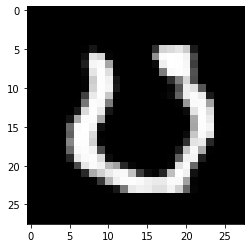

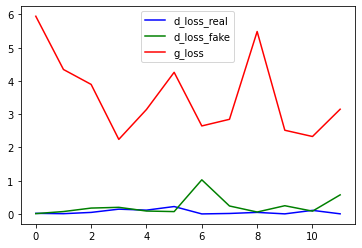

[12/200][0/938] Loss_D: 0.3056 Loss_G: 4.3374 D(x): 0.9788 D(G(z)): 0.2006 / 0.0377
[12/200][100/938] Loss_D: 0.1384 Loss_G: 4.2837 D(x): 0.9234 D(G(z)): 0.0446 / 0.0325
[12/200][200/938] Loss_D: 0.3649 Loss_G: 2.7068 D(x): 0.8439 D(G(z)): 0.1385 / 0.1484
[12/200][300/938] Loss_D: 0.5282 Loss_G: 3.1972 D(x): 0.9751 D(G(z)): 0.3132 / 0.0889
[12/200][400/938] Loss_D: 0.1451 Loss_G: 4.0400 D(x): 0.9627 D(G(z)): 0.0843 / 0.0354
[12/200][500/938] Loss_D: 0.5287 Loss_G: 3.7035 D(x): 0.6781 D(G(z)): 0.0304 / 0.0575
[12/200][600/938] Loss_D: 0.3396 Loss_G: 5.2290 D(x): 0.7552 D(G(z)): 0.0063 / 0.0124
[12/200][700/938] Loss_D: 0.1610 Loss_G: 2.7073 D(x): 0.9939 D(G(z)): 0.1306 / 0.1201
[12/200][800/938] Loss_D: 0.3570 Loss_G: 1.7565 D(x): 0.9410 D(G(z)): 0.2155 / 0.2809
[12/200][900/938] Loss_D: 0.1377 Loss_G: 4.5188 D(x): 0.9489 D(G(z)): 0.0737 / 0.0257


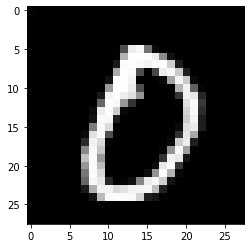

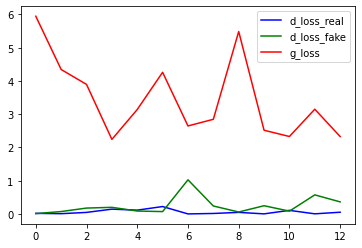

[13/200][0/938] Loss_D: 0.1482 Loss_G: 5.9760 D(x): 0.8886 D(G(z)): 0.0072 / 0.0062
[13/200][100/938] Loss_D: 0.1481 Loss_G: 3.8338 D(x): 0.8904 D(G(z)): 0.0220 / 0.0421
[13/200][200/938] Loss_D: 0.2958 Loss_G: 3.5082 D(x): 0.8072 D(G(z)): 0.0419 / 0.0607
[13/200][300/938] Loss_D: 0.0797 Loss_G: 4.1984 D(x): 0.9676 D(G(z)): 0.0416 / 0.0437
[13/200][400/938] Loss_D: 0.2674 Loss_G: 5.0284 D(x): 0.8224 D(G(z)): 0.0382 / 0.0169
[13/200][500/938] Loss_D: 0.4795 Loss_G: 6.3227 D(x): 0.7079 D(G(z)): 0.0078 / 0.0060
[13/200][600/938] Loss_D: 0.4571 Loss_G: 5.0126 D(x): 0.7033 D(G(z)): 0.0105 / 0.0140
[13/200][700/938] Loss_D: 0.2341 Loss_G: 3.5536 D(x): 0.9457 D(G(z)): 0.1365 / 0.0681
[13/200][800/938] Loss_D: 0.2452 Loss_G: 5.2023 D(x): 0.8208 D(G(z)): 0.0188 / 0.0211
[13/200][900/938] Loss_D: 0.3406 Loss_G: 3.8921 D(x): 0.9538 D(G(z)): 0.1861 / 0.0607


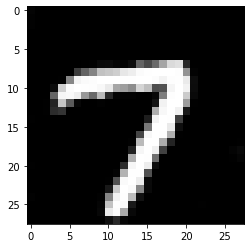

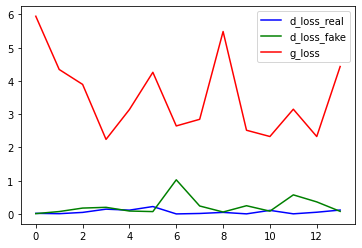

[14/200][0/938] Loss_D: 0.2299 Loss_G: 5.2543 D(x): 0.8328 D(G(z)): 0.0141 / 0.0103
[14/200][100/938] Loss_D: 0.4017 Loss_G: 2.5692 D(x): 0.9126 D(G(z)): 0.2114 / 0.1525
[14/200][200/938] Loss_D: 0.4218 Loss_G: 3.4309 D(x): 0.7300 D(G(z)): 0.0555 / 0.0658
[14/200][300/938] Loss_D: 0.1771 Loss_G: 3.9671 D(x): 0.8690 D(G(z)): 0.0245 / 0.0553
[14/200][400/938] Loss_D: 0.3178 Loss_G: 2.8903 D(x): 0.9426 D(G(z)): 0.1968 / 0.0946
[14/200][500/938] Loss_D: 0.2164 Loss_G: 2.7505 D(x): 0.8935 D(G(z)): 0.0800 / 0.1308
[14/200][600/938] Loss_D: 0.3715 Loss_G: 4.1781 D(x): 0.7721 D(G(z)): 0.0272 / 0.0317
[14/200][700/938] Loss_D: 0.3291 Loss_G: 5.2824 D(x): 0.7762 D(G(z)): 0.0110 / 0.0130
[14/200][800/938] Loss_D: 0.1516 Loss_G: 2.3195 D(x): 0.9820 D(G(z)): 0.1048 / 0.1765
[14/200][900/938] Loss_D: 0.2051 Loss_G: 2.5337 D(x): 0.9703 D(G(z)): 0.1344 / 0.1468


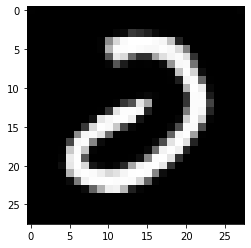

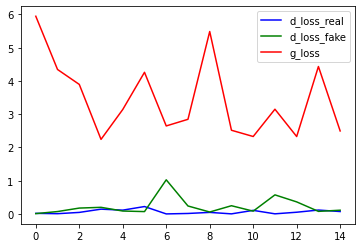

[15/200][0/938] Loss_D: 0.1991 Loss_G: 2.4349 D(x): 0.9694 D(G(z)): 0.1382 / 0.1425
[15/200][100/938] Loss_D: 0.3318 Loss_G: 1.7263 D(x): 0.8939 D(G(z)): 0.1644 / 0.2690
[15/200][200/938] Loss_D: 0.1170 Loss_G: 3.6504 D(x): 0.9390 D(G(z)): 0.0453 / 0.0585
[15/200][300/938] Loss_D: 0.8741 Loss_G: 1.3683 D(x): 0.9731 D(G(z)): 0.4931 / 0.3414
[15/200][400/938] Loss_D: 0.1408 Loss_G: 4.4750 D(x): 0.9548 D(G(z)): 0.0801 / 0.0348
[15/200][500/938] Loss_D: 0.1610 Loss_G: 2.5530 D(x): 0.9888 D(G(z)): 0.1177 / 0.1460
[15/200][600/938] Loss_D: 0.2473 Loss_G: 2.7415 D(x): 0.9236 D(G(z)): 0.1269 / 0.1114
[15/200][700/938] Loss_D: 0.2741 Loss_G: 2.1893 D(x): 0.9516 D(G(z)): 0.1636 / 0.1990
[15/200][800/938] Loss_D: 0.0727 Loss_G: 5.3755 D(x): 0.9480 D(G(z)): 0.0125 / 0.0133
[15/200][900/938] Loss_D: 0.4546 Loss_G: 3.0570 D(x): 0.9645 D(G(z)): 0.2671 / 0.1133


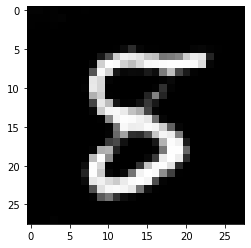

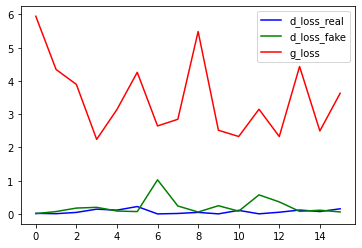

[16/200][0/938] Loss_D: 0.3077 Loss_G: 2.5974 D(x): 0.8962 D(G(z)): 0.1469 / 0.1317
[16/200][100/938] Loss_D: 0.4952 Loss_G: 5.3784 D(x): 0.6563 D(G(z)): 0.0073 / 0.0224
[16/200][200/938] Loss_D: 0.2018 Loss_G: 2.7348 D(x): 0.9052 D(G(z)): 0.0803 / 0.1285
[16/200][300/938] Loss_D: 0.1506 Loss_G: 3.9564 D(x): 0.9301 D(G(z)): 0.0584 / 0.0441
[16/200][400/938] Loss_D: 0.1746 Loss_G: 5.3400 D(x): 0.8694 D(G(z)): 0.0183 / 0.0103
[16/200][500/938] Loss_D: 0.1704 Loss_G: 4.2908 D(x): 0.8986 D(G(z)): 0.0441 / 0.0397
[16/200][600/938] Loss_D: 0.6119 Loss_G: 1.6989 D(x): 0.9863 D(G(z)): 0.3721 / 0.2609
[16/200][700/938] Loss_D: 0.2215 Loss_G: 4.1124 D(x): 0.8528 D(G(z)): 0.0396 / 0.0443
[16/200][800/938] Loss_D: 0.2632 Loss_G: 3.3895 D(x): 0.9060 D(G(z)): 0.1262 / 0.0818
[16/200][900/938] Loss_D: 0.2147 Loss_G: 4.4343 D(x): 0.9703 D(G(z)): 0.1459 / 0.0268


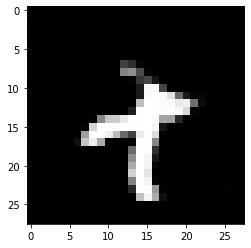

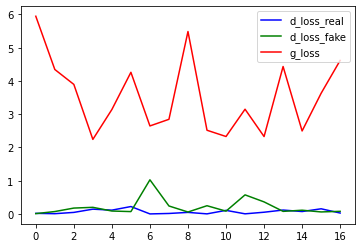

[17/200][0/938] Loss_D: 0.1470 Loss_G: 5.7319 D(x): 0.8909 D(G(z)): 0.0212 / 0.0114
[17/200][100/938] Loss_D: 0.3219 Loss_G: 2.6378 D(x): 0.8329 D(G(z)): 0.1024 / 0.1231
[17/200][200/938] Loss_D: 0.3981 Loss_G: 1.6519 D(x): 0.9886 D(G(z)): 0.2831 / 0.2836
[17/200][300/938] Loss_D: 0.1564 Loss_G: 3.0365 D(x): 0.9700 D(G(z)): 0.1073 / 0.0875
[17/200][400/938] Loss_D: 0.0517 Loss_G: 3.7516 D(x): 0.9937 D(G(z)): 0.0429 / 0.0446
[17/200][500/938] Loss_D: 0.2620 Loss_G: 4.3732 D(x): 0.8160 D(G(z)): 0.0283 / 0.0420
[17/200][600/938] Loss_D: 0.4453 Loss_G: 2.7777 D(x): 0.8007 D(G(z)): 0.1513 / 0.1183
[17/200][700/938] Loss_D: 0.2391 Loss_G: 4.9238 D(x): 0.8557 D(G(z)): 0.0520 / 0.0256
[17/200][800/938] Loss_D: 0.3917 Loss_G: 3.8139 D(x): 0.7478 D(G(z)): 0.0403 / 0.0480
[17/200][900/938] Loss_D: 0.0893 Loss_G: 4.3284 D(x): 0.9506 D(G(z)): 0.0338 / 0.0354


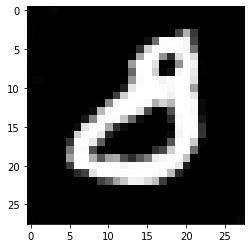

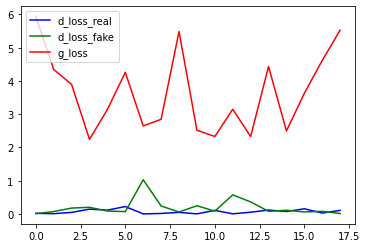

[18/200][0/938] Loss_D: 0.1142 Loss_G: 5.3152 D(x): 0.9041 D(G(z)): 0.0071 / 0.0094
[18/200][100/938] Loss_D: 0.0901 Loss_G: 5.9455 D(x): 0.9374 D(G(z)): 0.0199 / 0.0056
[18/200][200/938] Loss_D: 0.5026 Loss_G: 2.1419 D(x): 0.9898 D(G(z)): 0.3192 / 0.2018
[18/200][300/938] Loss_D: 0.1559 Loss_G: 3.3314 D(x): 0.9163 D(G(z)): 0.0496 / 0.0637
[18/200][400/938] Loss_D: 0.0863 Loss_G: 3.7997 D(x): 0.9395 D(G(z)): 0.0188 / 0.0465
[18/200][500/938] Loss_D: 0.2906 Loss_G: 4.3222 D(x): 0.7961 D(G(z)): 0.0300 / 0.0334
[18/200][600/938] Loss_D: 0.2672 Loss_G: 3.6308 D(x): 0.9741 D(G(z)): 0.1973 / 0.0457
[18/200][700/938] Loss_D: 0.2238 Loss_G: 3.1423 D(x): 0.8694 D(G(z)): 0.0525 / 0.1018
[18/200][800/938] Loss_D: 0.2389 Loss_G: 3.2737 D(x): 0.9792 D(G(z)): 0.1730 / 0.0819
[18/200][900/938] Loss_D: 0.1234 Loss_G: 5.9376 D(x): 0.9245 D(G(z)): 0.0349 / 0.0075


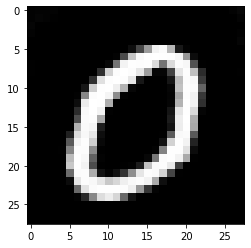

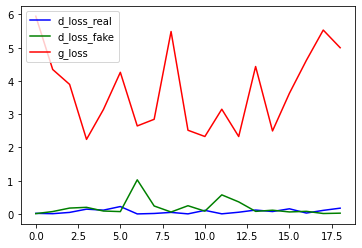

[19/200][0/938] Loss_D: 0.2235 Loss_G: 4.2566 D(x): 0.8504 D(G(z)): 0.0243 / 0.0333
[19/200][100/938] Loss_D: 0.4049 Loss_G: 2.6914 D(x): 0.9560 D(G(z)): 0.2417 / 0.1447
[19/200][200/938] Loss_D: 0.0714 Loss_G: 3.5885 D(x): 0.9556 D(G(z)): 0.0229 / 0.0515
[19/200][300/938] Loss_D: 0.4741 Loss_G: 4.7079 D(x): 0.6857 D(G(z)): 0.0105 / 0.0257
[19/200][400/938] Loss_D: 0.2133 Loss_G: 4.2490 D(x): 0.8714 D(G(z)): 0.0505 / 0.0309
[19/200][500/938] Loss_D: 0.2591 Loss_G: 2.4146 D(x): 0.9846 D(G(z)): 0.1794 / 0.1751
[19/200][600/938] Loss_D: 0.2988 Loss_G: 2.1215 D(x): 0.9847 D(G(z)): 0.2098 / 0.1882
[19/200][700/938] Loss_D: 0.5771 Loss_G: 5.5878 D(x): 0.6683 D(G(z)): 0.0128 / 0.0134
[19/200][800/938] Loss_D: 0.0834 Loss_G: 3.7897 D(x): 0.9703 D(G(z)): 0.0476 / 0.0543
[19/200][900/938] Loss_D: 0.2300 Loss_G: 3.9255 D(x): 0.9537 D(G(z)): 0.1464 / 0.0425


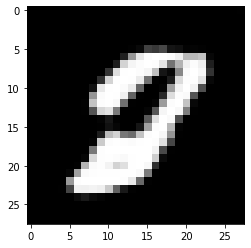

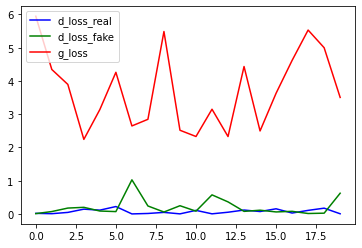

[20/200][0/938] Loss_D: 0.1597 Loss_G: 5.6161 D(x): 0.9016 D(G(z)): 0.0434 / 0.0100
[20/200][100/938] Loss_D: 0.1510 Loss_G: 3.8533 D(x): 0.9134 D(G(z)): 0.0425 / 0.0574
[20/200][200/938] Loss_D: 0.4733 Loss_G: 2.6728 D(x): 0.8183 D(G(z)): 0.1722 / 0.1454
[20/200][300/938] Loss_D: 0.2020 Loss_G: 3.9866 D(x): 0.8624 D(G(z)): 0.0343 / 0.0419
[20/200][400/938] Loss_D: 0.5033 Loss_G: 5.3255 D(x): 0.6838 D(G(z)): 0.0195 / 0.0098
[20/200][500/938] Loss_D: 0.3106 Loss_G: 3.4607 D(x): 0.9392 D(G(z)): 0.1846 / 0.0695
[20/200][600/938] Loss_D: 0.1121 Loss_G: 5.0509 D(x): 0.9635 D(G(z)): 0.0651 / 0.0203
[20/200][700/938] Loss_D: 0.1650 Loss_G: 3.0224 D(x): 0.9722 D(G(z)): 0.1137 / 0.1095
[20/200][800/938] Loss_D: 0.5975 Loss_G: 1.8194 D(x): 0.9928 D(G(z)): 0.3574 / 0.2555
[20/200][900/938] Loss_D: 0.1841 Loss_G: 2.7853 D(x): 0.9556 D(G(z)): 0.1145 / 0.1420


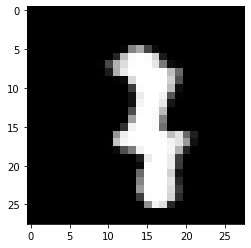

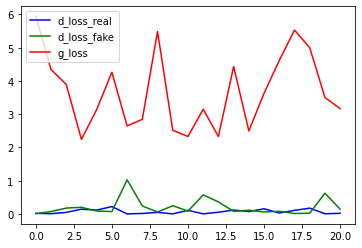

[21/200][0/938] Loss_D: 0.0913 Loss_G: 3.7686 D(x): 0.9780 D(G(z)): 0.0625 / 0.0445
[21/200][100/938] Loss_D: 0.1499 Loss_G: 4.2063 D(x): 0.9475 D(G(z)): 0.0810 / 0.0345
[21/200][200/938] Loss_D: 0.1666 Loss_G: 4.4164 D(x): 0.9453 D(G(z)): 0.0911 / 0.0337
[21/200][300/938] Loss_D: 0.6713 Loss_G: 2.0534 D(x): 0.9959 D(G(z)): 0.4228 / 0.2009
[21/200][400/938] Loss_D: 0.3885 Loss_G: 2.9901 D(x): 0.9478 D(G(z)): 0.2410 / 0.1013
[21/200][500/938] Loss_D: 0.2431 Loss_G: 2.8188 D(x): 0.8916 D(G(z)): 0.0987 / 0.1107
[21/200][600/938] Loss_D: 0.4941 Loss_G: 2.4652 D(x): 0.7686 D(G(z)): 0.1354 / 0.1511
[21/200][700/938] Loss_D: 0.1626 Loss_G: 3.2458 D(x): 0.9897 D(G(z)): 0.1266 / 0.0791
[21/200][800/938] Loss_D: 0.1395 Loss_G: 4.6128 D(x): 0.9403 D(G(z)): 0.0673 / 0.0264
[21/200][900/938] Loss_D: 0.2042 Loss_G: 2.0820 D(x): 0.9251 D(G(z)): 0.1020 / 0.2204


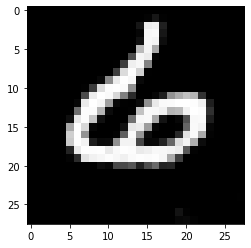

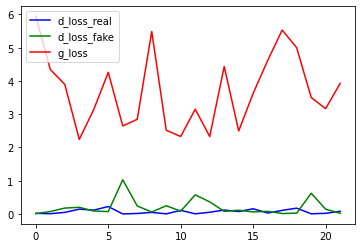

[22/200][0/938] Loss_D: 0.4192 Loss_G: 2.5222 D(x): 0.9899 D(G(z)): 0.2646 / 0.1577
[22/200][100/938] Loss_D: 0.3069 Loss_G: 5.4636 D(x): 0.8062 D(G(z)): 0.0117 / 0.0135
[22/200][200/938] Loss_D: 0.1635 Loss_G: 3.6503 D(x): 0.9271 D(G(z)): 0.0744 / 0.0514
[22/200][300/938] Loss_D: 0.5209 Loss_G: 3.7652 D(x): 0.6656 D(G(z)): 0.0235 / 0.0546
[22/200][400/938] Loss_D: 0.1132 Loss_G: 3.4570 D(x): 0.9515 D(G(z)): 0.0530 / 0.0859
[22/200][500/938] Loss_D: 0.9207 Loss_G: 4.6859 D(x): 0.5139 D(G(z)): 0.0149 / 0.0357
[22/200][600/938] Loss_D: 0.1570 Loss_G: 4.3851 D(x): 0.9578 D(G(z)): 0.0899 / 0.0413
[22/200][700/938] Loss_D: 0.2508 Loss_G: 4.2447 D(x): 0.8511 D(G(z)): 0.0487 / 0.0422
[22/200][800/938] Loss_D: 0.2775 Loss_G: 3.7486 D(x): 0.9775 D(G(z)): 0.1855 / 0.0521
[22/200][900/938] Loss_D: 0.5144 Loss_G: 2.1193 D(x): 0.9978 D(G(z)): 0.3265 / 0.2182


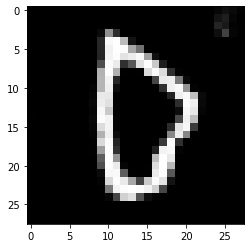

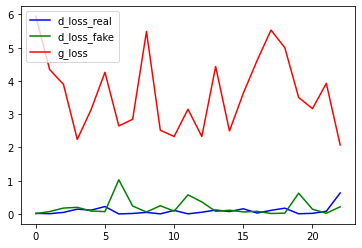

[23/200][0/938] Loss_D: 0.3615 Loss_G: 1.8253 D(x): 0.9918 D(G(z)): 0.2662 / 0.2388
[23/200][100/938] Loss_D: 0.3037 Loss_G: 7.1465 D(x): 0.7687 D(G(z)): 0.0024 / 0.0021
[23/200][200/938] Loss_D: 0.3599 Loss_G: 4.9755 D(x): 0.7557 D(G(z)): 0.0126 / 0.0176
[23/200][300/938] Loss_D: 0.2299 Loss_G: 4.0737 D(x): 0.9905 D(G(z)): 0.1738 / 0.0386
[23/200][400/938] Loss_D: 0.0839 Loss_G: 5.0407 D(x): 0.9756 D(G(z)): 0.0516 / 0.0171
[23/200][500/938] Loss_D: 0.1541 Loss_G: 3.2283 D(x): 0.9696 D(G(z)): 0.0997 / 0.0802
[23/200][600/938] Loss_D: 0.2148 Loss_G: 3.1898 D(x): 0.9561 D(G(z)): 0.1389 / 0.0757
[23/200][700/938] Loss_D: 0.0903 Loss_G: 4.6688 D(x): 0.9330 D(G(z)): 0.0152 / 0.0211
[23/200][800/938] Loss_D: 1.0277 Loss_G: 3.9469 D(x): 0.4823 D(G(z)): 0.0055 / 0.0529
[23/200][900/938] Loss_D: 0.3665 Loss_G: 5.9647 D(x): 0.7393 D(G(z)): 0.0099 / 0.0090


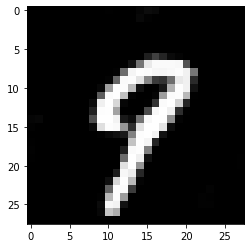

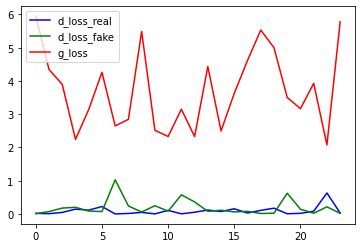

[24/200][0/938] Loss_D: 0.1867 Loss_G: 5.1009 D(x): 0.8708 D(G(z)): 0.0278 / 0.0179
[24/200][100/938] Loss_D: 0.1969 Loss_G: 4.1734 D(x): 0.9018 D(G(z)): 0.0711 / 0.0363
[24/200][200/938] Loss_D: 0.1833 Loss_G: 4.2073 D(x): 0.8739 D(G(z)): 0.0203 / 0.0391
[24/200][300/938] Loss_D: 0.0743 Loss_G: 5.8581 D(x): 0.9402 D(G(z)): 0.0074 / 0.0062
[24/200][400/938] Loss_D: 0.0813 Loss_G: 5.0416 D(x): 0.9464 D(G(z)): 0.0201 / 0.0202
[24/200][500/938] Loss_D: 0.8577 Loss_G: 1.8316 D(x): 0.9906 D(G(z)): 0.4764 / 0.2728
[24/200][600/938] Loss_D: 0.4688 Loss_G: 1.3947 D(x): 0.9768 D(G(z)): 0.2891 / 0.3853
[24/200][700/938] Loss_D: 0.2389 Loss_G: 4.3231 D(x): 0.9684 D(G(z)): 0.1604 / 0.0328
[24/200][800/938] Loss_D: 0.5211 Loss_G: 2.5723 D(x): 0.9813 D(G(z)): 0.3313 / 0.1419
[24/200][900/938] Loss_D: 0.1355 Loss_G: 3.1939 D(x): 0.9590 D(G(z)): 0.0811 / 0.0901


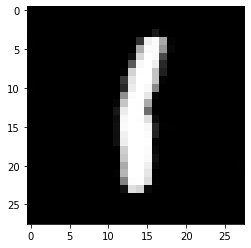

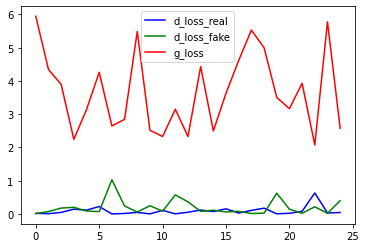

[25/200][0/938] Loss_D: 0.0365 Loss_G: 4.5083 D(x): 0.9879 D(G(z)): 0.0234 / 0.0217
[25/200][100/938] Loss_D: 0.1206 Loss_G: 4.4441 D(x): 0.9820 D(G(z)): 0.0748 / 0.0458
[25/200][200/938] Loss_D: 0.3544 Loss_G: 2.3559 D(x): 0.9136 D(G(z)): 0.1929 / 0.1693
[25/200][300/938] Loss_D: 0.0587 Loss_G: 3.7907 D(x): 0.9832 D(G(z)): 0.0365 / 0.0608
[25/200][400/938] Loss_D: 0.4282 Loss_G: 2.9650 D(x): 0.9575 D(G(z)): 0.2716 / 0.1238
[25/200][500/938] Loss_D: 0.2229 Loss_G: 4.6493 D(x): 0.8483 D(G(z)): 0.0210 / 0.0232
[25/200][600/938] Loss_D: 0.1768 Loss_G: 3.3172 D(x): 0.9411 D(G(z)): 0.0923 / 0.0896
[25/200][700/938] Loss_D: 0.2077 Loss_G: 2.8153 D(x): 0.9934 D(G(z)): 0.1624 / 0.1097
[25/200][800/938] Loss_D: 0.4585 Loss_G: 4.7751 D(x): 0.7120 D(G(z)): 0.0089 / 0.0204
[25/200][900/938] Loss_D: 0.4750 Loss_G: 5.1056 D(x): 0.6858 D(G(z)): 0.0086 / 0.0151


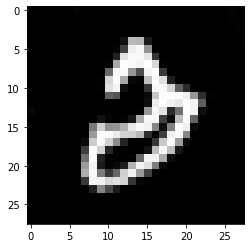

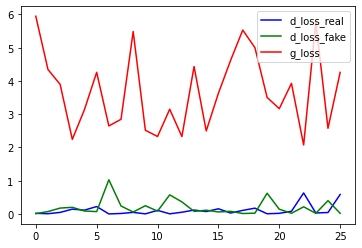

[26/200][0/938] Loss_D: 0.0486 Loss_G: 4.7522 D(x): 0.9654 D(G(z)): 0.0117 / 0.0245
[26/200][100/938] Loss_D: 0.1450 Loss_G: 4.4569 D(x): 0.9439 D(G(z)): 0.0701 / 0.0326
[26/200][200/938] Loss_D: 0.1015 Loss_G: 3.5803 D(x): 0.9646 D(G(z)): 0.0503 / 0.0691
[26/200][300/938] Loss_D: 0.1953 Loss_G: 4.4832 D(x): 0.8538 D(G(z)): 0.0212 / 0.0303
[26/200][400/938] Loss_D: 0.2596 Loss_G: 1.8812 D(x): 0.9213 D(G(z)): 0.1267 / 0.2593
[26/200][500/938] Loss_D: 0.1766 Loss_G: 3.2441 D(x): 0.8923 D(G(z)): 0.0433 / 0.0846
[26/200][600/938] Loss_D: 0.2522 Loss_G: 2.7683 D(x): 0.9184 D(G(z)): 0.1238 / 0.1244
[26/200][700/938] Loss_D: 0.1264 Loss_G: 4.4419 D(x): 0.9066 D(G(z)): 0.0179 / 0.0335
[26/200][800/938] Loss_D: 0.0964 Loss_G: 4.7497 D(x): 0.9394 D(G(z)): 0.0250 / 0.0241
[26/200][900/938] Loss_D: 0.5963 Loss_G: 2.3207 D(x): 0.9010 D(G(z)): 0.3168 / 0.1560


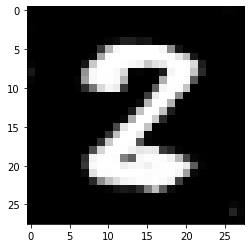

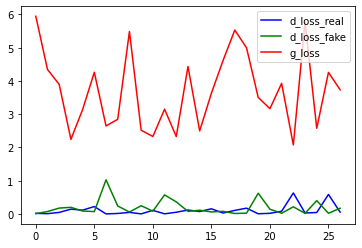

[27/200][0/938] Loss_D: 0.1289 Loss_G: 4.2543 D(x): 0.9630 D(G(z)): 0.0796 / 0.0328
[27/200][100/938] Loss_D: 0.3692 Loss_G: 2.4522 D(x): 0.9885 D(G(z)): 0.2695 / 0.1381
[27/200][200/938] Loss_D: 0.1781 Loss_G: 3.8344 D(x): 0.9053 D(G(z)): 0.0589 / 0.0502
[27/200][300/938] Loss_D: 0.0935 Loss_G: 4.0983 D(x): 0.9553 D(G(z)): 0.0406 / 0.0368
[27/200][400/938] Loss_D: 0.1415 Loss_G: 4.3126 D(x): 0.9437 D(G(z)): 0.0646 / 0.0470
[27/200][500/938] Loss_D: 0.1501 Loss_G: 3.6611 D(x): 0.9397 D(G(z)): 0.0757 / 0.0444
[27/200][600/938] Loss_D: 0.2187 Loss_G: 3.0811 D(x): 0.9694 D(G(z)): 0.1382 / 0.1157
[27/200][700/938] Loss_D: 0.7533 Loss_G: 1.5447 D(x): 0.9574 D(G(z)): 0.3945 / 0.3443
[27/200][800/938] Loss_D: 0.1415 Loss_G: 4.2819 D(x): 0.9649 D(G(z)): 0.0849 / 0.0302
[27/200][900/938] Loss_D: 0.3316 Loss_G: 3.6518 D(x): 0.8241 D(G(z)): 0.0907 / 0.0510


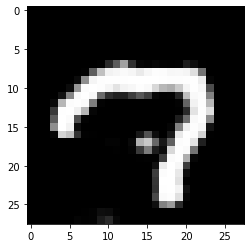

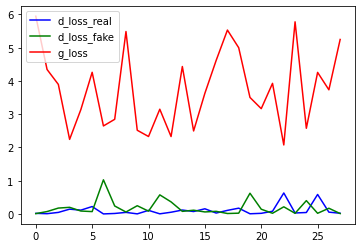

[28/200][0/938] Loss_D: 0.3024 Loss_G: 2.9135 D(x): 0.8182 D(G(z)): 0.0658 / 0.0965
[28/200][100/938] Loss_D: 0.1716 Loss_G: 5.9109 D(x): 0.8767 D(G(z)): 0.0090 / 0.0110
[28/200][200/938] Loss_D: 0.1010 Loss_G: 5.4535 D(x): 0.9464 D(G(z)): 0.0398 / 0.0121
[28/200][300/938] Loss_D: 0.5787 Loss_G: 2.2944 D(x): 0.9595 D(G(z)): 0.3224 / 0.2128
[28/200][400/938] Loss_D: 0.3616 Loss_G: 4.1277 D(x): 0.8345 D(G(z)): 0.0910 / 0.0508
[28/200][500/938] Loss_D: 0.3444 Loss_G: 3.1110 D(x): 0.8975 D(G(z)): 0.1649 / 0.1010
[28/200][600/938] Loss_D: 0.3468 Loss_G: 4.1306 D(x): 0.7711 D(G(z)): 0.0301 / 0.0441
[28/200][700/938] Loss_D: 0.1149 Loss_G: 3.2192 D(x): 0.9723 D(G(z)): 0.0692 / 0.0918
[28/200][800/938] Loss_D: 0.2784 Loss_G: 3.2929 D(x): 0.8627 D(G(z)): 0.0910 / 0.0667
[28/200][900/938] Loss_D: 0.1510 Loss_G: 5.4234 D(x): 0.8952 D(G(z)): 0.0277 / 0.0125


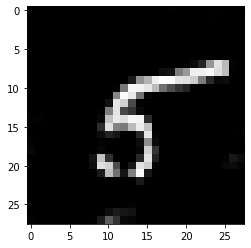

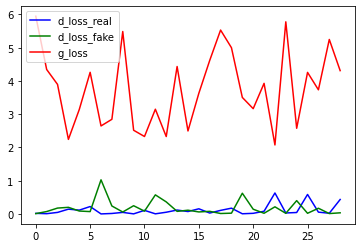

[29/200][0/938] Loss_D: 0.2959 Loss_G: 3.9319 D(x): 0.8109 D(G(z)): 0.0426 / 0.0611
[29/200][100/938] Loss_D: 0.2330 Loss_G: 3.2011 D(x): 0.8674 D(G(z)): 0.0695 / 0.0750
[29/200][200/938] Loss_D: 0.1546 Loss_G: 3.4849 D(x): 0.9585 D(G(z)): 0.0957 / 0.0682
[29/200][300/938] Loss_D: 0.2918 Loss_G: 2.7390 D(x): 0.9766 D(G(z)): 0.2053 / 0.1092
[29/200][400/938] Loss_D: 0.1266 Loss_G: 3.7622 D(x): 0.9824 D(G(z)): 0.0937 / 0.0434
[29/200][500/938] Loss_D: 0.1375 Loss_G: 4.4836 D(x): 0.9071 D(G(z)): 0.0298 / 0.0341
[29/200][600/938] Loss_D: 0.7811 Loss_G: 7.0153 D(x): 0.5458 D(G(z)): 0.0019 / 0.0030
[29/200][700/938] Loss_D: 0.5290 Loss_G: 1.9007 D(x): 0.9181 D(G(z)): 0.2898 / 0.2472
[29/200][800/938] Loss_D: 0.3004 Loss_G: 3.0732 D(x): 0.9284 D(G(z)): 0.1726 / 0.0943
[29/200][900/938] Loss_D: 0.2469 Loss_G: 2.3192 D(x): 0.9549 D(G(z)): 0.1559 / 0.1799


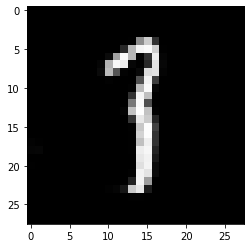

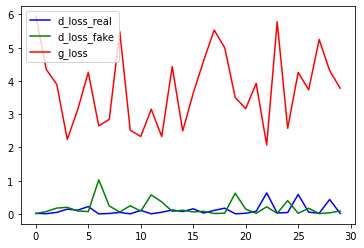

[30/200][0/938] Loss_D: 0.3119 Loss_G: 3.2325 D(x): 0.9820 D(G(z)): 0.2153 / 0.0857
[30/200][100/938] Loss_D: 0.3125 Loss_G: 2.5985 D(x): 0.9906 D(G(z)): 0.2118 / 0.1364
[30/200][200/938] Loss_D: 0.6313 Loss_G: 3.9095 D(x): 0.9773 D(G(z)): 0.3647 / 0.0485
[30/200][300/938] Loss_D: 0.6738 Loss_G: 2.5008 D(x): 0.9810 D(G(z)): 0.3927 / 0.1438
[30/200][400/938] Loss_D: 0.3380 Loss_G: 3.5419 D(x): 0.9150 D(G(z)): 0.1683 / 0.0782
[30/200][500/938] Loss_D: 0.2273 Loss_G: 1.5998 D(x): 0.9587 D(G(z)): 0.1538 / 0.2799
[30/200][600/938] Loss_D: 0.2765 Loss_G: 2.8139 D(x): 0.9190 D(G(z)): 0.1439 / 0.1105
[30/200][700/938] Loss_D: 0.3444 Loss_G: 3.6291 D(x): 0.9893 D(G(z)): 0.2270 / 0.0725
[30/200][800/938] Loss_D: 0.1634 Loss_G: 3.0587 D(x): 0.9622 D(G(z)): 0.1005 / 0.1136
[30/200][900/938] Loss_D: 0.5693 Loss_G: 2.3476 D(x): 0.9882 D(G(z)): 0.3449 / 0.1716


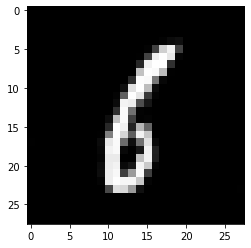

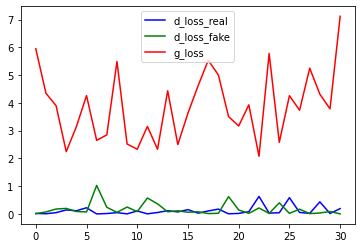

[31/200][0/938] Loss_D: 0.1877 Loss_G: 4.2552 D(x): 0.8787 D(G(z)): 0.0245 / 0.0331
[31/200][100/938] Loss_D: 0.1268 Loss_G: 4.1552 D(x): 0.9336 D(G(z)): 0.0429 / 0.0391
[31/200][200/938] Loss_D: 0.2156 Loss_G: 5.1101 D(x): 0.8369 D(G(z)): 0.0241 / 0.0167
[31/200][300/938] Loss_D: 0.2971 Loss_G: 3.0613 D(x): 0.9651 D(G(z)): 0.1975 / 0.1107
[31/200][400/938] Loss_D: 0.1156 Loss_G: 3.8893 D(x): 0.9394 D(G(z)): 0.0340 / 0.0605
[31/200][500/938] Loss_D: 0.1089 Loss_G: 3.6635 D(x): 0.9766 D(G(z)): 0.0752 / 0.0578
[31/200][600/938] Loss_D: 0.0937 Loss_G: 4.0386 D(x): 0.9625 D(G(z)): 0.0421 / 0.0498
[31/200][700/938] Loss_D: 0.5786 Loss_G: 6.7786 D(x): 0.6547 D(G(z)): 0.0037 / 0.0035
[31/200][800/938] Loss_D: 0.1292 Loss_G: 5.4710 D(x): 0.8996 D(G(z)): 0.0182 / 0.0107
[31/200][900/938] Loss_D: 0.4664 Loss_G: 6.2228 D(x): 0.6881 D(G(z)): 0.0101 / 0.0076


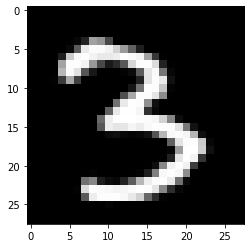

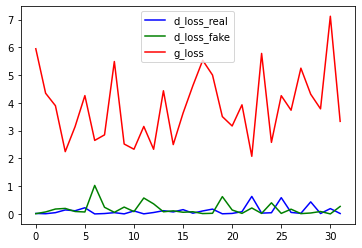

[32/200][0/938] Loss_D: 0.1113 Loss_G: 5.6109 D(x): 0.9344 D(G(z)): 0.0368 / 0.0138
[32/200][100/938] Loss_D: 0.0915 Loss_G: 4.0544 D(x): 0.9800 D(G(z)): 0.0645 / 0.0455
[32/200][200/938] Loss_D: 0.2371 Loss_G: 3.3187 D(x): 0.8729 D(G(z)): 0.0725 / 0.0836
[32/200][300/938] Loss_D: 0.1055 Loss_G: 5.7071 D(x): 0.9176 D(G(z)): 0.0124 / 0.0103
[32/200][400/938] Loss_D: 0.3253 Loss_G: 2.7389 D(x): 0.9525 D(G(z)): 0.1832 / 0.1578
[32/200][500/938] Loss_D: 0.2515 Loss_G: 2.6967 D(x): 0.9899 D(G(z)): 0.1774 / 0.1357
[32/200][600/938] Loss_D: 0.3657 Loss_G: 4.3805 D(x): 0.7470 D(G(z)): 0.0115 / 0.0290
[32/200][700/938] Loss_D: 0.0844 Loss_G: 3.3698 D(x): 0.9547 D(G(z)): 0.0346 / 0.0777
[32/200][800/938] Loss_D: 0.4120 Loss_G: 4.2977 D(x): 0.8211 D(G(z)): 0.1251 / 0.0665
[32/200][900/938] Loss_D: 0.1792 Loss_G: 3.7831 D(x): 0.9371 D(G(z)): 0.0879 / 0.0648


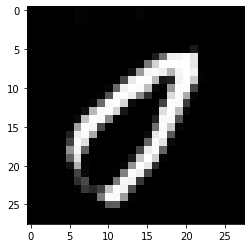

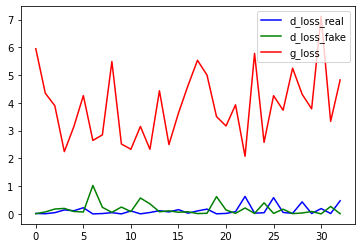

[33/200][0/938] Loss_D: 0.3894 Loss_G: 3.4043 D(x): 0.7600 D(G(z)): 0.0297 / 0.0957
[33/200][100/938] Loss_D: 0.9001 Loss_G: 2.4614 D(x): 0.5549 D(G(z)): 0.1021 / 0.1510
[33/200][200/938] Loss_D: 0.2646 Loss_G: 3.3467 D(x): 0.9059 D(G(z)): 0.1272 / 0.0737
[33/200][300/938] Loss_D: 0.2271 Loss_G: 3.7311 D(x): 0.8663 D(G(z)): 0.0626 / 0.0548
[33/200][400/938] Loss_D: 0.1135 Loss_G: 4.4069 D(x): 0.9331 D(G(z)): 0.0299 / 0.0301
[33/200][500/938] Loss_D: 0.1194 Loss_G: 6.5453 D(x): 0.9115 D(G(z)): 0.0042 / 0.0035
[33/200][600/938] Loss_D: 0.1084 Loss_G: 4.0540 D(x): 0.9751 D(G(z)): 0.0719 / 0.0395
[33/200][700/938] Loss_D: 0.7310 Loss_G: 2.0881 D(x): 0.9778 D(G(z)): 0.4177 / 0.2082
[33/200][800/938] Loss_D: 0.1433 Loss_G: 4.4209 D(x): 0.9091 D(G(z)): 0.0361 / 0.0471
[33/200][900/938] Loss_D: 0.1328 Loss_G: 4.7139 D(x): 0.9589 D(G(z)): 0.0778 / 0.0225


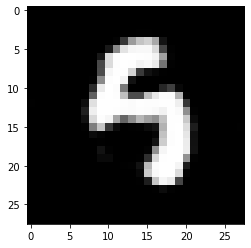

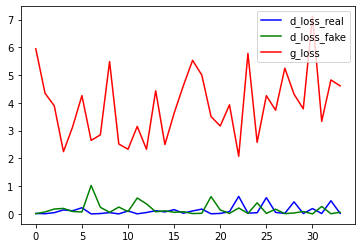

[34/200][0/938] Loss_D: 0.0601 Loss_G: 4.8192 D(x): 0.9630 D(G(z)): 0.0202 / 0.0238
[34/200][100/938] Loss_D: 0.1883 Loss_G: 3.4943 D(x): 0.9116 D(G(z)): 0.0800 / 0.0787
[34/200][200/938] Loss_D: 0.2403 Loss_G: 4.5493 D(x): 0.8864 D(G(z)): 0.0701 / 0.0515
[34/200][300/938] Loss_D: 0.0782 Loss_G: 3.8417 D(x): 0.9722 D(G(z)): 0.0448 / 0.0474
[34/200][400/938] Loss_D: 0.0998 Loss_G: 3.8105 D(x): 0.9410 D(G(z)): 0.0306 / 0.0573
[34/200][500/938] Loss_D: 0.1123 Loss_G: 5.1936 D(x): 0.9300 D(G(z)): 0.0274 / 0.0163
[34/200][600/938] Loss_D: 0.5237 Loss_G: 2.2500 D(x): 0.9548 D(G(z)): 0.2733 / 0.2311
[34/200][700/938] Loss_D: 0.1820 Loss_G: 3.2722 D(x): 0.9792 D(G(z)): 0.1314 / 0.0659
[34/200][800/938] Loss_D: 0.6566 Loss_G: 2.7319 D(x): 0.9727 D(G(z)): 0.3749 / 0.1374
[34/200][900/938] Loss_D: 0.1104 Loss_G: 3.8155 D(x): 0.9635 D(G(z)): 0.0521 / 0.0614


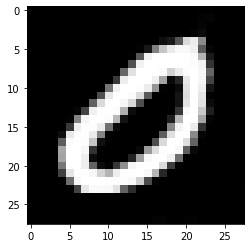

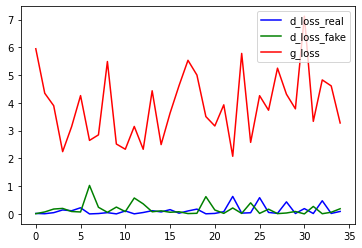

[35/200][0/938] Loss_D: 0.2183 Loss_G: 4.3738 D(x): 0.8696 D(G(z)): 0.0487 / 0.0472
[35/200][100/938] Loss_D: 1.0646 Loss_G: 2.1629 D(x): 0.9923 D(G(z)): 0.5406 / 0.2221
[35/200][200/938] Loss_D: 0.8677 Loss_G: 5.5176 D(x): 0.5246 D(G(z)): 0.0076 / 0.0162
[35/200][300/938] Loss_D: 0.2052 Loss_G: 4.7458 D(x): 0.8501 D(G(z)): 0.0178 / 0.0254
[35/200][400/938] Loss_D: 1.3334 Loss_G: 1.9011 D(x): 0.9917 D(G(z)): 0.6229 / 0.2463
[35/200][500/938] Loss_D: 0.1544 Loss_G: 2.8271 D(x): 0.9149 D(G(z)): 0.0460 / 0.1358
[35/200][600/938] Loss_D: 0.2779 Loss_G: 2.9335 D(x): 0.8651 D(G(z)): 0.0851 / 0.1014
[35/200][700/938] Loss_D: 0.7141 Loss_G: 4.0652 D(x): 0.5895 D(G(z)): 0.0202 / 0.0432
[35/200][800/938] Loss_D: 0.1482 Loss_G: 4.1063 D(x): 0.9024 D(G(z)): 0.0324 / 0.0363
[35/200][900/938] Loss_D: 0.0856 Loss_G: 3.1210 D(x): 0.9894 D(G(z)): 0.0670 / 0.0905


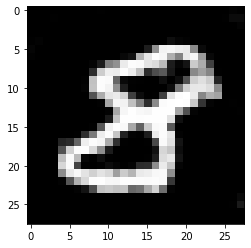

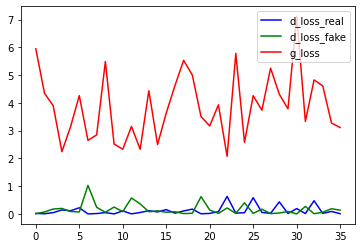

[36/200][0/938] Loss_D: 0.0998 Loss_G: 3.3112 D(x): 0.9782 D(G(z)): 0.0691 / 0.0807
[36/200][100/938] Loss_D: 0.1619 Loss_G: 6.3710 D(x): 0.8664 D(G(z)): 0.0066 / 0.0059
[36/200][200/938] Loss_D: 0.2001 Loss_G: 4.0884 D(x): 0.8615 D(G(z)): 0.0277 / 0.0442
[36/200][300/938] Loss_D: 0.4395 Loss_G: 4.7306 D(x): 0.6986 D(G(z)): 0.0141 / 0.0255
[36/200][400/938] Loss_D: 0.0396 Loss_G: 3.7174 D(x): 0.9856 D(G(z)): 0.0240 / 0.0649
[36/200][500/938] Loss_D: 0.1178 Loss_G: 4.7597 D(x): 0.9466 D(G(z)): 0.0495 / 0.0309
[36/200][600/938] Loss_D: 0.0809 Loss_G: 5.9577 D(x): 0.9493 D(G(z)): 0.0222 / 0.0198
[36/200][700/938] Loss_D: 0.5451 Loss_G: 3.1526 D(x): 0.9590 D(G(z)): 0.3045 / 0.0944
[36/200][800/938] Loss_D: 0.2529 Loss_G: 3.9427 D(x): 0.8312 D(G(z)): 0.0218 / 0.0483
[36/200][900/938] Loss_D: 0.4227 Loss_G: 5.9786 D(x): 0.7215 D(G(z)): 0.0081 / 0.0124


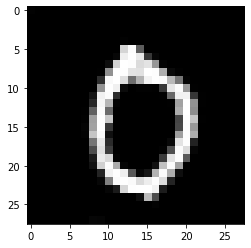

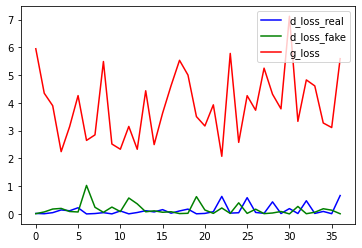

[37/200][0/938] Loss_D: 0.2020 Loss_G: 2.7862 D(x): 0.8787 D(G(z)): 0.0467 / 0.1173
[37/200][100/938] Loss_D: 0.6415 Loss_G: 4.5343 D(x): 0.6144 D(G(z)): 0.0243 / 0.0284
[37/200][200/938] Loss_D: 0.1926 Loss_G: 2.8203 D(x): 0.9919 D(G(z)): 0.1496 / 0.1160
[37/200][300/938] Loss_D: 0.3964 Loss_G: 1.9621 D(x): 0.9138 D(G(z)): 0.2143 / 0.2485
[37/200][400/938] Loss_D: 0.4264 Loss_G: 2.9140 D(x): 0.7529 D(G(z)): 0.0664 / 0.1429
[37/200][500/938] Loss_D: 0.3531 Loss_G: 2.4696 D(x): 0.7690 D(G(z)): 0.0423 / 0.1792
[37/200][600/938] Loss_D: 0.3571 Loss_G: 2.9492 D(x): 0.9259 D(G(z)): 0.2064 / 0.1056
[37/200][700/938] Loss_D: 0.0906 Loss_G: 4.3668 D(x): 0.9916 D(G(z)): 0.0707 / 0.0392
[37/200][800/938] Loss_D: 0.2926 Loss_G: 2.9009 D(x): 0.8817 D(G(z)): 0.1118 / 0.1189
[37/200][900/938] Loss_D: 0.1958 Loss_G: 3.0246 D(x): 0.9876 D(G(z)): 0.1299 / 0.1228


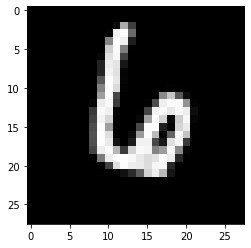

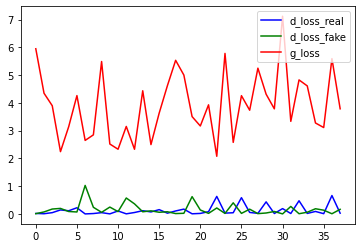

[38/200][0/938] Loss_D: 0.1291 Loss_G: 4.3133 D(x): 0.9391 D(G(z)): 0.0586 / 0.0293
[38/200][100/938] Loss_D: 0.0878 Loss_G: 4.9871 D(x): 0.9879 D(G(z)): 0.0694 / 0.0152
[38/200][200/938] Loss_D: 0.3276 Loss_G: 3.2444 D(x): 0.9741 D(G(z)): 0.2095 / 0.1252
[38/200][300/938] Loss_D: 0.1204 Loss_G: 3.4784 D(x): 0.9212 D(G(z)): 0.0261 / 0.0713
[38/200][400/938] Loss_D: 0.2134 Loss_G: 4.1779 D(x): 0.8841 D(G(z)): 0.0609 / 0.0590
[38/200][500/938] Loss_D: 0.4648 Loss_G: 7.1961 D(x): 0.6925 D(G(z)): 0.0018 / 0.0018
[38/200][600/938] Loss_D: 0.1443 Loss_G: 5.4485 D(x): 0.9001 D(G(z)): 0.0187 / 0.0158
[38/200][700/938] Loss_D: 0.2027 Loss_G: 3.5691 D(x): 0.9510 D(G(z)): 0.0977 / 0.0708
[38/200][800/938] Loss_D: 0.5390 Loss_G: 2.4725 D(x): 0.9726 D(G(z)): 0.2974 / 0.1753
[38/200][900/938] Loss_D: 0.2886 Loss_G: 3.3307 D(x): 0.9558 D(G(z)): 0.1686 / 0.0820


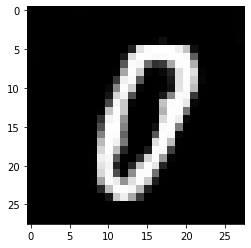

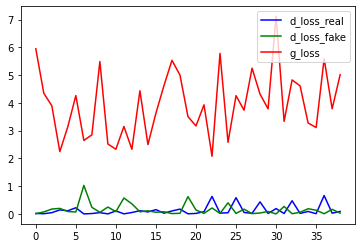

[39/200][0/938] Loss_D: 0.3256 Loss_G: 3.7862 D(x): 0.7915 D(G(z)): 0.0409 / 0.0530
[39/200][100/938] Loss_D: 0.0897 Loss_G: 3.5082 D(x): 0.9812 D(G(z)): 0.0638 / 0.0688
[39/200][200/938] Loss_D: 0.1828 Loss_G: 4.4758 D(x): 0.8841 D(G(z)): 0.0448 / 0.0272
[39/200][300/938] Loss_D: 0.0894 Loss_G: 5.2674 D(x): 0.9445 D(G(z)): 0.0255 / 0.0168
[39/200][400/938] Loss_D: 0.2720 Loss_G: 2.1648 D(x): 0.9870 D(G(z)): 0.1910 / 0.1981
[39/200][500/938] Loss_D: 0.2301 Loss_G: 3.4632 D(x): 0.9365 D(G(z)): 0.1254 / 0.0781
[39/200][600/938] Loss_D: 0.0730 Loss_G: 4.0397 D(x): 0.9700 D(G(z)): 0.0380 / 0.0477
[39/200][700/938] Loss_D: 0.2476 Loss_G: 4.9711 D(x): 0.8396 D(G(z)): 0.0212 / 0.0235
[39/200][800/938] Loss_D: 0.1432 Loss_G: 5.4914 D(x): 0.9032 D(G(z)): 0.0272 / 0.0152
[39/200][900/938] Loss_D: 0.2827 Loss_G: 5.0299 D(x): 0.7972 D(G(z)): 0.0200 / 0.0308


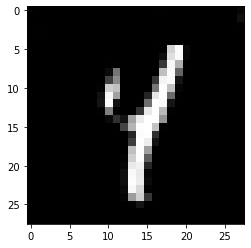

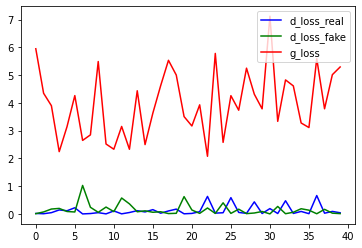

[40/200][0/938] Loss_D: 0.1462 Loss_G: 3.4561 D(x): 0.9836 D(G(z)): 0.0971 / 0.0714
[40/200][100/938] Loss_D: 0.1936 Loss_G: 4.3895 D(x): 0.8506 D(G(z)): 0.0109 / 0.0375
[40/200][200/938] Loss_D: 0.1768 Loss_G: 3.9000 D(x): 0.9621 D(G(z)): 0.1049 / 0.0642
[40/200][300/938] Loss_D: 0.6365 Loss_G: 1.8676 D(x): 0.9977 D(G(z)): 0.3504 / 0.2484
[40/200][400/938] Loss_D: 0.3083 Loss_G: 5.3767 D(x): 0.7885 D(G(z)): 0.0146 / 0.0179
[40/200][500/938] Loss_D: 0.1178 Loss_G: 3.8659 D(x): 0.9571 D(G(z)): 0.0616 / 0.0600
[40/200][600/938] Loss_D: 0.3202 Loss_G: 3.1223 D(x): 0.9632 D(G(z)): 0.2023 / 0.0949
[40/200][700/938] Loss_D: 0.1766 Loss_G: 4.7393 D(x): 0.8955 D(G(z)): 0.0455 / 0.0232
[40/200][800/938] Loss_D: 0.2243 Loss_G: 4.2045 D(x): 0.9547 D(G(z)): 0.1311 / 0.0438
[40/200][900/938] Loss_D: 0.0740 Loss_G: 4.3887 D(x): 0.9661 D(G(z)): 0.0350 / 0.0339


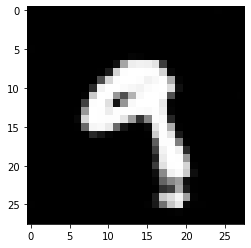

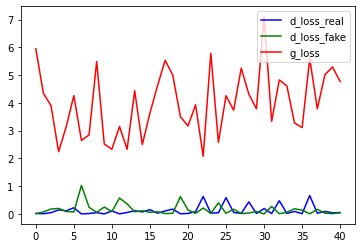

[41/200][0/938] Loss_D: 0.1660 Loss_G: 4.4581 D(x): 0.9817 D(G(z)): 0.0984 / 0.0486
[41/200][100/938] Loss_D: 0.2597 Loss_G: 2.7655 D(x): 0.9887 D(G(z)): 0.1669 / 0.1572
[41/200][200/938] Loss_D: 0.2683 Loss_G: 3.3762 D(x): 0.9393 D(G(z)): 0.1563 / 0.0715
[41/200][300/938] Loss_D: 0.0478 Loss_G: 4.1650 D(x): 0.9905 D(G(z)): 0.0352 / 0.0419
[41/200][400/938] Loss_D: 0.3999 Loss_G: 2.5287 D(x): 0.9810 D(G(z)): 0.2513 / 0.1759
[41/200][500/938] Loss_D: 0.3013 Loss_G: 3.4431 D(x): 0.8842 D(G(z)): 0.1196 / 0.0891
[41/200][600/938] Loss_D: 0.0340 Loss_G: 5.8382 D(x): 0.9843 D(G(z)): 0.0164 / 0.0159
[41/200][700/938] Loss_D: 0.0778 Loss_G: 4.6637 D(x): 0.9714 D(G(z)): 0.0427 / 0.0257
[41/200][800/938] Loss_D: 0.4601 Loss_G: 4.0470 D(x): 0.9634 D(G(z)): 0.2649 / 0.0542
[41/200][900/938] Loss_D: 0.1839 Loss_G: 3.0045 D(x): 0.9651 D(G(z)): 0.1258 / 0.0942


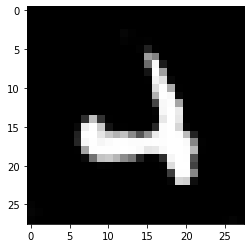

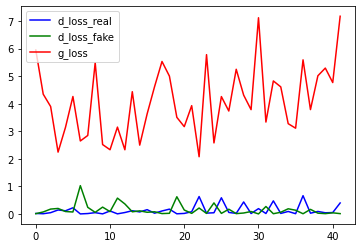

[42/200][0/938] Loss_D: 0.1482 Loss_G: 8.8000 D(x): 0.8853 D(G(z)): 0.0018 / 0.0009
[42/200][100/938] Loss_D: 0.2378 Loss_G: 2.9597 D(x): 0.9514 D(G(z)): 0.1373 / 0.1322
[42/200][200/938] Loss_D: 0.2209 Loss_G: 5.2473 D(x): 0.8654 D(G(z)): 0.0250 / 0.0168
[42/200][300/938] Loss_D: 0.3786 Loss_G: 4.0615 D(x): 0.7632 D(G(z)): 0.0190 / 0.0447
[42/200][400/938] Loss_D: 0.1780 Loss_G: 3.6255 D(x): 0.9945 D(G(z)): 0.1385 / 0.0572
[42/200][500/938] Loss_D: 0.4703 Loss_G: 4.2834 D(x): 0.7242 D(G(z)): 0.0566 / 0.0330
[42/200][600/938] Loss_D: 0.3928 Loss_G: 5.0894 D(x): 0.7497 D(G(z)): 0.0215 / 0.0314
[42/200][700/938] Loss_D: 0.2451 Loss_G: 5.4824 D(x): 0.8374 D(G(z)): 0.0253 / 0.0163
[42/200][800/938] Loss_D: 0.0766 Loss_G: 5.9820 D(x): 0.9485 D(G(z)): 0.0166 / 0.0084
[42/200][900/938] Loss_D: 0.0708 Loss_G: 4.0395 D(x): 0.9823 D(G(z)): 0.0471 / 0.0420


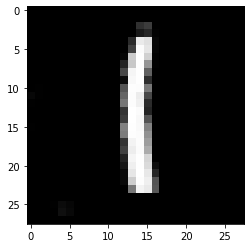

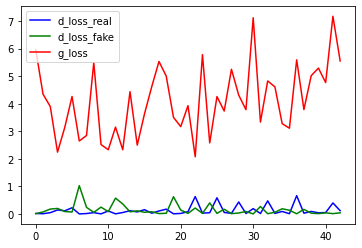

[43/200][0/938] Loss_D: 0.5078 Loss_G: 4.5429 D(x): 0.6770 D(G(z)): 0.0179 / 0.0272
[43/200][100/938] Loss_D: 0.0702 Loss_G: 5.3840 D(x): 0.9549 D(G(z)): 0.0216 / 0.0087
[43/200][200/938] Loss_D: 0.7214 Loss_G: 2.3836 D(x): 0.9929 D(G(z)): 0.3925 / 0.1711
[43/200][300/938] Loss_D: 0.0825 Loss_G: 5.2653 D(x): 0.9792 D(G(z)): 0.0523 / 0.0277
[43/200][400/938] Loss_D: 0.1880 Loss_G: 2.5305 D(x): 0.9638 D(G(z)): 0.1148 / 0.1832
[43/200][500/938] Loss_D: 0.2340 Loss_G: 2.7357 D(x): 0.9152 D(G(z)): 0.1065 / 0.1520
[43/200][600/938] Loss_D: 0.3249 Loss_G: 5.6658 D(x): 0.7868 D(G(z)): 0.0045 / 0.0083
[43/200][700/938] Loss_D: 0.2517 Loss_G: 4.0374 D(x): 0.9567 D(G(z)): 0.1605 / 0.0481
[43/200][800/938] Loss_D: 0.2231 Loss_G: 3.3893 D(x): 0.9466 D(G(z)): 0.1237 / 0.0822
[43/200][900/938] Loss_D: 0.1520 Loss_G: 4.4781 D(x): 0.9308 D(G(z)): 0.0567 / 0.0485


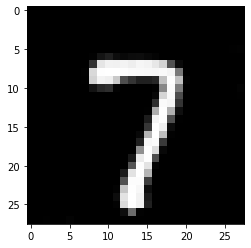

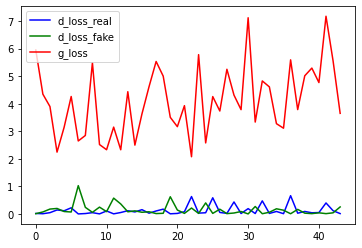

[44/200][0/938] Loss_D: 0.2399 Loss_G: 4.1662 D(x): 0.9518 D(G(z)): 0.1420 / 0.0499
[44/200][100/938] Loss_D: 0.2426 Loss_G: 5.0119 D(x): 0.8285 D(G(z)): 0.0199 / 0.0207
[44/200][200/938] Loss_D: 0.1008 Loss_G: 3.9242 D(x): 0.9522 D(G(z)): 0.0436 / 0.0572
[44/200][300/938] Loss_D: 0.2093 Loss_G: 3.0478 D(x): 0.8747 D(G(z)): 0.0493 / 0.1071
[44/200][400/938] Loss_D: 0.2916 Loss_G: 5.8251 D(x): 0.7971 D(G(z)): 0.0095 / 0.0120
[44/200][500/938] Loss_D: 0.2493 Loss_G: 4.2935 D(x): 0.8348 D(G(z)): 0.0213 / 0.0524
[44/200][600/938] Loss_D: 0.3690 Loss_G: 3.1785 D(x): 0.9296 D(G(z)): 0.2214 / 0.0944
[44/200][700/938] Loss_D: 0.1644 Loss_G: 5.5467 D(x): 0.9099 D(G(z)): 0.0413 / 0.0207
[44/200][800/938] Loss_D: 0.1346 Loss_G: 4.7702 D(x): 0.9266 D(G(z)): 0.0407 / 0.0350
[44/200][900/938] Loss_D: 0.1712 Loss_G: 3.1986 D(x): 0.9311 D(G(z)): 0.0756 / 0.0849


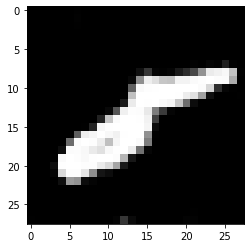

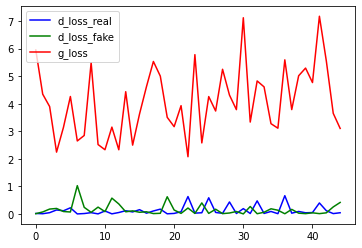

[45/200][0/938] Loss_D: 0.1294 Loss_G: 4.1433 D(x): 0.9800 D(G(z)): 0.0958 / 0.0334
[45/200][100/938] Loss_D: 0.1553 Loss_G: 4.6143 D(x): 0.9154 D(G(z)): 0.0515 / 0.0284
[45/200][200/938] Loss_D: 0.2270 Loss_G: 5.2597 D(x): 0.8355 D(G(z)): 0.0150 / 0.0224
[45/200][300/938] Loss_D: 0.1190 Loss_G: 4.2543 D(x): 0.9457 D(G(z)): 0.0533 / 0.0415
[45/200][400/938] Loss_D: 0.2009 Loss_G: 4.4803 D(x): 0.8839 D(G(z)): 0.0457 / 0.0367
[45/200][500/938] Loss_D: 0.4285 Loss_G: 7.5395 D(x): 0.7336 D(G(z)): 0.0036 / 0.0014
[45/200][600/938] Loss_D: 0.4719 Loss_G: 5.7606 D(x): 0.6955 D(G(z)): 0.0192 / 0.0155
[45/200][700/938] Loss_D: 0.1481 Loss_G: 7.7502 D(x): 0.8812 D(G(z)): 0.0047 / 0.0020
[45/200][800/938] Loss_D: 0.1049 Loss_G: 3.6124 D(x): 0.9775 D(G(z)): 0.0627 / 0.0773
[45/200][900/938] Loss_D: 0.2911 Loss_G: 6.3002 D(x): 0.7879 D(G(z)): 0.0097 / 0.0129


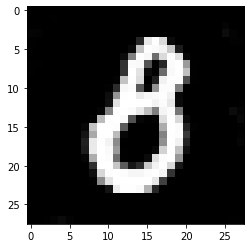

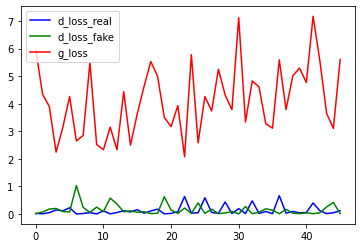

[46/200][0/938] Loss_D: 0.0728 Loss_G: 5.1404 D(x): 0.9655 D(G(z)): 0.0321 / 0.0237
[46/200][100/938] Loss_D: 0.1766 Loss_G: 3.5737 D(x): 0.9508 D(G(z)): 0.0962 / 0.0731
[46/200][200/938] Loss_D: 0.0572 Loss_G: 4.6304 D(x): 0.9809 D(G(z)): 0.0351 / 0.0276
[46/200][300/938] Loss_D: 0.1956 Loss_G: 3.3363 D(x): 0.9786 D(G(z)): 0.1319 / 0.0918
[46/200][400/938] Loss_D: 0.2835 Loss_G: 2.5140 D(x): 0.9292 D(G(z)): 0.1466 / 0.1722
[46/200][500/938] Loss_D: 0.0866 Loss_G: 5.2574 D(x): 0.9697 D(G(z)): 0.0496 / 0.0213
[46/200][600/938] Loss_D: 0.1017 Loss_G: 3.4809 D(x): 0.9483 D(G(z)): 0.0337 / 0.0954
[46/200][700/938] Loss_D: 0.1092 Loss_G: 3.7285 D(x): 0.9909 D(G(z)): 0.0839 / 0.0686
[46/200][800/938] Loss_D: 0.1372 Loss_G: 4.9376 D(x): 0.9183 D(G(z)): 0.0282 / 0.0273
[46/200][900/938] Loss_D: 0.3953 Loss_G: 5.8336 D(x): 0.7463 D(G(z)): 0.0039 / 0.0105


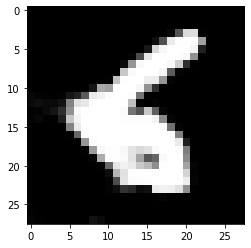

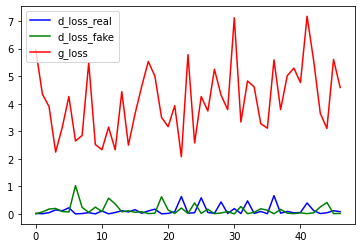

[47/200][0/938] Loss_D: 0.1843 Loss_G: 1.8923 D(x): 0.9720 D(G(z)): 0.1275 / 0.2624
[47/200][100/938] Loss_D: 0.4733 Loss_G: 5.5072 D(x): 0.6986 D(G(z)): 0.0213 / 0.0241
[47/200][200/938] Loss_D: 0.4415 Loss_G: 5.6358 D(x): 0.7115 D(G(z)): 0.0049 / 0.0120
[47/200][300/938] Loss_D: 0.3833 Loss_G: 3.5863 D(x): 0.9954 D(G(z)): 0.2618 / 0.0702
[47/200][400/938] Loss_D: 0.0579 Loss_G: 6.1421 D(x): 0.9564 D(G(z)): 0.0112 / 0.0067
[47/200][500/938] Loss_D: 0.0876 Loss_G: 5.7111 D(x): 0.9460 D(G(z)): 0.0253 / 0.0109
[47/200][600/938] Loss_D: 0.0738 Loss_G: 4.3446 D(x): 0.9820 D(G(z)): 0.0488 / 0.0374
[47/200][700/938] Loss_D: 0.2048 Loss_G: 4.3166 D(x): 0.8974 D(G(z)): 0.0730 / 0.0519
[47/200][800/938] Loss_D: 0.1177 Loss_G: 3.6383 D(x): 0.9732 D(G(z)): 0.0703 / 0.0835
[47/200][900/938] Loss_D: 0.0981 Loss_G: 4.5355 D(x): 0.9403 D(G(z)): 0.0289 / 0.0347


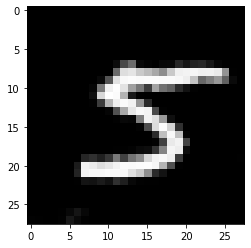

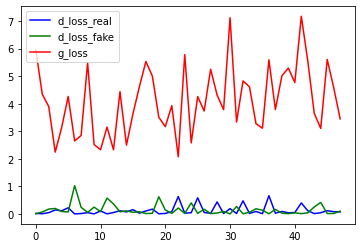

[48/200][0/938] Loss_D: 0.2359 Loss_G: 4.1171 D(x): 0.8692 D(G(z)): 0.0612 / 0.0559
[48/200][100/938] Loss_D: 0.1407 Loss_G: 4.8737 D(x): 0.8964 D(G(z)): 0.0191 / 0.0267
[48/200][200/938] Loss_D: 0.0673 Loss_G: 4.6806 D(x): 0.9659 D(G(z)): 0.0283 / 0.0324
[48/200][300/938] Loss_D: 0.2925 Loss_G: 2.7433 D(x): 0.9886 D(G(z)): 0.1930 / 0.1482
[48/200][400/938] Loss_D: 0.2133 Loss_G: 3.3659 D(x): 0.9184 D(G(z)): 0.1040 / 0.0836
[48/200][500/938] Loss_D: 0.1569 Loss_G: 3.9474 D(x): 0.8981 D(G(z)): 0.0379 / 0.0548
[48/200][600/938] Loss_D: 0.1129 Loss_G: 5.0055 D(x): 0.9275 D(G(z)): 0.0290 / 0.0193
[48/200][700/938] Loss_D: 0.1625 Loss_G: 4.3245 D(x): 0.9630 D(G(z)): 0.0983 / 0.0491
[48/200][800/938] Loss_D: 0.0656 Loss_G: 6.3274 D(x): 0.9596 D(G(z)): 0.0203 / 0.0065
[48/200][900/938] Loss_D: 0.2869 Loss_G: 4.4503 D(x): 0.7904 D(G(z)): 0.0074 / 0.0236


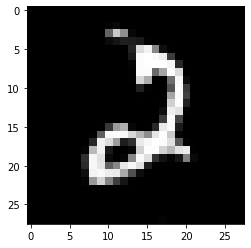

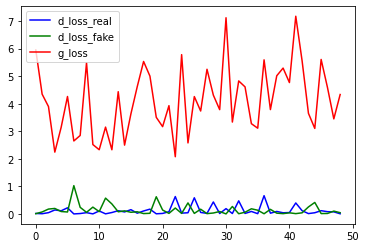

[49/200][0/938] Loss_D: 0.1330 Loss_G: 4.1320 D(x): 0.9116 D(G(z)): 0.0297 / 0.0325
[49/200][100/938] Loss_D: 0.0834 Loss_G: 4.8497 D(x): 0.9840 D(G(z)): 0.0594 / 0.0238
[49/200][200/938] Loss_D: 0.1114 Loss_G: 3.0503 D(x): 0.9796 D(G(z)): 0.0789 / 0.1247
[49/200][300/938] Loss_D: 0.1116 Loss_G: 3.0804 D(x): 0.9892 D(G(z)): 0.0841 / 0.1084
[49/200][400/938] Loss_D: 0.0571 Loss_G: 4.5270 D(x): 0.9698 D(G(z)): 0.0241 / 0.0287
[49/200][500/938] Loss_D: 0.7826 Loss_G: 2.4560 D(x): 0.9897 D(G(z)): 0.4234 / 0.1735
[49/200][600/938] Loss_D: 0.3168 Loss_G: 6.1568 D(x): 0.7849 D(G(z)): 0.0167 / 0.0123
[49/200][700/938] Loss_D: 0.1817 Loss_G: 3.0656 D(x): 0.9832 D(G(z)): 0.1298 / 0.1090
[49/200][800/938] Loss_D: 0.0814 Loss_G: 5.3364 D(x): 0.9442 D(G(z)): 0.0141 / 0.0160
[49/200][900/938] Loss_D: 0.7411 Loss_G: 2.0689 D(x): 0.9324 D(G(z)): 0.3858 / 0.2224


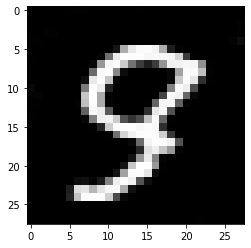

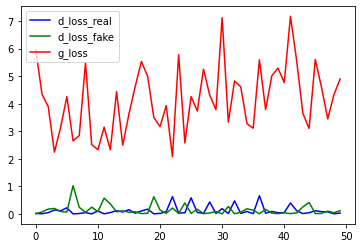

[50/200][0/938] Loss_D: 0.1317 Loss_G: 6.2051 D(x): 0.8968 D(G(z)): 0.0117 / 0.0077
[50/200][100/938] Loss_D: 0.1770 Loss_G: 3.0052 D(x): 0.9490 D(G(z)): 0.1023 / 0.1252
[50/200][200/938] Loss_D: 0.2058 Loss_G: 2.8921 D(x): 0.9571 D(G(z)): 0.1262 / 0.1285
[50/200][300/938] Loss_D: 0.1069 Loss_G: 4.1964 D(x): 0.9607 D(G(z)): 0.0580 / 0.0482
[50/200][400/938] Loss_D: 0.0813 Loss_G: 4.2841 D(x): 0.9425 D(G(z)): 0.0177 / 0.0406
[50/200][500/938] Loss_D: 0.1065 Loss_G: 4.2432 D(x): 0.9868 D(G(z)): 0.0781 / 0.0371
[50/200][600/938] Loss_D: 0.0447 Loss_G: 6.8584 D(x): 0.9624 D(G(z)): 0.0032 / 0.0029
[50/200][700/938] Loss_D: 0.1469 Loss_G: 3.3423 D(x): 0.9303 D(G(z)): 0.0567 / 0.0823
[50/200][800/938] Loss_D: 0.1886 Loss_G: 4.1621 D(x): 0.9453 D(G(z)): 0.1064 / 0.0366
[50/200][900/938] Loss_D: 0.1263 Loss_G: 4.3729 D(x): 0.9126 D(G(z)): 0.0231 / 0.0320


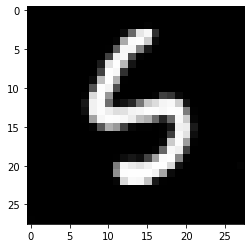

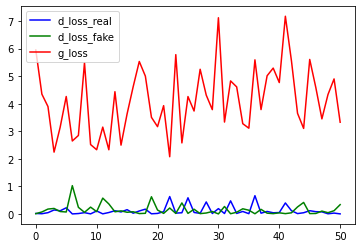

[51/200][0/938] Loss_D: 0.0920 Loss_G: 5.2963 D(x): 0.9921 D(G(z)): 0.0696 / 0.0196
[51/200][100/938] Loss_D: 0.2850 Loss_G: 2.2717 D(x): 0.9766 D(G(z)): 0.1741 / 0.2151
[51/200][200/938] Loss_D: 0.1831 Loss_G: 4.9057 D(x): 0.9689 D(G(z)): 0.1186 / 0.0235
[51/200][300/938] Loss_D: 0.1809 Loss_G: 4.7264 D(x): 0.8697 D(G(z)): 0.0177 / 0.0271
[51/200][400/938] Loss_D: 0.0479 Loss_G: 5.2352 D(x): 0.9715 D(G(z)): 0.0163 / 0.0206
[51/200][500/938] Loss_D: 0.4243 Loss_G: 3.2834 D(x): 0.9872 D(G(z)): 0.2716 / 0.0860
[51/200][600/938] Loss_D: 0.1051 Loss_G: 5.9727 D(x): 0.9490 D(G(z)): 0.0397 / 0.0136
[51/200][700/938] Loss_D: 0.0741 Loss_G: 4.3298 D(x): 0.9805 D(G(z)): 0.0468 / 0.0440
[51/200][800/938] Loss_D: 0.2511 Loss_G: 4.6507 D(x): 0.8248 D(G(z)): 0.0296 / 0.0341
[51/200][900/938] Loss_D: 0.1512 Loss_G: 3.6123 D(x): 0.9828 D(G(z)): 0.1083 / 0.0823


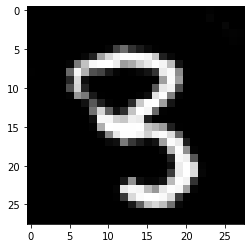

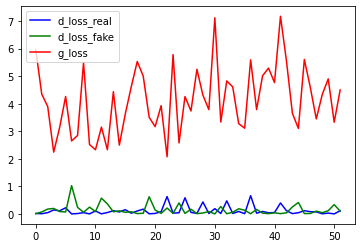

[52/200][0/938] Loss_D: 0.2255 Loss_G: 6.0067 D(x): 0.8326 D(G(z)): 0.0051 / 0.0058
[52/200][100/938] Loss_D: 0.0847 Loss_G: 3.3074 D(x): 0.9877 D(G(z)): 0.0643 / 0.0840
[52/200][200/938] Loss_D: 0.4176 Loss_G: 2.7629 D(x): 0.7651 D(G(z)): 0.0812 / 0.1283
[52/200][300/938] Loss_D: 0.0966 Loss_G: 3.1157 D(x): 0.9910 D(G(z)): 0.0753 / 0.0920
[52/200][400/938] Loss_D: 0.0778 Loss_G: 5.2771 D(x): 0.9544 D(G(z)): 0.0266 / 0.0181
[52/200][500/938] Loss_D: 0.1874 Loss_G: 5.3153 D(x): 0.8678 D(G(z)): 0.0072 / 0.0131
[52/200][600/938] Loss_D: 0.0867 Loss_G: 4.0279 D(x): 0.9901 D(G(z)): 0.0662 / 0.0467
[52/200][700/938] Loss_D: 0.1648 Loss_G: 4.2129 D(x): 0.9976 D(G(z)): 0.1272 / 0.0461
[52/200][800/938] Loss_D: 0.2744 Loss_G: 5.9637 D(x): 0.8155 D(G(z)): 0.0127 / 0.0141
[52/200][900/938] Loss_D: 0.3845 Loss_G: 4.3414 D(x): 0.7371 D(G(z)): 0.0216 / 0.0439


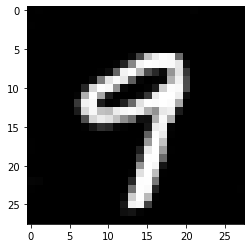

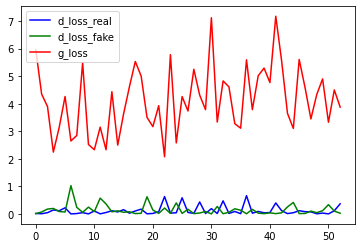

[53/200][0/938] Loss_D: 0.3187 Loss_G: 2.3109 D(x): 0.9958 D(G(z)): 0.2123 / 0.1902
[53/200][100/938] Loss_D: 0.1556 Loss_G: 4.9981 D(x): 0.9104 D(G(z)): 0.0453 / 0.0342
[53/200][200/938] Loss_D: 0.4148 Loss_G: 6.8189 D(x): 0.7383 D(G(z)): 0.0022 / 0.0063
[53/200][300/938] Loss_D: 0.0692 Loss_G: 4.4362 D(x): 0.9766 D(G(z)): 0.0410 / 0.0384
[53/200][400/938] Loss_D: 0.2130 Loss_G: 4.4811 D(x): 0.8533 D(G(z)): 0.0177 / 0.0284
[53/200][500/938] Loss_D: 0.2384 Loss_G: 5.9181 D(x): 0.8206 D(G(z)): 0.0109 / 0.0088
[53/200][600/938] Loss_D: 0.0952 Loss_G: 4.2342 D(x): 0.9789 D(G(z)): 0.0658 / 0.0366
[53/200][700/938] Loss_D: 0.1321 Loss_G: 5.9356 D(x): 0.9132 D(G(z)): 0.0290 / 0.0100
[53/200][800/938] Loss_D: 0.0361 Loss_G: 5.4545 D(x): 0.9853 D(G(z)): 0.0199 / 0.0138
[53/200][900/938] Loss_D: 0.1710 Loss_G: 4.7532 D(x): 0.9591 D(G(z)): 0.1001 / 0.0298


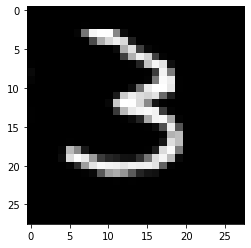

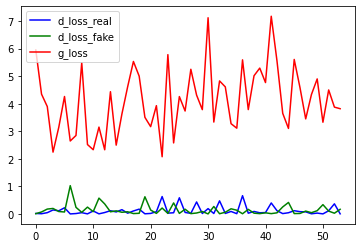

[54/200][0/938] Loss_D: 0.2328 Loss_G: 3.6992 D(x): 0.9973 D(G(z)): 0.1552 / 0.0719
[54/200][100/938] Loss_D: 0.1036 Loss_G: 5.4482 D(x): 0.9257 D(G(z)): 0.0151 / 0.0109
[54/200][200/938] Loss_D: 0.1178 Loss_G: 3.8395 D(x): 0.9479 D(G(z)): 0.0526 / 0.0626
[54/200][300/938] Loss_D: 0.2556 Loss_G: 7.2065 D(x): 0.8158 D(G(z)): 0.0071 / 0.0036
[54/200][400/938] Loss_D: 0.1180 Loss_G: 3.7658 D(x): 0.9934 D(G(z)): 0.0625 / 0.0712
[54/200][500/938] Loss_D: 0.1700 Loss_G: 2.9359 D(x): 0.9973 D(G(z)): 0.1294 / 0.1314
[54/200][600/938] Loss_D: 0.0607 Loss_G: 6.4058 D(x): 0.9564 D(G(z)): 0.0123 / 0.0056
[54/200][700/938] Loss_D: 0.2993 Loss_G: 6.5977 D(x): 0.7955 D(G(z)): 0.0076 / 0.0100
[54/200][800/938] Loss_D: 0.2553 Loss_G: 3.8629 D(x): 0.8597 D(G(z)): 0.0635 / 0.0523
[54/200][900/938] Loss_D: 0.0665 Loss_G: 5.5462 D(x): 0.9651 D(G(z)): 0.0249 / 0.0209


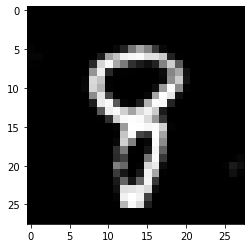

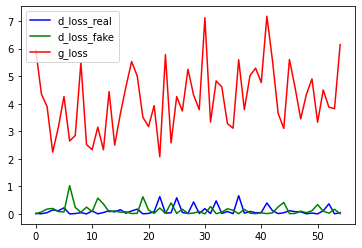

[55/200][0/938] Loss_D: 0.1138 Loss_G: 6.6467 D(x): 0.9135 D(G(z)): 0.0060 / 0.0041
[55/200][100/938] Loss_D: 0.2001 Loss_G: 3.4246 D(x): 0.9678 D(G(z)): 0.1251 / 0.0925
[55/200][200/938] Loss_D: 0.0721 Loss_G: 4.8780 D(x): 0.9686 D(G(z)): 0.0345 / 0.0415
[55/200][300/938] Loss_D: 0.2370 Loss_G: 2.8826 D(x): 0.9987 D(G(z)): 0.1731 / 0.1023
[55/200][400/938] Loss_D: 0.0828 Loss_G: 5.0241 D(x): 0.9769 D(G(z)): 0.0527 / 0.0183
[55/200][500/938] Loss_D: 0.3072 Loss_G: 2.7301 D(x): 0.9958 D(G(z)): 0.2186 / 0.1415
[55/200][600/938] Loss_D: 0.1769 Loss_G: 3.0681 D(x): 0.9390 D(G(z)): 0.0861 / 0.1113
[55/200][700/938] Loss_D: 0.0665 Loss_G: 5.7578 D(x): 0.9585 D(G(z)): 0.0189 / 0.0106
[55/200][800/938] Loss_D: 0.5338 Loss_G: 3.5722 D(x): 0.6877 D(G(z)): 0.0400 / 0.0971
[55/200][900/938] Loss_D: 0.1159 Loss_G: 3.3965 D(x): 0.9814 D(G(z)): 0.0740 / 0.0950


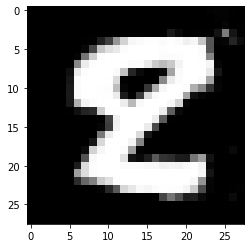

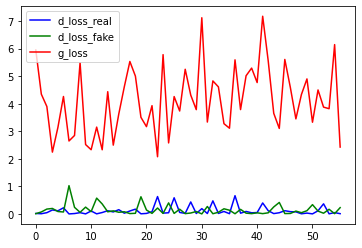

[56/200][0/938] Loss_D: 1.1527 Loss_G: 1.9266 D(x): 0.9878 D(G(z)): 0.5170 / 0.2900
[56/200][100/938] Loss_D: 0.1407 Loss_G: 3.8696 D(x): 0.9360 D(G(z)): 0.0515 / 0.0788
[56/200][200/938] Loss_D: 0.2548 Loss_G: 3.2164 D(x): 0.9399 D(G(z)): 0.1495 / 0.0907
[56/200][300/938] Loss_D: 0.1101 Loss_G: 4.4105 D(x): 0.9756 D(G(z)): 0.0755 / 0.0300
[56/200][400/938] Loss_D: 0.0976 Loss_G: 5.5125 D(x): 0.9314 D(G(z)): 0.0147 / 0.0179
[56/200][500/938] Loss_D: 0.0697 Loss_G: 6.3040 D(x): 0.9498 D(G(z)): 0.0150 / 0.0077
[56/200][600/938] Loss_D: 0.1693 Loss_G: 6.0472 D(x): 0.8917 D(G(z)): 0.0180 / 0.0074
[56/200][700/938] Loss_D: 0.1225 Loss_G: 3.6412 D(x): 0.9355 D(G(z)): 0.0453 / 0.0760
[56/200][800/938] Loss_D: 0.0789 Loss_G: 4.7306 D(x): 0.9770 D(G(z)): 0.0498 / 0.0229
[56/200][900/938] Loss_D: 0.1857 Loss_G: 3.6266 D(x): 0.8864 D(G(z)): 0.0473 / 0.0632


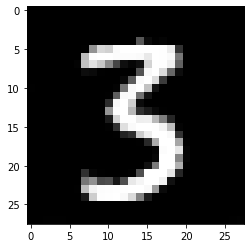

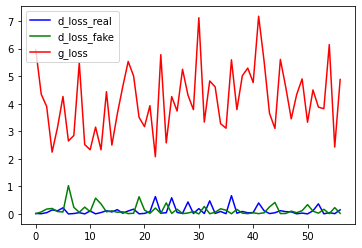

[57/200][0/938] Loss_D: 0.1704 Loss_G: 3.3647 D(x): 0.9732 D(G(z)): 0.1158 / 0.0969
[57/200][100/938] Loss_D: 0.2171 Loss_G: 3.9442 D(x): 0.9751 D(G(z)): 0.1484 / 0.0617
[57/200][200/938] Loss_D: 0.1811 Loss_G: 4.1500 D(x): 0.9359 D(G(z)): 0.0856 / 0.0523
[57/200][300/938] Loss_D: 0.3359 Loss_G: 2.3899 D(x): 0.9590 D(G(z)): 0.1941 / 0.1644
[57/200][400/938] Loss_D: 0.1844 Loss_G: 4.4933 D(x): 0.9547 D(G(z)): 0.1006 / 0.0434
[57/200][500/938] Loss_D: 0.1380 Loss_G: 4.6306 D(x): 0.9016 D(G(z)): 0.0213 / 0.0287
[57/200][600/938] Loss_D: 0.0576 Loss_G: 5.0161 D(x): 0.9613 D(G(z)): 0.0146 / 0.0241
[57/200][700/938] Loss_D: 0.1573 Loss_G: 3.8423 D(x): 0.9069 D(G(z)): 0.0455 / 0.0555
[57/200][800/938] Loss_D: 0.1774 Loss_G: 3.9234 D(x): 0.9456 D(G(z)): 0.0927 / 0.0547
[57/200][900/938] Loss_D: 0.0935 Loss_G: 4.4712 D(x): 0.9727 D(G(z)): 0.0558 / 0.0345


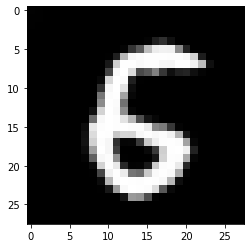

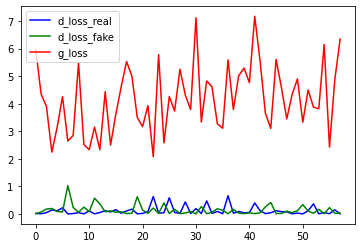

[58/200][0/938] Loss_D: 0.0937 Loss_G: 5.1246 D(x): 0.9919 D(G(z)): 0.0573 / 0.0254
[58/200][100/938] Loss_D: 0.0644 Loss_G: 3.8023 D(x): 0.9878 D(G(z)): 0.0470 / 0.0605
[58/200][200/938] Loss_D: 0.0171 Loss_G: 7.9607 D(x): 0.9860 D(G(z)): 0.0028 / 0.0015
[58/200][300/938] Loss_D: 0.1657 Loss_G: 3.3043 D(x): 0.9454 D(G(z)): 0.0862 / 0.1103
[58/200][400/938] Loss_D: 0.1180 Loss_G: 5.1904 D(x): 0.9555 D(G(z)): 0.0495 / 0.0280
[58/200][500/938] Loss_D: 0.1411 Loss_G: 3.7257 D(x): 0.9780 D(G(z)): 0.1006 / 0.0739
[58/200][600/938] Loss_D: 0.0985 Loss_G: 3.4816 D(x): 0.9678 D(G(z)): 0.0471 / 0.0888
[58/200][700/938] Loss_D: 0.1888 Loss_G: 5.7868 D(x): 0.9522 D(G(z)): 0.1015 / 0.0155
[58/200][800/938] Loss_D: 0.1465 Loss_G: 3.3305 D(x): 0.9389 D(G(z)): 0.0716 / 0.0915
[58/200][900/938] Loss_D: 0.5766 Loss_G: 3.4056 D(x): 0.9622 D(G(z)): 0.2980 / 0.1061


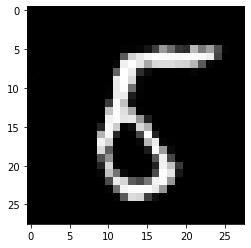

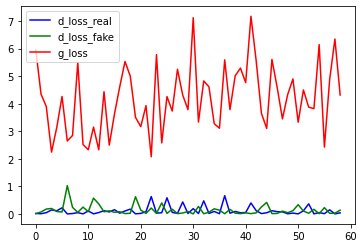

[59/200][0/938] Loss_D: 0.0756 Loss_G: 5.9352 D(x): 0.9481 D(G(z)): 0.0181 / 0.0090
[59/200][100/938] Loss_D: 0.0634 Loss_G: 5.5261 D(x): 0.9662 D(G(z)): 0.0263 / 0.0122
[59/200][200/938] Loss_D: 0.1009 Loss_G: 4.0869 D(x): 0.9870 D(G(z)): 0.0735 / 0.0556
[59/200][300/938] Loss_D: 0.2782 Loss_G: 4.0868 D(x): 0.8013 D(G(z)): 0.0191 / 0.0481
[59/200][400/938] Loss_D: 0.0609 Loss_G: 5.7854 D(x): 0.9579 D(G(z)): 0.0149 / 0.0142
[59/200][500/938] Loss_D: 0.0940 Loss_G: 5.1961 D(x): 0.9555 D(G(z)): 0.0399 / 0.0197
[59/200][600/938] Loss_D: 0.1532 Loss_G: 3.5207 D(x): 0.9381 D(G(z)): 0.0748 / 0.0730
[59/200][700/938] Loss_D: 0.1255 Loss_G: 5.3348 D(x): 0.9152 D(G(z)): 0.0245 / 0.0187
[59/200][800/938] Loss_D: 0.3487 Loss_G: 3.7200 D(x): 0.9870 D(G(z)): 0.2210 / 0.0677
[59/200][900/938] Loss_D: 0.1534 Loss_G: 4.3246 D(x): 0.9919 D(G(z)): 0.0889 / 0.0516


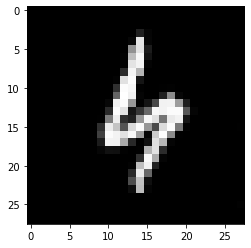

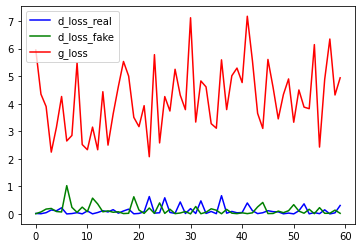

[60/200][0/938] Loss_D: 0.0375 Loss_G: 5.3067 D(x): 0.9835 D(G(z)): 0.0197 / 0.0189
[60/200][100/938] Loss_D: 0.2868 Loss_G: 4.1594 D(x): 0.8123 D(G(z)): 0.0221 / 0.0541
[60/200][200/938] Loss_D: 0.1823 Loss_G: 3.5734 D(x): 0.9498 D(G(z)): 0.1021 / 0.0801
[60/200][300/938] Loss_D: 0.4583 Loss_G: 3.3848 D(x): 0.9576 D(G(z)): 0.2809 / 0.0772
[60/200][400/938] Loss_D: 0.1012 Loss_G: 4.2421 D(x): 0.9700 D(G(z)): 0.0597 / 0.0410
[60/200][500/938] Loss_D: 0.0780 Loss_G: 5.7479 D(x): 0.9520 D(G(z)): 0.0223 / 0.0100
[60/200][600/938] Loss_D: 0.2254 Loss_G: 4.1959 D(x): 0.8464 D(G(z)): 0.0321 / 0.0377
[60/200][700/938] Loss_D: 0.2008 Loss_G: 2.6168 D(x): 0.9625 D(G(z)): 0.1173 / 0.1509
[60/200][800/938] Loss_D: 0.4116 Loss_G: 2.6187 D(x): 0.9903 D(G(z)): 0.2631 / 0.1593
[60/200][900/938] Loss_D: 0.0825 Loss_G: 4.2226 D(x): 0.9792 D(G(z)): 0.0522 / 0.0555


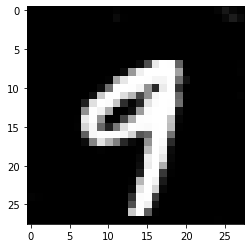

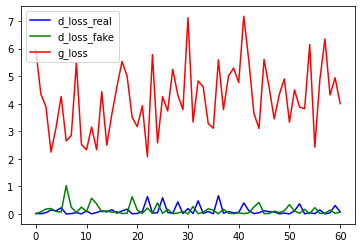

[61/200][0/938] Loss_D: 0.2755 Loss_G: 3.3422 D(x): 0.9929 D(G(z)): 0.1868 / 0.1089
[61/200][100/938] Loss_D: 0.2918 Loss_G: 4.5167 D(x): 0.8187 D(G(z)): 0.0394 / 0.0440
[61/200][200/938] Loss_D: 0.0469 Loss_G: 5.8148 D(x): 0.9622 D(G(z)): 0.0067 / 0.0080
[61/200][300/938] Loss_D: 0.1012 Loss_G: 5.2480 D(x): 0.9336 D(G(z)): 0.0231 / 0.0204
[61/200][400/938] Loss_D: 0.0739 Loss_G: 4.6818 D(x): 0.9890 D(G(z)): 0.0510 / 0.0307
[61/200][500/938] Loss_D: 0.4884 Loss_G: 3.0785 D(x): 0.7116 D(G(z)): 0.0301 / 0.1146
[61/200][600/938] Loss_D: 0.2466 Loss_G: 4.3899 D(x): 0.8513 D(G(z)): 0.0501 / 0.0382
[61/200][700/938] Loss_D: 0.1224 Loss_G: 4.3338 D(x): 0.9581 D(G(z)): 0.0657 / 0.0384
[61/200][800/938] Loss_D: 0.7793 Loss_G: 4.6539 D(x): 0.6131 D(G(z)): 0.0247 / 0.0277
[61/200][900/938] Loss_D: 0.2680 Loss_G: 6.5057 D(x): 0.8189 D(G(z)): 0.0074 / 0.0072


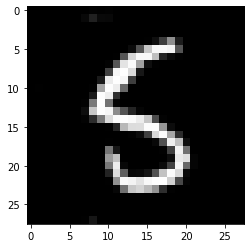

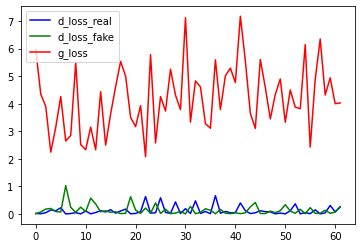

[62/200][0/938] Loss_D: 0.1204 Loss_G: 5.8507 D(x): 0.9136 D(G(z)): 0.0228 / 0.0091
[62/200][100/938] Loss_D: 0.2465 Loss_G: 5.7674 D(x): 0.8376 D(G(z)): 0.0121 / 0.0163
[62/200][200/938] Loss_D: 0.3343 Loss_G: 4.0471 D(x): 0.7890 D(G(z)): 0.0643 / 0.0542
[62/200][300/938] Loss_D: 0.1217 Loss_G: 3.1092 D(x): 0.9773 D(G(z)): 0.0822 / 0.1127
[62/200][400/938] Loss_D: 0.1300 Loss_G: 4.2655 D(x): 0.9638 D(G(z)): 0.0795 / 0.0403
[62/200][500/938] Loss_D: 0.8156 Loss_G: 6.4615 D(x): 0.5569 D(G(z)): 0.0033 / 0.0079
[62/200][600/938] Loss_D: 0.0648 Loss_G: 5.1220 D(x): 0.9649 D(G(z)): 0.0236 / 0.0183
[62/200][700/938] Loss_D: 0.1238 Loss_G: 4.5417 D(x): 0.9823 D(G(z)): 0.0655 / 0.0409
[62/200][800/938] Loss_D: 0.1153 Loss_G: 5.5190 D(x): 0.9114 D(G(z)): 0.0116 / 0.0135
[62/200][900/938] Loss_D: 0.1141 Loss_G: 6.2863 D(x): 0.9185 D(G(z)): 0.0098 / 0.0121


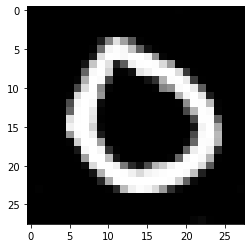

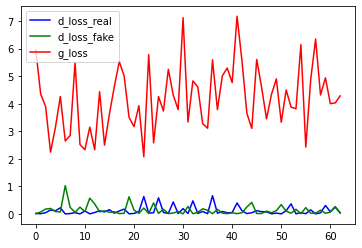

[63/200][0/938] Loss_D: 0.0792 Loss_G: 4.6000 D(x): 0.9876 D(G(z)): 0.0477 / 0.0403
[63/200][100/938] Loss_D: 0.0789 Loss_G: 5.0349 D(x): 0.9430 D(G(z)): 0.0140 / 0.0192
[63/200][200/938] Loss_D: 0.1892 Loss_G: 4.0578 D(x): 0.8617 D(G(z)): 0.0290 / 0.0456
[63/200][300/938] Loss_D: 0.2935 Loss_G: 3.0087 D(x): 0.9962 D(G(z)): 0.2095 / 0.1097
[63/200][400/938] Loss_D: 0.0665 Loss_G: 2.6849 D(x): 0.9938 D(G(z)): 0.0520 / 0.1499
[63/200][500/938] Loss_D: 0.2771 Loss_G: 3.2346 D(x): 0.9861 D(G(z)): 0.1862 / 0.0892
[63/200][600/938] Loss_D: 0.0746 Loss_G: 3.8109 D(x): 0.9571 D(G(z)): 0.0252 / 0.0736
[63/200][700/938] Loss_D: 1.1038 Loss_G: 1.4594 D(x): 0.9790 D(G(z)): 0.5127 / 0.3563
[63/200][800/938] Loss_D: 0.6832 Loss_G: 2.0185 D(x): 0.9823 D(G(z)): 0.3410 / 0.2523
[63/200][900/938] Loss_D: 0.1243 Loss_G: 5.4141 D(x): 0.9214 D(G(z)): 0.0139 / 0.0149


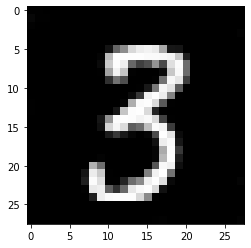

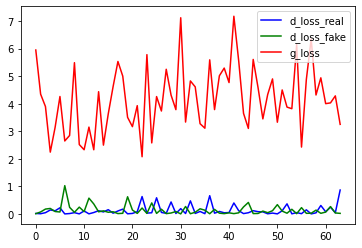

[64/200][0/938] Loss_D: 0.2085 Loss_G: 1.7954 D(x): 0.9587 D(G(z)): 0.1322 / 0.3123
[64/200][100/938] Loss_D: 0.1748 Loss_G: 5.5725 D(x): 0.8743 D(G(z)): 0.0228 / 0.0161
[64/200][200/938] Loss_D: 0.0496 Loss_G: 4.0753 D(x): 0.9962 D(G(z)): 0.0402 / 0.0501
[64/200][300/938] Loss_D: 0.0957 Loss_G: 6.0026 D(x): 0.9296 D(G(z)): 0.0158 / 0.0104
[64/200][400/938] Loss_D: 0.2297 Loss_G: 4.4444 D(x): 0.8457 D(G(z)): 0.0313 / 0.0330
[64/200][500/938] Loss_D: 0.1657 Loss_G: 3.6675 D(x): 0.9773 D(G(z)): 0.1060 / 0.0861
[64/200][600/938] Loss_D: 0.1084 Loss_G: 4.7163 D(x): 0.9264 D(G(z)): 0.0228 / 0.0320
[64/200][700/938] Loss_D: 0.1217 Loss_G: 6.5356 D(x): 0.9046 D(G(z)): 0.0124 / 0.0049
[64/200][800/938] Loss_D: 0.2477 Loss_G: 6.8291 D(x): 0.8076 D(G(z)): 0.0043 / 0.0041
[64/200][900/938] Loss_D: 0.0561 Loss_G: 3.8977 D(x): 0.9743 D(G(z)): 0.0280 / 0.0643


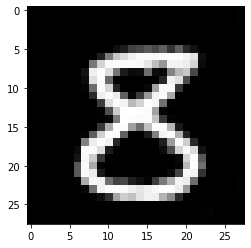

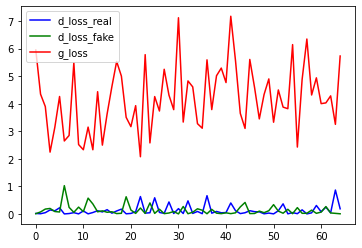

[65/200][0/938] Loss_D: 0.1978 Loss_G: 3.1883 D(x): 0.9619 D(G(z)): 0.1171 / 0.1209
[65/200][100/938] Loss_D: 0.1271 Loss_G: 3.6143 D(x): 0.9922 D(G(z)): 0.0932 / 0.0610
[65/200][200/938] Loss_D: 0.6094 Loss_G: 2.8323 D(x): 0.9813 D(G(z)): 0.3425 / 0.1289
[65/200][300/938] Loss_D: 0.0982 Loss_G: 4.2790 D(x): 0.9519 D(G(z)): 0.0424 / 0.0375
[65/200][400/938] Loss_D: 0.3152 Loss_G: 3.0950 D(x): 0.9707 D(G(z)): 0.1834 / 0.1200
[65/200][500/938] Loss_D: 0.0770 Loss_G: 4.3813 D(x): 0.9667 D(G(z)): 0.0369 / 0.0405
[65/200][600/938] Loss_D: 0.0420 Loss_G: 5.4036 D(x): 0.9726 D(G(z)): 0.0129 / 0.0199
[65/200][700/938] Loss_D: 0.1128 Loss_G: 4.2504 D(x): 0.9737 D(G(z)): 0.0615 / 0.0848
[65/200][800/938] Loss_D: 0.1225 Loss_G: 4.2278 D(x): 0.9121 D(G(z)): 0.0231 / 0.0445
[65/200][900/938] Loss_D: 0.1968 Loss_G: 8.4941 D(x): 0.8438 D(G(z)): 0.0013 / 0.0010


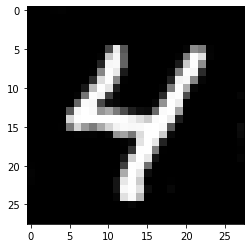

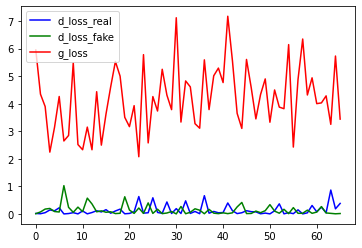

[66/200][0/938] Loss_D: 0.4218 Loss_G: 1.6617 D(x): 0.9810 D(G(z)): 0.2683 / 0.3441
[66/200][100/938] Loss_D: 0.0975 Loss_G: 7.5456 D(x): 0.9184 D(G(z)): 0.0038 / 0.0026
[66/200][200/938] Loss_D: 0.0279 Loss_G: 5.8975 D(x): 0.9782 D(G(z)): 0.0053 / 0.0075
[66/200][300/938] Loss_D: 0.1740 Loss_G: 2.6408 D(x): 0.9951 D(G(z)): 0.1378 / 0.1376
[66/200][400/938] Loss_D: 0.0593 Loss_G: 5.0416 D(x): 0.9608 D(G(z)): 0.0118 / 0.0207
[66/200][500/938] Loss_D: 0.0393 Loss_G: 5.6574 D(x): 0.9928 D(G(z)): 0.0303 / 0.0126
[66/200][600/938] Loss_D: 0.6180 Loss_G: 2.1996 D(x): 0.9960 D(G(z)): 0.3589 / 0.2123
[66/200][700/938] Loss_D: 0.0473 Loss_G: 4.6918 D(x): 0.9848 D(G(z)): 0.0297 / 0.0272
[66/200][800/938] Loss_D: 0.2025 Loss_G: 3.0482 D(x): 0.9559 D(G(z)): 0.1047 / 0.1286
[66/200][900/938] Loss_D: 0.1472 Loss_G: 4.5963 D(x): 0.9779 D(G(z)): 0.0987 / 0.0354


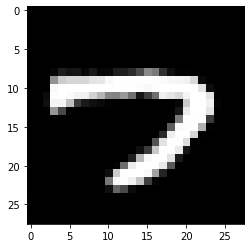

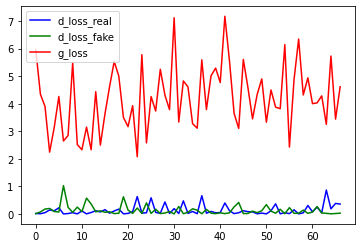

[67/200][0/938] Loss_D: 0.2580 Loss_G: 2.5898 D(x): 0.9266 D(G(z)): 0.1399 / 0.1505
[67/200][100/938] Loss_D: 0.1401 Loss_G: 3.8396 D(x): 0.9987 D(G(z)): 0.1073 / 0.0684
[67/200][200/938] Loss_D: 0.1356 Loss_G: 4.4758 D(x): 0.9672 D(G(z)): 0.0864 / 0.0369
[67/200][300/938] Loss_D: 0.0444 Loss_G: 4.2473 D(x): 0.9892 D(G(z)): 0.0314 / 0.0396
[67/200][400/938] Loss_D: 0.1024 Loss_G: 3.2572 D(x): 0.9448 D(G(z)): 0.0333 / 0.0868
[67/200][500/938] Loss_D: 0.0358 Loss_G: 5.6022 D(x): 0.9789 D(G(z)): 0.0138 / 0.0109
[67/200][600/938] Loss_D: 0.1834 Loss_G: 4.4136 D(x): 0.9009 D(G(z)): 0.0483 / 0.0444
[67/200][700/938] Loss_D: 0.6221 Loss_G: 5.9739 D(x): 0.6054 D(G(z)): 0.0062 / 0.0129
[67/200][800/938] Loss_D: 0.1004 Loss_G: 5.2312 D(x): 0.9530 D(G(z)): 0.0233 / 0.0310
[67/200][900/938] Loss_D: 0.1956 Loss_G: 3.0766 D(x): 0.9988 D(G(z)): 0.1562 / 0.0974


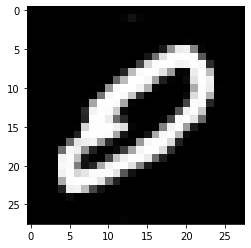

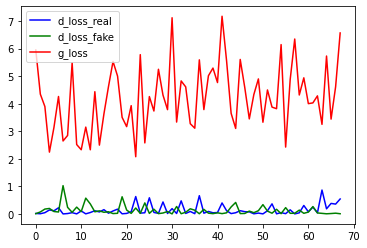

[68/200][0/938] Loss_D: 0.0838 Loss_G: 4.8797 D(x): 0.9561 D(G(z)): 0.0328 / 0.0233
[68/200][100/938] Loss_D: 0.5734 Loss_G: 4.7745 D(x): 0.6627 D(G(z)): 0.0141 / 0.0511
[68/200][200/938] Loss_D: 0.4839 Loss_G: 4.3059 D(x): 0.8490 D(G(z)): 0.1857 / 0.0385
[68/200][300/938] Loss_D: 0.1223 Loss_G: 4.4087 D(x): 0.9852 D(G(z)): 0.0673 / 0.0511
[68/200][400/938] Loss_D: 0.1009 Loss_G: 4.1131 D(x): 0.9698 D(G(z)): 0.0613 / 0.0455
[68/200][500/938] Loss_D: 0.2769 Loss_G: 3.0176 D(x): 0.9695 D(G(z)): 0.1820 / 0.0988
[68/200][600/938] Loss_D: 0.0289 Loss_G: 5.4339 D(x): 0.9955 D(G(z)): 0.0217 / 0.0218
[68/200][700/938] Loss_D: 0.2104 Loss_G: 5.6478 D(x): 0.8721 D(G(z)): 0.0431 / 0.0137
[68/200][800/938] Loss_D: 0.0705 Loss_G: 4.7120 D(x): 0.9637 D(G(z)): 0.0300 / 0.0253
[68/200][900/938] Loss_D: 0.4673 Loss_G: 5.4824 D(x): 0.7144 D(G(z)): 0.0159 / 0.0168


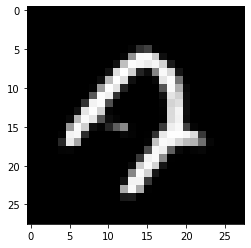

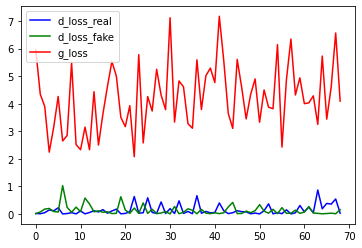

[69/200][0/938] Loss_D: 0.1411 Loss_G: 4.2702 D(x): 0.9990 D(G(z)): 0.1092 / 0.0556
[69/200][100/938] Loss_D: 0.0587 Loss_G: 4.3691 D(x): 0.9928 D(G(z)): 0.0360 / 0.0583
[69/200][200/938] Loss_D: 0.1580 Loss_G: 4.2184 D(x): 0.9856 D(G(z)): 0.1090 / 0.0471
[69/200][300/938] Loss_D: 0.5704 Loss_G: 6.0867 D(x): 0.6626 D(G(z)): 0.0043 / 0.0124
[69/200][400/938] Loss_D: 0.0860 Loss_G: 4.2419 D(x): 0.9602 D(G(z)): 0.0391 / 0.0521
[69/200][500/938] Loss_D: 0.1298 Loss_G: 4.1338 D(x): 0.9589 D(G(z)): 0.0709 / 0.0498
[69/200][600/938] Loss_D: 0.3079 Loss_G: 7.8764 D(x): 0.7886 D(G(z)): 0.0019 / 0.0012
[69/200][700/938] Loss_D: 0.2830 Loss_G: 2.7736 D(x): 0.9631 D(G(z)): 0.1803 / 0.1180
[69/200][800/938] Loss_D: 0.2891 Loss_G: 3.9500 D(x): 0.8343 D(G(z)): 0.0602 / 0.0541
[69/200][900/938] Loss_D: 0.0838 Loss_G: 4.6600 D(x): 0.9850 D(G(z)): 0.0603 / 0.0309


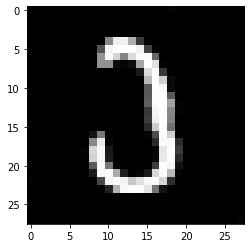

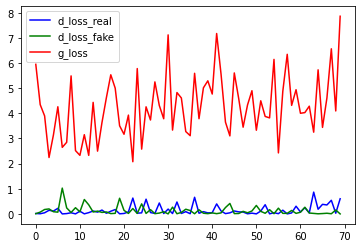

[70/200][0/938] Loss_D: 0.1696 Loss_G: 3.9755 D(x): 0.8866 D(G(z)): 0.0300 / 0.0662
[70/200][100/938] Loss_D: 0.1429 Loss_G: 4.0589 D(x): 0.9852 D(G(z)): 0.0952 / 0.0523
[70/200][200/938] Loss_D: 0.1017 Loss_G: 4.3603 D(x): 0.9966 D(G(z)): 0.0815 / 0.0520
[70/200][300/938] Loss_D: 0.2515 Loss_G: 4.6511 D(x): 0.8371 D(G(z)): 0.0259 / 0.0426
[70/200][400/938] Loss_D: 0.2456 Loss_G: 2.7698 D(x): 0.9970 D(G(z)): 0.1668 / 0.1755
[70/200][500/938] Loss_D: 0.6106 Loss_G: 3.0220 D(x): 0.9951 D(G(z)): 0.3569 / 0.1236
[70/200][600/938] Loss_D: 0.3370 Loss_G: 3.2546 D(x): 0.9790 D(G(z)): 0.2279 / 0.0780
[70/200][700/938] Loss_D: 0.3526 Loss_G: 2.6716 D(x): 0.9303 D(G(z)): 0.1751 / 0.1621
[70/200][800/938] Loss_D: 0.2320 Loss_G: 3.6567 D(x): 0.9851 D(G(z)): 0.1603 / 0.0764
[70/200][900/938] Loss_D: 0.0371 Loss_G: 5.5940 D(x): 0.9774 D(G(z)): 0.0126 / 0.0120


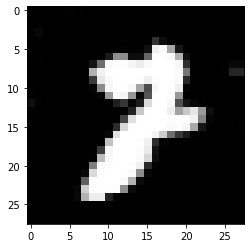

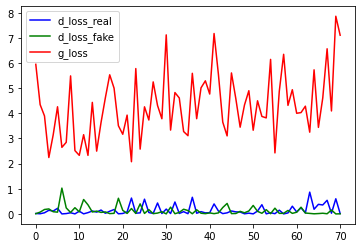

[71/200][0/938] Loss_D: 0.6503 Loss_G: 6.7396 D(x): 0.6112 D(G(z)): 0.0026 / 0.0062
[71/200][100/938] Loss_D: 0.2430 Loss_G: 3.3508 D(x): 0.9790 D(G(z)): 0.1474 / 0.1139
[71/200][200/938] Loss_D: 0.1117 Loss_G: 6.5733 D(x): 0.9122 D(G(z)): 0.0072 / 0.0044
[71/200][300/938] Loss_D: 0.2939 Loss_G: 4.2921 D(x): 0.8348 D(G(z)): 0.0477 / 0.0668
[71/200][400/938] Loss_D: 0.1135 Loss_G: 5.5183 D(x): 0.9147 D(G(z)): 0.0170 / 0.0169
[71/200][500/938] Loss_D: 0.1005 Loss_G: 6.6536 D(x): 0.9252 D(G(z)): 0.0101 / 0.0074
[71/200][600/938] Loss_D: 0.4437 Loss_G: 3.3890 D(x): 0.9680 D(G(z)): 0.2622 / 0.0847
[71/200][700/938] Loss_D: 0.0867 Loss_G: 5.1681 D(x): 0.9553 D(G(z)): 0.0354 / 0.0223
[71/200][800/938] Loss_D: 0.0974 Loss_G: 3.8595 D(x): 0.9569 D(G(z)): 0.0419 / 0.0707
[71/200][900/938] Loss_D: 0.2475 Loss_G: 3.2367 D(x): 0.9265 D(G(z)): 0.1095 / 0.1141


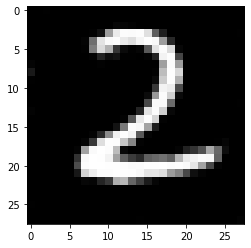

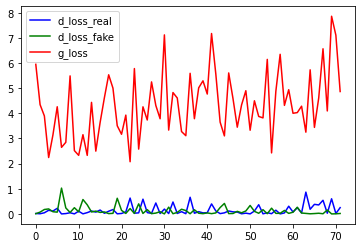

[72/200][0/938] Loss_D: 0.0724 Loss_G: 3.7628 D(x): 0.9856 D(G(z)): 0.0501 / 0.0642
[72/200][100/938] Loss_D: 0.0841 Loss_G: 4.6479 D(x): 0.9631 D(G(z)): 0.0382 / 0.0302
[72/200][200/938] Loss_D: 0.0933 Loss_G: 5.4297 D(x): 0.9321 D(G(z)): 0.0131 / 0.0190
[72/200][300/938] Loss_D: 0.2888 Loss_G: 4.3154 D(x): 0.8693 D(G(z)): 0.0905 / 0.0518
[72/200][400/938] Loss_D: 0.8687 Loss_G: 2.5986 D(x): 0.9674 D(G(z)): 0.4109 / 0.1975
[72/200][500/938] Loss_D: 0.1163 Loss_G: 3.8729 D(x): 0.9826 D(G(z)): 0.0801 / 0.0680
[72/200][600/938] Loss_D: 0.1946 Loss_G: 4.2985 D(x): 0.9350 D(G(z)): 0.0875 / 0.0512
[72/200][700/938] Loss_D: 0.2667 Loss_G: 7.7974 D(x): 0.7966 D(G(z)): 0.0018 / 0.0014
[72/200][800/938] Loss_D: 0.0709 Loss_G: 4.4558 D(x): 0.9877 D(G(z)): 0.0528 / 0.0262
[72/200][900/938] Loss_D: 0.0993 Loss_G: 3.4779 D(x): 0.9702 D(G(z)): 0.0590 / 0.0807


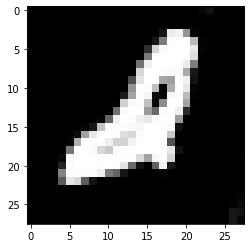

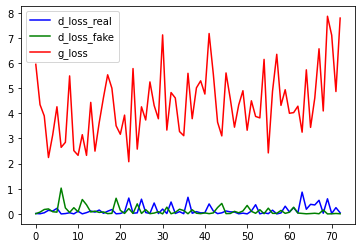

[73/200][0/938] Loss_D: 0.2353 Loss_G: 4.8356 D(x): 0.8726 D(G(z)): 0.0655 / 0.0293
[73/200][100/938] Loss_D: 0.2562 Loss_G: 5.5411 D(x): 0.8338 D(G(z)): 0.0096 / 0.0204
[73/200][200/938] Loss_D: 0.1425 Loss_G: 4.9440 D(x): 0.9134 D(G(z)): 0.0371 / 0.0277
[73/200][300/938] Loss_D: 0.0753 Loss_G: 4.7711 D(x): 0.9636 D(G(z)): 0.0309 / 0.0345
[73/200][400/938] Loss_D: 0.3861 Loss_G: 2.1850 D(x): 0.8948 D(G(z)): 0.1838 / 0.2531
[73/200][500/938] Loss_D: 0.1592 Loss_G: 3.5188 D(x): 0.9429 D(G(z)): 0.0832 / 0.0756
[73/200][600/938] Loss_D: 0.1955 Loss_G: 2.7278 D(x): 0.9850 D(G(z)): 0.1328 / 0.2079
[73/200][700/938] Loss_D: 0.2857 Loss_G: 3.7194 D(x): 0.8183 D(G(z)): 0.0365 / 0.0817
[73/200][800/938] Loss_D: 0.0582 Loss_G: 4.5634 D(x): 0.9631 D(G(z)): 0.0164 / 0.0379
[73/200][900/938] Loss_D: 0.0375 Loss_G: 6.7970 D(x): 0.9691 D(G(z)): 0.0042 / 0.0044


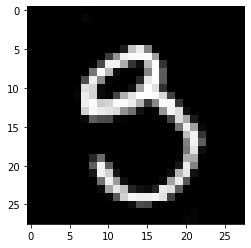

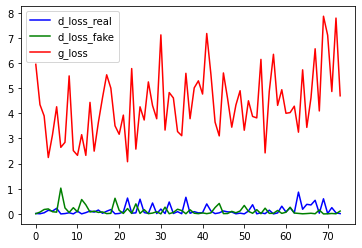

[74/200][0/938] Loss_D: 0.2159 Loss_G: 4.9482 D(x): 0.9950 D(G(z)): 0.1549 / 0.0236
[74/200][100/938] Loss_D: 0.1654 Loss_G: 3.7918 D(x): 0.9988 D(G(z)): 0.1266 / 0.0563
[74/200][200/938] Loss_D: 0.1744 Loss_G: 6.1103 D(x): 0.8868 D(G(z)): 0.0332 / 0.0100
[74/200][300/938] Loss_D: 0.1564 Loss_G: 3.9167 D(x): 0.9261 D(G(z)): 0.0657 / 0.0549
[74/200][400/938] Loss_D: 0.5261 Loss_G: 2.1269 D(x): 0.9997 D(G(z)): 0.3196 / 0.2599
[74/200][500/938] Loss_D: 0.7862 Loss_G: 2.0028 D(x): 0.9587 D(G(z)): 0.3817 / 0.2703
[74/200][600/938] Loss_D: 0.0587 Loss_G: 5.3542 D(x): 0.9630 D(G(z)): 0.0170 / 0.0158
[74/200][700/938] Loss_D: 0.1134 Loss_G: 5.0049 D(x): 0.9113 D(G(z)): 0.0129 / 0.0162
[74/200][800/938] Loss_D: 0.0950 Loss_G: 3.8573 D(x): 0.9574 D(G(z)): 0.0414 / 0.0677
[74/200][900/938] Loss_D: 0.4248 Loss_G: 2.9358 D(x): 0.9079 D(G(z)): 0.1961 / 0.1812


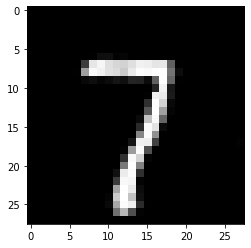

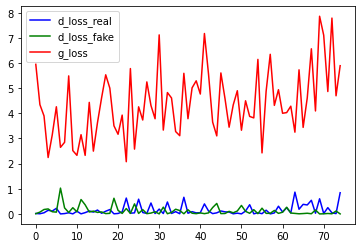

[75/200][0/938] Loss_D: 0.0953 Loss_G: 3.3659 D(x): 0.9385 D(G(z)): 0.0235 / 0.1154
[75/200][100/938] Loss_D: 0.0995 Loss_G: 3.8886 D(x): 0.9890 D(G(z)): 0.0770 / 0.0624
[75/200][200/938] Loss_D: 0.0815 Loss_G: 6.0717 D(x): 0.9365 D(G(z)): 0.0087 / 0.0085
[75/200][300/938] Loss_D: 0.0476 Loss_G: 5.9560 D(x): 0.9813 D(G(z)): 0.0216 / 0.0139
[75/200][400/938] Loss_D: 0.1705 Loss_G: 3.1003 D(x): 0.9816 D(G(z)): 0.1148 / 0.1363
[75/200][500/938] Loss_D: 0.0421 Loss_G: 8.7609 D(x): 0.9623 D(G(z)): 0.0018 / 0.0008
[75/200][600/938] Loss_D: 0.0987 Loss_G: 6.9019 D(x): 0.9171 D(G(z)): 0.0047 / 0.0035
[75/200][700/938] Loss_D: 0.3774 Loss_G: 3.9613 D(x): 0.8627 D(G(z)): 0.1496 / 0.0684
[75/200][800/938] Loss_D: 0.1040 Loss_G: 4.0491 D(x): 0.9915 D(G(z)): 0.0811 / 0.0586
[75/200][900/938] Loss_D: 0.1489 Loss_G: 5.9935 D(x): 0.8893 D(G(z)): 0.0119 / 0.0103


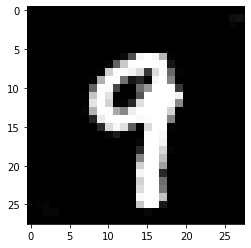

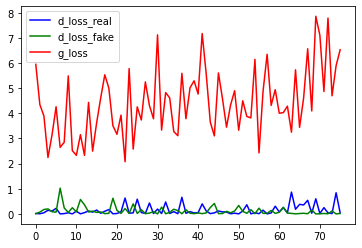

[76/200][0/938] Loss_D: 0.5651 Loss_G: 6.6341 D(x): 0.6606 D(G(z)): 0.0136 / 0.0139
[76/200][100/938] Loss_D: 0.2418 Loss_G: 4.5299 D(x): 0.9760 D(G(z)): 0.1507 / 0.0388
[76/200][200/938] Loss_D: 0.0746 Loss_G: 6.1576 D(x): 0.9416 D(G(z)): 0.0053 / 0.0075
[76/200][300/938] Loss_D: 0.0822 Loss_G: 6.7372 D(x): 0.9300 D(G(z)): 0.0041 / 0.0040
[76/200][400/938] Loss_D: 0.0486 Loss_G: 4.1968 D(x): 0.9809 D(G(z)): 0.0275 / 0.0423
[76/200][500/938] Loss_D: 0.0667 Loss_G: 5.6370 D(x): 0.9797 D(G(z)): 0.0417 / 0.0154
[76/200][600/938] Loss_D: 0.1610 Loss_G: 4.1855 D(x): 0.9973 D(G(z)): 0.1209 / 0.0467
[76/200][700/938] Loss_D: 0.0580 Loss_G: 5.5773 D(x): 0.9945 D(G(z)): 0.0451 / 0.0183
[76/200][800/938] Loss_D: 0.0684 Loss_G: 5.5860 D(x): 0.9878 D(G(z)): 0.0448 / 0.0179
[76/200][900/938] Loss_D: 0.2203 Loss_G: 4.2720 D(x): 0.9315 D(G(z)): 0.1123 / 0.0491


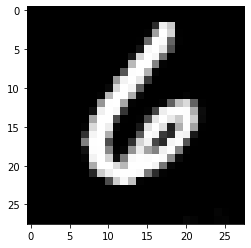

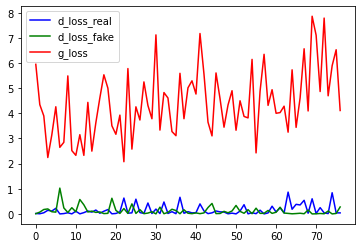

[77/200][0/938] Loss_D: 0.0514 Loss_G: 7.7690 D(x): 0.9605 D(G(z)): 0.0072 / 0.0028
[77/200][100/938] Loss_D: 0.1264 Loss_G: 3.7517 D(x): 0.9901 D(G(z)): 0.0871 / 0.0791
[77/200][200/938] Loss_D: 0.1815 Loss_G: 4.1674 D(x): 0.9068 D(G(z)): 0.0494 / 0.0482
[77/200][300/938] Loss_D: 0.1181 Loss_G: 4.6959 D(x): 0.9413 D(G(z)): 0.0466 / 0.0269
[77/200][400/938] Loss_D: 0.1575 Loss_G: 3.7639 D(x): 0.9777 D(G(z)): 0.1086 / 0.0583
[77/200][500/938] Loss_D: 0.5449 Loss_G: 2.5448 D(x): 0.9906 D(G(z)): 0.3418 / 0.1476
[77/200][600/938] Loss_D: 0.3510 Loss_G: 3.2885 D(x): 0.9945 D(G(z)): 0.2406 / 0.0859
[77/200][700/938] Loss_D: 0.3702 Loss_G: 4.4794 D(x): 0.9869 D(G(z)): 0.2308 / 0.0359
[77/200][800/938] Loss_D: 0.3352 Loss_G: 3.5345 D(x): 0.9988 D(G(z)): 0.2049 / 0.0759
[77/200][900/938] Loss_D: 0.2819 Loss_G: 4.4875 D(x): 0.8356 D(G(z)): 0.0235 / 0.0320


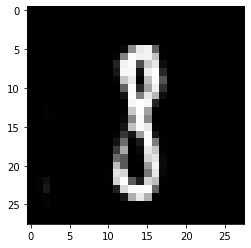

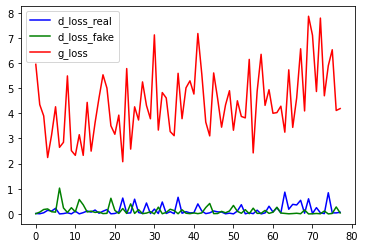

[78/200][0/938] Loss_D: 0.1617 Loss_G: 3.4344 D(x): 0.9769 D(G(z)): 0.1011 / 0.0991
[78/200][100/938] Loss_D: 0.0272 Loss_G: 5.9250 D(x): 0.9894 D(G(z)): 0.0153 / 0.0120
[78/200][200/938] Loss_D: 0.0884 Loss_G: 4.1714 D(x): 0.9934 D(G(z)): 0.0647 / 0.0579
[78/200][300/938] Loss_D: 0.2735 Loss_G: 3.8804 D(x): 0.9778 D(G(z)): 0.1843 / 0.0564
[78/200][400/938] Loss_D: 0.1130 Loss_G: 3.8186 D(x): 0.9863 D(G(z)): 0.0808 / 0.0766
[78/200][500/938] Loss_D: 0.1607 Loss_G: 3.4970 D(x): 0.9742 D(G(z)): 0.1010 / 0.1053
[78/200][600/938] Loss_D: 0.2409 Loss_G: 2.1901 D(x): 0.9961 D(G(z)): 0.1784 / 0.2506
[78/200][700/938] Loss_D: 0.1245 Loss_G: 5.5988 D(x): 0.9033 D(G(z)): 0.0124 / 0.0184
[78/200][800/938] Loss_D: 0.0797 Loss_G: 6.0702 D(x): 0.9798 D(G(z)): 0.0506 / 0.0090
[78/200][900/938] Loss_D: 0.0705 Loss_G: 3.8511 D(x): 0.9966 D(G(z)): 0.0613 / 0.0490


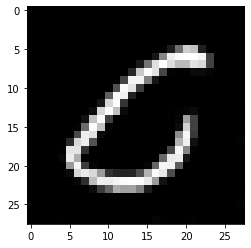

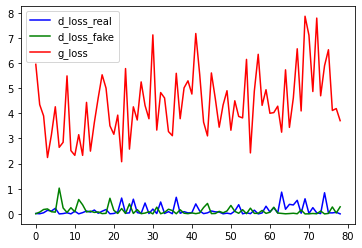

[79/200][0/938] Loss_D: 0.3217 Loss_G: 4.4261 D(x): 0.8777 D(G(z)): 0.1248 / 0.0415
[79/200][100/938] Loss_D: 0.0960 Loss_G: 4.7748 D(x): 0.9750 D(G(z)): 0.0577 / 0.0356
[79/200][200/938] Loss_D: 0.1504 Loss_G: 9.0106 D(x): 0.8845 D(G(z)): 0.0017 / 0.0008
[79/200][300/938] Loss_D: 0.0588 Loss_G: 5.2227 D(x): 0.9686 D(G(z)): 0.0215 / 0.0275
[79/200][400/938] Loss_D: 0.2643 Loss_G: 3.2594 D(x): 0.9831 D(G(z)): 0.1763 / 0.1088
[79/200][500/938] Loss_D: 0.0631 Loss_G: 4.9913 D(x): 0.9812 D(G(z)): 0.0391 / 0.0255
[79/200][600/938] Loss_D: 0.0119 Loss_G: 5.6584 D(x): 0.9939 D(G(z)): 0.0056 / 0.0103
[79/200][700/938] Loss_D: 0.0997 Loss_G: 5.5884 D(x): 0.9489 D(G(z)): 0.0355 / 0.0185
[79/200][800/938] Loss_D: 0.1981 Loss_G: 4.5374 D(x): 0.9436 D(G(z)): 0.0934 / 0.0545
[79/200][900/938] Loss_D: 0.0577 Loss_G: 4.8516 D(x): 0.9916 D(G(z)): 0.0406 / 0.0312


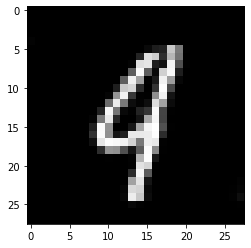

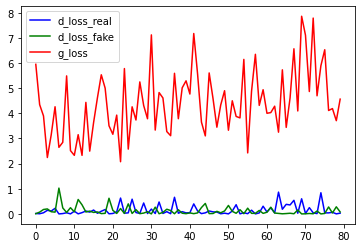

[80/200][0/938] Loss_D: 0.0383 Loss_G: 5.8617 D(x): 0.9958 D(G(z)): 0.0274 / 0.0145
[80/200][100/938] Loss_D: 0.1109 Loss_G: 5.3002 D(x): 0.9806 D(G(z)): 0.0820 / 0.0127
[80/200][200/938] Loss_D: 0.2844 Loss_G: 4.2082 D(x): 0.8538 D(G(z)): 0.0611 / 0.0468
[80/200][300/938] Loss_D: 0.5602 Loss_G: 2.6470 D(x): 0.7154 D(G(z)): 0.0874 / 0.1524
[80/200][400/938] Loss_D: 0.2522 Loss_G: 3.9252 D(x): 0.8437 D(G(z)): 0.0525 / 0.0505
[80/200][500/938] Loss_D: 0.1688 Loss_G: 4.4833 D(x): 0.9537 D(G(z)): 0.0904 / 0.0351
[80/200][600/938] Loss_D: 0.3035 Loss_G: 6.6492 D(x): 0.7883 D(G(z)): 0.0061 / 0.0133
[80/200][700/938] Loss_D: 0.0686 Loss_G: 5.3607 D(x): 0.9521 D(G(z)): 0.0171 / 0.0150
[80/200][800/938] Loss_D: 0.3601 Loss_G: 3.3608 D(x): 0.9943 D(G(z)): 0.2304 / 0.1035
[80/200][900/938] Loss_D: 0.1709 Loss_G: 5.4386 D(x): 0.9084 D(G(z)): 0.0356 / 0.0180


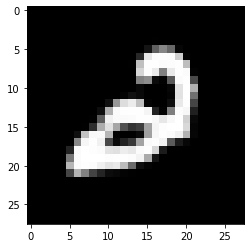

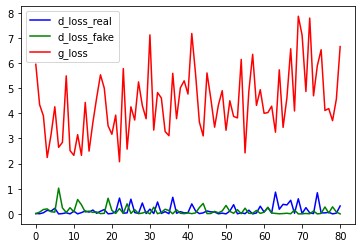

[81/200][0/938] Loss_D: 0.1749 Loss_G: 5.3978 D(x): 0.8642 D(G(z)): 0.0045 / 0.0152
[81/200][100/938] Loss_D: 0.1435 Loss_G: 5.7085 D(x): 0.9951 D(G(z)): 0.0824 / 0.0242
[81/200][200/938] Loss_D: 0.7384 Loss_G: 2.4687 D(x): 0.9986 D(G(z)): 0.3644 / 0.1847
[81/200][300/938] Loss_D: 0.0771 Loss_G: 6.2509 D(x): 0.9591 D(G(z)): 0.0277 / 0.0103
[81/200][400/938] Loss_D: 0.0534 Loss_G: 6.9362 D(x): 0.9640 D(G(z)): 0.0129 / 0.0062
[81/200][500/938] Loss_D: 0.1867 Loss_G: 3.8970 D(x): 0.9448 D(G(z)): 0.0947 / 0.0736
[81/200][600/938] Loss_D: 0.0993 Loss_G: 6.3966 D(x): 0.9248 D(G(z)): 0.0112 / 0.0094
[81/200][700/938] Loss_D: 0.0557 Loss_G: 5.1697 D(x): 0.9826 D(G(z)): 0.0353 / 0.0253
[81/200][800/938] Loss_D: 0.0526 Loss_G: 5.6169 D(x): 0.9841 D(G(z)): 0.0305 / 0.0224
[81/200][900/938] Loss_D: 0.4589 Loss_G: 1.8337 D(x): 0.9967 D(G(z)): 0.2787 / 0.2908


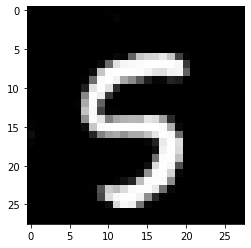

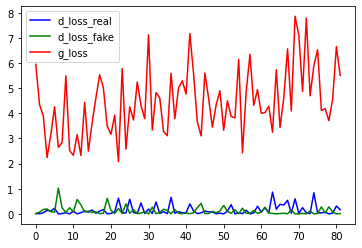

[82/200][0/938] Loss_D: 0.2511 Loss_G: 3.9219 D(x): 0.8429 D(G(z)): 0.0315 / 0.0630
[82/200][100/938] Loss_D: 0.0565 Loss_G: 6.8241 D(x): 0.9568 D(G(z)): 0.0069 / 0.0074
[82/200][200/938] Loss_D: 0.1357 Loss_G: 4.1622 D(x): 0.9792 D(G(z)): 0.0897 / 0.0565
[82/200][300/938] Loss_D: 0.1575 Loss_G: 3.9492 D(x): 0.8923 D(G(z)): 0.0286 / 0.0557
[82/200][400/938] Loss_D: 0.2249 Loss_G: 6.2046 D(x): 0.8459 D(G(z)): 0.0154 / 0.0162
[82/200][500/938] Loss_D: 0.1266 Loss_G: 3.9485 D(x): 0.9784 D(G(z)): 0.0856 / 0.0542
[82/200][600/938] Loss_D: 0.4924 Loss_G: 5.8378 D(x): 0.6915 D(G(z)): 0.0127 / 0.0110
[82/200][700/938] Loss_D: 0.1159 Loss_G: 4.9368 D(x): 0.9882 D(G(z)): 0.0783 / 0.0350
[82/200][800/938] Loss_D: 0.1185 Loss_G: 5.4554 D(x): 0.9286 D(G(z)): 0.0186 / 0.0193
[82/200][900/938] Loss_D: 0.1219 Loss_G: 4.4184 D(x): 0.9435 D(G(z)): 0.0498 / 0.0481


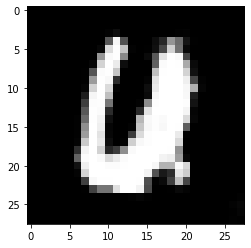

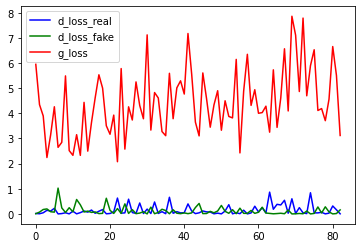

[83/200][0/938] Loss_D: 0.1739 Loss_G: 3.7307 D(x): 0.9914 D(G(z)): 0.1267 / 0.0722
[83/200][100/938] Loss_D: 0.0979 Loss_G: 3.6215 D(x): 0.9905 D(G(z)): 0.0721 / 0.0789
[83/200][200/938] Loss_D: 0.1790 Loss_G: 5.0895 D(x): 0.8864 D(G(z)): 0.0374 / 0.0204
[83/200][300/938] Loss_D: 0.3916 Loss_G: 2.7268 D(x): 0.9559 D(G(z)): 0.2334 / 0.1556
[83/200][400/938] Loss_D: 0.2133 Loss_G: 5.3745 D(x): 0.8522 D(G(z)): 0.0231 / 0.0212
[83/200][500/938] Loss_D: 0.4769 Loss_G: 6.5457 D(x): 0.6823 D(G(z)): 0.0034 / 0.0068
[83/200][600/938] Loss_D: 0.2024 Loss_G: 4.9034 D(x): 0.8499 D(G(z)): 0.0077 / 0.0227
[83/200][700/938] Loss_D: 0.1297 Loss_G: 4.8216 D(x): 0.9767 D(G(z)): 0.0837 / 0.0314
[83/200][800/938] Loss_D: 0.2268 Loss_G: 3.4302 D(x): 0.8822 D(G(z)): 0.0600 / 0.0986
[83/200][900/938] Loss_D: 0.2085 Loss_G: 5.5257 D(x): 0.8761 D(G(z)): 0.0197 / 0.0270


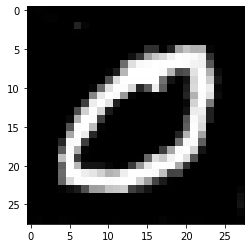

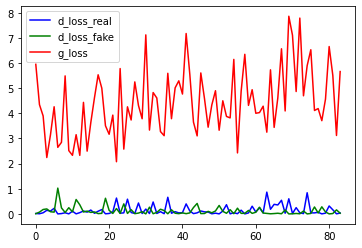

[84/200][0/938] Loss_D: 0.5346 Loss_G: 4.3464 D(x): 0.9794 D(G(z)): 0.2873 / 0.0645
[84/200][100/938] Loss_D: 0.4360 Loss_G: 2.6215 D(x): 0.9894 D(G(z)): 0.2518 / 0.1679
[84/200][200/938] Loss_D: 0.1256 Loss_G: 4.5169 D(x): 0.9243 D(G(z)): 0.0365 / 0.0358
[84/200][300/938] Loss_D: 0.0780 Loss_G: 4.7870 D(x): 0.9738 D(G(z)): 0.0468 / 0.0285
[84/200][400/938] Loss_D: 0.0429 Loss_G: 7.3703 D(x): 0.9679 D(G(z)): 0.0087 / 0.0026
[84/200][500/938] Loss_D: 0.3044 Loss_G: 3.5370 D(x): 0.9976 D(G(z)): 0.1984 / 0.0910
[84/200][600/938] Loss_D: 0.3185 Loss_G: 2.9054 D(x): 0.8758 D(G(z)): 0.1344 / 0.1242
[84/200][700/938] Loss_D: 0.1192 Loss_G: 4.2419 D(x): 0.9854 D(G(z)): 0.0790 / 0.0674
[84/200][800/938] Loss_D: 0.3104 Loss_G: 2.6587 D(x): 0.9822 D(G(z)): 0.2013 / 0.1752
[84/200][900/938] Loss_D: 0.1258 Loss_G: 4.1147 D(x): 0.9870 D(G(z)): 0.0864 / 0.0632


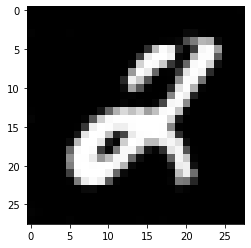

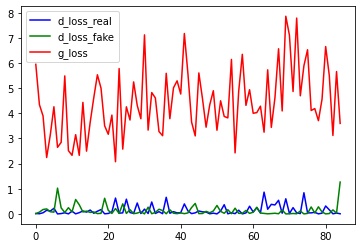

[85/200][0/938] Loss_D: 0.1473 Loss_G: 6.7965 D(x): 0.9126 D(G(z)): 0.0326 / 0.0073
[85/200][100/938] Loss_D: 0.1992 Loss_G: 5.1083 D(x): 0.8713 D(G(z)): 0.0176 / 0.0193
[85/200][200/938] Loss_D: 0.0928 Loss_G: 3.7884 D(x): 0.9796 D(G(z)): 0.0579 / 0.0865
[85/200][300/938] Loss_D: 0.2356 Loss_G: 4.2577 D(x): 0.9033 D(G(z)): 0.0976 / 0.0540
[85/200][400/938] Loss_D: 0.0944 Loss_G: 6.4440 D(x): 0.9336 D(G(z)): 0.0136 / 0.0083
[85/200][500/938] Loss_D: 0.2346 Loss_G: 5.0227 D(x): 0.8636 D(G(z)): 0.0444 / 0.0262
[85/200][600/938] Loss_D: 0.1328 Loss_G: 6.4831 D(x): 0.9048 D(G(z)): 0.0186 / 0.0076
[85/200][700/938] Loss_D: 0.4366 Loss_G: 9.3181 D(x): 0.7244 D(G(z)): 0.0016 / 0.0006
[85/200][800/938] Loss_D: 0.1244 Loss_G: 3.6947 D(x): 0.9345 D(G(z)): 0.0353 / 0.0692
[85/200][900/938] Loss_D: 0.1668 Loss_G: 5.7378 D(x): 0.8780 D(G(z)): 0.0069 / 0.0125


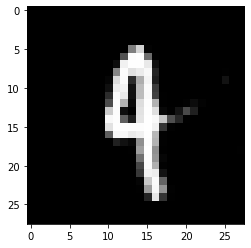

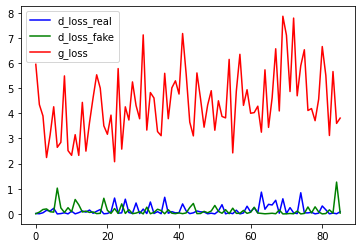

[86/200][0/938] Loss_D: 0.0788 Loss_G: 3.9107 D(x): 0.9869 D(G(z)): 0.0552 / 0.0867
[86/200][100/938] Loss_D: 0.1765 Loss_G: 5.1066 D(x): 0.8836 D(G(z)): 0.0259 / 0.0321
[86/200][200/938] Loss_D: 0.1841 Loss_G: 3.4349 D(x): 0.9884 D(G(z)): 0.1318 / 0.1010
[86/200][300/938] Loss_D: 0.0967 Loss_G: 6.1895 D(x): 0.9424 D(G(z)): 0.0290 / 0.0166
[86/200][400/938] Loss_D: 0.1829 Loss_G: 3.5403 D(x): 0.9107 D(G(z)): 0.0692 / 0.0682
[86/200][500/938] Loss_D: 0.0415 Loss_G: 5.4665 D(x): 0.9740 D(G(z)): 0.0127 / 0.0204
[86/200][600/938] Loss_D: 0.2652 Loss_G: 7.6162 D(x): 0.8148 D(G(z)): 0.0022 / 0.0018
[86/200][700/938] Loss_D: 0.1582 Loss_G: 4.3237 D(x): 0.9725 D(G(z)): 0.0909 / 0.0532
[86/200][800/938] Loss_D: 0.1179 Loss_G: 4.6511 D(x): 0.9433 D(G(z)): 0.0442 / 0.0432
[86/200][900/938] Loss_D: 0.3742 Loss_G: 3.8717 D(x): 0.7582 D(G(z)): 0.0465 / 0.0787


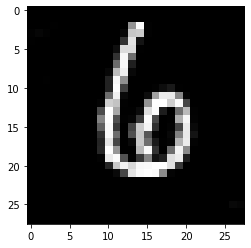

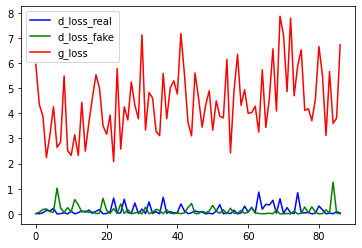

[87/200][0/938] Loss_D: 0.1802 Loss_G: 6.2937 D(x): 0.8623 D(G(z)): 0.0119 / 0.0111
[87/200][100/938] Loss_D: 0.1655 Loss_G: 3.9773 D(x): 0.9525 D(G(z)): 0.0833 / 0.0750
[87/200][200/938] Loss_D: 0.1254 Loss_G: 5.1376 D(x): 0.9699 D(G(z)): 0.0796 / 0.0194
[87/200][300/938] Loss_D: 0.2524 Loss_G: 2.6402 D(x): 0.9180 D(G(z)): 0.1221 / 0.1542
[87/200][400/938] Loss_D: 0.1464 Loss_G: 4.7936 D(x): 0.9869 D(G(z)): 0.1056 / 0.0313
[87/200][500/938] Loss_D: 0.0786 Loss_G: 4.7687 D(x): 0.9719 D(G(z)): 0.0430 / 0.0349
[87/200][600/938] Loss_D: 0.1434 Loss_G: 4.9803 D(x): 0.9166 D(G(z)): 0.0375 / 0.0330
[87/200][700/938] Loss_D: 0.1159 Loss_G: 5.9091 D(x): 0.9302 D(G(z)): 0.0329 / 0.0144
[87/200][800/938] Loss_D: 0.1957 Loss_G: 2.6452 D(x): 0.9857 D(G(z)): 0.1397 / 0.1660
[87/200][900/938] Loss_D: 0.2271 Loss_G: 6.5328 D(x): 0.8270 D(G(z)): 0.0038 / 0.0057


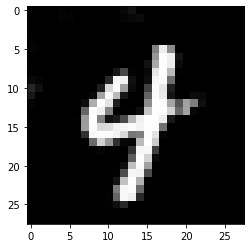

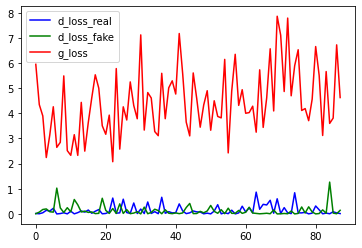

[88/200][0/938] Loss_D: 0.2975 Loss_G: 4.2095 D(x): 0.9284 D(G(z)): 0.1412 / 0.0606
[88/200][100/938] Loss_D: 0.2899 Loss_G: 5.4457 D(x): 0.8281 D(G(z)): 0.0299 / 0.0418
[88/200][200/938] Loss_D: 0.3210 Loss_G: 6.7658 D(x): 0.7719 D(G(z)): 0.0015 / 0.0054
[88/200][300/938] Loss_D: 0.1002 Loss_G: 5.8052 D(x): 0.9282 D(G(z)): 0.0079 / 0.0156
[88/200][400/938] Loss_D: 0.1581 Loss_G: 4.6882 D(x): 0.9019 D(G(z)): 0.0233 / 0.0332
[88/200][500/938] Loss_D: 0.0811 Loss_G: 5.6297 D(x): 0.9806 D(G(z)): 0.0550 / 0.0140
[88/200][600/938] Loss_D: 0.0663 Loss_G: 5.2015 D(x): 0.9597 D(G(z)): 0.0205 / 0.0196
[88/200][700/938] Loss_D: 0.0960 Loss_G: 5.9208 D(x): 0.9288 D(G(z)): 0.0152 / 0.0120
[88/200][800/938] Loss_D: 0.0636 Loss_G: 4.8025 D(x): 0.9924 D(G(z)): 0.0499 / 0.0350
[88/200][900/938] Loss_D: 0.2036 Loss_G: 3.8800 D(x): 0.9931 D(G(z)): 0.1519 / 0.0697


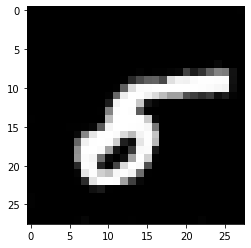

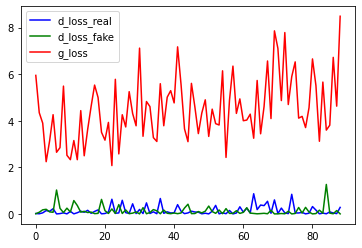

[89/200][0/938] Loss_D: 0.2263 Loss_G: 7.5862 D(x): 0.8283 D(G(z)): 0.0049 / 0.0041
[89/200][100/938] Loss_D: 0.0402 Loss_G: 6.6128 D(x): 0.9670 D(G(z)): 0.0055 / 0.0054
[89/200][200/938] Loss_D: 0.1321 Loss_G: 4.7953 D(x): 0.9146 D(G(z)): 0.0222 / 0.0279
[89/200][300/938] Loss_D: 0.0974 Loss_G: 4.6403 D(x): 0.9686 D(G(z)): 0.0545 / 0.0456
[89/200][400/938] Loss_D: 0.1035 Loss_G: 5.0409 D(x): 0.9376 D(G(z)): 0.0286 / 0.0265
[89/200][500/938] Loss_D: 0.1257 Loss_G: 4.4280 D(x): 0.9918 D(G(z)): 0.0845 / 0.0432
[89/200][600/938] Loss_D: 0.0963 Loss_G: 7.2086 D(x): 0.9241 D(G(z)): 0.0066 / 0.0065
[89/200][700/938] Loss_D: 0.3542 Loss_G: 4.2846 D(x): 0.9935 D(G(z)): 0.1913 / 0.0773
[89/200][800/938] Loss_D: 0.2981 Loss_G: 4.5115 D(x): 0.8342 D(G(z)): 0.0530 / 0.0486
[89/200][900/938] Loss_D: 0.0412 Loss_G: 5.4498 D(x): 0.9836 D(G(z)): 0.0192 / 0.0223


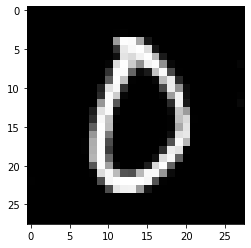

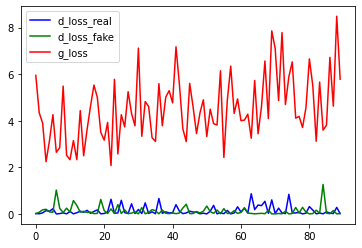

[90/200][0/938] Loss_D: 0.0958 Loss_G: 5.4117 D(x): 0.9445 D(G(z)): 0.0304 / 0.0162
[90/200][100/938] Loss_D: 0.0519 Loss_G: 4.6320 D(x): 0.9764 D(G(z)): 0.0248 / 0.0379
[90/200][200/938] Loss_D: 0.1772 Loss_G: 7.5046 D(x): 0.8636 D(G(z)): 0.0056 / 0.0060
[90/200][300/938] Loss_D: 0.0613 Loss_G: 5.3767 D(x): 0.9591 D(G(z)): 0.0173 / 0.0164
[90/200][400/938] Loss_D: 0.0777 Loss_G: 5.5784 D(x): 0.9528 D(G(z)): 0.0205 / 0.0192
[90/200][500/938] Loss_D: 0.1022 Loss_G: 4.0703 D(x): 0.9725 D(G(z)): 0.0538 / 0.0535
[90/200][600/938] Loss_D: 0.1106 Loss_G: 3.3519 D(x): 0.9654 D(G(z)): 0.0577 / 0.1194
[90/200][700/938] Loss_D: 0.1451 Loss_G: 5.5963 D(x): 0.8947 D(G(z)): 0.0145 / 0.0163
[90/200][800/938] Loss_D: 0.2873 Loss_G: 3.9493 D(x): 0.9793 D(G(z)): 0.1800 / 0.0650
[90/200][900/938] Loss_D: 0.0662 Loss_G: 5.7109 D(x): 0.9802 D(G(z)): 0.0389 / 0.0174


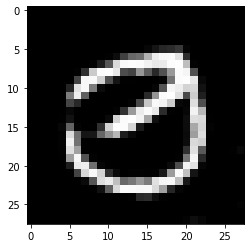

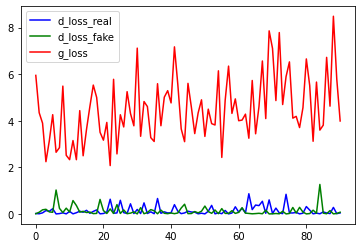

[91/200][0/938] Loss_D: 0.0362 Loss_G: 5.2207 D(x): 0.9955 D(G(z)): 0.0277 / 0.0252
[91/200][100/938] Loss_D: 0.0495 Loss_G: 5.0653 D(x): 0.9658 D(G(z)): 0.0128 / 0.0277
[91/200][200/938] Loss_D: 0.0848 Loss_G: 6.0476 D(x): 0.9588 D(G(z)): 0.0330 / 0.0150
[91/200][300/938] Loss_D: 0.2099 Loss_G: 6.4510 D(x): 0.8525 D(G(z)): 0.0053 / 0.0083
[91/200][400/938] Loss_D: 0.1602 Loss_G: 4.6304 D(x): 0.9564 D(G(z)): 0.0901 / 0.0288
[91/200][500/938] Loss_D: 0.0779 Loss_G: 6.7390 D(x): 0.9368 D(G(z)): 0.0066 / 0.0062
[91/200][600/938] Loss_D: 0.3510 Loss_G: 2.8264 D(x): 0.9734 D(G(z)): 0.1910 / 0.2011
[91/200][700/938] Loss_D: 0.4885 Loss_G: 5.5783 D(x): 0.7245 D(G(z)): 0.0051 / 0.0173
[91/200][800/938] Loss_D: 0.0776 Loss_G: 5.4211 D(x): 0.9638 D(G(z)): 0.0271 / 0.0275
[91/200][900/938] Loss_D: 0.1251 Loss_G: 5.1552 D(x): 0.9220 D(G(z)): 0.0319 / 0.0231


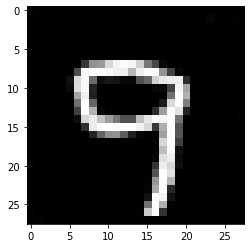

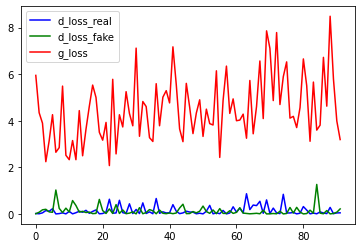

[92/200][0/938] Loss_D: 0.2415 Loss_G: 3.7692 D(x): 0.9832 D(G(z)): 0.1594 / 0.0782
[92/200][100/938] Loss_D: 0.0683 Loss_G: 4.2385 D(x): 0.9927 D(G(z)): 0.0554 / 0.0562
[92/200][200/938] Loss_D: 0.2369 Loss_G: 9.6545 D(x): 0.8336 D(G(z)): 0.0006 / 0.0004
[92/200][300/938] Loss_D: 0.1145 Loss_G: 4.0853 D(x): 0.9960 D(G(z)): 0.0938 / 0.0440
[92/200][400/938] Loss_D: 0.0614 Loss_G: 3.7265 D(x): 0.9945 D(G(z)): 0.0478 / 0.0965
[92/200][500/938] Loss_D: 0.0992 Loss_G: 5.1457 D(x): 0.9415 D(G(z)): 0.0222 / 0.0406
[92/200][600/938] Loss_D: 0.2462 Loss_G: 4.6941 D(x): 0.8636 D(G(z)): 0.0453 / 0.0384
[92/200][700/938] Loss_D: 0.3359 Loss_G: 3.9513 D(x): 0.7995 D(G(z)): 0.0491 / 0.0679
[92/200][800/938] Loss_D: 0.1437 Loss_G: 3.5640 D(x): 0.9471 D(G(z)): 0.0747 / 0.0857
[92/200][900/938] Loss_D: 0.0996 Loss_G: 3.6750 D(x): 0.9880 D(G(z)): 0.0757 / 0.0717


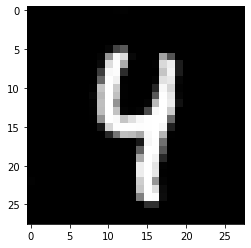

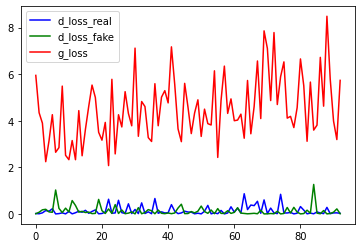

[93/200][0/938] Loss_D: 0.0716 Loss_G: 4.5700 D(x): 0.9850 D(G(z)): 0.0472 / 0.0370
[93/200][100/938] Loss_D: 0.3001 Loss_G: 3.1516 D(x): 0.9949 D(G(z)): 0.2066 / 0.1192
[93/200][200/938] Loss_D: 0.0283 Loss_G: 5.6502 D(x): 0.9932 D(G(z)): 0.0190 / 0.0152
[93/200][300/938] Loss_D: 0.2626 Loss_G: 3.2538 D(x): 0.9805 D(G(z)): 0.1476 / 0.1179
[93/200][400/938] Loss_D: 0.0917 Loss_G: 4.9691 D(x): 0.9921 D(G(z)): 0.0718 / 0.0245
[93/200][500/938] Loss_D: 0.2674 Loss_G: 3.6638 D(x): 0.9489 D(G(z)): 0.1561 / 0.0755
[93/200][600/938] Loss_D: 0.0196 Loss_G: 7.1271 D(x): 0.9880 D(G(z)): 0.0072 / 0.0044
[93/200][700/938] Loss_D: 0.1233 Loss_G: 4.6001 D(x): 0.9937 D(G(z)): 0.0946 / 0.0570
[93/200][800/938] Loss_D: 0.0903 Loss_G: 4.7600 D(x): 0.9841 D(G(z)): 0.0655 / 0.0298
[93/200][900/938] Loss_D: 0.0224 Loss_G: 5.4903 D(x): 0.9956 D(G(z)): 0.0170 / 0.0166


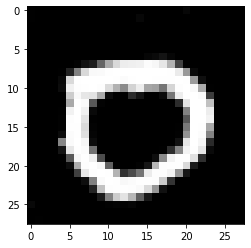

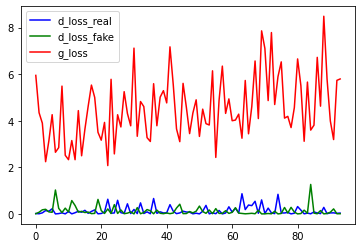

[94/200][0/938] Loss_D: 0.0775 Loss_G: 4.4804 D(x): 0.9933 D(G(z)): 0.0626 / 0.0414
[94/200][100/938] Loss_D: 0.2402 Loss_G: 3.4886 D(x): 0.8841 D(G(z)): 0.0760 / 0.0853
[94/200][200/938] Loss_D: 0.0939 Loss_G: 4.4909 D(x): 0.9409 D(G(z)): 0.0285 / 0.0380
[94/200][300/938] Loss_D: 0.1396 Loss_G: 3.9551 D(x): 0.9786 D(G(z)): 0.0949 / 0.0661
[94/200][400/938] Loss_D: 0.0494 Loss_G: 5.7538 D(x): 0.9797 D(G(z)): 0.0257 / 0.0180
[94/200][500/938] Loss_D: 1.1206 Loss_G: 2.8376 D(x): 0.9924 D(G(z)): 0.5267 / 0.1382
[94/200][600/938] Loss_D: 0.7306 Loss_G: 6.9004 D(x): 0.6053 D(G(z)): 0.0048 / 0.0083
[94/200][700/938] Loss_D: 0.0239 Loss_G: 7.4501 D(x): 0.9965 D(G(z)): 0.0192 / 0.0035
[94/200][800/938] Loss_D: 0.0335 Loss_G: 4.9033 D(x): 0.9961 D(G(z)): 0.0275 / 0.0332
[94/200][900/938] Loss_D: 0.2561 Loss_G: 2.9527 D(x): 0.9890 D(G(z)): 0.1811 / 0.1324


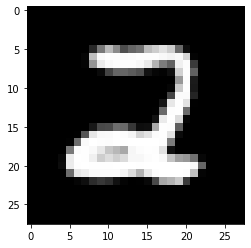

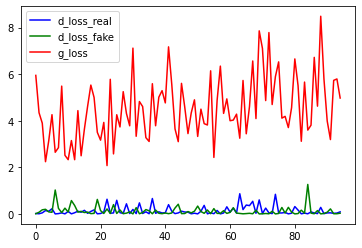

[95/200][0/938] Loss_D: 0.1300 Loss_G: 4.3665 D(x): 0.9806 D(G(z)): 0.0796 / 0.0595
[95/200][100/938] Loss_D: 0.3653 Loss_G: 3.6277 D(x): 0.9908 D(G(z)): 0.2467 / 0.0568
[95/200][200/938] Loss_D: 0.0459 Loss_G: 6.0047 D(x): 0.9778 D(G(z)): 0.0207 / 0.0106
[95/200][300/938] Loss_D: 0.1151 Loss_G: 4.4082 D(x): 0.9682 D(G(z)): 0.0624 / 0.0571
[95/200][400/938] Loss_D: 0.0719 Loss_G: 3.4092 D(x): 0.9918 D(G(z)): 0.0533 / 0.0928
[95/200][500/938] Loss_D: 0.1777 Loss_G: 4.0044 D(x): 0.8858 D(G(z)): 0.0354 / 0.0681
[95/200][600/938] Loss_D: 0.2267 Loss_G: 3.9982 D(x): 0.9805 D(G(z)): 0.1508 / 0.0635
[95/200][700/938] Loss_D: 0.1834 Loss_G: 4.8928 D(x): 0.8873 D(G(z)): 0.0313 / 0.0326
[95/200][800/938] Loss_D: 0.1843 Loss_G: 6.3893 D(x): 0.8593 D(G(z)): 0.0040 / 0.0099
[95/200][900/938] Loss_D: 0.3641 Loss_G: 3.3896 D(x): 0.9540 D(G(z)): 0.2267 / 0.0911


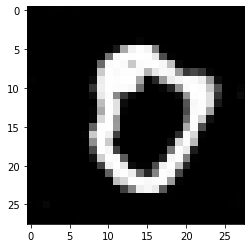

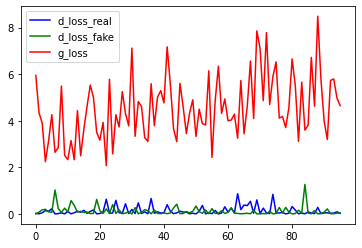

[96/200][0/938] Loss_D: 0.1052 Loss_G: 5.1771 D(x): 0.9314 D(G(z)): 0.0229 / 0.0270
[96/200][100/938] Loss_D: 0.0313 Loss_G: 5.8567 D(x): 0.9881 D(G(z)): 0.0181 / 0.0150
[96/200][200/938] Loss_D: 0.3275 Loss_G: 6.0085 D(x): 0.7834 D(G(z)): 0.0149 / 0.0182
[96/200][300/938] Loss_D: 0.1328 Loss_G: 3.8159 D(x): 0.9993 D(G(z)): 0.0980 / 0.0697
[96/200][400/938] Loss_D: 0.0923 Loss_G: 5.3591 D(x): 0.9778 D(G(z)): 0.0619 / 0.0192
[96/200][500/938] Loss_D: 0.0204 Loss_G: 5.4453 D(x): 0.9924 D(G(z)): 0.0122 / 0.0191
[96/200][600/938] Loss_D: 0.1587 Loss_G: 3.3883 D(x): 0.9638 D(G(z)): 0.0969 / 0.1217
[96/200][700/938] Loss_D: 0.1687 Loss_G: 4.1543 D(x): 0.9502 D(G(z)): 0.0833 / 0.0684
[96/200][800/938] Loss_D: 0.3545 Loss_G: 3.4338 D(x): 0.8985 D(G(z)): 0.1514 / 0.1049
[96/200][900/938] Loss_D: 0.0392 Loss_G: 6.6138 D(x): 0.9717 D(G(z)): 0.0089 / 0.0090


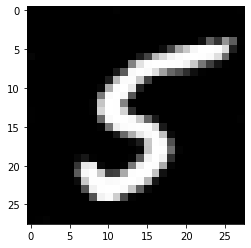

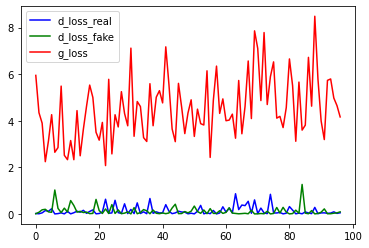

[97/200][0/938] Loss_D: 0.0745 Loss_G: 7.6773 D(x): 0.9367 D(G(z)): 0.0040 / 0.0035
[97/200][100/938] Loss_D: 0.1117 Loss_G: 3.6524 D(x): 0.9969 D(G(z)): 0.0797 / 0.0947
[97/200][200/938] Loss_D: 0.1158 Loss_G: 5.6219 D(x): 0.9177 D(G(z)): 0.0201 / 0.0344
[97/200][300/938] Loss_D: 0.1378 Loss_G: 5.7280 D(x): 0.9047 D(G(z)): 0.0135 / 0.0261
[97/200][400/938] Loss_D: 0.9822 Loss_G: 3.0083 D(x): 0.9913 D(G(z)): 0.4689 / 0.1455
[97/200][500/938] Loss_D: 0.3065 Loss_G: 7.4118 D(x): 0.7913 D(G(z)): 0.0038 / 0.0043
[97/200][600/938] Loss_D: 0.0820 Loss_G: 4.8293 D(x): 0.9855 D(G(z)): 0.0542 / 0.0412
[97/200][700/938] Loss_D: 0.2750 Loss_G: 2.7299 D(x): 0.9882 D(G(z)): 0.1918 / 0.1853
[97/200][800/938] Loss_D: 0.1690 Loss_G: 2.4724 D(x): 0.9834 D(G(z)): 0.1210 / 0.1835
[97/200][900/938] Loss_D: 0.0724 Loss_G: 5.3651 D(x): 0.9503 D(G(z)): 0.0155 / 0.0144


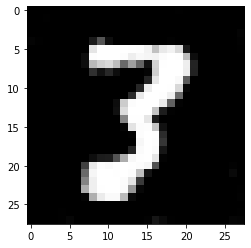

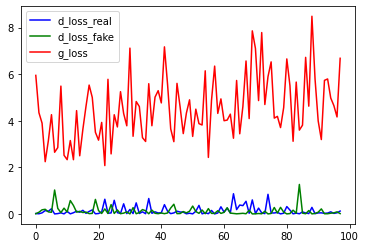

[98/200][0/938] Loss_D: 0.1553 Loss_G: 8.6417 D(x): 0.8783 D(G(z)): 0.0011 / 0.0012
[98/200][100/938] Loss_D: 0.2802 Loss_G: 3.9519 D(x): 0.8738 D(G(z)): 0.1032 / 0.0723
[98/200][200/938] Loss_D: 0.2566 Loss_G: 4.8105 D(x): 0.8485 D(G(z)): 0.0215 / 0.0402
[98/200][300/938] Loss_D: 0.0824 Loss_G: 5.0255 D(x): 0.9726 D(G(z)): 0.0440 / 0.0370
[98/200][400/938] Loss_D: 0.1536 Loss_G: 5.6620 D(x): 0.9164 D(G(z)): 0.0471 / 0.0152
[98/200][500/938] Loss_D: 0.2679 Loss_G: 4.5950 D(x): 0.8122 D(G(z)): 0.0177 / 0.0374
[98/200][600/938] Loss_D: 0.1149 Loss_G: 6.3332 D(x): 0.9113 D(G(z)): 0.0043 / 0.0089
[98/200][700/938] Loss_D: 0.2925 Loss_G: 2.6538 D(x): 0.9957 D(G(z)): 0.2080 / 0.1673
[98/200][800/938] Loss_D: 0.3963 Loss_G: 4.0802 D(x): 0.9672 D(G(z)): 0.2335 / 0.0620
[98/200][900/938] Loss_D: 0.0575 Loss_G: 5.3640 D(x): 0.9897 D(G(z)): 0.0420 / 0.0291


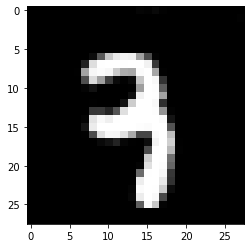

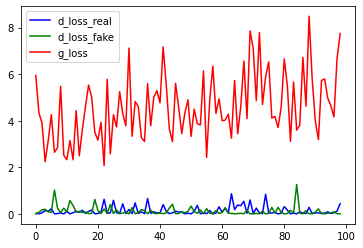

[99/200][0/938] Loss_D: 0.1215 Loss_G: 7.3264 D(x): 0.9005 D(G(z)): 0.0025 / 0.0044
[99/200][100/938] Loss_D: 0.1066 Loss_G: 5.0583 D(x): 0.9351 D(G(z)): 0.0279 / 0.0310
[99/200][200/938] Loss_D: 0.0458 Loss_G: 6.3973 D(x): 0.9764 D(G(z)): 0.0158 / 0.0100
[99/200][300/938] Loss_D: 0.2100 Loss_G: 5.5245 D(x): 0.8725 D(G(z)): 0.0267 / 0.0228
[99/200][400/938] Loss_D: 0.0731 Loss_G: 5.1259 D(x): 0.9760 D(G(z)): 0.0375 / 0.0286
[99/200][500/938] Loss_D: 0.1862 Loss_G: 3.9508 D(x): 0.9823 D(G(z)): 0.1283 / 0.0562
[99/200][600/938] Loss_D: 0.4550 Loss_G: 2.6668 D(x): 0.9702 D(G(z)): 0.2483 / 0.1757
[99/200][700/938] Loss_D: 0.0437 Loss_G: 6.3444 D(x): 0.9693 D(G(z)): 0.0093 / 0.0087
[99/200][800/938] Loss_D: 0.0787 Loss_G: 3.7211 D(x): 0.9758 D(G(z)): 0.0434 / 0.1066
[99/200][900/938] Loss_D: 0.1453 Loss_G: 4.1144 D(x): 0.9408 D(G(z)): 0.0674 / 0.0545


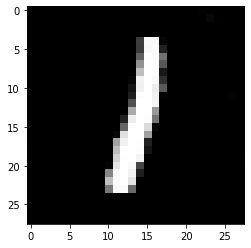

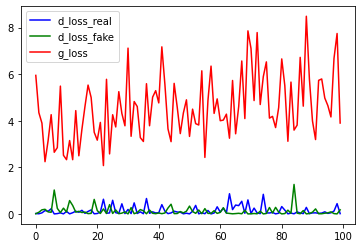

[100/200][0/938] Loss_D: 0.1836 Loss_G: 4.6067 D(x): 0.9793 D(G(z)): 0.1151 / 0.0433
[100/200][100/938] Loss_D: 0.1046 Loss_G: 4.4364 D(x): 0.9739 D(G(z)): 0.0520 / 0.0528
[100/200][200/938] Loss_D: 0.6909 Loss_G: 5.1851 D(x): 0.6261 D(G(z)): 0.0203 / 0.0450
[100/200][300/938] Loss_D: 0.0401 Loss_G: 7.0762 D(x): 0.9745 D(G(z)): 0.0122 / 0.0048
[100/200][400/938] Loss_D: 0.0788 Loss_G: 5.7576 D(x): 0.9533 D(G(z)): 0.0241 / 0.0209
[100/200][500/938] Loss_D: 0.2049 Loss_G: 4.9659 D(x): 0.8855 D(G(z)): 0.0402 / 0.0373
[100/200][600/938] Loss_D: 0.1167 Loss_G: 4.8057 D(x): 0.9385 D(G(z)): 0.0410 / 0.0293
[100/200][700/938] Loss_D: 0.1528 Loss_G: 6.8262 D(x): 0.9058 D(G(z)): 0.0224 / 0.0085
[100/200][800/938] Loss_D: 0.0548 Loss_G: 7.7189 D(x): 0.9532 D(G(z)): 0.0042 / 0.0037
[100/200][900/938] Loss_D: 0.1655 Loss_G: 5.3801 D(x): 0.9271 D(G(z)): 0.0699 / 0.0192


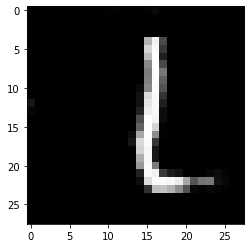

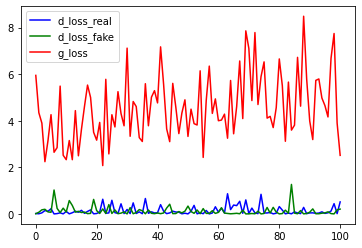

[101/200][0/938] Loss_D: 0.1132 Loss_G: 3.5880 D(x): 0.9941 D(G(z)): 0.0807 / 0.0950
[101/200][100/938] Loss_D: 0.0439 Loss_G: 5.5754 D(x): 0.9658 D(G(z)): 0.0081 / 0.0159
[101/200][200/938] Loss_D: 0.1274 Loss_G: 4.1392 D(x): 0.9954 D(G(z)): 0.1002 / 0.0472
[101/200][300/938] Loss_D: 0.1115 Loss_G: 3.9284 D(x): 0.9937 D(G(z)): 0.0863 / 0.0595
[101/200][400/938] Loss_D: 0.2060 Loss_G: 3.6083 D(x): 0.9798 D(G(z)): 0.1284 / 0.0663
[101/200][500/938] Loss_D: 0.2559 Loss_G: 5.0991 D(x): 0.9001 D(G(z)): 0.0911 / 0.0326
[101/200][600/938] Loss_D: 0.1811 Loss_G: 5.3322 D(x): 0.9670 D(G(z)): 0.0991 / 0.0283
[101/200][700/938] Loss_D: 0.0922 Loss_G: 4.6350 D(x): 0.9768 D(G(z)): 0.0476 / 0.0554
[101/200][800/938] Loss_D: 0.0287 Loss_G: 7.0398 D(x): 0.9784 D(G(z)): 0.0052 / 0.0069
[101/200][900/938] Loss_D: 0.1609 Loss_G: 4.1760 D(x): 0.9180 D(G(z)): 0.0466 / 0.0841


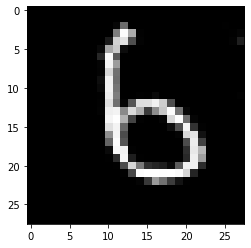

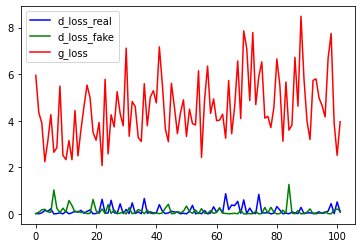

[102/200][0/938] Loss_D: 0.0403 Loss_G: 5.3948 D(x): 0.9887 D(G(z)): 0.0262 / 0.0227
[102/200][100/938] Loss_D: 0.0365 Loss_G: 5.3474 D(x): 0.9974 D(G(z)): 0.0303 / 0.0209
[102/200][200/938] Loss_D: 0.0518 Loss_G: 4.3452 D(x): 0.9812 D(G(z)): 0.0302 / 0.0366
[102/200][300/938] Loss_D: 0.4373 Loss_G: 2.5579 D(x): 0.9954 D(G(z)): 0.2645 / 0.2064
[102/200][400/938] Loss_D: 0.1935 Loss_G: 7.7756 D(x): 0.8472 D(G(z)): 0.0021 / 0.0021
[102/200][500/938] Loss_D: 0.3786 Loss_G: 4.0015 D(x): 0.9061 D(G(z)): 0.1628 / 0.0891
[102/200][600/938] Loss_D: 0.1396 Loss_G: 4.4270 D(x): 0.9790 D(G(z)): 0.0878 / 0.0464
[102/200][700/938] Loss_D: 0.0423 Loss_G: 5.3852 D(x): 0.9936 D(G(z)): 0.0330 / 0.0165
[102/200][800/938] Loss_D: 0.0601 Loss_G: 6.6508 D(x): 0.9538 D(G(z)): 0.0096 / 0.0068
[102/200][900/938] Loss_D: 0.3555 Loss_G: 9.3068 D(x): 0.7727 D(G(z)): 0.0028 / 0.0006


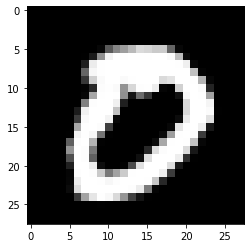

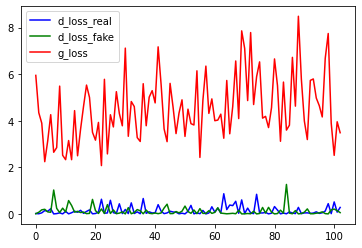

[103/200][0/938] Loss_D: 0.2017 Loss_G: 2.5699 D(x): 0.9740 D(G(z)): 0.1284 / 0.2067
[103/200][100/938] Loss_D: 0.3121 Loss_G: 5.8184 D(x): 0.7827 D(G(z)): 0.0034 / 0.0125
[103/200][200/938] Loss_D: 0.0560 Loss_G: 4.1691 D(x): 0.9937 D(G(z)): 0.0451 / 0.0504
[103/200][300/938] Loss_D: 0.2100 Loss_G: 5.2713 D(x): 0.8419 D(G(z)): 0.0085 / 0.0170
[103/200][400/938] Loss_D: 0.7120 Loss_G: 3.7485 D(x): 0.6344 D(G(z)): 0.0219 / 0.0864
[103/200][500/938] Loss_D: 0.2647 Loss_G: 6.0144 D(x): 0.8212 D(G(z)): 0.0122 / 0.0140
[103/200][600/938] Loss_D: 0.1591 Loss_G: 3.5131 D(x): 0.9489 D(G(z)): 0.0733 / 0.0881
[103/200][700/938] Loss_D: 0.2152 Loss_G: 5.5061 D(x): 0.9605 D(G(z)): 0.1198 / 0.0324
[103/200][800/938] Loss_D: 0.0832 Loss_G: 4.5790 D(x): 0.9800 D(G(z)): 0.0498 / 0.0565
[103/200][900/938] Loss_D: 0.0283 Loss_G: 6.6553 D(x): 0.9972 D(G(z)): 0.0221 / 0.0132


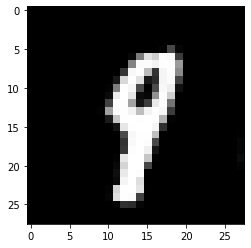

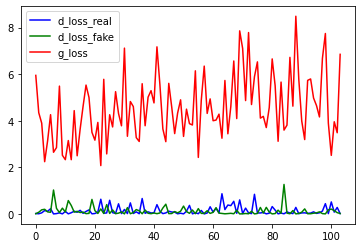

[104/200][0/938] Loss_D: 0.0374 Loss_G: 9.2688 D(x): 0.9735 D(G(z)): 0.0071 / 0.0038
[104/200][100/938] Loss_D: 0.0770 Loss_G: 6.0754 D(x): 0.9746 D(G(z)): 0.0310 / 0.0146
[104/200][200/938] Loss_D: 0.0343 Loss_G: 6.0433 D(x): 0.9789 D(G(z)): 0.0123 / 0.0093
[104/200][300/938] Loss_D: 0.0809 Loss_G: 4.4396 D(x): 0.9595 D(G(z)): 0.0350 / 0.0401
[104/200][400/938] Loss_D: 0.3493 Loss_G: 4.3199 D(x): 0.9121 D(G(z)): 0.1562 / 0.0656
[104/200][500/938] Loss_D: 0.0494 Loss_G: 5.3651 D(x): 0.9929 D(G(z)): 0.0387 / 0.0198
[104/200][600/938] Loss_D: 0.1330 Loss_G: 4.4867 D(x): 0.9250 D(G(z)): 0.0389 / 0.0468
[104/200][700/938] Loss_D: 0.0306 Loss_G: 5.5821 D(x): 0.9951 D(G(z)): 0.0239 / 0.0211
[104/200][800/938] Loss_D: 0.0480 Loss_G: 5.9524 D(x): 0.9726 D(G(z)): 0.0181 / 0.0144
[104/200][900/938] Loss_D: 0.1083 Loss_G: 7.3366 D(x): 0.9083 D(G(z)): 0.0034 / 0.0039


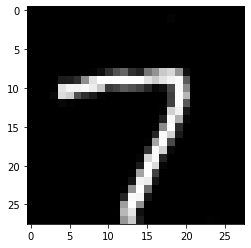

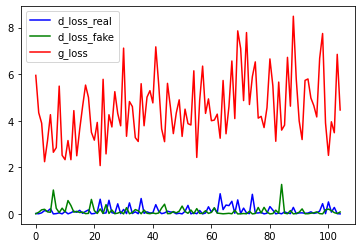

[105/200][0/938] Loss_D: 0.1581 Loss_G: 4.2402 D(x): 0.9583 D(G(z)): 0.0863 / 0.0665
[105/200][100/938] Loss_D: 0.0459 Loss_G: 4.4910 D(x): 0.9962 D(G(z)): 0.0392 / 0.0413
[105/200][200/938] Loss_D: 0.2369 Loss_G: 4.0292 D(x): 0.8823 D(G(z)): 0.0785 / 0.0682
[105/200][300/938] Loss_D: 0.0803 Loss_G: 4.5254 D(x): 0.9747 D(G(z)): 0.0449 / 0.0379
[105/200][400/938] Loss_D: 0.0595 Loss_G: 3.7338 D(x): 0.9822 D(G(z)): 0.0373 / 0.0874
[105/200][500/938] Loss_D: 0.2438 Loss_G: 3.1295 D(x): 0.9971 D(G(z)): 0.1645 / 0.1407
[105/200][600/938] Loss_D: 0.0358 Loss_G: 6.0737 D(x): 0.9747 D(G(z)): 0.0088 / 0.0174
[105/200][700/938] Loss_D: 0.0660 Loss_G: 5.4490 D(x): 0.9518 D(G(z)): 0.0138 / 0.0173
[105/200][800/938] Loss_D: 0.1060 Loss_G: 4.3655 D(x): 0.9910 D(G(z)): 0.0743 / 0.0596
[105/200][900/938] Loss_D: 0.0619 Loss_G: 7.1291 D(x): 0.9497 D(G(z)): 0.0048 / 0.0036


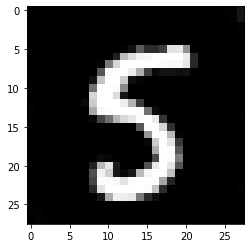

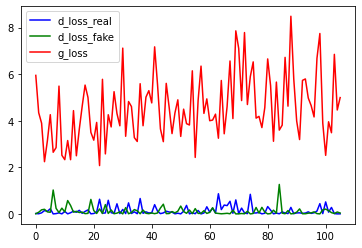

[106/200][0/938] Loss_D: 0.0603 Loss_G: 4.5897 D(x): 0.9802 D(G(z)): 0.0367 / 0.0367
[106/200][100/938] Loss_D: 1.7889 Loss_G: 4.6555 D(x): 0.3417 D(G(z)): 0.0017 / 0.0621
[106/200][200/938] Loss_D: 0.0582 Loss_G: 4.4264 D(x): 0.9879 D(G(z)): 0.0378 / 0.0621
[106/200][300/938] Loss_D: 0.0993 Loss_G: 5.4223 D(x): 0.9803 D(G(z)): 0.0562 / 0.0326
[106/200][400/938] Loss_D: 0.2303 Loss_G: 3.8307 D(x): 0.8892 D(G(z)): 0.0522 / 0.0645
[106/200][500/938] Loss_D: 0.0867 Loss_G: 4.8506 D(x): 0.9811 D(G(z)): 0.0543 / 0.0362
[106/200][600/938] Loss_D: 0.5211 Loss_G: 3.4398 D(x): 0.7118 D(G(z)): 0.0390 / 0.0854
[106/200][700/938] Loss_D: 0.1200 Loss_G: 4.2190 D(x): 0.9288 D(G(z)): 0.0310 / 0.0639
[106/200][800/938] Loss_D: 0.1045 Loss_G: 4.4681 D(x): 0.9818 D(G(z)): 0.0589 / 0.0627
[106/200][900/938] Loss_D: 0.1115 Loss_G: 4.0840 D(x): 0.9917 D(G(z)): 0.0833 / 0.0710


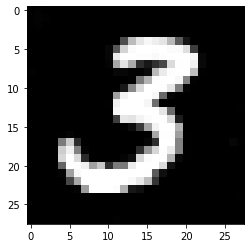

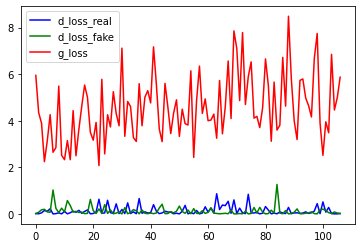

[107/200][0/938] Loss_D: 0.0594 Loss_G: 6.5213 D(x): 0.9772 D(G(z)): 0.0281 / 0.0159
[107/200][100/938] Loss_D: 0.2016 Loss_G: 4.7290 D(x): 0.8641 D(G(z)): 0.0219 / 0.0412
[107/200][200/938] Loss_D: 0.0463 Loss_G: 5.6854 D(x): 0.9729 D(G(z)): 0.0170 / 0.0192
[107/200][300/938] Loss_D: 0.1332 Loss_G: 5.3926 D(x): 0.9096 D(G(z)): 0.0188 / 0.0199
[107/200][400/938] Loss_D: 0.0588 Loss_G: 5.5630 D(x): 0.9589 D(G(z)): 0.0128 / 0.0168
[107/200][500/938] Loss_D: 0.3530 Loss_G: 3.0911 D(x): 0.9865 D(G(z)): 0.1657 / 0.1433
[107/200][600/938] Loss_D: 0.2186 Loss_G: 4.6940 D(x): 0.8568 D(G(z)): 0.0300 / 0.0390
[107/200][700/938] Loss_D: 0.0309 Loss_G: 6.2084 D(x): 0.9916 D(G(z)): 0.0199 / 0.0124
[107/200][800/938] Loss_D: 0.3278 Loss_G: 5.2005 D(x): 0.9815 D(G(z)): 0.1608 / 0.0520
[107/200][900/938] Loss_D: 0.2391 Loss_G: 4.5330 D(x): 0.8424 D(G(z)): 0.0173 / 0.0521


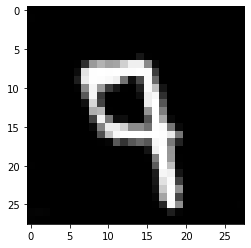

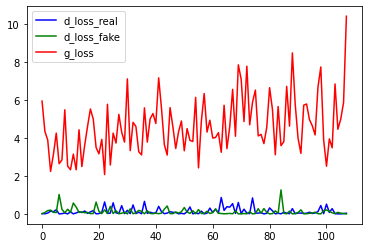

[108/200][0/938] Loss_D: 0.4150 Loss_G: 3.1134 D(x): 0.9399 D(G(z)): 0.2123 / 0.1329
[108/200][100/938] Loss_D: 0.0348 Loss_G: 5.9922 D(x): 0.9894 D(G(z)): 0.0222 / 0.0158
[108/200][200/938] Loss_D: 0.0358 Loss_G: 6.2153 D(x): 0.9722 D(G(z)): 0.0060 / 0.0104
[108/200][300/938] Loss_D: 0.1404 Loss_G: 4.3871 D(x): 0.9030 D(G(z)): 0.0248 / 0.0502
[108/200][400/938] Loss_D: 0.1641 Loss_G: 4.7980 D(x): 0.9053 D(G(z)): 0.0413 / 0.0318
[108/200][500/938] Loss_D: 0.0646 Loss_G: 6.9389 D(x): 0.9568 D(G(z)): 0.0039 / 0.0047
[108/200][600/938] Loss_D: 0.0535 Loss_G: 5.7466 D(x): 0.9928 D(G(z)): 0.0392 / 0.0273
[108/200][700/938] Loss_D: 0.1912 Loss_G: 3.8306 D(x): 0.9758 D(G(z)): 0.1384 / 0.0544
[108/200][800/938] Loss_D: 0.2204 Loss_G: 3.8121 D(x): 0.9875 D(G(z)): 0.1372 / 0.0777
[108/200][900/938] Loss_D: 0.1204 Loss_G: 5.8606 D(x): 0.9255 D(G(z)): 0.0276 / 0.0192


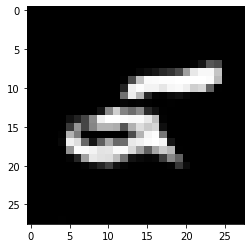

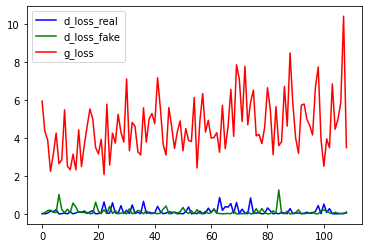

[109/200][0/938] Loss_D: 0.1622 Loss_G: 4.1041 D(x): 0.9886 D(G(z)): 0.1079 / 0.0685
[109/200][100/938] Loss_D: 0.0376 Loss_G: 6.0785 D(x): 0.9696 D(G(z)): 0.0050 / 0.0123
[109/200][200/938] Loss_D: 0.0931 Loss_G: 7.3844 D(x): 0.9243 D(G(z)): 0.0052 / 0.0068
[109/200][300/938] Loss_D: 0.0612 Loss_G: 4.8458 D(x): 0.9898 D(G(z)): 0.0454 / 0.0257
[109/200][400/938] Loss_D: 0.1959 Loss_G: 6.6193 D(x): 0.8460 D(G(z)): 0.0043 / 0.0055
[109/200][500/938] Loss_D: 0.0733 Loss_G: 5.1016 D(x): 0.9579 D(G(z)): 0.0214 / 0.0233
[109/200][600/938] Loss_D: 0.3439 Loss_G: 4.9647 D(x): 0.9931 D(G(z)): 0.1996 / 0.0292
[109/200][700/938] Loss_D: 0.1425 Loss_G: 6.5020 D(x): 0.9081 D(G(z)): 0.0316 / 0.0088
[109/200][800/938] Loss_D: 0.1178 Loss_G: 3.1088 D(x): 0.9570 D(G(z)): 0.0573 / 0.1098
[109/200][900/938] Loss_D: 0.1682 Loss_G: 4.1088 D(x): 0.9738 D(G(z)): 0.0996 / 0.0703


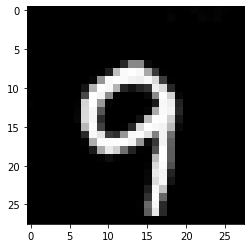

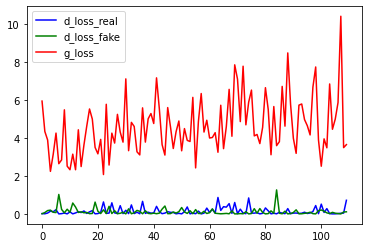

[110/200][0/938] Loss_D: 0.0729 Loss_G: 3.7105 D(x): 0.9588 D(G(z)): 0.0251 / 0.0574
[110/200][100/938] Loss_D: 0.0827 Loss_G: 5.5853 D(x): 0.9524 D(G(z)): 0.0268 / 0.0166
[110/200][200/938] Loss_D: 0.1131 Loss_G: 5.1297 D(x): 0.9111 D(G(z)): 0.0114 / 0.0239
[110/200][300/938] Loss_D: 0.0258 Loss_G: 7.0291 D(x): 0.9829 D(G(z)): 0.0081 / 0.0032
[110/200][400/938] Loss_D: 0.0950 Loss_G: 4.7154 D(x): 0.9582 D(G(z)): 0.0408 / 0.0412
[110/200][500/938] Loss_D: 0.0383 Loss_G: 4.8420 D(x): 0.9917 D(G(z)): 0.0258 / 0.0289
[110/200][600/938] Loss_D: 0.1826 Loss_G: 3.9638 D(x): 0.9834 D(G(z)): 0.1119 / 0.0745
[110/200][700/938] Loss_D: 0.1805 Loss_G: 6.0266 D(x): 0.8785 D(G(z)): 0.0279 / 0.0215
[110/200][800/938] Loss_D: 0.5009 Loss_G: 4.1453 D(x): 0.9879 D(G(z)): 0.2907 / 0.0433
[110/200][900/938] Loss_D: 0.0705 Loss_G: 5.3170 D(x): 0.9677 D(G(z)): 0.0316 / 0.0226


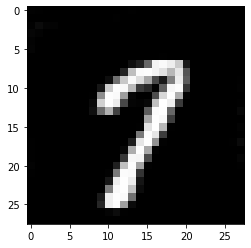

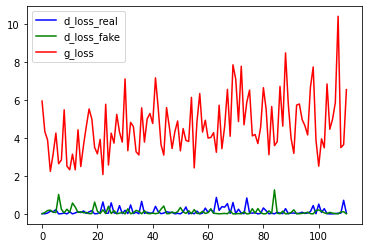

[111/200][0/938] Loss_D: 0.1682 Loss_G: 5.0123 D(x): 0.9658 D(G(z)): 0.0916 / 0.0417
[111/200][100/938] Loss_D: 0.0617 Loss_G: 8.7598 D(x): 0.9460 D(G(z)): 0.0012 / 0.0009
[111/200][200/938] Loss_D: 0.1083 Loss_G: 4.1876 D(x): 0.9714 D(G(z)): 0.0658 / 0.0566
[111/200][300/938] Loss_D: 0.0541 Loss_G: 4.2491 D(x): 0.9983 D(G(z)): 0.0415 / 0.0649
[111/200][400/938] Loss_D: 0.0902 Loss_G: 4.2177 D(x): 0.9983 D(G(z)): 0.0729 / 0.0631
[111/200][500/938] Loss_D: 0.0563 Loss_G: 4.5805 D(x): 0.9807 D(G(z)): 0.0333 / 0.0443
[111/200][600/938] Loss_D: 0.1223 Loss_G: 5.6419 D(x): 0.9139 D(G(z)): 0.0195 / 0.0163
[111/200][700/938] Loss_D: 0.1607 Loss_G: 4.1572 D(x): 0.9988 D(G(z)): 0.1296 / 0.0464
[111/200][800/938] Loss_D: 0.4530 Loss_G: 4.7289 D(x): 0.7446 D(G(z)): 0.0199 / 0.0370
[111/200][900/938] Loss_D: 0.0677 Loss_G: 4.7075 D(x): 0.9982 D(G(z)): 0.0545 / 0.0353


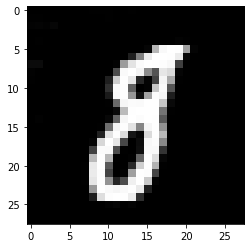

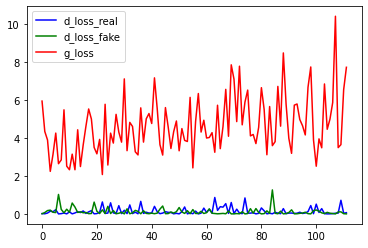

[112/200][0/938] Loss_D: 0.0689 Loss_G: 4.5145 D(x): 0.9862 D(G(z)): 0.0468 / 0.0312
[112/200][100/938] Loss_D: 0.0596 Loss_G: 6.0794 D(x): 0.9596 D(G(z)): 0.0133 / 0.0123
[112/200][200/938] Loss_D: 0.0816 Loss_G: 4.9007 D(x): 0.9943 D(G(z)): 0.0350 / 0.0446
[112/200][300/938] Loss_D: 0.1305 Loss_G: 3.9213 D(x): 0.9695 D(G(z)): 0.0704 / 0.0774
[112/200][400/938] Loss_D: 0.0320 Loss_G: 6.2955 D(x): 0.9769 D(G(z)): 0.0081 / 0.0065
[112/200][500/938] Loss_D: 0.0598 Loss_G: 8.5095 D(x): 0.9531 D(G(z)): 0.0047 / 0.0011
[112/200][600/938] Loss_D: 0.3110 Loss_G: 5.0029 D(x): 0.8159 D(G(z)): 0.0509 / 0.0691
[112/200][700/938] Loss_D: 0.0173 Loss_G: 6.5818 D(x): 0.9963 D(G(z)): 0.0129 / 0.0056
[112/200][800/938] Loss_D: 0.6248 Loss_G: 4.0770 D(x): 0.6878 D(G(z)): 0.0534 / 0.1082
[112/200][900/938] Loss_D: 0.0681 Loss_G: 4.9483 D(x): 0.9882 D(G(z)): 0.0513 / 0.0241


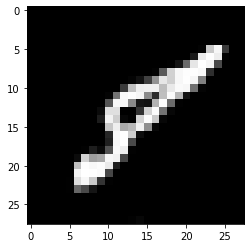

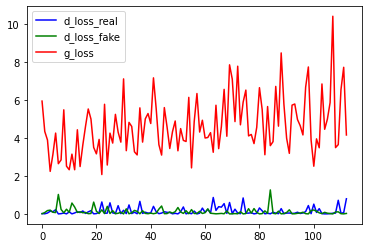

[113/200][0/938] Loss_D: 0.0913 Loss_G: 3.1338 D(x): 0.9914 D(G(z)): 0.0605 / 0.1545
[113/200][100/938] Loss_D: 0.1259 Loss_G: 4.7966 D(x): 0.9940 D(G(z)): 0.0914 / 0.0433
[113/200][200/938] Loss_D: 0.4905 Loss_G: 6.7860 D(x): 0.7011 D(G(z)): 0.0053 / 0.0083
[113/200][300/938] Loss_D: 0.5843 Loss_G: 2.5297 D(x): 0.9696 D(G(z)): 0.3171 / 0.1725
[113/200][400/938] Loss_D: 0.0227 Loss_G: 6.9780 D(x): 0.9859 D(G(z)): 0.0067 / 0.0048
[113/200][500/938] Loss_D: 0.1610 Loss_G: 3.2903 D(x): 0.9829 D(G(z)): 0.1149 / 0.0974
[113/200][600/938] Loss_D: 0.0604 Loss_G: 5.1389 D(x): 0.9803 D(G(z)): 0.0346 / 0.0273
[113/200][700/938] Loss_D: 0.0668 Loss_G: 5.5192 D(x): 0.9898 D(G(z)): 0.0458 / 0.0274
[113/200][800/938] Loss_D: 0.0431 Loss_G: 6.3121 D(x): 0.9752 D(G(z)): 0.0141 / 0.0131
[113/200][900/938] Loss_D: 0.0887 Loss_G: 5.6581 D(x): 0.9397 D(G(z)): 0.0158 / 0.0146


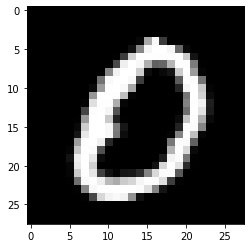

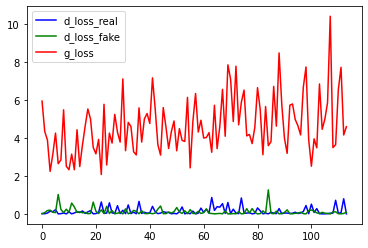

[114/200][0/938] Loss_D: 0.1586 Loss_G: 5.5248 D(x): 0.8965 D(G(z)): 0.0259 / 0.0187
[114/200][100/938] Loss_D: 0.3023 Loss_G: 5.1231 D(x): 0.7963 D(G(z)): 0.0125 / 0.0218
[114/200][200/938] Loss_D: 0.0285 Loss_G: 5.3092 D(x): 0.9853 D(G(z)): 0.0129 / 0.0178
[114/200][300/938] Loss_D: 0.0555 Loss_G: 7.0113 D(x): 0.9656 D(G(z)): 0.0120 / 0.0065
[114/200][400/938] Loss_D: 0.0457 Loss_G: 6.8390 D(x): 0.9791 D(G(z)): 0.0154 / 0.0117
[114/200][500/938] Loss_D: 0.1606 Loss_G: 4.3447 D(x): 0.9252 D(G(z)): 0.0537 / 0.0603
[114/200][600/938] Loss_D: 0.3467 Loss_G: 2.6836 D(x): 0.9993 D(G(z)): 0.2021 / 0.2077
[114/200][700/938] Loss_D: 0.0298 Loss_G: 6.3858 D(x): 0.9815 D(G(z)): 0.0097 / 0.0123
[114/200][800/938] Loss_D: 0.0907 Loss_G: 5.4195 D(x): 0.9735 D(G(z)): 0.0452 / 0.0280
[114/200][900/938] Loss_D: 0.1649 Loss_G: 7.2594 D(x): 0.8677 D(G(z)): 0.0019 / 0.0025


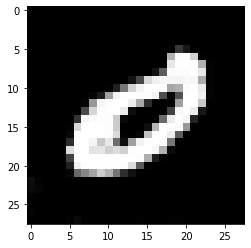

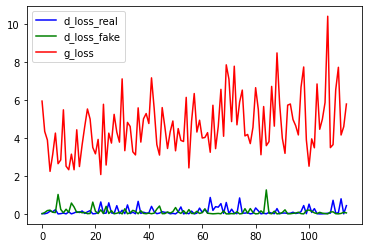

[115/200][0/938] Loss_D: 0.1372 Loss_G: 4.9050 D(x): 0.9344 D(G(z)): 0.0524 / 0.0300
[115/200][100/938] Loss_D: 0.1255 Loss_G: 4.8862 D(x): 0.9681 D(G(z)): 0.0770 / 0.0227
[115/200][200/938] Loss_D: 0.2019 Loss_G: 4.2919 D(x): 0.9425 D(G(z)): 0.0946 / 0.0656
[115/200][300/938] Loss_D: 0.1964 Loss_G: 3.4133 D(x): 0.9869 D(G(z)): 0.1325 / 0.0986
[115/200][400/938] Loss_D: 0.1902 Loss_G: 6.7829 D(x): 0.8553 D(G(z)): 0.0069 / 0.0082
[115/200][500/938] Loss_D: 0.3083 Loss_G: 4.4542 D(x): 0.8430 D(G(z)): 0.0768 / 0.0472
[115/200][600/938] Loss_D: 0.0708 Loss_G: 4.8310 D(x): 0.9913 D(G(z)): 0.0493 / 0.0310
[115/200][700/938] Loss_D: 0.2637 Loss_G: 5.6862 D(x): 0.8109 D(G(z)): 0.0156 / 0.0238
[115/200][800/938] Loss_D: 0.0220 Loss_G: 6.8417 D(x): 0.9855 D(G(z)): 0.0063 / 0.0053
[115/200][900/938] Loss_D: 0.0410 Loss_G: 5.4273 D(x): 0.9821 D(G(z)): 0.0220 / 0.0168


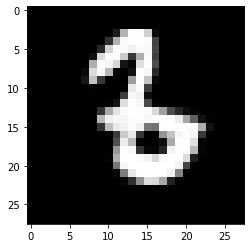

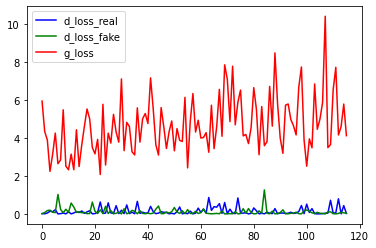

[116/200][0/938] Loss_D: 0.4510 Loss_G: 3.2589 D(x): 0.9816 D(G(z)): 0.2246 / 0.1479
[116/200][100/938] Loss_D: 0.0821 Loss_G: 4.4044 D(x): 0.9931 D(G(z)): 0.0621 / 0.0502
[116/200][200/938] Loss_D: 0.0947 Loss_G: 6.3249 D(x): 0.9226 D(G(z)): 0.0055 / 0.0107
[116/200][300/938] Loss_D: 0.0796 Loss_G: 5.3273 D(x): 0.9857 D(G(z)): 0.0505 / 0.0254
[116/200][400/938] Loss_D: 0.1239 Loss_G: 4.3351 D(x): 0.9098 D(G(z)): 0.0187 / 0.0436
[116/200][500/938] Loss_D: 0.1556 Loss_G: 4.2881 D(x): 0.9718 D(G(z)): 0.1023 / 0.0340
[116/200][600/938] Loss_D: 0.3248 Loss_G: 6.3684 D(x): 0.8100 D(G(z)): 0.0180 / 0.0157
[116/200][700/938] Loss_D: 0.0476 Loss_G: 4.9152 D(x): 0.9827 D(G(z)): 0.0271 / 0.0398
[116/200][800/938] Loss_D: 0.0299 Loss_G: 6.1609 D(x): 0.9785 D(G(z)): 0.0074 / 0.0069
[116/200][900/938] Loss_D: 0.4465 Loss_G: 4.9279 D(x): 0.8481 D(G(z)): 0.1708 / 0.0426


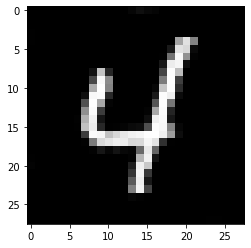

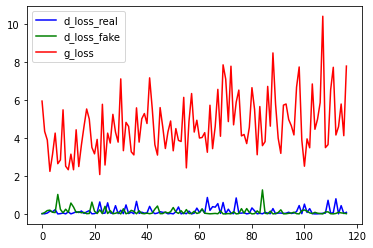

[117/200][0/938] Loss_D: 0.0818 Loss_G: 6.1796 D(x): 0.9632 D(G(z)): 0.0377 / 0.0109
[117/200][100/938] Loss_D: 0.1197 Loss_G: 6.8425 D(x): 0.9212 D(G(z)): 0.0182 / 0.0109
[117/200][200/938] Loss_D: 0.0188 Loss_G: 6.9633 D(x): 0.9872 D(G(z)): 0.0052 / 0.0050
[117/200][300/938] Loss_D: 0.0318 Loss_G: 5.9936 D(x): 0.9888 D(G(z)): 0.0185 / 0.0179
[117/200][400/938] Loss_D: 0.0637 Loss_G: 4.3738 D(x): 0.9943 D(G(z)): 0.0517 / 0.0433
[117/200][500/938] Loss_D: 0.0773 Loss_G: 5.3155 D(x): 0.9490 D(G(z)): 0.0175 / 0.0438
[117/200][600/938] Loss_D: 0.0317 Loss_G: 5.9110 D(x): 0.9831 D(G(z)): 0.0139 / 0.0162
[117/200][700/938] Loss_D: 0.2210 Loss_G: 6.1695 D(x): 0.8386 D(G(z)): 0.0073 / 0.0114
[117/200][800/938] Loss_D: 0.2016 Loss_G: 4.6886 D(x): 0.8499 D(G(z)): 0.0185 / 0.0393
[117/200][900/938] Loss_D: 0.0725 Loss_G: 6.1172 D(x): 0.9641 D(G(z)): 0.0291 / 0.0172


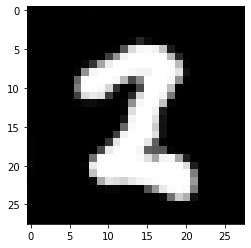

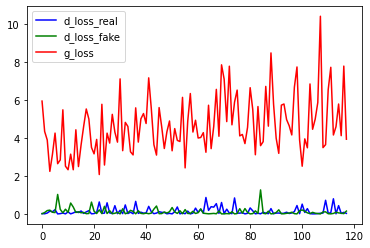

[118/200][0/938] Loss_D: 0.5152 Loss_G: 3.3032 D(x): 0.9989 D(G(z)): 0.2883 / 0.1218
[118/200][100/938] Loss_D: 0.1817 Loss_G: 3.5237 D(x): 0.9874 D(G(z)): 0.1097 / 0.0963
[118/200][200/938] Loss_D: 0.0393 Loss_G: 5.2635 D(x): 0.9894 D(G(z)): 0.0255 / 0.0313
[118/200][300/938] Loss_D: 0.1206 Loss_G: 4.5405 D(x): 0.9542 D(G(z)): 0.0533 / 0.0536
[118/200][400/938] Loss_D: 0.0819 Loss_G: 6.0892 D(x): 0.9707 D(G(z)): 0.0401 / 0.0133
[118/200][500/938] Loss_D: 0.0475 Loss_G: 6.6510 D(x): 0.9697 D(G(z)): 0.0120 / 0.0116
[118/200][600/938] Loss_D: 0.3568 Loss_G: 5.6315 D(x): 0.7545 D(G(z)): 0.0053 / 0.0198
[118/200][700/938] Loss_D: 0.1754 Loss_G: 7.0174 D(x): 0.8865 D(G(z)): 0.0202 / 0.0103
[118/200][800/938] Loss_D: 0.0279 Loss_G: 6.4441 D(x): 0.9826 D(G(z)): 0.0097 / 0.0109
[118/200][900/938] Loss_D: 0.1506 Loss_G: 8.1467 D(x): 0.9033 D(G(z)): 0.0156 / 0.0035


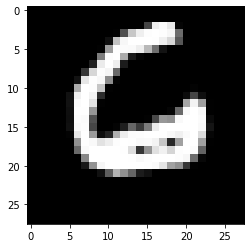

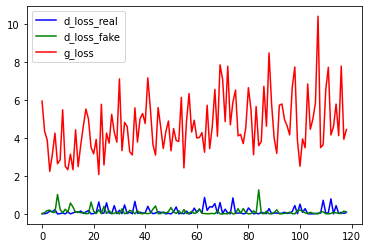

[119/200][0/938] Loss_D: 0.2386 Loss_G: 4.5609 D(x): 0.9584 D(G(z)): 0.1326 / 0.0525
[119/200][100/938] Loss_D: 0.0790 Loss_G: 4.7022 D(x): 0.9779 D(G(z)): 0.0478 / 0.0487
[119/200][200/938] Loss_D: 0.0667 Loss_G: 6.3426 D(x): 0.9782 D(G(z)): 0.0377 / 0.0169
[119/200][300/938] Loss_D: 0.2735 Loss_G: 3.5089 D(x): 0.8731 D(G(z)): 0.0783 / 0.0838
[119/200][400/938] Loss_D: 0.1215 Loss_G: 4.5641 D(x): 0.9675 D(G(z)): 0.0420 / 0.0477
[119/200][500/938] Loss_D: 0.1950 Loss_G: 4.1138 D(x): 0.9826 D(G(z)): 0.1380 / 0.0679
[119/200][600/938] Loss_D: 0.0879 Loss_G: 4.5336 D(x): 0.9581 D(G(z)): 0.0372 / 0.0277
[119/200][700/938] Loss_D: 0.0588 Loss_G: 5.1538 D(x): 0.9759 D(G(z)): 0.0273 / 0.0315
[119/200][800/938] Loss_D: 1.4912 Loss_G: 7.0544 D(x): 0.3517 D(G(z)): 0.0003 / 0.0046
[119/200][900/938] Loss_D: 0.0223 Loss_G: 4.4145 D(x): 0.9951 D(G(z)): 0.0168 / 0.0469


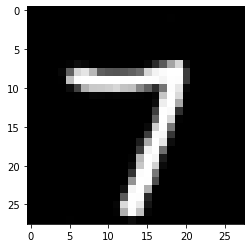

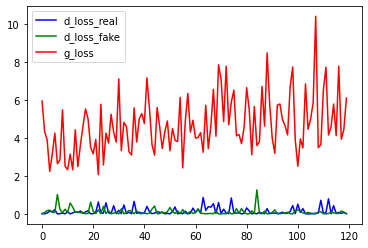

[120/200][0/938] Loss_D: 0.0874 Loss_G: 4.5205 D(x): 0.9724 D(G(z)): 0.0518 / 0.0434
[120/200][100/938] Loss_D: 0.1242 Loss_G: 4.2614 D(x): 0.9335 D(G(z)): 0.0320 / 0.0574
[120/200][200/938] Loss_D: 0.1557 Loss_G: 4.9042 D(x): 0.9110 D(G(z)): 0.0352 / 0.0443
[120/200][300/938] Loss_D: 0.0416 Loss_G: 4.5622 D(x): 0.9945 D(G(z)): 0.0329 / 0.0486
[120/200][400/938] Loss_D: 0.0270 Loss_G: 6.1244 D(x): 0.9791 D(G(z)): 0.0053 / 0.0103
[120/200][500/938] Loss_D: 0.2286 Loss_G: 3.7657 D(x): 0.9932 D(G(z)): 0.1369 / 0.0965
[120/200][600/938] Loss_D: 0.1790 Loss_G: 4.3403 D(x): 0.9994 D(G(z)): 0.1014 / 0.0654
[120/200][700/938] Loss_D: 0.1527 Loss_G: 4.1599 D(x): 0.9489 D(G(z)): 0.0756 / 0.0771
[120/200][800/938] Loss_D: 0.1061 Loss_G: 4.9837 D(x): 0.9375 D(G(z)): 0.0320 / 0.0327
[120/200][900/938] Loss_D: 0.1222 Loss_G: 5.0429 D(x): 0.9263 D(G(z)): 0.0277 / 0.0342


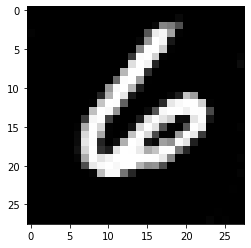

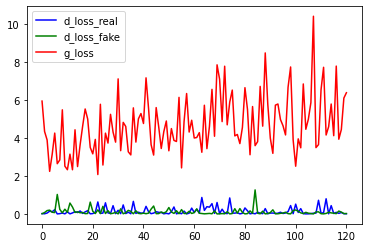

[121/200][0/938] Loss_D: 0.0578 Loss_G: 5.5864 D(x): 0.9920 D(G(z)): 0.0407 / 0.0169
[121/200][100/938] Loss_D: 0.0572 Loss_G: 6.5240 D(x): 0.9610 D(G(z)): 0.0143 / 0.0080
[121/200][200/938] Loss_D: 0.0435 Loss_G: 4.9363 D(x): 0.9965 D(G(z)): 0.0346 / 0.0352
[121/200][300/938] Loss_D: 0.2745 Loss_G: 5.6384 D(x): 0.8505 D(G(z)): 0.0450 / 0.0226
[121/200][400/938] Loss_D: 0.0787 Loss_G: 5.6147 D(x): 0.9579 D(G(z)): 0.0253 / 0.0131
[121/200][500/938] Loss_D: 0.2294 Loss_G: 8.7247 D(x): 0.8532 D(G(z)): 0.0010 / 0.0010
[121/200][600/938] Loss_D: 0.1760 Loss_G: 4.8396 D(x): 0.9994 D(G(z)): 0.1041 / 0.0489
[121/200][700/938] Loss_D: 0.1293 Loss_G: 4.1175 D(x): 0.9805 D(G(z)): 0.0896 / 0.0626
[121/200][800/938] Loss_D: 0.0856 Loss_G: 3.8620 D(x): 0.9775 D(G(z)): 0.0546 / 0.0671
[121/200][900/938] Loss_D: 0.5554 Loss_G: 6.0347 D(x): 0.6781 D(G(z)): 0.0045 / 0.0149


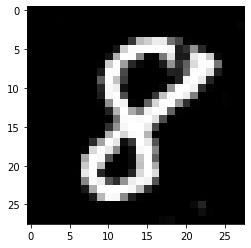

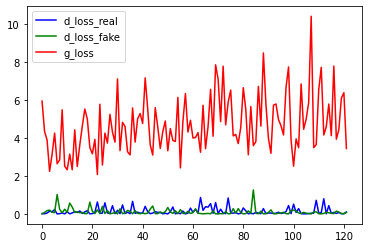

[122/200][0/938] Loss_D: 0.1091 Loss_G: 3.5668 D(x): 0.9973 D(G(z)): 0.0827 / 0.1044
[122/200][100/938] Loss_D: 0.0856 Loss_G: 4.0366 D(x): 0.9970 D(G(z)): 0.0685 / 0.0725
[122/200][200/938] Loss_D: 0.1147 Loss_G: 3.5059 D(x): 0.9938 D(G(z)): 0.0864 / 0.0857
[122/200][300/938] Loss_D: 0.3130 Loss_G: 4.1088 D(x): 0.9995 D(G(z)): 0.1826 / 0.0654
[122/200][400/938] Loss_D: 0.1200 Loss_G: 5.9366 D(x): 0.9469 D(G(z)): 0.0396 / 0.0203
[122/200][500/938] Loss_D: 0.3382 Loss_G: 6.8632 D(x): 0.7697 D(G(z)): 0.0018 / 0.0040
[122/200][600/938] Loss_D: 0.0519 Loss_G: 5.1517 D(x): 0.9916 D(G(z)): 0.0350 / 0.0316
[122/200][700/938] Loss_D: 0.1062 Loss_G: 5.0572 D(x): 0.9488 D(G(z)): 0.0423 / 0.0374
[122/200][800/938] Loss_D: 0.1383 Loss_G: 5.7165 D(x): 0.9019 D(G(z)): 0.0200 / 0.0231
[122/200][900/938] Loss_D: 0.0290 Loss_G: 4.9713 D(x): 0.9934 D(G(z)): 0.0211 / 0.0319


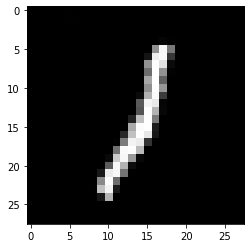

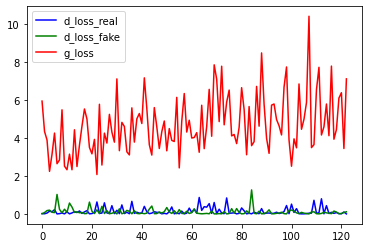

[123/200][0/938] Loss_D: 0.0588 Loss_G: 7.2212 D(x): 0.9688 D(G(z)): 0.0224 / 0.0058
[123/200][100/938] Loss_D: 0.0867 Loss_G: 9.6346 D(x): 0.9232 D(G(z)): 0.0007 / 0.0006
[123/200][200/938] Loss_D: 0.0893 Loss_G: 5.0325 D(x): 0.9988 D(G(z)): 0.0746 / 0.0235
[123/200][300/938] Loss_D: 0.0441 Loss_G: 8.4038 D(x): 0.9614 D(G(z)): 0.0024 / 0.0021
[123/200][400/938] Loss_D: 0.1399 Loss_G: 3.8524 D(x): 0.9570 D(G(z)): 0.0773 / 0.0670
[123/200][500/938] Loss_D: 0.0362 Loss_G: 4.9854 D(x): 0.9947 D(G(z)): 0.0286 / 0.0290
[123/200][600/938] Loss_D: 0.3618 Loss_G: 3.4037 D(x): 0.8501 D(G(z)): 0.1267 / 0.1069
[123/200][700/938] Loss_D: 0.2677 Loss_G: 7.0255 D(x): 0.8180 D(G(z)): 0.0238 / 0.0061
[123/200][800/938] Loss_D: 0.1017 Loss_G: 5.6539 D(x): 0.9834 D(G(z)): 0.0494 / 0.0314
[123/200][900/938] Loss_D: 1.0539 Loss_G: 6.4830 D(x): 0.4783 D(G(z)): 0.0068 / 0.0238


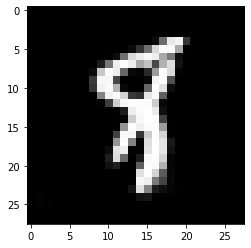

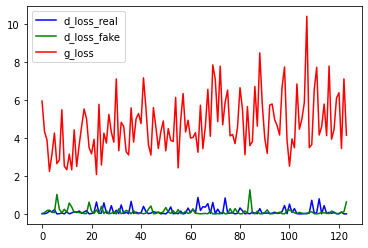

[124/200][0/938] Loss_D: 0.1984 Loss_G: 5.1011 D(x): 0.9964 D(G(z)): 0.1288 / 0.0361
[124/200][100/938] Loss_D: 0.0759 Loss_G: 4.4089 D(x): 0.9771 D(G(z)): 0.0472 / 0.0307
[124/200][200/938] Loss_D: 0.0494 Loss_G: 5.9955 D(x): 0.9763 D(G(z)): 0.0225 / 0.0183
[124/200][300/938] Loss_D: 0.0986 Loss_G: 5.7385 D(x): 0.9354 D(G(z)): 0.0210 / 0.0189
[124/200][400/938] Loss_D: 0.2284 Loss_G: 5.8620 D(x): 0.8481 D(G(z)): 0.0219 / 0.0202
[124/200][500/938] Loss_D: 0.0204 Loss_G: 6.6557 D(x): 0.9879 D(G(z)): 0.0077 / 0.0064
[124/200][600/938] Loss_D: 0.1470 Loss_G: 5.4833 D(x): 0.9087 D(G(z)): 0.0209 / 0.0210
[124/200][700/938] Loss_D: 0.0679 Loss_G: 5.3881 D(x): 0.9599 D(G(z)): 0.0226 / 0.0239
[124/200][800/938] Loss_D: 0.1270 Loss_G: 7.0792 D(x): 0.8955 D(G(z)): 0.0060 / 0.0055
[124/200][900/938] Loss_D: 0.0651 Loss_G: 6.8987 D(x): 0.9552 D(G(z)): 0.0121 / 0.0081


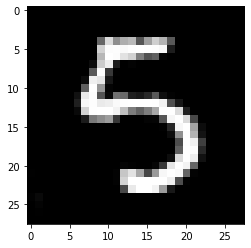

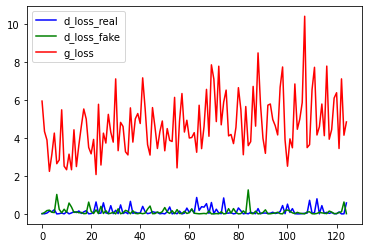

[125/200][0/938] Loss_D: 0.0750 Loss_G: 3.8944 D(x): 0.9739 D(G(z)): 0.0430 / 0.0730
[125/200][100/938] Loss_D: 0.0311 Loss_G: 5.0471 D(x): 0.9856 D(G(z)): 0.0110 / 0.0242
[125/200][200/938] Loss_D: 0.1551 Loss_G: 4.4569 D(x): 0.9117 D(G(z)): 0.0392 / 0.0592
[125/200][300/938] Loss_D: 0.1636 Loss_G: 4.2008 D(x): 0.9934 D(G(z)): 0.1172 / 0.0580
[125/200][400/938] Loss_D: 0.0975 Loss_G: 4.1213 D(x): 0.9820 D(G(z)): 0.0586 / 0.0587
[125/200][500/938] Loss_D: 0.0555 Loss_G: 5.5272 D(x): 0.9764 D(G(z)): 0.0214 / 0.0226
[125/200][600/938] Loss_D: 0.1404 Loss_G: 3.7207 D(x): 0.9561 D(G(z)): 0.0803 / 0.0757
[125/200][700/938] Loss_D: 0.1209 Loss_G: 6.2305 D(x): 0.9139 D(G(z)): 0.0227 / 0.0173
[125/200][800/938] Loss_D: 0.3325 Loss_G: 3.1150 D(x): 0.8563 D(G(z)): 0.0918 / 0.1412
[125/200][900/938] Loss_D: 0.0426 Loss_G: 6.5044 D(x): 0.9680 D(G(z)): 0.0049 / 0.0058


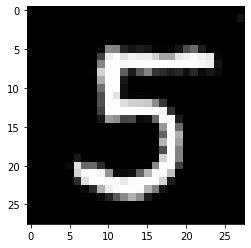

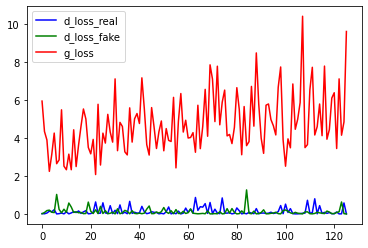

[126/200][0/938] Loss_D: 0.0486 Loss_G: 5.9310 D(x): 0.9760 D(G(z)): 0.0215 / 0.0142
[126/200][100/938] Loss_D: 0.0905 Loss_G: 5.2057 D(x): 0.9531 D(G(z)): 0.0360 / 0.0220
[126/200][200/938] Loss_D: 0.0778 Loss_G: 5.2356 D(x): 0.9552 D(G(z)): 0.0255 / 0.0299
[126/200][300/938] Loss_D: 0.0479 Loss_G: 6.6396 D(x): 0.9772 D(G(z)): 0.0217 / 0.0152
[126/200][400/938] Loss_D: 0.0584 Loss_G: 6.1193 D(x): 0.9650 D(G(z)): 0.0189 / 0.0126
[126/200][500/938] Loss_D: 0.2087 Loss_G: 3.5959 D(x): 0.9817 D(G(z)): 0.1428 / 0.0915
[126/200][600/938] Loss_D: 0.0523 Loss_G: 6.7866 D(x): 0.9724 D(G(z)): 0.0171 / 0.0120
[126/200][700/938] Loss_D: 0.2375 Loss_G: 8.1692 D(x): 0.8385 D(G(z)): 0.0010 / 0.0014
[126/200][800/938] Loss_D: 0.2865 Loss_G: 2.9436 D(x): 0.9639 D(G(z)): 0.1816 / 0.1745
[126/200][900/938] Loss_D: 0.3607 Loss_G: 7.2985 D(x): 0.7860 D(G(z)): 0.0084 / 0.0050


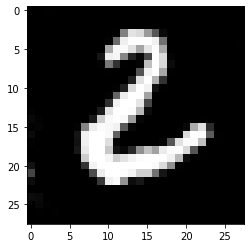

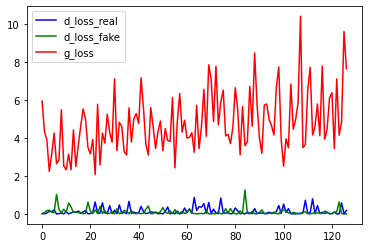

[127/200][0/938] Loss_D: 0.0490 Loss_G: 5.6804 D(x): 0.9763 D(G(z)): 0.0187 / 0.0181
[127/200][100/938] Loss_D: 0.0578 Loss_G: 4.3015 D(x): 0.9721 D(G(z)): 0.0251 / 0.0534
[127/200][200/938] Loss_D: 0.0508 Loss_G: 4.6944 D(x): 0.9929 D(G(z)): 0.0394 / 0.0404
[127/200][300/938] Loss_D: 0.1139 Loss_G: 5.6483 D(x): 0.9151 D(G(z)): 0.0155 / 0.0121
[127/200][400/938] Loss_D: 0.2022 Loss_G: 4.2356 D(x): 0.9868 D(G(z)): 0.1254 / 0.0874
[127/200][500/938] Loss_D: 0.1115 Loss_G: 4.9147 D(x): 0.9967 D(G(z)): 0.0865 / 0.0446
[127/200][600/938] Loss_D: 0.0547 Loss_G: 5.5733 D(x): 0.9773 D(G(z)): 0.0249 / 0.0231
[127/200][700/938] Loss_D: 0.0115 Loss_G: 5.8981 D(x): 0.9981 D(G(z)): 0.0092 / 0.0133
[127/200][800/938] Loss_D: 0.4857 Loss_G: 4.0497 D(x): 0.9959 D(G(z)): 0.2592 / 0.0719
[127/200][900/938] Loss_D: 0.0489 Loss_G: 5.5721 D(x): 0.9961 D(G(z)): 0.0356 / 0.0268


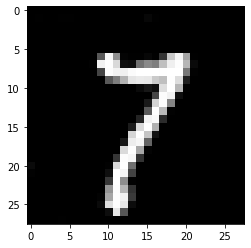

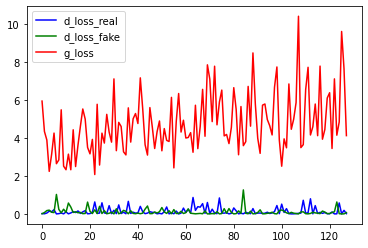

[128/200][0/938] Loss_D: 0.0983 Loss_G: 4.3287 D(x): 0.9947 D(G(z)): 0.0649 / 0.0721
[128/200][100/938] Loss_D: 0.0721 Loss_G: 7.4104 D(x): 0.9426 D(G(z)): 0.0073 / 0.0072
[128/200][200/938] Loss_D: 0.0694 Loss_G: 6.4159 D(x): 0.9482 D(G(z)): 0.0122 / 0.0107
[128/200][300/938] Loss_D: 0.1082 Loss_G: 7.6202 D(x): 0.9237 D(G(z)): 0.0137 / 0.0088
[128/200][400/938] Loss_D: 0.0492 Loss_G: 8.1484 D(x): 0.9569 D(G(z)): 0.0032 / 0.0020
[128/200][500/938] Loss_D: 0.0212 Loss_G: 6.7071 D(x): 0.9866 D(G(z)): 0.0074 / 0.0045
[128/200][600/938] Loss_D: 0.1270 Loss_G: 5.4106 D(x): 0.9754 D(G(z)): 0.0694 / 0.0307
[128/200][700/938] Loss_D: 0.1697 Loss_G: 4.9594 D(x): 0.8940 D(G(z)): 0.0251 / 0.0233
[128/200][800/938] Loss_D: 0.1684 Loss_G: 4.1204 D(x): 0.9906 D(G(z)): 0.1240 / 0.0678
[128/200][900/938] Loss_D: 0.0230 Loss_G: 5.7575 D(x): 0.9871 D(G(z)): 0.0085 / 0.0140


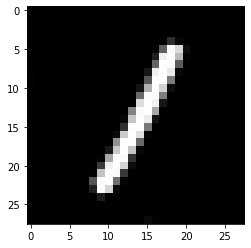

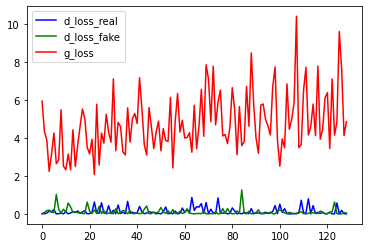

[129/200][0/938] Loss_D: 0.1462 Loss_G: 4.2561 D(x): 0.9791 D(G(z)): 0.0847 / 0.0538
[129/200][100/938] Loss_D: 0.0331 Loss_G: 4.7142 D(x): 0.9906 D(G(z)): 0.0212 / 0.0496
[129/200][200/938] Loss_D: 0.2620 Loss_G: 5.8877 D(x): 0.8297 D(G(z)): 0.0277 / 0.0305
[129/200][300/938] Loss_D: 0.2502 Loss_G: 3.7532 D(x): 0.8991 D(G(z)): 0.0855 / 0.1012
[129/200][400/938] Loss_D: 0.0665 Loss_G: 5.8219 D(x): 0.9462 D(G(z)): 0.0055 / 0.0100
[129/200][500/938] Loss_D: 0.0516 Loss_G: 5.1555 D(x): 0.9959 D(G(z)): 0.0405 / 0.0345
[129/200][600/938] Loss_D: 0.0783 Loss_G: 4.9611 D(x): 0.9737 D(G(z)): 0.0427 / 0.0311
[129/200][700/938] Loss_D: 0.0691 Loss_G: 6.2556 D(x): 0.9501 D(G(z)): 0.0138 / 0.0113
[129/200][800/938] Loss_D: 0.0551 Loss_G: 5.5447 D(x): 0.9946 D(G(z)): 0.0451 / 0.0171
[129/200][900/938] Loss_D: 0.0843 Loss_G: 4.4344 D(x): 0.9580 D(G(z)): 0.0338 / 0.0596


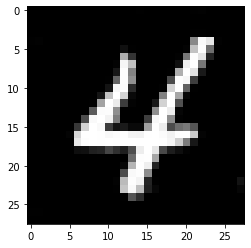

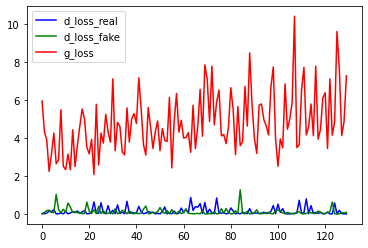

[130/200][0/938] Loss_D: 0.0697 Loss_G: 5.6184 D(x): 0.9957 D(G(z)): 0.0571 / 0.0152
[130/200][100/938] Loss_D: 0.1309 Loss_G: 3.9646 D(x): 0.9350 D(G(z)): 0.0425 / 0.0961
[130/200][200/938] Loss_D: 0.0245 Loss_G: 7.3961 D(x): 0.9842 D(G(z)): 0.0075 / 0.0048
[130/200][300/938] Loss_D: 0.1799 Loss_G: 4.5774 D(x): 0.9500 D(G(z)): 0.0816 / 0.0426
[130/200][400/938] Loss_D: 0.0724 Loss_G: 5.0303 D(x): 0.9887 D(G(z)): 0.0542 / 0.0290
[130/200][500/938] Loss_D: 0.1734 Loss_G: 5.5774 D(x): 0.9102 D(G(z)): 0.0215 / 0.0252
[130/200][600/938] Loss_D: 0.2255 Loss_G: 4.5855 D(x): 0.9197 D(G(z)): 0.0853 / 0.0466
[130/200][700/938] Loss_D: 0.3031 Loss_G: 2.4940 D(x): 0.9812 D(G(z)): 0.1537 / 0.1966
[130/200][800/938] Loss_D: 0.1943 Loss_G: 7.6462 D(x): 0.8590 D(G(z)): 0.0015 / 0.0022
[130/200][900/938] Loss_D: 0.0552 Loss_G: 5.1385 D(x): 0.9937 D(G(z)): 0.0452 / 0.0283


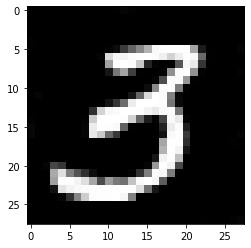

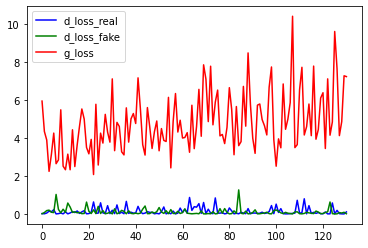

[131/200][0/938] Loss_D: 0.2228 Loss_G: 7.1631 D(x): 0.8229 D(G(z)): 0.0036 / 0.0045
[131/200][100/938] Loss_D: 0.1963 Loss_G: 5.9645 D(x): 0.8561 D(G(z)): 0.0087 / 0.0089
[131/200][200/938] Loss_D: 0.0374 Loss_G: 7.0984 D(x): 0.9697 D(G(z)): 0.0058 / 0.0046
[131/200][300/938] Loss_D: 0.0825 Loss_G: 4.7385 D(x): 0.9979 D(G(z)): 0.0639 / 0.0535
[131/200][400/938] Loss_D: 0.1999 Loss_G: 3.1688 D(x): 0.9404 D(G(z)): 0.0959 / 0.1213
[131/200][500/938] Loss_D: 0.0279 Loss_G: 6.6914 D(x): 0.9857 D(G(z)): 0.0126 / 0.0076
[131/200][600/938] Loss_D: 0.1120 Loss_G: 5.6531 D(x): 0.9226 D(G(z)): 0.0242 / 0.0169
[131/200][700/938] Loss_D: 0.0405 Loss_G: 5.3332 D(x): 0.9827 D(G(z)): 0.0198 / 0.0210
[131/200][800/938] Loss_D: 0.0725 Loss_G: 4.8441 D(x): 0.9744 D(G(z)): 0.0408 / 0.0387
[131/200][900/938] Loss_D: 0.0713 Loss_G: 6.3356 D(x): 0.9843 D(G(z)): 0.0292 / 0.0181


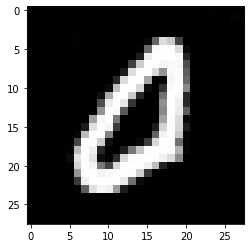

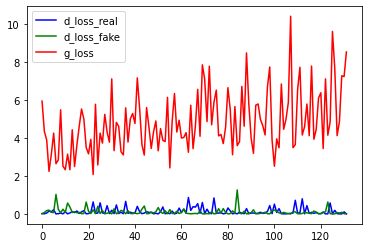

[132/200][0/938] Loss_D: 0.1143 Loss_G: 5.4645 D(x): 0.9330 D(G(z)): 0.0360 / 0.0241
[132/200][100/938] Loss_D: 0.0375 Loss_G: 7.4537 D(x): 0.9753 D(G(z)): 0.0103 / 0.0048
[132/200][200/938] Loss_D: 0.4118 Loss_G: 3.8111 D(x): 0.9939 D(G(z)): 0.2501 / 0.0853
[132/200][300/938] Loss_D: 0.0568 Loss_G: 8.2503 D(x): 0.9702 D(G(z)): 0.0170 / 0.0088
[132/200][400/938] Loss_D: 0.1106 Loss_G: 4.1010 D(x): 0.9337 D(G(z)): 0.0291 / 0.0611
[132/200][500/938] Loss_D: 0.1654 Loss_G: 4.8316 D(x): 0.9332 D(G(z)): 0.0534 / 0.0452
[132/200][600/938] Loss_D: 0.0861 Loss_G: 5.4410 D(x): 0.9655 D(G(z)): 0.0390 / 0.0275
[132/200][700/938] Loss_D: 0.0678 Loss_G: 5.2249 D(x): 0.9993 D(G(z)): 0.0409 / 0.0322
[132/200][800/938] Loss_D: 0.2849 Loss_G: 3.3750 D(x): 0.9969 D(G(z)): 0.1766 / 0.1212
[132/200][900/938] Loss_D: 0.2171 Loss_G: 4.0298 D(x): 0.8582 D(G(z)): 0.0317 / 0.0524


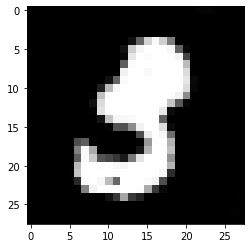

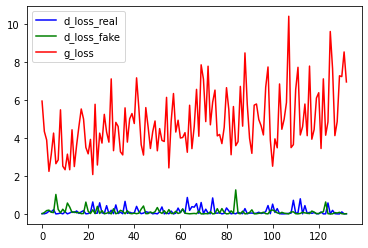

[133/200][0/938] Loss_D: 0.0181 Loss_G: 7.1207 D(x): 0.9953 D(G(z)): 0.0124 / 0.0085
[133/200][100/938] Loss_D: 0.1605 Loss_G: 6.9742 D(x): 0.8817 D(G(z)): 0.0074 / 0.0051
[133/200][200/938] Loss_D: 0.0315 Loss_G: 6.2701 D(x): 0.9892 D(G(z)): 0.0193 / 0.0126
[133/200][300/938] Loss_D: 0.0214 Loss_G: 8.1860 D(x): 0.9821 D(G(z)): 0.0027 / 0.0013
[133/200][400/938] Loss_D: 0.0720 Loss_G: 8.5646 D(x): 0.9459 D(G(z)): 0.0026 / 0.0018
[133/200][500/938] Loss_D: 0.2441 Loss_G: 7.2009 D(x): 0.8271 D(G(z)): 0.0106 / 0.0107
[133/200][600/938] Loss_D: 0.0589 Loss_G: 4.9019 D(x): 0.9945 D(G(z)): 0.0400 / 0.0539
[133/200][700/938] Loss_D: 0.1296 Loss_G: 5.0721 D(x): 0.9150 D(G(z)): 0.0229 / 0.0291
[133/200][800/938] Loss_D: 0.1189 Loss_G: 5.0170 D(x): 0.9147 D(G(z)): 0.0154 / 0.0289
[133/200][900/938] Loss_D: 0.1318 Loss_G: 4.1083 D(x): 0.9743 D(G(z)): 0.0815 / 0.0898


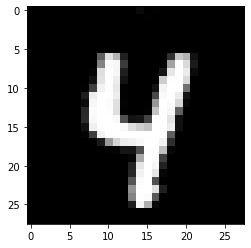

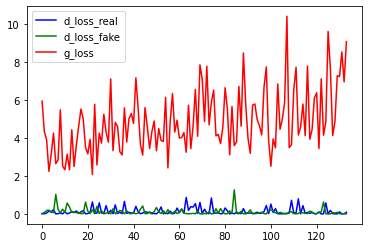

[134/200][0/938] Loss_D: 0.3636 Loss_G: 6.5910 D(x): 0.7443 D(G(z)): 0.0029 / 0.0121
[134/200][100/938] Loss_D: 0.1164 Loss_G: 4.8481 D(x): 0.9969 D(G(z)): 0.0903 / 0.0356
[134/200][200/938] Loss_D: 0.0740 Loss_G: 4.3562 D(x): 0.9907 D(G(z)): 0.0494 / 0.0687
[134/200][300/938] Loss_D: 0.2275 Loss_G: 4.8050 D(x): 0.9125 D(G(z)): 0.0868 / 0.0563
[134/200][400/938] Loss_D: 0.2212 Loss_G: 5.0760 D(x): 0.8792 D(G(z)): 0.0266 / 0.0314
[134/200][500/938] Loss_D: 0.1584 Loss_G: 3.8120 D(x): 0.8964 D(G(z)): 0.0207 / 0.0933
[134/200][600/938] Loss_D: 0.5962 Loss_G: 3.2217 D(x): 0.8388 D(G(z)): 0.2411 / 0.0942
[134/200][700/938] Loss_D: 0.0598 Loss_G: 6.3337 D(x): 0.9603 D(G(z)): 0.0157 / 0.0141
[134/200][800/938] Loss_D: 0.5693 Loss_G: 2.9389 D(x): 0.9976 D(G(z)): 0.3128 / 0.1246
[134/200][900/938] Loss_D: 0.1415 Loss_G: 5.6530 D(x): 0.9806 D(G(z)): 0.0911 / 0.0193


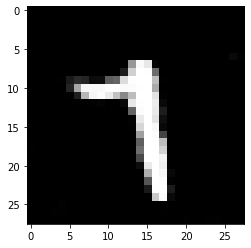

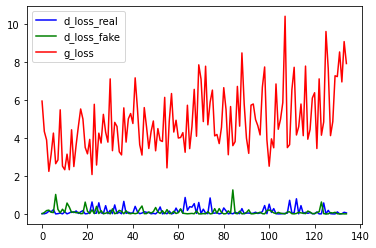

[135/200][0/938] Loss_D: 0.0495 Loss_G: 4.8855 D(x): 0.9967 D(G(z)): 0.0400 / 0.0336
[135/200][100/938] Loss_D: 0.0543 Loss_G: 8.2214 D(x): 0.9546 D(G(z)): 0.0040 / 0.0031
[135/200][200/938] Loss_D: 0.3236 Loss_G: 8.1043 D(x): 0.7712 D(G(z)): 0.0012 / 0.0026
[135/200][300/938] Loss_D: 0.0882 Loss_G: 5.0813 D(x): 0.9843 D(G(z)): 0.0577 / 0.0298
[135/200][400/938] Loss_D: 0.0657 Loss_G: 6.2804 D(x): 0.9517 D(G(z)): 0.0120 / 0.0127
[135/200][500/938] Loss_D: 0.0842 Loss_G: 4.8229 D(x): 0.9794 D(G(z)): 0.0540 / 0.0393
[135/200][600/938] Loss_D: 0.1270 Loss_G: 4.8300 D(x): 0.9949 D(G(z)): 0.0814 / 0.0500
[135/200][700/938] Loss_D: 0.2159 Loss_G: 7.0969 D(x): 0.8389 D(G(z)): 0.0100 / 0.0133
[135/200][800/938] Loss_D: 0.0893 Loss_G: 6.7157 D(x): 0.9294 D(G(z)): 0.0082 / 0.0069
[135/200][900/938] Loss_D: 0.0865 Loss_G: 5.9746 D(x): 0.9620 D(G(z)): 0.0245 / 0.0191


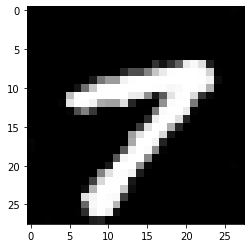

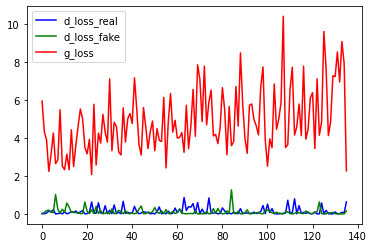

[136/200][0/938] Loss_D: 0.0496 Loss_G: 3.9816 D(x): 0.9931 D(G(z)): 0.0384 / 0.1098
[136/200][100/938] Loss_D: 0.2326 Loss_G: 3.9850 D(x): 0.8936 D(G(z)): 0.0590 / 0.0842
[136/200][200/938] Loss_D: 0.1116 Loss_G: 6.9184 D(x): 0.9234 D(G(z)): 0.0200 / 0.0120
[136/200][300/938] Loss_D: 0.2696 Loss_G: 5.7493 D(x): 0.8216 D(G(z)): 0.0148 / 0.0276
[136/200][400/938] Loss_D: 0.3574 Loss_G: 5.2296 D(x): 0.7746 D(G(z)): 0.0210 / 0.0292
[136/200][500/938] Loss_D: 0.1744 Loss_G: 7.3517 D(x): 0.8868 D(G(z)): 0.0166 / 0.0042
[136/200][600/938] Loss_D: 0.0809 Loss_G: 5.0669 D(x): 0.9566 D(G(z)): 0.0293 / 0.0316
[136/200][700/938] Loss_D: 0.1937 Loss_G: 3.6023 D(x): 0.9918 D(G(z)): 0.1353 / 0.1057
[136/200][800/938] Loss_D: 0.0821 Loss_G: 4.6301 D(x): 0.9932 D(G(z)): 0.0565 / 0.0501
[136/200][900/938] Loss_D: 0.0396 Loss_G: 5.8121 D(x): 0.9749 D(G(z)): 0.0127 / 0.0136


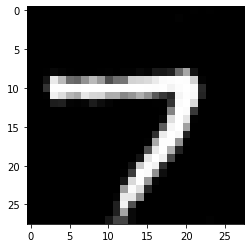

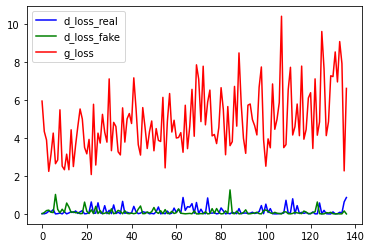

[137/200][0/938] Loss_D: 0.0106 Loss_G: 5.6537 D(x): 0.9972 D(G(z)): 0.0076 / 0.0299
[137/200][100/938] Loss_D: 0.1093 Loss_G: 5.3856 D(x): 0.9401 D(G(z)): 0.0358 / 0.0284
[137/200][200/938] Loss_D: 0.1078 Loss_G: 4.1223 D(x): 0.9923 D(G(z)): 0.0799 / 0.0577
[137/200][300/938] Loss_D: 0.0150 Loss_G: 7.6903 D(x): 0.9904 D(G(z)): 0.0052 / 0.0038
[137/200][400/938] Loss_D: 0.0695 Loss_G: 5.1505 D(x): 0.9975 D(G(z)): 0.0524 / 0.0355
[137/200][500/938] Loss_D: 0.0166 Loss_G: 6.2122 D(x): 0.9947 D(G(z)): 0.0110 / 0.0072
[137/200][600/938] Loss_D: 0.1369 Loss_G: 5.3610 D(x): 0.9983 D(G(z)): 0.0641 / 0.0519
[137/200][700/938] Loss_D: 0.0915 Loss_G: 4.9015 D(x): 0.9949 D(G(z)): 0.0709 / 0.0691
[137/200][800/938] Loss_D: 0.0369 Loss_G: 5.4505 D(x): 0.9824 D(G(z)): 0.0176 / 0.0192
[137/200][900/938] Loss_D: 0.0718 Loss_G: 5.7531 D(x): 0.9508 D(G(z)): 0.0180 / 0.0273


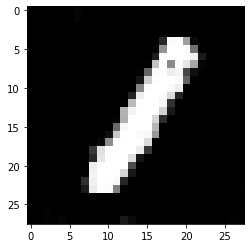

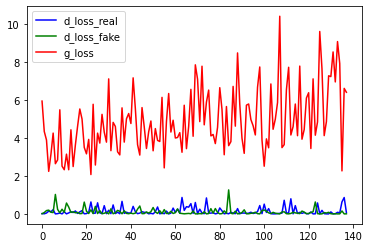

[138/200][0/938] Loss_D: 0.0883 Loss_G: 5.3867 D(x): 0.9406 D(G(z)): 0.0199 / 0.0218
[138/200][100/938] Loss_D: 0.0635 Loss_G: 7.3458 D(x): 0.9569 D(G(z)): 0.0017 / 0.0044
[138/200][200/938] Loss_D: 1.3275 Loss_G: 2.7607 D(x): 0.9882 D(G(z)): 0.5022 / 0.1822
[138/200][300/938] Loss_D: 0.1753 Loss_G: 5.2595 D(x): 0.9078 D(G(z)): 0.0514 / 0.0263
[138/200][400/938] Loss_D: 0.1401 Loss_G: 5.7926 D(x): 0.9344 D(G(z)): 0.0532 / 0.0218
[138/200][500/938] Loss_D: 0.0627 Loss_G: 5.6905 D(x): 0.9805 D(G(z)): 0.0341 / 0.0290
[138/200][600/938] Loss_D: 0.0482 Loss_G: 5.3010 D(x): 0.9965 D(G(z)): 0.0405 / 0.0197
[138/200][700/938] Loss_D: 0.0949 Loss_G: 6.5015 D(x): 0.9288 D(G(z)): 0.0112 / 0.0122
[138/200][800/938] Loss_D: 0.0779 Loss_G: 4.8290 D(x): 0.9569 D(G(z)): 0.0272 / 0.0401
[138/200][900/938] Loss_D: 0.0702 Loss_G: 8.6667 D(x): 0.9438 D(G(z)): 0.0031 / 0.0019


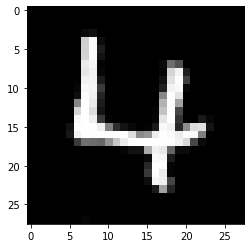

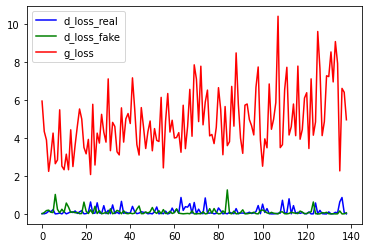

[139/200][0/938] Loss_D: 0.1414 Loss_G: 4.8637 D(x): 0.9750 D(G(z)): 0.0767 / 0.0545
[139/200][100/938] Loss_D: 0.1567 Loss_G: 6.1391 D(x): 0.8967 D(G(z)): 0.0149 / 0.0213
[139/200][200/938] Loss_D: 0.2017 Loss_G: 3.4662 D(x): 0.8672 D(G(z)): 0.0261 / 0.1117
[139/200][300/938] Loss_D: 0.1405 Loss_G: 6.9935 D(x): 0.8871 D(G(z)): 0.0020 / 0.0038
[139/200][400/938] Loss_D: 0.1793 Loss_G: 3.0692 D(x): 0.9963 D(G(z)): 0.1369 / 0.1107
[139/200][500/938] Loss_D: 0.0548 Loss_G: 6.1094 D(x): 0.9737 D(G(z)): 0.0219 / 0.0173
[139/200][600/938] Loss_D: 0.0282 Loss_G: 6.8105 D(x): 0.9893 D(G(z)): 0.0152 / 0.0107
[139/200][700/938] Loss_D: 0.0759 Loss_G: 5.3963 D(x): 0.9942 D(G(z)): 0.0576 / 0.0283
[139/200][800/938] Loss_D: 0.1834 Loss_G: 3.8610 D(x): 0.9888 D(G(z)): 0.1206 / 0.0801
[139/200][900/938] Loss_D: 0.0312 Loss_G: 9.3992 D(x): 0.9735 D(G(z)): 0.0007 / 0.0009


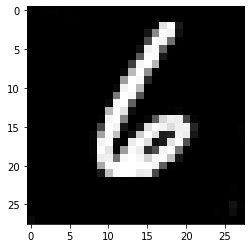

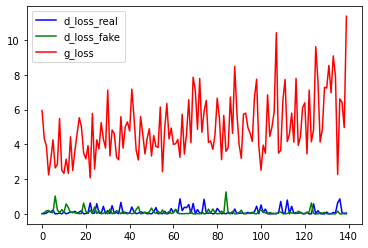

[140/200][0/938] Loss_D: 0.0830 Loss_G: 6.0780 D(x): 0.9529 D(G(z)): 0.0265 / 0.0188
[140/200][100/938] Loss_D: 0.0338 Loss_G: 7.4581 D(x): 0.9705 D(G(z)): 0.0024 / 0.0026
[140/200][200/938] Loss_D: 0.1750 Loss_G: 6.5427 D(x): 0.8763 D(G(z)): 0.0179 / 0.0151
[140/200][300/938] Loss_D: 0.2090 Loss_G: 8.0114 D(x): 0.8514 D(G(z)): 0.0039 / 0.0051
[140/200][400/938] Loss_D: 0.0371 Loss_G: 6.0170 D(x): 0.9836 D(G(z)): 0.0191 / 0.0152
[140/200][500/938] Loss_D: 0.0713 Loss_G: 5.2475 D(x): 0.9926 D(G(z)): 0.0565 / 0.0302
[140/200][600/938] Loss_D: 0.0380 Loss_G: 4.7141 D(x): 0.9897 D(G(z)): 0.0254 / 0.0408
[140/200][700/938] Loss_D: 0.0141 Loss_G: 6.9131 D(x): 0.9904 D(G(z)): 0.0043 / 0.0063
[140/200][800/938] Loss_D: 0.3052 Loss_G: 4.3235 D(x): 0.9750 D(G(z)): 0.1913 / 0.0458
[140/200][900/938] Loss_D: 0.1715 Loss_G: 4.8022 D(x): 0.9792 D(G(z)): 0.0842 / 0.0489


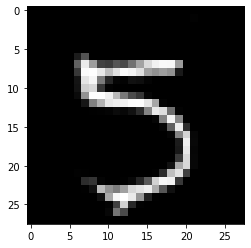

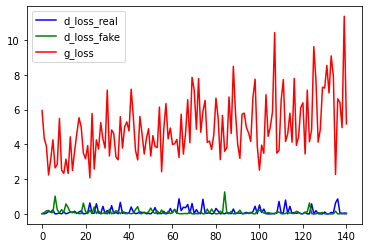

[141/200][0/938] Loss_D: 0.5657 Loss_G: 2.1243 D(x): 0.9994 D(G(z)): 0.3197 / 0.2514
[141/200][100/938] Loss_D: 0.0264 Loss_G: 5.6737 D(x): 0.9975 D(G(z)): 0.0223 / 0.0209
[141/200][200/938] Loss_D: 0.0911 Loss_G: 5.8126 D(x): 0.9955 D(G(z)): 0.0637 / 0.0228
[141/200][300/938] Loss_D: 0.0175 Loss_G: 6.6311 D(x): 0.9954 D(G(z)): 0.0122 / 0.0108
[141/200][400/938] Loss_D: 0.0323 Loss_G: 5.4890 D(x): 0.9898 D(G(z)): 0.0193 / 0.0216
[141/200][500/938] Loss_D: 0.0195 Loss_G: 5.4459 D(x): 0.9990 D(G(z)): 0.0173 / 0.0252
[141/200][600/938] Loss_D: 0.1032 Loss_G: 8.6296 D(x): 0.9141 D(G(z)): 0.0034 / 0.0045
[141/200][700/938] Loss_D: 0.1110 Loss_G: 6.6299 D(x): 0.9214 D(G(z)): 0.0134 / 0.0205
[141/200][800/938] Loss_D: 0.1131 Loss_G: 4.4737 D(x): 0.9983 D(G(z)): 0.0874 / 0.0479
[141/200][900/938] Loss_D: 0.1170 Loss_G: 6.4285 D(x): 0.9217 D(G(z)): 0.0161 / 0.0087


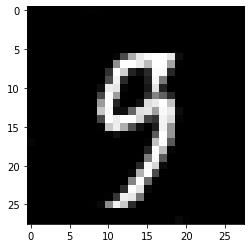

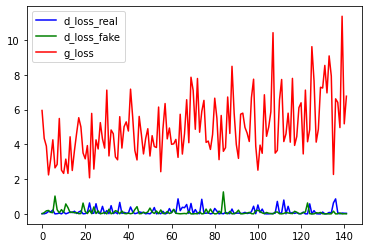

[142/200][0/938] Loss_D: 0.2777 Loss_G: 3.2605 D(x): 0.9854 D(G(z)): 0.1511 / 0.1354
[142/200][100/938] Loss_D: 0.0613 Loss_G: 5.2978 D(x): 0.9933 D(G(z)): 0.0451 / 0.0317
[142/200][200/938] Loss_D: 0.0236 Loss_G: 6.1376 D(x): 0.9862 D(G(z)): 0.0091 / 0.0122
[142/200][300/938] Loss_D: 0.1172 Loss_G: 4.9524 D(x): 0.9992 D(G(z)): 0.0842 / 0.0424
[142/200][400/938] Loss_D: 0.0739 Loss_G: 5.6061 D(x): 0.9850 D(G(z)): 0.0432 / 0.0201
[142/200][500/938] Loss_D: 0.0146 Loss_G: 6.7280 D(x): 0.9958 D(G(z)): 0.0098 / 0.0067
[142/200][600/938] Loss_D: 0.5273 Loss_G: 4.0429 D(x): 0.9938 D(G(z)): 0.2647 / 0.0959
[142/200][700/938] Loss_D: 0.7662 Loss_G: 7.3304 D(x): 0.5744 D(G(z)): 0.0011 / 0.0049
[142/200][800/938] Loss_D: 0.0287 Loss_G: 7.1875 D(x): 0.9863 D(G(z)): 0.0135 / 0.0061
[142/200][900/938] Loss_D: 0.0920 Loss_G: 4.6572 D(x): 0.9809 D(G(z)): 0.0589 / 0.0483


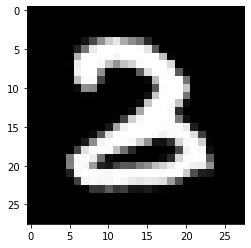

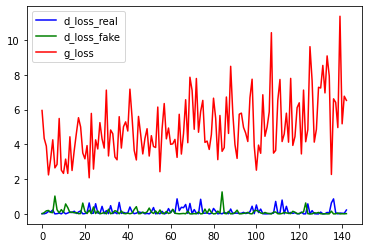

[143/200][0/938] Loss_D: 0.0344 Loss_G: 5.1662 D(x): 0.9915 D(G(z)): 0.0239 / 0.0300
[143/200][100/938] Loss_D: 0.1245 Loss_G: 6.6351 D(x): 0.9071 D(G(z)): 0.0078 / 0.0069
[143/200][200/938] Loss_D: 0.1005 Loss_G: 5.1824 D(x): 0.9419 D(G(z)): 0.0336 / 0.0266
[143/200][300/938] Loss_D: 0.1442 Loss_G: 5.1610 D(x): 0.9082 D(G(z)): 0.0279 / 0.0264
[143/200][400/938] Loss_D: 0.1236 Loss_G: 5.0453 D(x): 0.9571 D(G(z)): 0.0570 / 0.0453
[143/200][500/938] Loss_D: 0.1244 Loss_G: 4.3083 D(x): 0.9843 D(G(z)): 0.0839 / 0.0693
[143/200][600/938] Loss_D: 0.0375 Loss_G: 5.9972 D(x): 0.9871 D(G(z)): 0.0217 / 0.0181
[143/200][700/938] Loss_D: 0.1249 Loss_G: 7.7204 D(x): 0.8980 D(G(z)): 0.0012 / 0.0028
[143/200][800/938] Loss_D: 0.1098 Loss_G: 5.5758 D(x): 0.9284 D(G(z)): 0.0271 / 0.0240
[143/200][900/938] Loss_D: 0.0440 Loss_G: 5.6534 D(x): 0.9901 D(G(z)): 0.0305 / 0.0239


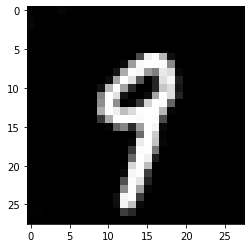

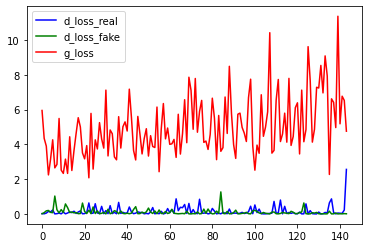

[144/200][0/938] Loss_D: 0.0931 Loss_G: 3.2967 D(x): 0.9592 D(G(z)): 0.0330 / 0.1435
[144/200][100/938] Loss_D: 1.1494 Loss_G: 5.3534 D(x): 0.5527 D(G(z)): 0.0222 / 0.0651
[144/200][200/938] Loss_D: 0.3060 Loss_G: 8.5756 D(x): 0.7916 D(G(z)): 0.0132 / 0.0085
[144/200][300/938] Loss_D: 0.0916 Loss_G: 4.1405 D(x): 0.9761 D(G(z)): 0.0582 / 0.0673
[144/200][400/938] Loss_D: 0.2149 Loss_G: 6.5846 D(x): 0.8444 D(G(z)): 0.0153 / 0.0194
[144/200][500/938] Loss_D: 0.1059 Loss_G: 3.3964 D(x): 0.9923 D(G(z)): 0.0796 / 0.1176
[144/200][600/938] Loss_D: 0.1296 Loss_G: 8.4310 D(x): 0.8968 D(G(z)): 0.0016 / 0.0012
[144/200][700/938] Loss_D: 0.1449 Loss_G: 7.6130 D(x): 0.8873 D(G(z)): 0.0037 / 0.0033
[144/200][800/938] Loss_D: 0.0210 Loss_G: 7.2345 D(x): 0.9846 D(G(z)): 0.0051 / 0.0044
[144/200][900/938] Loss_D: 0.0962 Loss_G: 4.7121 D(x): 0.9758 D(G(z)): 0.0478 / 0.0470


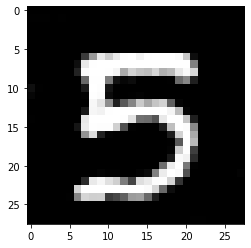

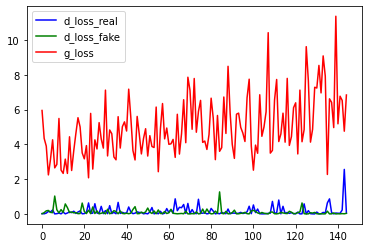

[145/200][0/938] Loss_D: 0.0904 Loss_G: 5.6521 D(x): 0.9916 D(G(z)): 0.0605 / 0.0246
[145/200][100/938] Loss_D: 0.0375 Loss_G: 6.1676 D(x): 0.9757 D(G(z)): 0.0115 / 0.0164
[145/200][200/938] Loss_D: 0.1350 Loss_G: 6.9467 D(x): 0.8892 D(G(z)): 0.0055 / 0.0081
[145/200][300/938] Loss_D: 0.0397 Loss_G: 6.9705 D(x): 0.9768 D(G(z)): 0.0133 / 0.0103
[145/200][400/938] Loss_D: 0.0547 Loss_G: 5.9438 D(x): 0.9623 D(G(z)): 0.0110 / 0.0198
[145/200][500/938] Loss_D: 0.0664 Loss_G: 5.7408 D(x): 0.9784 D(G(z)): 0.0391 / 0.0152
[145/200][600/938] Loss_D: 0.1064 Loss_G: 6.2156 D(x): 0.9339 D(G(z)): 0.0268 / 0.0252
[145/200][700/938] Loss_D: 0.1271 Loss_G: 6.6089 D(x): 0.9124 D(G(z)): 0.0060 / 0.0170
[145/200][800/938] Loss_D: 1.0810 Loss_G: 4.0039 D(x): 0.4894 D(G(z)): 0.0115 / 0.0709
[145/200][900/938] Loss_D: 0.0314 Loss_G: 6.3813 D(x): 0.9800 D(G(z)): 0.0093 / 0.0077


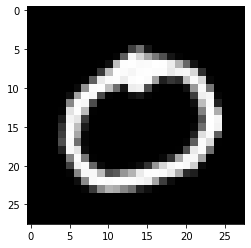

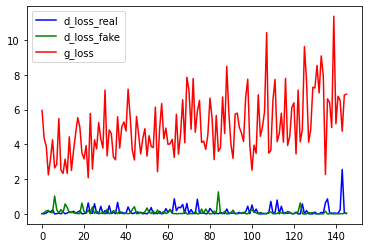

[146/200][0/938] Loss_D: 0.1828 Loss_G: 9.0073 D(x): 0.8609 D(G(z)): 0.0010 / 0.0009
[146/200][100/938] Loss_D: 0.0891 Loss_G: 8.1703 D(x): 0.9306 D(G(z)): 0.0039 / 0.0029
[146/200][200/938] Loss_D: 0.0143 Loss_G: 6.8850 D(x): 0.9955 D(G(z)): 0.0095 / 0.0084
[146/200][300/938] Loss_D: 0.0770 Loss_G: 7.7026 D(x): 0.9383 D(G(z)): 0.0046 / 0.0029
[146/200][400/938] Loss_D: 0.3030 Loss_G: 8.2607 D(x): 0.8027 D(G(z)): 0.0037 / 0.0041
[146/200][500/938] Loss_D: 0.1398 Loss_G: 4.4890 D(x): 0.9732 D(G(z)): 0.0761 / 0.0681
[146/200][600/938] Loss_D: 0.0682 Loss_G: 5.6801 D(x): 0.9593 D(G(z)): 0.0171 / 0.0292
[146/200][700/938] Loss_D: 0.1584 Loss_G: 3.6629 D(x): 0.9990 D(G(z)): 0.1181 / 0.0714
[146/200][800/938] Loss_D: 0.0334 Loss_G: 5.9908 D(x): 0.9748 D(G(z)): 0.0068 / 0.0107
[146/200][900/938] Loss_D: 0.0383 Loss_G: 6.6706 D(x): 0.9797 D(G(z)): 0.0143 / 0.0144


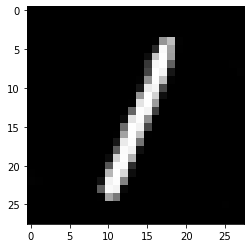

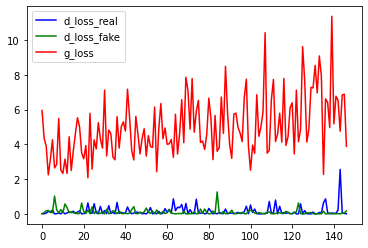

[147/200][0/938] Loss_D: 0.1408 Loss_G: 4.9336 D(x): 0.9680 D(G(z)): 0.0786 / 0.0474
[147/200][100/938] Loss_D: 0.0888 Loss_G: 5.9811 D(x): 0.9566 D(G(z)): 0.0314 / 0.0284
[147/200][200/938] Loss_D: 0.0450 Loss_G: 7.5854 D(x): 0.9605 D(G(z)): 0.0017 / 0.0035
[147/200][300/938] Loss_D: 0.4612 Loss_G: 6.0162 D(x): 0.6886 D(G(z)): 0.0029 / 0.0142
[147/200][400/938] Loss_D: 0.1065 Loss_G: 6.0297 D(x): 0.9313 D(G(z)): 0.0196 / 0.0160
[147/200][500/938] Loss_D: 0.0507 Loss_G: 5.0212 D(x): 0.9734 D(G(z)): 0.0218 / 0.0334
[147/200][600/938] Loss_D: 0.0731 Loss_G: 4.4943 D(x): 0.9843 D(G(z)): 0.0367 / 0.0369
[147/200][700/938] Loss_D: 0.2255 Loss_G: 4.6325 D(x): 0.9235 D(G(z)): 0.0953 / 0.0609
[147/200][800/938] Loss_D: 0.0843 Loss_G: 6.1397 D(x): 0.9691 D(G(z)): 0.0305 / 0.0282
[147/200][900/938] Loss_D: 0.0656 Loss_G: 5.3643 D(x): 0.9976 D(G(z)): 0.0498 / 0.0369


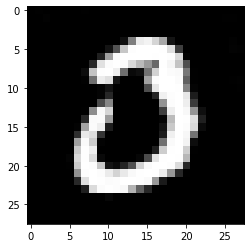

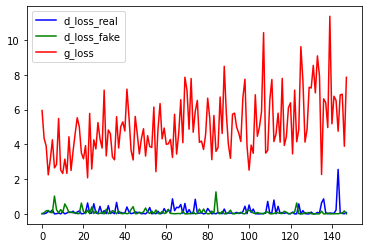

[148/200][0/938] Loss_D: 0.0392 Loss_G: 5.1167 D(x): 0.9932 D(G(z)): 0.0282 / 0.0229
[148/200][100/938] Loss_D: 0.5772 Loss_G: 6.3405 D(x): 0.7092 D(G(z)): 0.0058 / 0.0162
[148/200][200/938] Loss_D: 0.0519 Loss_G: 4.9312 D(x): 0.9854 D(G(z)): 0.0291 / 0.0386
[148/200][300/938] Loss_D: 0.1404 Loss_G: 3.8897 D(x): 0.9543 D(G(z)): 0.0594 / 0.0863
[148/200][400/938] Loss_D: 0.0133 Loss_G: 7.9903 D(x): 0.9930 D(G(z)): 0.0061 / 0.0029
[148/200][500/938] Loss_D: 0.0267 Loss_G: 6.7350 D(x): 0.9961 D(G(z)): 0.0211 / 0.0099
[148/200][600/938] Loss_D: 0.0471 Loss_G: 5.1824 D(x): 0.9938 D(G(z)): 0.0371 / 0.0272
[148/200][700/938] Loss_D: 0.0833 Loss_G: 4.2912 D(x): 0.9967 D(G(z)): 0.0688 / 0.0575
[148/200][800/938] Loss_D: 0.2263 Loss_G: 4.6817 D(x): 0.9951 D(G(z)): 0.1394 / 0.0659
[148/200][900/938] Loss_D: 0.0502 Loss_G: 7.9084 D(x): 0.9563 D(G(z)): 0.0035 / 0.0026


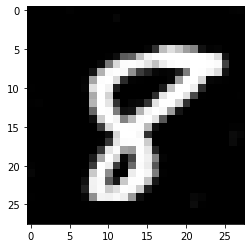

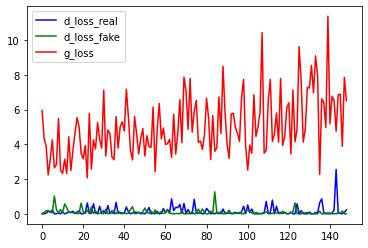

[149/200][0/938] Loss_D: 0.0533 Loss_G: 5.1576 D(x): 0.9731 D(G(z)): 0.0235 / 0.0302
[149/200][100/938] Loss_D: 0.0722 Loss_G: 4.9977 D(x): 0.9880 D(G(z)): 0.0515 / 0.0343
[149/200][200/938] Loss_D: 0.0554 Loss_G: 6.5392 D(x): 0.9567 D(G(z)): 0.0076 / 0.0052
[149/200][300/938] Loss_D: 0.2142 Loss_G: 4.4433 D(x): 0.9870 D(G(z)): 0.1326 / 0.0569
[149/200][400/938] Loss_D: 0.1827 Loss_G: 4.8741 D(x): 0.9816 D(G(z)): 0.1023 / 0.0546
[149/200][500/938] Loss_D: 0.0178 Loss_G: 8.5652 D(x): 0.9926 D(G(z)): 0.0090 / 0.0057
[149/200][600/938] Loss_D: 0.0481 Loss_G: 7.3069 D(x): 0.9607 D(G(z)): 0.0048 / 0.0032
[149/200][700/938] Loss_D: 0.0142 Loss_G: 8.2477 D(x): 0.9927 D(G(z)): 0.0067 / 0.0020
[149/200][800/938] Loss_D: 0.0957 Loss_G: 4.3252 D(x): 0.9750 D(G(z)): 0.0461 / 0.0700
[149/200][900/938] Loss_D: 0.2772 Loss_G: 3.9290 D(x): 0.9992 D(G(z)): 0.1798 / 0.0772


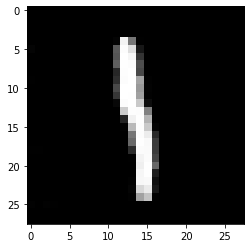

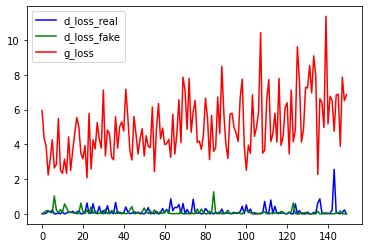

[150/200][0/938] Loss_D: 0.1463 Loss_G: 4.8488 D(x): 0.9926 D(G(z)): 0.0970 / 0.0479
[150/200][100/938] Loss_D: 0.5117 Loss_G: 4.7171 D(x): 0.7119 D(G(z)): 0.0370 / 0.0434
[150/200][200/938] Loss_D: 0.1652 Loss_G: 7.3093 D(x): 0.8719 D(G(z)): 0.0097 / 0.0085
[150/200][300/938] Loss_D: 0.7690 Loss_G: 3.9931 D(x): 0.9994 D(G(z)): 0.3741 / 0.0719
[150/200][400/938] Loss_D: 0.5752 Loss_G: 2.9244 D(x): 0.9866 D(G(z)): 0.3052 / 0.1630
[150/200][500/938] Loss_D: 0.3076 Loss_G: 2.6024 D(x): 0.9973 D(G(z)): 0.1982 / 0.2094
[150/200][600/938] Loss_D: 0.1147 Loss_G: 4.7125 D(x): 0.9942 D(G(z)): 0.0835 / 0.0394
[150/200][700/938] Loss_D: 0.0362 Loss_G: 8.7698 D(x): 0.9685 D(G(z)): 0.0028 / 0.0012
[150/200][800/938] Loss_D: 0.1187 Loss_G: 4.4061 D(x): 0.9788 D(G(z)): 0.0660 / 0.0568
[150/200][900/938] Loss_D: 0.0495 Loss_G: 5.5421 D(x): 0.9868 D(G(z)): 0.0330 / 0.0224


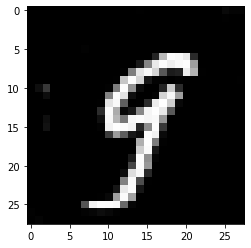

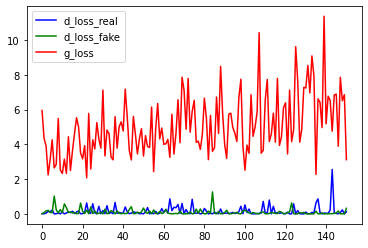

[151/200][0/938] Loss_D: 0.0974 Loss_G: 4.7064 D(x): 0.9973 D(G(z)): 0.0795 / 0.0438
[151/200][100/938] Loss_D: 0.2808 Loss_G: 3.9141 D(x): 0.9941 D(G(z)): 0.1755 / 0.0616
[151/200][200/938] Loss_D: 0.0260 Loss_G: 9.1662 D(x): 0.9762 D(G(z)): 0.0007 / 0.0010
[151/200][300/938] Loss_D: 0.1338 Loss_G: 4.7259 D(x): 0.9912 D(G(z)): 0.0839 / 0.0455
[151/200][400/938] Loss_D: 0.0817 Loss_G: 4.7530 D(x): 0.9975 D(G(z)): 0.0636 / 0.0361
[151/200][500/938] Loss_D: 0.0668 Loss_G: 5.1454 D(x): 0.9953 D(G(z)): 0.0418 / 0.0517
[151/200][600/938] Loss_D: 0.0557 Loss_G: 5.2819 D(x): 0.9822 D(G(z)): 0.0333 / 0.0272
[151/200][700/938] Loss_D: 0.0226 Loss_G: 7.0422 D(x): 0.9860 D(G(z)): 0.0076 / 0.0094
[151/200][800/938] Loss_D: 0.1371 Loss_G: 5.8070 D(x): 0.9921 D(G(z)): 0.0792 / 0.0313
[151/200][900/938] Loss_D: 0.0217 Loss_G: 9.0970 D(x): 0.9825 D(G(z)): 0.0034 / 0.0013


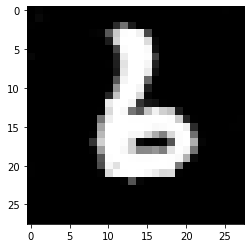

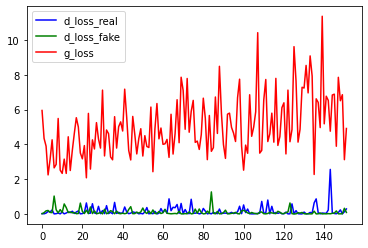

[152/200][0/938] Loss_D: 0.0558 Loss_G: 5.5284 D(x): 0.9773 D(G(z)): 0.0272 / 0.0351
[152/200][100/938] Loss_D: 0.0289 Loss_G: 6.3485 D(x): 0.9789 D(G(z)): 0.0032 / 0.0067
[152/200][200/938] Loss_D: 0.1298 Loss_G: 5.4180 D(x): 0.9181 D(G(z)): 0.0250 / 0.0379
[152/200][300/938] Loss_D: 0.0297 Loss_G: 7.6047 D(x): 0.9851 D(G(z)): 0.0129 / 0.0064
[152/200][400/938] Loss_D: 0.0707 Loss_G: 5.4365 D(x): 0.9853 D(G(z)): 0.0298 / 0.0330
[152/200][500/938] Loss_D: 0.0668 Loss_G: 5.6547 D(x): 0.9973 D(G(z)): 0.0543 / 0.0215
[152/200][600/938] Loss_D: 0.2239 Loss_G: 4.7619 D(x): 0.8654 D(G(z)): 0.0438 / 0.0366
[152/200][700/938] Loss_D: 0.0747 Loss_G: 5.7907 D(x): 0.9650 D(G(z)): 0.0258 / 0.0245
[152/200][800/938] Loss_D: 0.0784 Loss_G: 5.1388 D(x): 0.9689 D(G(z)): 0.0376 / 0.0289
[152/200][900/938] Loss_D: 0.0240 Loss_G: 7.1856 D(x): 0.9838 D(G(z)): 0.0069 / 0.0061


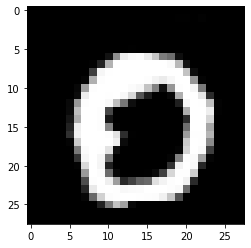

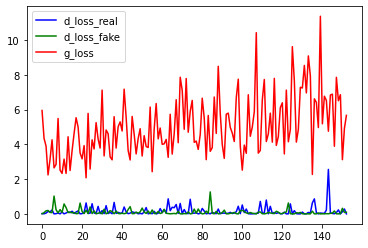

[153/200][0/938] Loss_D: 0.0318 Loss_G: 7.0967 D(x): 0.9986 D(G(z)): 0.0232 / 0.0112
[153/200][100/938] Loss_D: 0.0766 Loss_G: 7.9544 D(x): 0.9353 D(G(z)): 0.0047 / 0.0029
[153/200][200/938] Loss_D: 0.0690 Loss_G: 7.5738 D(x): 0.9414 D(G(z)): 0.0027 / 0.0030
[153/200][300/938] Loss_D: 0.0815 Loss_G: 6.3355 D(x): 0.9748 D(G(z)): 0.0261 / 0.0159
[153/200][400/938] Loss_D: 0.3609 Loss_G: 5.1888 D(x): 0.8322 D(G(z)): 0.0586 / 0.0375
[153/200][500/938] Loss_D: 0.0535 Loss_G: 5.8862 D(x): 0.9629 D(G(z)): 0.0107 / 0.0120
[153/200][600/938] Loss_D: 0.0987 Loss_G: 7.4071 D(x): 0.9288 D(G(z)): 0.0131 / 0.0058
[153/200][700/938] Loss_D: 0.0421 Loss_G: 5.9718 D(x): 0.9790 D(G(z)): 0.0180 / 0.0190
[153/200][800/938] Loss_D: 0.1746 Loss_G: 4.7070 D(x): 0.9032 D(G(z)): 0.0501 / 0.0531
[153/200][900/938] Loss_D: 0.0589 Loss_G: 8.1143 D(x): 0.9666 D(G(z)): 0.0180 / 0.0063


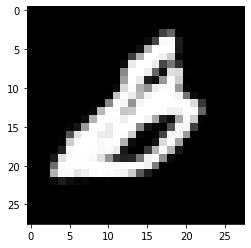

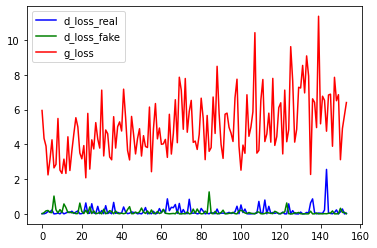

[154/200][0/938] Loss_D: 0.0376 Loss_G: 5.5387 D(x): 0.9741 D(G(z)): 0.0099 / 0.0310
[154/200][100/938] Loss_D: 0.0517 Loss_G: 6.6031 D(x): 0.9573 D(G(z)): 0.0041 / 0.0144
[154/200][200/938] Loss_D: 0.0414 Loss_G: 5.8414 D(x): 0.9762 D(G(z)): 0.0105 / 0.0164
[154/200][300/938] Loss_D: 0.5030 Loss_G: 3.0015 D(x): 0.9976 D(G(z)): 0.2827 / 0.1785
[154/200][400/938] Loss_D: 0.0597 Loss_G: 6.5788 D(x): 0.9873 D(G(z)): 0.0386 / 0.0113
[154/200][500/938] Loss_D: 0.1318 Loss_G: 6.6895 D(x): 0.8953 D(G(z)): 0.0055 / 0.0068
[154/200][600/938] Loss_D: 0.0548 Loss_G: 7.9962 D(x): 0.9562 D(G(z)): 0.0021 / 0.0020
[154/200][700/938] Loss_D: 0.0448 Loss_G: 7.7607 D(x): 0.9668 D(G(z)): 0.0078 / 0.0060
[154/200][800/938] Loss_D: 0.1129 Loss_G: 7.6612 D(x): 0.9241 D(G(z)): 0.0094 / 0.0092
[154/200][900/938] Loss_D: 0.5411 Loss_G: 5.3656 D(x): 0.7146 D(G(z)): 0.0052 / 0.0262


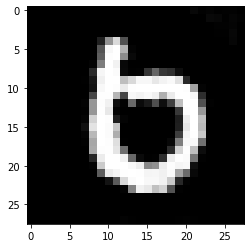

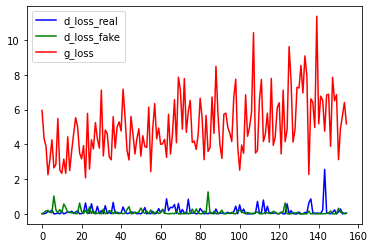

[155/200][0/938] Loss_D: 0.0726 Loss_G: 5.4725 D(x): 0.9765 D(G(z)): 0.0411 / 0.0415
[155/200][100/938] Loss_D: 0.0231 Loss_G: 7.9478 D(x): 0.9815 D(G(z)): 0.0038 / 0.0026
[155/200][200/938] Loss_D: 0.0565 Loss_G: 6.7750 D(x): 0.9750 D(G(z)): 0.0229 / 0.0100
[155/200][300/938] Loss_D: 0.0417 Loss_G: 4.1303 D(x): 0.9924 D(G(z)): 0.0308 / 0.0695
[155/200][400/938] Loss_D: 0.0921 Loss_G: 5.3614 D(x): 0.9659 D(G(z)): 0.0490 / 0.0297
[155/200][500/938] Loss_D: 0.1411 Loss_G: 5.7609 D(x): 0.9218 D(G(z)): 0.0348 / 0.0272
[155/200][600/938] Loss_D: 0.1572 Loss_G: 5.5939 D(x): 0.9238 D(G(z)): 0.0445 / 0.0405
[155/200][700/938] Loss_D: 0.0536 Loss_G: 8.0745 D(x): 0.9549 D(G(z)): 0.0048 / 0.0061
[155/200][800/938] Loss_D: 0.1191 Loss_G: 3.9131 D(x): 0.9888 D(G(z)): 0.0880 / 0.0693
[155/200][900/938] Loss_D: 0.0306 Loss_G: 6.9921 D(x): 0.9785 D(G(z)): 0.0049 / 0.0065


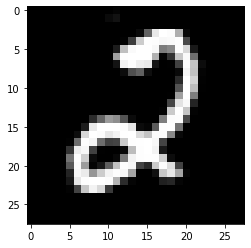

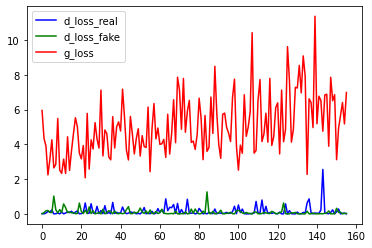

[156/200][0/938] Loss_D: 0.0266 Loss_G: 9.2531 D(x): 0.9771 D(G(z)): 0.0017 / 0.0010
[156/200][100/938] Loss_D: 0.0265 Loss_G: 8.2645 D(x): 0.9762 D(G(z)): 0.0013 / 0.0018
[156/200][200/938] Loss_D: 0.0676 Loss_G: 5.0711 D(x): 0.9945 D(G(z)): 0.0503 / 0.0342
[156/200][300/938] Loss_D: 0.0271 Loss_G: 6.1043 D(x): 0.9912 D(G(z)): 0.0170 / 0.0136
[156/200][400/938] Loss_D: 0.1917 Loss_G: 4.5855 D(x): 0.9960 D(G(z)): 0.1383 / 0.0392
[156/200][500/938] Loss_D: 0.2410 Loss_G: 10.4641 D(x): 0.8422 D(G(z)): 0.0005 / 0.0007
[156/200][600/938] Loss_D: 0.0666 Loss_G: 6.0063 D(x): 0.9533 D(G(z)): 0.0128 / 0.0219
[156/200][700/938] Loss_D: 0.1905 Loss_G: 3.3094 D(x): 0.9575 D(G(z)): 0.0897 / 0.1472
[156/200][800/938] Loss_D: 0.1041 Loss_G: 7.6484 D(x): 0.9215 D(G(z)): 0.0032 / 0.0037
[156/200][900/938] Loss_D: 0.2284 Loss_G: 4.2206 D(x): 0.9879 D(G(z)): 0.1160 / 0.0894


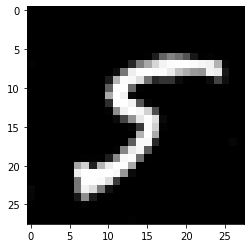

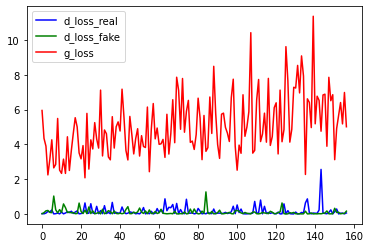

[157/200][0/938] Loss_D: 0.1164 Loss_G: 5.1318 D(x): 0.9684 D(G(z)): 0.0656 / 0.0345
[157/200][100/938] Loss_D: 0.1155 Loss_G: 7.2220 D(x): 0.9099 D(G(z)): 0.0063 / 0.0045
[157/200][200/938] Loss_D: 0.0452 Loss_G: 6.3844 D(x): 0.9768 D(G(z)): 0.0198 / 0.0157
[157/200][300/938] Loss_D: 0.0798 Loss_G: 5.7712 D(x): 0.9971 D(G(z)): 0.0381 / 0.0230
[157/200][400/938] Loss_D: 0.0671 Loss_G: 6.8668 D(x): 0.9935 D(G(z)): 0.0507 / 0.0107
[157/200][500/938] Loss_D: 0.0521 Loss_G: 6.1773 D(x): 0.9742 D(G(z)): 0.0213 / 0.0203
[157/200][600/938] Loss_D: 0.0167 Loss_G: 7.1432 D(x): 0.9938 D(G(z)): 0.0101 / 0.0060
[157/200][700/938] Loss_D: 0.0303 Loss_G: 7.1952 D(x): 0.9877 D(G(z)): 0.0159 / 0.0081
[157/200][800/938] Loss_D: 0.0393 Loss_G: 6.5469 D(x): 0.9723 D(G(z)): 0.0095 / 0.0123
[157/200][900/938] Loss_D: 0.1151 Loss_G: 5.2805 D(x): 0.9882 D(G(z)): 0.0628 / 0.0386


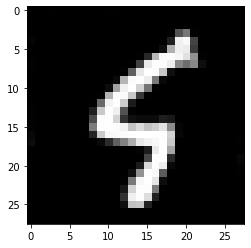

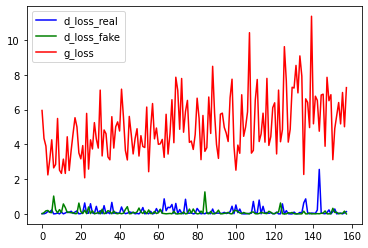

[158/200][0/938] Loss_D: 0.1019 Loss_G: 4.2072 D(x): 0.9944 D(G(z)): 0.0651 / 0.0794
[158/200][100/938] Loss_D: 0.1968 Loss_G: 4.3631 D(x): 0.9852 D(G(z)): 0.1359 / 0.0431
[158/200][200/938] Loss_D: 0.1064 Loss_G: 3.4100 D(x): 0.9883 D(G(z)): 0.0748 / 0.1071
[158/200][300/938] Loss_D: 0.1252 Loss_G: 7.1533 D(x): 0.9259 D(G(z)): 0.0282 / 0.0099
[158/200][400/938] Loss_D: 0.1143 Loss_G: 4.5180 D(x): 0.9971 D(G(z)): 0.0793 / 0.0474
[158/200][500/938] Loss_D: 0.1329 Loss_G: 4.3132 D(x): 0.9966 D(G(z)): 0.1004 / 0.0634
[158/200][600/938] Loss_D: 0.1418 Loss_G: 7.8332 D(x): 0.8979 D(G(z)): 0.0023 / 0.0049
[158/200][700/938] Loss_D: 0.2762 Loss_G: 9.2504 D(x): 0.8182 D(G(z)): 0.0003 / 0.0010
[158/200][800/938] Loss_D: 0.3905 Loss_G: 5.6601 D(x): 0.7478 D(G(z)): 0.0118 / 0.0206
[158/200][900/938] Loss_D: 0.0284 Loss_G: 7.1067 D(x): 0.9975 D(G(z)): 0.0237 / 0.0077


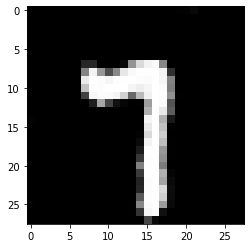

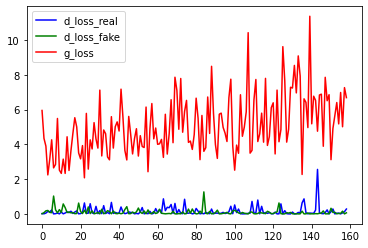

[159/200][0/938] Loss_D: 0.3769 Loss_G: 8.3645 D(x): 0.7633 D(G(z)): 0.0068 / 0.0099
[159/200][100/938] Loss_D: 0.0878 Loss_G: 5.4273 D(x): 0.9696 D(G(z)): 0.0393 / 0.0341
[159/200][200/938] Loss_D: 0.2306 Loss_G: 4.1259 D(x): 0.9954 D(G(z)): 0.1353 / 0.0776
[159/200][300/938] Loss_D: 0.0464 Loss_G: 5.8164 D(x): 0.9930 D(G(z)): 0.0323 / 0.0183
[159/200][400/938] Loss_D: 0.0544 Loss_G: 5.7216 D(x): 0.9905 D(G(z)): 0.0393 / 0.0239
[159/200][500/938] Loss_D: 0.1733 Loss_G: 4.6225 D(x): 0.9940 D(G(z)): 0.0947 / 0.0587
[159/200][600/938] Loss_D: 0.1309 Loss_G: 7.4394 D(x): 0.8910 D(G(z)): 0.0046 / 0.0085
[159/200][700/938] Loss_D: 0.0234 Loss_G: 7.0745 D(x): 0.9983 D(G(z)): 0.0191 / 0.0087
[159/200][800/938] Loss_D: 0.1528 Loss_G: 4.2248 D(x): 0.9906 D(G(z)): 0.1060 / 0.0704
[159/200][900/938] Loss_D: 0.1350 Loss_G: 4.7550 D(x): 0.9155 D(G(z)): 0.0267 / 0.0334


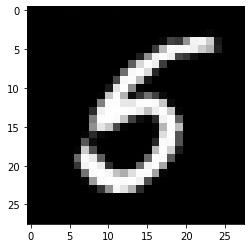

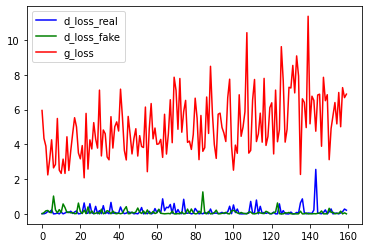

[160/200][0/938] Loss_D: 0.0901 Loss_G: 3.8408 D(x): 0.9689 D(G(z)): 0.0484 / 0.1025
[160/200][100/938] Loss_D: 0.1718 Loss_G: 3.4681 D(x): 0.9847 D(G(z)): 0.1125 / 0.1059
[160/200][200/938] Loss_D: 0.1808 Loss_G: 3.8037 D(x): 0.9960 D(G(z)): 0.1388 / 0.0690
[160/200][300/938] Loss_D: 0.0565 Loss_G: 4.9821 D(x): 0.9969 D(G(z)): 0.0472 / 0.0433
[160/200][400/938] Loss_D: 0.0875 Loss_G: 5.2499 D(x): 0.9710 D(G(z)): 0.0454 / 0.0365
[160/200][500/938] Loss_D: 0.3994 Loss_G: 3.4421 D(x): 0.9967 D(G(z)): 0.2395 / 0.1396
[160/200][600/938] Loss_D: 0.3308 Loss_G: 8.5117 D(x): 0.7661 D(G(z)): 0.0003 / 0.0012
[160/200][700/938] Loss_D: 0.0557 Loss_G: 8.9209 D(x): 0.9519 D(G(z)): 0.0012 / 0.0016
[160/200][800/938] Loss_D: 0.0823 Loss_G: 4.8629 D(x): 0.9993 D(G(z)): 0.0643 / 0.0440
[160/200][900/938] Loss_D: 0.0769 Loss_G: 5.4350 D(x): 0.9976 D(G(z)): 0.0565 / 0.0317


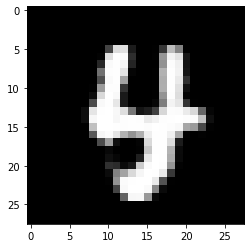

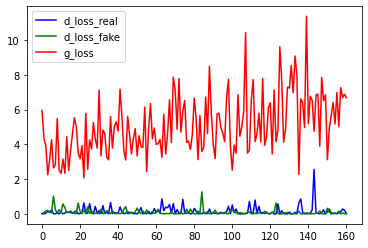

[161/200][0/938] Loss_D: 0.3705 Loss_G: 4.6645 D(x): 0.9975 D(G(z)): 0.1946 / 0.0695
[161/200][100/938] Loss_D: 0.0450 Loss_G: 9.4171 D(x): 0.9647 D(G(z)): 0.0010 / 0.0006
[161/200][200/938] Loss_D: 0.0426 Loss_G: 5.6004 D(x): 0.9903 D(G(z)): 0.0292 / 0.0230
[161/200][300/938] Loss_D: 0.0991 Loss_G: 5.3761 D(x): 0.9884 D(G(z)): 0.0562 / 0.0324
[161/200][400/938] Loss_D: 0.4594 Loss_G: 9.4339 D(x): 0.7144 D(G(z)): 0.0003 / 0.0025
[161/200][500/938] Loss_D: 0.1050 Loss_G: 4.8586 D(x): 0.9619 D(G(z)): 0.0504 / 0.0393
[161/200][600/938] Loss_D: 0.1080 Loss_G: 7.0423 D(x): 0.9399 D(G(z)): 0.0313 / 0.0079
[161/200][700/938] Loss_D: 0.3822 Loss_G: 10.0396 D(x): 0.7404 D(G(z)): 0.0003 / 0.0003
[161/200][800/938] Loss_D: 0.0106 Loss_G: 6.4396 D(x): 0.9980 D(G(z)): 0.0084 / 0.0105
[161/200][900/938] Loss_D: 0.1459 Loss_G: 5.7591 D(x): 0.9072 D(G(z)): 0.0192 / 0.0221


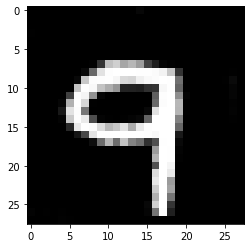

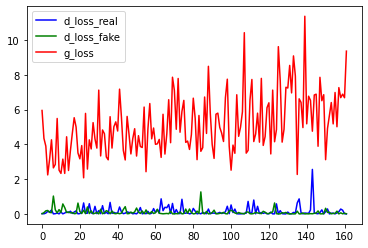

[162/200][0/938] Loss_D: 0.1502 Loss_G: 5.3928 D(x): 0.9255 D(G(z)): 0.0511 / 0.0274
[162/200][100/938] Loss_D: 0.0262 Loss_G: 6.4855 D(x): 0.9930 D(G(z)): 0.0174 / 0.0184
[162/200][200/938] Loss_D: 0.0704 Loss_G: 5.8673 D(x): 0.9823 D(G(z)): 0.0352 / 0.0254
[162/200][300/938] Loss_D: 0.0675 Loss_G: 5.3880 D(x): 0.9615 D(G(z)): 0.0220 / 0.0300
[162/200][400/938] Loss_D: 0.0344 Loss_G: 6.1201 D(x): 0.9930 D(G(z)): 0.0245 / 0.0171
[162/200][500/938] Loss_D: 0.0353 Loss_G: 6.0439 D(x): 0.9787 D(G(z)): 0.0125 / 0.0114
[162/200][600/938] Loss_D: 0.0621 Loss_G: 7.1892 D(x): 0.9515 D(G(z)): 0.0080 / 0.0080
[162/200][700/938] Loss_D: 0.2721 Loss_G: 3.7620 D(x): 0.9845 D(G(z)): 0.1367 / 0.1096
[162/200][800/938] Loss_D: 0.1312 Loss_G: 3.9525 D(x): 0.9873 D(G(z)): 0.0942 / 0.0601
[162/200][900/938] Loss_D: 0.0821 Loss_G: 6.0148 D(x): 0.9370 D(G(z)): 0.0116 / 0.0120


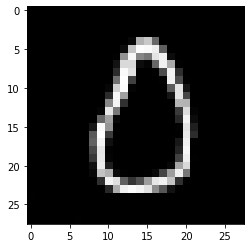

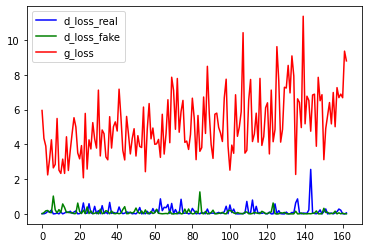

[163/200][0/938] Loss_D: 0.0746 Loss_G: 8.2117 D(x): 0.9489 D(G(z)): 0.0098 / 0.0042
[163/200][100/938] Loss_D: 0.0824 Loss_G: 5.3088 D(x): 0.9944 D(G(z)): 0.0430 / 0.0407
[163/200][200/938] Loss_D: 0.0419 Loss_G: 5.6122 D(x): 0.9689 D(G(z)): 0.0087 / 0.0180
[163/200][300/938] Loss_D: 0.2426 Loss_G: 4.7464 D(x): 0.9688 D(G(z)): 0.1341 / 0.0529
[163/200][400/938] Loss_D: 0.0538 Loss_G: 6.2379 D(x): 0.9893 D(G(z)): 0.0348 / 0.0274
[163/200][500/938] Loss_D: 0.2485 Loss_G: 5.4230 D(x): 0.8574 D(G(z)): 0.0301 / 0.0334
[163/200][600/938] Loss_D: 0.0319 Loss_G: 6.4468 D(x): 0.9806 D(G(z)): 0.0107 / 0.0119
[163/200][700/938] Loss_D: 0.0798 Loss_G: 4.9508 D(x): 0.9984 D(G(z)): 0.0642 / 0.0333
[163/200][800/938] Loss_D: 0.3468 Loss_G: 3.3492 D(x): 0.9917 D(G(z)): 0.2113 / 0.1605
[163/200][900/938] Loss_D: 0.0403 Loss_G: 5.7552 D(x): 0.9821 D(G(z)): 0.0192 / 0.0244


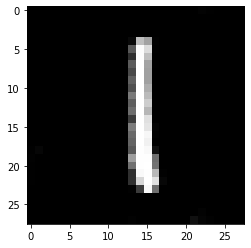

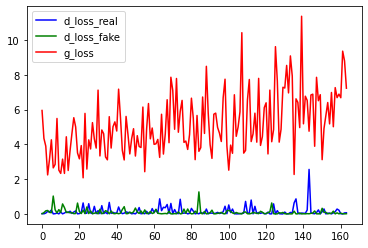

[164/200][0/938] Loss_D: 0.0302 Loss_G: 6.1609 D(x): 0.9826 D(G(z)): 0.0120 / 0.0100
[164/200][100/938] Loss_D: 0.0987 Loss_G: 5.8331 D(x): 0.9593 D(G(z)): 0.0291 / 0.0219
[164/200][200/938] Loss_D: 0.0618 Loss_G: 5.8868 D(x): 0.9633 D(G(z)): 0.0213 / 0.0149
[164/200][300/938] Loss_D: 0.2042 Loss_G: 4.2472 D(x): 0.9932 D(G(z)): 0.1291 / 0.0582
[164/200][400/938] Loss_D: 0.0164 Loss_G: 7.4801 D(x): 0.9888 D(G(z)): 0.0048 / 0.0035
[164/200][500/938] Loss_D: 0.0445 Loss_G: 7.9361 D(x): 0.9698 D(G(z)): 0.0109 / 0.0063
[164/200][600/938] Loss_D: 0.0888 Loss_G: 4.8736 D(x): 0.9980 D(G(z)): 0.0716 / 0.0365
[164/200][700/938] Loss_D: 0.1074 Loss_G: 8.3916 D(x): 0.9155 D(G(z)): 0.0021 / 0.0026
[164/200][800/938] Loss_D: 0.2146 Loss_G: 6.6292 D(x): 0.8371 D(G(z)): 0.0061 / 0.0137
[164/200][900/938] Loss_D: 0.2284 Loss_G: 4.0845 D(x): 0.9951 D(G(z)): 0.1314 / 0.0871


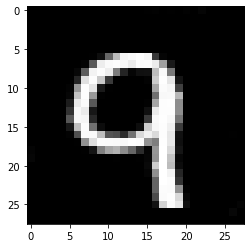

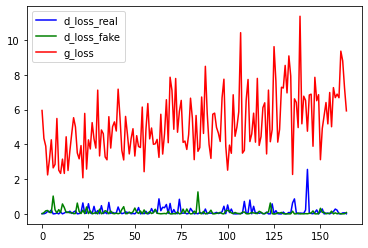

[165/200][0/938] Loss_D: 0.0676 Loss_G: 5.4834 D(x): 0.9986 D(G(z)): 0.0457 / 0.0285
[165/200][100/938] Loss_D: 0.0848 Loss_G: 8.2300 D(x): 0.9323 D(G(z)): 0.0035 / 0.0038
[165/200][200/938] Loss_D: 0.0365 Loss_G: 8.0581 D(x): 0.9681 D(G(z)): 0.0022 / 0.0024
[165/200][300/938] Loss_D: 0.0278 Loss_G: 5.3950 D(x): 0.9937 D(G(z)): 0.0201 / 0.0203
[165/200][400/938] Loss_D: 0.1458 Loss_G: 5.4091 D(x): 0.9466 D(G(z)): 0.0570 / 0.0333
[165/200][500/938] Loss_D: 0.0320 Loss_G: 5.2678 D(x): 0.9919 D(G(z)): 0.0218 / 0.0318
[165/200][600/938] Loss_D: 0.0293 Loss_G: 5.5601 D(x): 0.9968 D(G(z)): 0.0239 / 0.0243
[165/200][700/938] Loss_D: 0.4015 Loss_G: 8.9746 D(x): 0.7539 D(G(z)): 0.0004 / 0.0008
[165/200][800/938] Loss_D: 0.0288 Loss_G: 6.3638 D(x): 0.9810 D(G(z)): 0.0088 / 0.0140
[165/200][900/938] Loss_D: 0.1034 Loss_G: 6.1133 D(x): 0.9153 D(G(z)): 0.0056 / 0.0125


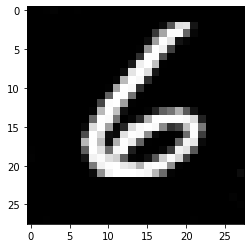

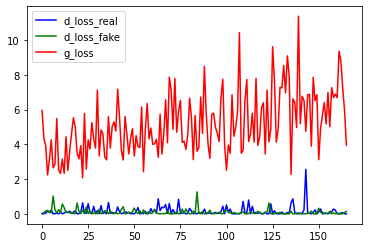

[166/200][0/938] Loss_D: 0.2383 Loss_G: 3.9824 D(x): 0.9900 D(G(z)): 0.1599 / 0.0641
[166/200][100/938] Loss_D: 0.0515 Loss_G: 7.1499 D(x): 0.9787 D(G(z)): 0.0241 / 0.0118
[166/200][200/938] Loss_D: 0.1300 Loss_G: 5.5499 D(x): 0.9937 D(G(z)): 0.0695 / 0.0307
[166/200][300/938] Loss_D: 0.1088 Loss_G: 4.5410 D(x): 0.9406 D(G(z)): 0.0314 / 0.0414
[166/200][400/938] Loss_D: 0.0603 Loss_G: 6.8218 D(x): 0.9601 D(G(z)): 0.0156 / 0.0148
[166/200][500/938] Loss_D: 0.0286 Loss_G: 6.9364 D(x): 0.9843 D(G(z)): 0.0113 / 0.0065
[166/200][600/938] Loss_D: 0.0136 Loss_G: 8.0246 D(x): 0.9925 D(G(z)): 0.0057 / 0.0038
[166/200][700/938] Loss_D: 0.0885 Loss_G: 5.6131 D(x): 0.9505 D(G(z)): 0.0261 / 0.0330
[166/200][800/938] Loss_D: 0.3130 Loss_G: 3.4926 D(x): 0.9991 D(G(z)): 0.1957 / 0.1545
[166/200][900/938] Loss_D: 0.7122 Loss_G: 7.7844 D(x): 0.6276 D(G(z)): 0.0006 / 0.0050


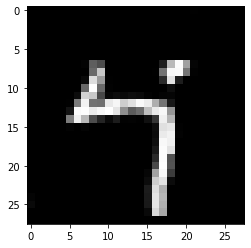

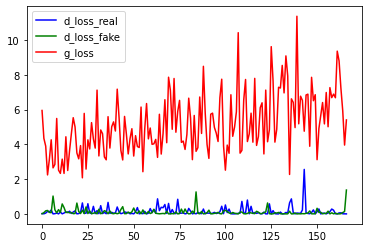

[167/200][0/938] Loss_D: 0.2082 Loss_G: 9.3578 D(x): 0.8638 D(G(z)): 0.0089 / 0.0010
[167/200][100/938] Loss_D: 0.6310 Loss_G: 5.0901 D(x): 0.6382 D(G(z)): 0.0338 / 0.0261
[167/200][200/938] Loss_D: 0.0457 Loss_G: 5.9586 D(x): 0.9816 D(G(z)): 0.0239 / 0.0207
[167/200][300/938] Loss_D: 0.0644 Loss_G: 7.3858 D(x): 0.9474 D(G(z)): 0.0035 / 0.0045
[167/200][400/938] Loss_D: 0.0411 Loss_G: 7.9126 D(x): 0.9674 D(G(z)): 0.0042 / 0.0037
[167/200][500/938] Loss_D: 0.0724 Loss_G: 5.1918 D(x): 0.9679 D(G(z)): 0.0327 / 0.0423
[167/200][600/938] Loss_D: 0.1429 Loss_G: 5.3575 D(x): 0.9490 D(G(z)): 0.0571 / 0.0421
[167/200][700/938] Loss_D: 0.0074 Loss_G: 8.1378 D(x): 0.9987 D(G(z)): 0.0060 / 0.0017
[167/200][800/938] Loss_D: 0.3854 Loss_G: 6.8696 D(x): 0.7478 D(G(z)): 0.0044 / 0.0063
[167/200][900/938] Loss_D: 0.0207 Loss_G: 8.3271 D(x): 0.9892 D(G(z)): 0.0085 / 0.0077


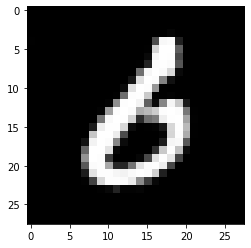

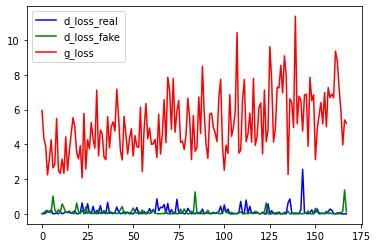

[168/200][0/938] Loss_D: 0.1600 Loss_G: 4.4951 D(x): 0.9912 D(G(z)): 0.1017 / 0.0546
[168/200][100/938] Loss_D: 0.0318 Loss_G: 5.9405 D(x): 0.9945 D(G(z)): 0.0232 / 0.0203
[168/200][200/938] Loss_D: 0.1103 Loss_G: 4.3139 D(x): 0.9765 D(G(z)): 0.0697 / 0.0715
[168/200][300/938] Loss_D: 0.6178 Loss_G: 8.2523 D(x): 0.6244 D(G(z)): 0.0036 / 0.0054
[168/200][400/938] Loss_D: 0.1370 Loss_G: 6.2964 D(x): 0.9253 D(G(z)): 0.0302 / 0.0184
[168/200][500/938] Loss_D: 0.1533 Loss_G: 8.4402 D(x): 0.8980 D(G(z)): 0.0028 / 0.0015
[168/200][600/938] Loss_D: 0.1060 Loss_G: 4.6817 D(x): 0.9316 D(G(z)): 0.0276 / 0.0659
[168/200][700/938] Loss_D: 0.0226 Loss_G: 7.9381 D(x): 0.9813 D(G(z)): 0.0023 / 0.0034
[168/200][800/938] Loss_D: 0.1940 Loss_G: 4.9773 D(x): 0.9137 D(G(z)): 0.0530 / 0.0460
[168/200][900/938] Loss_D: 0.1023 Loss_G: 5.9774 D(x): 0.9290 D(G(z)): 0.0196 / 0.0148


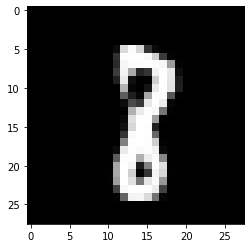

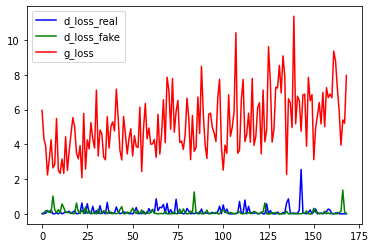

[169/200][0/938] Loss_D: 0.0650 Loss_G: 5.8069 D(x): 0.9853 D(G(z)): 0.0373 / 0.0290
[169/200][100/938] Loss_D: 0.0337 Loss_G: 6.9792 D(x): 0.9751 D(G(z)): 0.0071 / 0.0077
[169/200][200/938] Loss_D: 0.1161 Loss_G: 4.8161 D(x): 0.9512 D(G(z)): 0.0496 / 0.0436
[169/200][300/938] Loss_D: 0.0494 Loss_G: 5.7229 D(x): 0.9884 D(G(z)): 0.0302 / 0.0220
[169/200][400/938] Loss_D: 0.4136 Loss_G: 7.2240 D(x): 0.7432 D(G(z)): 0.0011 / 0.0028
[169/200][500/938] Loss_D: 0.0328 Loss_G: 5.9382 D(x): 0.9763 D(G(z)): 0.0064 / 0.0159
[169/200][600/938] Loss_D: 0.0463 Loss_G: 5.0915 D(x): 0.9826 D(G(z)): 0.0265 / 0.0281
[169/200][700/938] Loss_D: 0.0137 Loss_G: 7.9420 D(x): 0.9894 D(G(z)): 0.0028 / 0.0029
[169/200][800/938] Loss_D: 0.0281 Loss_G: 8.0269 D(x): 0.9788 D(G(z)): 0.0050 / 0.0042
[169/200][900/938] Loss_D: 0.0813 Loss_G: 5.3879 D(x): 0.9851 D(G(z)): 0.0574 / 0.0302


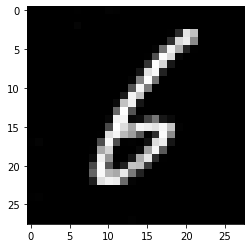

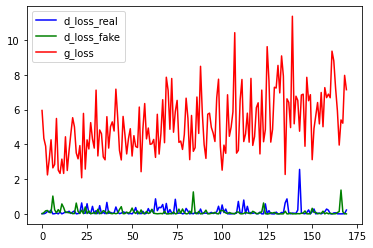

[170/200][0/938] Loss_D: 0.0687 Loss_G: 7.6277 D(x): 0.9467 D(G(z)): 0.0097 / 0.0088
[170/200][100/938] Loss_D: 0.3993 Loss_G: 9.2912 D(x): 0.7653 D(G(z)): 0.0023 / 0.0009
[170/200][200/938] Loss_D: 0.3451 Loss_G: 2.9973 D(x): 0.8661 D(G(z)): 0.1075 / 0.1492
[170/200][300/938] Loss_D: 0.0918 Loss_G: 6.1586 D(x): 0.9552 D(G(z)): 0.0242 / 0.0181
[170/200][400/938] Loss_D: 0.1130 Loss_G: 4.3659 D(x): 0.9743 D(G(z)): 0.0752 / 0.0554
[170/200][500/938] Loss_D: 0.0538 Loss_G: 8.3745 D(x): 0.9598 D(G(z)): 0.0030 / 0.0027
[170/200][600/938] Loss_D: 0.1039 Loss_G: 6.8308 D(x): 0.9660 D(G(z)): 0.0434 / 0.0163
[170/200][700/938] Loss_D: 0.0239 Loss_G: 5.7974 D(x): 0.9926 D(G(z)): 0.0156 / 0.0191
[170/200][800/938] Loss_D: 0.0634 Loss_G: 9.7943 D(x): 0.9491 D(G(z)): 0.0025 / 0.0013
[170/200][900/938] Loss_D: 0.0266 Loss_G: 7.2790 D(x): 0.9900 D(G(z)): 0.0133 / 0.0177


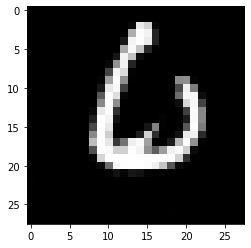

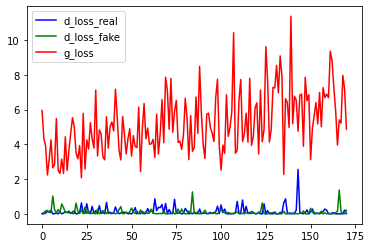

[171/200][0/938] Loss_D: 0.0403 Loss_G: 6.8517 D(x): 0.9971 D(G(z)): 0.0303 / 0.0111
[171/200][100/938] Loss_D: 0.1101 Loss_G: 6.3739 D(x): 0.9393 D(G(z)): 0.0214 / 0.0211
[171/200][200/938] Loss_D: 0.0434 Loss_G: 6.5759 D(x): 0.9903 D(G(z)): 0.0257 / 0.0232
[171/200][300/938] Loss_D: 0.0959 Loss_G: 6.8707 D(x): 0.9558 D(G(z)): 0.0296 / 0.0164
[171/200][400/938] Loss_D: 0.1162 Loss_G: 5.1128 D(x): 0.9874 D(G(z)): 0.0722 / 0.0407
[171/200][500/938] Loss_D: 0.0187 Loss_G: 7.4579 D(x): 0.9855 D(G(z)): 0.0038 / 0.0039
[171/200][600/938] Loss_D: 0.1745 Loss_G: 4.0704 D(x): 0.9921 D(G(z)): 0.1233 / 0.0536
[171/200][700/938] Loss_D: 0.1168 Loss_G: 3.3693 D(x): 0.9885 D(G(z)): 0.0866 / 0.1341
[171/200][800/938] Loss_D: 0.1641 Loss_G: 3.6405 D(x): 0.9982 D(G(z)): 0.0864 / 0.1195
[171/200][900/938] Loss_D: 0.0787 Loss_G: 5.2610 D(x): 0.9882 D(G(z)): 0.0581 / 0.0360


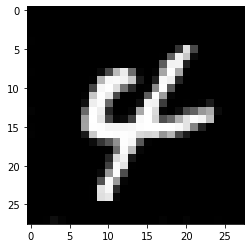

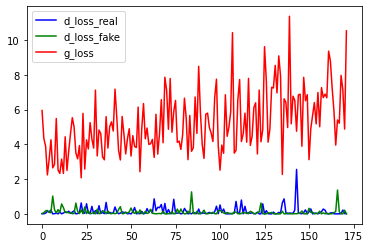

[172/200][0/938] Loss_D: 0.0708 Loss_G: 5.4226 D(x): 0.9655 D(G(z)): 0.0264 / 0.0208
[172/200][100/938] Loss_D: 0.1416 Loss_G: 6.6846 D(x): 0.8951 D(G(z)): 0.0083 / 0.0111
[172/200][200/938] Loss_D: 0.0509 Loss_G: 9.7726 D(x): 0.9576 D(G(z)): 0.0045 / 0.0028
[172/200][300/938] Loss_D: 0.1059 Loss_G: 7.0406 D(x): 0.9450 D(G(z)): 0.0276 / 0.0136
[172/200][400/938] Loss_D: 0.0559 Loss_G: 7.1447 D(x): 0.9884 D(G(z)): 0.0388 / 0.0072
[172/200][500/938] Loss_D: 0.1054 Loss_G: 5.8288 D(x): 0.9282 D(G(z)): 0.0206 / 0.0179
[172/200][600/938] Loss_D: 0.0147 Loss_G: 7.7516 D(x): 0.9940 D(G(z)): 0.0082 / 0.0066
[172/200][700/938] Loss_D: 0.0233 Loss_G: 5.4687 D(x): 0.9965 D(G(z)): 0.0185 / 0.0189
[172/200][800/938] Loss_D: 0.0595 Loss_G: 5.0091 D(x): 0.9956 D(G(z)): 0.0496 / 0.0437
[172/200][900/938] Loss_D: 0.0452 Loss_G: 6.9895 D(x): 0.9725 D(G(z)): 0.0143 / 0.0089


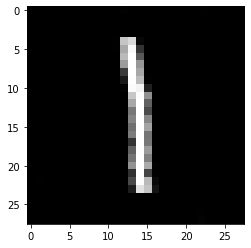

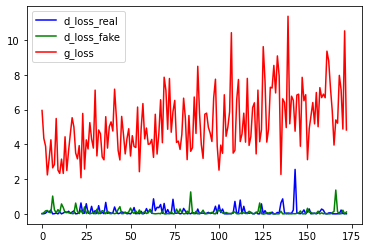

[173/200][0/938] Loss_D: 0.0459 Loss_G: 6.3543 D(x): 0.9735 D(G(z)): 0.0173 / 0.0114
[173/200][100/938] Loss_D: 0.0225 Loss_G: 5.0952 D(x): 0.9973 D(G(z)): 0.0189 / 0.0272
[173/200][200/938] Loss_D: 0.1758 Loss_G: 4.6733 D(x): 0.9894 D(G(z)): 0.1106 / 0.0529
[173/200][300/938] Loss_D: 0.2457 Loss_G: 4.4256 D(x): 0.9919 D(G(z)): 0.1462 / 0.0781
[173/200][400/938] Loss_D: 0.0207 Loss_G: 6.1028 D(x): 0.9888 D(G(z)): 0.0089 / 0.0126
[173/200][500/938] Loss_D: 0.2143 Loss_G: 6.6350 D(x): 0.8627 D(G(z)): 0.0047 / 0.0079
[173/200][600/938] Loss_D: 0.0818 Loss_G: 4.0460 D(x): 0.9990 D(G(z)): 0.0686 / 0.0697
[173/200][700/938] Loss_D: 0.0587 Loss_G: 5.3888 D(x): 0.9916 D(G(z)): 0.0394 / 0.0331
[173/200][800/938] Loss_D: 0.0524 Loss_G: 7.9853 D(x): 0.9592 D(G(z)): 0.0033 / 0.0023
[173/200][900/938] Loss_D: 0.2217 Loss_G: 3.9305 D(x): 0.9905 D(G(z)): 0.1258 / 0.0874


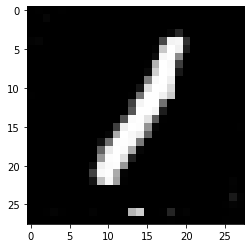

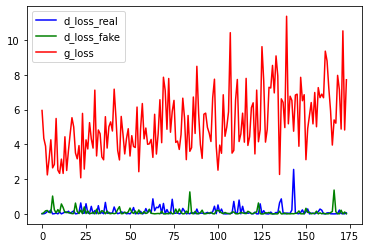

[174/200][0/938] Loss_D: 0.1994 Loss_G: 4.0460 D(x): 0.9135 D(G(z)): 0.0553 / 0.0723
[174/200][100/938] Loss_D: 0.0824 Loss_G: 4.8220 D(x): 0.9850 D(G(z)): 0.0534 / 0.0405
[174/200][200/938] Loss_D: 0.0489 Loss_G: 6.7582 D(x): 0.9969 D(G(z)): 0.0365 / 0.0162
[174/200][300/938] Loss_D: 0.1052 Loss_G: 4.4111 D(x): 0.9853 D(G(z)): 0.0686 / 0.0560
[174/200][400/938] Loss_D: 0.1199 Loss_G: 5.4133 D(x): 0.9447 D(G(z)): 0.0354 / 0.0420
[174/200][500/938] Loss_D: 0.0129 Loss_G: 5.4165 D(x): 0.9998 D(G(z)): 0.0124 / 0.0213
[174/200][600/938] Loss_D: 0.1077 Loss_G: 8.6004 D(x): 0.9130 D(G(z)): 0.0014 / 0.0017
[174/200][700/938] Loss_D: 0.2188 Loss_G: 5.4112 D(x): 0.8564 D(G(z)): 0.0190 / 0.0294
[174/200][800/938] Loss_D: 0.1122 Loss_G: 7.1059 D(x): 0.9232 D(G(z)): 0.0085 / 0.0065
[174/200][900/938] Loss_D: 0.0699 Loss_G: 5.1229 D(x): 0.9621 D(G(z)): 0.0173 / 0.0548


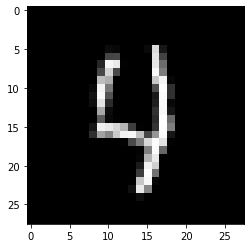

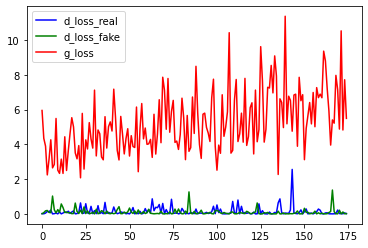

[175/200][0/938] Loss_D: 0.0520 Loss_G: 5.5299 D(x): 0.9971 D(G(z)): 0.0377 / 0.0363
[175/200][100/938] Loss_D: 0.0398 Loss_G: 7.0488 D(x): 0.9745 D(G(z)): 0.0110 / 0.0080
[175/200][200/938] Loss_D: 0.3393 Loss_G: 4.7865 D(x): 0.8037 D(G(z)): 0.0432 / 0.0434
[175/200][300/938] Loss_D: 0.0368 Loss_G: 6.6774 D(x): 0.9776 D(G(z)): 0.0121 / 0.0140
[175/200][400/938] Loss_D: 0.0960 Loss_G: 3.0967 D(x): 0.9966 D(G(z)): 0.0720 / 0.1840
[175/200][500/938] Loss_D: 0.1076 Loss_G: 5.8168 D(x): 0.9423 D(G(z)): 0.0327 / 0.0226
[175/200][600/938] Loss_D: 0.0237 Loss_G: 6.9024 D(x): 0.9859 D(G(z)): 0.0079 / 0.0083
[175/200][700/938] Loss_D: 0.2851 Loss_G: 4.1067 D(x): 0.9880 D(G(z)): 0.1654 / 0.1025
[175/200][800/938] Loss_D: 0.0509 Loss_G: 6.4573 D(x): 0.9882 D(G(z)): 0.0310 / 0.0281
[175/200][900/938] Loss_D: 0.0545 Loss_G: 4.8947 D(x): 0.9909 D(G(z)): 0.0408 / 0.0400


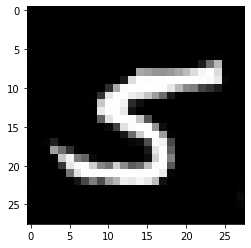

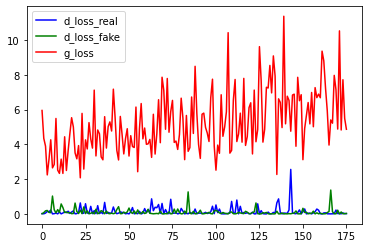

[176/200][0/938] Loss_D: 0.0434 Loss_G: 5.5856 D(x): 0.9764 D(G(z)): 0.0175 / 0.0195
[176/200][100/938] Loss_D: 0.1084 Loss_G: 5.8152 D(x): 0.9297 D(G(z)): 0.0262 / 0.0196
[176/200][200/938] Loss_D: 0.0922 Loss_G: 5.0965 D(x): 0.9864 D(G(z)): 0.0644 / 0.0327
[176/200][300/938] Loss_D: 0.0155 Loss_G: 7.4662 D(x): 0.9921 D(G(z)): 0.0073 / 0.0055
[176/200][400/938] Loss_D: 0.0143 Loss_G: 8.2137 D(x): 0.9917 D(G(z)): 0.0054 / 0.0045
[176/200][500/938] Loss_D: 0.0659 Loss_G: 5.4045 D(x): 0.9928 D(G(z)): 0.0506 / 0.0252
[176/200][600/938] Loss_D: 0.0670 Loss_G: 6.9051 D(x): 0.9554 D(G(z)): 0.0113 / 0.0100
[176/200][700/938] Loss_D: 0.3330 Loss_G: 3.6832 D(x): 0.7999 D(G(z)): 0.0125 / 0.1112
[176/200][800/938] Loss_D: 0.0711 Loss_G: 6.0703 D(x): 0.9631 D(G(z)): 0.0207 / 0.0222
[176/200][900/938] Loss_D: 0.5345 Loss_G: 4.4102 D(x): 0.7506 D(G(z)): 0.0582 / 0.0664


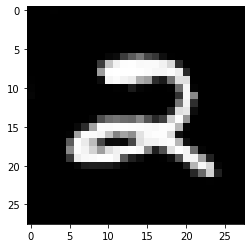

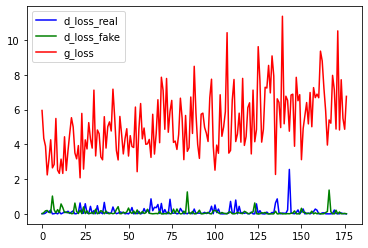

[177/200][0/938] Loss_D: 0.0114 Loss_G: 7.6547 D(x): 0.9949 D(G(z)): 0.0060 / 0.0048
[177/200][100/938] Loss_D: 0.2598 Loss_G: 4.0504 D(x): 0.9933 D(G(z)): 0.1561 / 0.0823
[177/200][200/938] Loss_D: 0.0412 Loss_G: 5.3059 D(x): 0.9945 D(G(z)): 0.0307 / 0.0408
[177/200][300/938] Loss_D: 0.0608 Loss_G: 5.7667 D(x): 0.9818 D(G(z)): 0.0357 / 0.0243
[177/200][400/938] Loss_D: 0.2579 Loss_G: 6.5879 D(x): 0.8289 D(G(z)): 0.0066 / 0.0128
[177/200][500/938] Loss_D: 0.0807 Loss_G: 5.6820 D(x): 0.9894 D(G(z)): 0.0566 / 0.0269
[177/200][600/938] Loss_D: 0.0325 Loss_G: 7.2467 D(x): 0.9742 D(G(z)): 0.0049 / 0.0064
[177/200][700/938] Loss_D: 0.0379 Loss_G: 5.6411 D(x): 0.9794 D(G(z)): 0.0134 / 0.0230
[177/200][800/938] Loss_D: 0.1543 Loss_G: 4.8667 D(x): 0.9702 D(G(z)): 0.0838 / 0.0595
[177/200][900/938] Loss_D: 0.2374 Loss_G: 3.2134 D(x): 0.9880 D(G(z)): 0.1506 / 0.1347


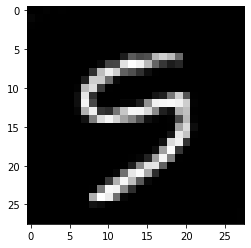

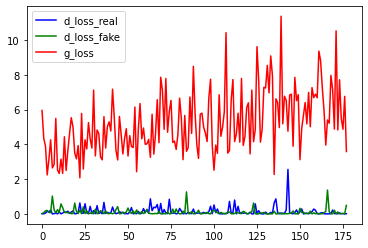

[178/200][0/938] Loss_D: 0.4162 Loss_G: 4.9152 D(x): 0.9905 D(G(z)): 0.2210 / 0.0583
[178/200][100/938] Loss_D: 0.1846 Loss_G: 3.6670 D(x): 0.9962 D(G(z)): 0.1271 / 0.0904
[178/200][200/938] Loss_D: 0.3213 Loss_G: 4.3446 D(x): 0.9996 D(G(z)): 0.1794 / 0.0793
[178/200][300/938] Loss_D: 0.0839 Loss_G: 5.0508 D(x): 0.9729 D(G(z)): 0.0451 / 0.0490
[178/200][400/938] Loss_D: 0.0127 Loss_G: 7.8271 D(x): 0.9929 D(G(z)): 0.0054 / 0.0035
[178/200][500/938] Loss_D: 0.1237 Loss_G: 4.8419 D(x): 0.9856 D(G(z)): 0.0730 / 0.0461
[178/200][600/938] Loss_D: 0.2886 Loss_G: 7.2633 D(x): 0.8090 D(G(z)): 0.0022 / 0.0069
[178/200][700/938] Loss_D: 0.2483 Loss_G: 3.0542 D(x): 0.9480 D(G(z)): 0.1093 / 0.1866
[178/200][800/938] Loss_D: 0.0750 Loss_G: 4.3881 D(x): 0.9835 D(G(z)): 0.0473 / 0.0607
[178/200][900/938] Loss_D: 0.2233 Loss_G: 4.9667 D(x): 0.8745 D(G(z)): 0.0138 / 0.0243


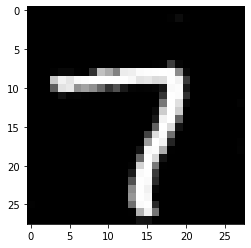

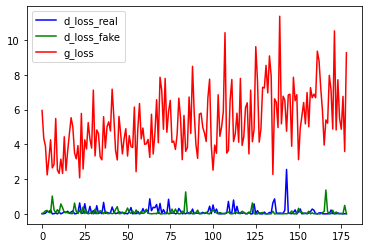

[179/200][0/938] Loss_D: 0.3872 Loss_G: 10.6555 D(x): 0.7838 D(G(z)): 0.0005 / 0.0004
[179/200][100/938] Loss_D: 0.0426 Loss_G: 5.6658 D(x): 0.9951 D(G(z)): 0.0337 / 0.0253
[179/200][200/938] Loss_D: 0.1358 Loss_G: 4.3281 D(x): 0.9953 D(G(z)): 0.0922 / 0.0708
[179/200][300/938] Loss_D: 0.1595 Loss_G: 7.6794 D(x): 0.8789 D(G(z)): 0.0030 / 0.0062
[179/200][400/938] Loss_D: 0.0054 Loss_G: 8.4963 D(x): 0.9958 D(G(z)): 0.0011 / 0.0012
[179/200][500/938] Loss_D: 0.0575 Loss_G: 5.3939 D(x): 0.9913 D(G(z)): 0.0428 / 0.0208
[179/200][600/938] Loss_D: 0.0765 Loss_G: 5.7529 D(x): 0.9835 D(G(z)): 0.0469 / 0.0234
[179/200][700/938] Loss_D: 0.0528 Loss_G: 6.7327 D(x): 0.9927 D(G(z)): 0.0287 / 0.0189
[179/200][800/938] Loss_D: 0.8686 Loss_G: 7.3807 D(x): 0.5713 D(G(z)): 0.0001 / 0.0037
[179/200][900/938] Loss_D: 0.1591 Loss_G: 4.7999 D(x): 0.9059 D(G(z)): 0.0228 / 0.0402


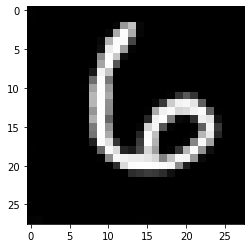

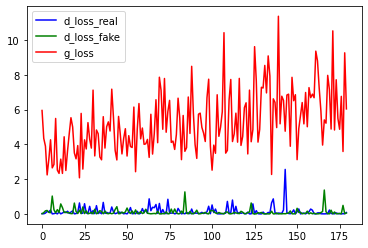

[180/200][0/938] Loss_D: 0.0589 Loss_G: 5.4379 D(x): 0.9913 D(G(z)): 0.0419 / 0.0364
[180/200][100/938] Loss_D: 0.0605 Loss_G: 5.9470 D(x): 0.9983 D(G(z)): 0.0348 / 0.0298
[180/200][200/938] Loss_D: 0.0253 Loss_G: 10.4297 D(x): 0.9763 D(G(z)): 0.0003 / 0.0002
[180/200][300/938] Loss_D: 0.3796 Loss_G: 4.6114 D(x): 0.9658 D(G(z)): 0.2051 / 0.0722
[180/200][400/938] Loss_D: 0.0329 Loss_G: 7.2366 D(x): 0.9827 D(G(z)): 0.0123 / 0.0143
[180/200][500/938] Loss_D: 0.0972 Loss_G: 5.9706 D(x): 0.9955 D(G(z)): 0.0594 / 0.0304
[180/200][600/938] Loss_D: 0.0390 Loss_G: 6.6600 D(x): 0.9808 D(G(z)): 0.0158 / 0.0145
[180/200][700/938] Loss_D: 0.0889 Loss_G: 5.3131 D(x): 0.9966 D(G(z)): 0.0552 / 0.0293
[180/200][800/938] Loss_D: 0.1096 Loss_G: 5.7469 D(x): 0.9790 D(G(z)): 0.0608 / 0.0327
[180/200][900/938] Loss_D: 0.0499 Loss_G: 6.7975 D(x): 0.9593 D(G(z)): 0.0063 / 0.0072


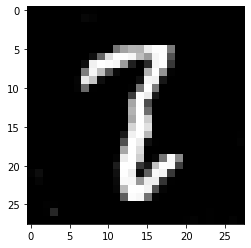

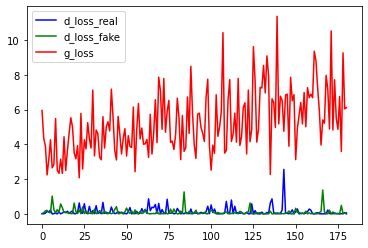

[181/200][0/938] Loss_D: 0.1469 Loss_G: 4.7619 D(x): 0.9977 D(G(z)): 0.1025 / 0.0425
[181/200][100/938] Loss_D: 0.0996 Loss_G: 6.3080 D(x): 0.9683 D(G(z)): 0.0440 / 0.0213
[181/200][200/938] Loss_D: 0.3072 Loss_G: 3.5739 D(x): 0.9775 D(G(z)): 0.1734 / 0.1085
[181/200][300/938] Loss_D: 0.0758 Loss_G: 5.5805 D(x): 0.9881 D(G(z)): 0.0440 / 0.0373
[181/200][400/938] Loss_D: 0.1524 Loss_G: 4.7706 D(x): 0.9762 D(G(z)): 0.0802 / 0.0600
[181/200][500/938] Loss_D: 0.0884 Loss_G: 6.3617 D(x): 0.9334 D(G(z)): 0.0083 / 0.0107
[181/200][600/938] Loss_D: 0.1606 Loss_G: 4.9949 D(x): 0.9015 D(G(z)): 0.0367 / 0.0367
[181/200][700/938] Loss_D: 0.0503 Loss_G: 5.4449 D(x): 0.9913 D(G(z)): 0.0280 / 0.0400
[181/200][800/938] Loss_D: 0.0773 Loss_G: 7.2741 D(x): 0.9437 D(G(z)): 0.0071 / 0.0075
[181/200][900/938] Loss_D: 0.0398 Loss_G: 7.7156 D(x): 0.9664 D(G(z)): 0.0039 / 0.0042


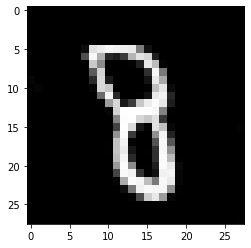

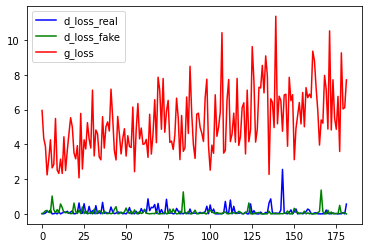

[182/200][0/938] Loss_D: 0.0168 Loss_G: 6.2613 D(x): 0.9919 D(G(z)): 0.0079 / 0.0174
[182/200][100/938] Loss_D: 0.0330 Loss_G: 7.5524 D(x): 0.9746 D(G(z)): 0.0055 / 0.0060
[182/200][200/938] Loss_D: 0.0971 Loss_G: 7.5683 D(x): 0.9231 D(G(z)): 0.0092 / 0.0072
[182/200][300/938] Loss_D: 0.0574 Loss_G: 6.0655 D(x): 0.9957 D(G(z)): 0.0454 / 0.0211
[182/200][400/938] Loss_D: 0.0667 Loss_G: 9.7161 D(x): 0.9439 D(G(z)): 0.0016 / 0.0009
[182/200][500/938] Loss_D: 0.0514 Loss_G: 6.6586 D(x): 0.9980 D(G(z)): 0.0365 / 0.0097
[182/200][600/938] Loss_D: 0.0532 Loss_G: 5.2598 D(x): 0.9791 D(G(z)): 0.0274 / 0.0307
[182/200][700/938] Loss_D: 0.1379 Loss_G: 7.1619 D(x): 0.9055 D(G(z)): 0.0065 / 0.0086
[182/200][800/938] Loss_D: 0.1672 Loss_G: 5.6782 D(x): 0.9959 D(G(z)): 0.0849 / 0.0372
[182/200][900/938] Loss_D: 0.0463 Loss_G: 7.0384 D(x): 0.9966 D(G(z)): 0.0354 / 0.0115


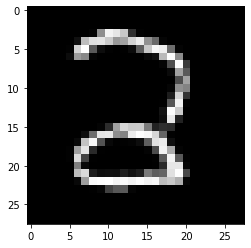

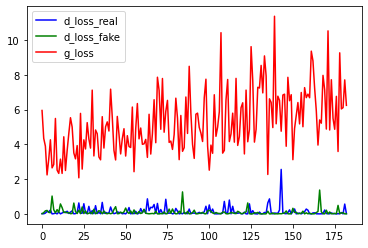

[183/200][0/938] Loss_D: 0.0269 Loss_G: 5.4859 D(x): 0.9980 D(G(z)): 0.0229 / 0.0264
[183/200][100/938] Loss_D: 0.0486 Loss_G: 7.0683 D(x): 0.9683 D(G(z)): 0.0142 / 0.0109
[183/200][200/938] Loss_D: 0.0843 Loss_G: 7.6153 D(x): 0.9435 D(G(z)): 0.0106 / 0.0056
[183/200][300/938] Loss_D: 0.0917 Loss_G: 6.2616 D(x): 0.9529 D(G(z)): 0.0275 / 0.0228
[183/200][400/938] Loss_D: 0.0239 Loss_G: 8.5066 D(x): 0.9804 D(G(z)): 0.0023 / 0.0019
[183/200][500/938] Loss_D: 0.0562 Loss_G: 7.6103 D(x): 0.9625 D(G(z)): 0.0056 / 0.0082
[183/200][600/938] Loss_D: 0.2236 Loss_G: 4.5963 D(x): 0.9981 D(G(z)): 0.1372 / 0.0613
[183/200][700/938] Loss_D: 0.0386 Loss_G: 6.0822 D(x): 0.9847 D(G(z)): 0.0205 / 0.0151
[183/200][800/938] Loss_D: 0.0587 Loss_G: 5.9742 D(x): 0.9746 D(G(z)): 0.0290 / 0.0151
[183/200][900/938] Loss_D: 0.0150 Loss_G: 6.3784 D(x): 0.9964 D(G(z)): 0.0109 / 0.0150


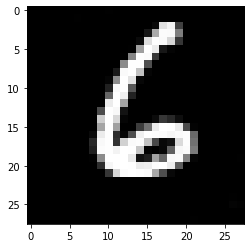

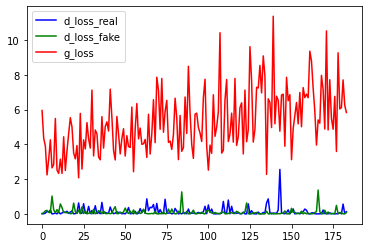

[184/200][0/938] Loss_D: 0.0218 Loss_G: 6.3716 D(x): 0.9977 D(G(z)): 0.0186 / 0.0172
[184/200][100/938] Loss_D: 0.0916 Loss_G: 6.1348 D(x): 0.9498 D(G(z)): 0.0259 / 0.0215
[184/200][200/938] Loss_D: 0.0666 Loss_G: 5.5364 D(x): 0.9541 D(G(z)): 0.0154 / 0.0362
[184/200][300/938] Loss_D: 0.1885 Loss_G: 9.8583 D(x): 0.8634 D(G(z)): 0.0006 / 0.0010
[184/200][400/938] Loss_D: 0.1707 Loss_G: 6.3047 D(x): 0.9873 D(G(z)): 0.0612 / 0.0414
[184/200][500/938] Loss_D: 0.2230 Loss_G: 4.5208 D(x): 0.9925 D(G(z)): 0.1242 / 0.0631
[184/200][600/938] Loss_D: 0.0455 Loss_G: 6.3874 D(x): 0.9775 D(G(z)): 0.0188 / 0.0124
[184/200][700/938] Loss_D: 0.0510 Loss_G: 6.8387 D(x): 0.9637 D(G(z)): 0.0087 / 0.0071
[184/200][800/938] Loss_D: 0.0593 Loss_G: 6.1433 D(x): 0.9719 D(G(z)): 0.0228 / 0.0208
[184/200][900/938] Loss_D: 0.1689 Loss_G: 5.0140 D(x): 0.9237 D(G(z)): 0.0306 / 0.0487


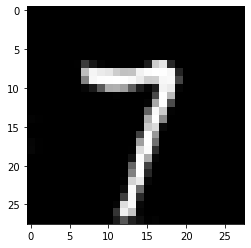

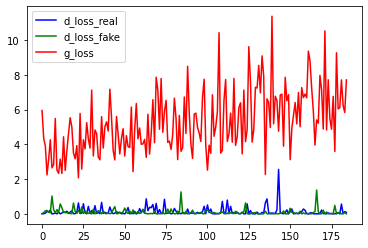

[185/200][0/938] Loss_D: 0.0277 Loss_G: 5.9644 D(x): 0.9867 D(G(z)): 0.0110 / 0.0187
[185/200][100/938] Loss_D: 0.0758 Loss_G: 6.4342 D(x): 0.9903 D(G(z)): 0.0518 / 0.0171
[185/200][200/938] Loss_D: 0.0682 Loss_G: 6.4688 D(x): 0.9903 D(G(z)): 0.0465 / 0.0182
[185/200][300/938] Loss_D: 0.0322 Loss_G: 7.0279 D(x): 0.9827 D(G(z)): 0.0127 / 0.0116
[185/200][400/938] Loss_D: 0.1350 Loss_G: 4.8488 D(x): 0.9970 D(G(z)): 0.0863 / 0.0388
[185/200][500/938] Loss_D: 0.3331 Loss_G: 5.5858 D(x): 0.7813 D(G(z)): 0.0209 / 0.0234
[185/200][600/938] Loss_D: 0.0665 Loss_G: 5.1471 D(x): 0.9988 D(G(z)): 0.0528 / 0.0349
[185/200][700/938] Loss_D: 0.3443 Loss_G: 4.7829 D(x): 0.7927 D(G(z)): 0.0102 / 0.0430
[185/200][800/938] Loss_D: 0.0428 Loss_G: 8.6957 D(x): 0.9709 D(G(z)): 0.0102 / 0.0077
[185/200][900/938] Loss_D: 0.0943 Loss_G: 5.2790 D(x): 0.9558 D(G(z)): 0.0222 / 0.0439


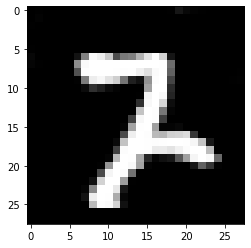

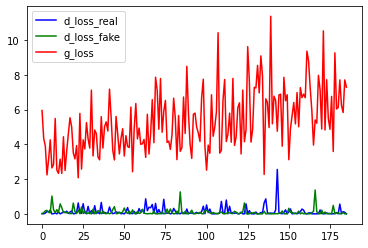

[186/200][0/938] Loss_D: 0.0988 Loss_G: 5.0734 D(x): 0.9753 D(G(z)): 0.0557 / 0.0407
[186/200][100/938] Loss_D: 0.1368 Loss_G: 8.1286 D(x): 0.8962 D(G(z)): 0.0012 / 0.0018
[186/200][200/938] Loss_D: 0.0513 Loss_G: 5.4653 D(x): 0.9978 D(G(z)): 0.0332 / 0.0317
[186/200][300/938] Loss_D: 0.0375 Loss_G: 7.5627 D(x): 0.9793 D(G(z)): 0.0121 / 0.0079
[186/200][400/938] Loss_D: 0.0595 Loss_G: 5.9008 D(x): 0.9935 D(G(z)): 0.0450 / 0.0220
[186/200][500/938] Loss_D: 0.0339 Loss_G: 8.5930 D(x): 0.9717 D(G(z)): 0.0034 / 0.0019
[186/200][600/938] Loss_D: 0.0363 Loss_G: 6.1770 D(x): 0.9832 D(G(z)): 0.0170 / 0.0156
[186/200][700/938] Loss_D: 0.0625 Loss_G: 6.2295 D(x): 0.9670 D(G(z)): 0.0236 / 0.0168
[186/200][800/938] Loss_D: 0.0537 Loss_G: 6.9370 D(x): 0.9619 D(G(z)): 0.0115 / 0.0106
[186/200][900/938] Loss_D: 0.0783 Loss_G: 6.6404 D(x): 0.9587 D(G(z)): 0.0275 / 0.0166


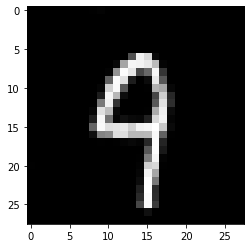

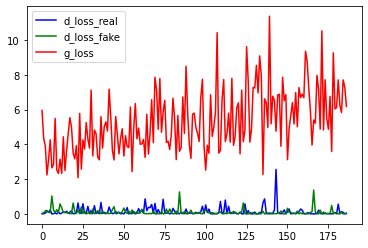

[187/200][0/938] Loss_D: 0.0220 Loss_G: 6.2942 D(x): 0.9932 D(G(z)): 0.0143 / 0.0176
[187/200][100/938] Loss_D: 0.0296 Loss_G: 5.9703 D(x): 0.9887 D(G(z)): 0.0166 / 0.0258
[187/200][200/938] Loss_D: 0.0551 Loss_G: 7.9397 D(x): 0.9987 D(G(z)): 0.0418 / 0.0063
[187/200][300/938] Loss_D: 0.0936 Loss_G: 6.8320 D(x): 0.9272 D(G(z)): 0.0055 / 0.0084
[187/200][400/938] Loss_D: 0.0356 Loss_G: 4.9655 D(x): 0.9885 D(G(z)): 0.0222 / 0.0291
[187/200][500/938] Loss_D: 0.0245 Loss_G: 6.2293 D(x): 0.9896 D(G(z)): 0.0135 / 0.0080
[187/200][600/938] Loss_D: 0.0177 Loss_G: 9.8721 D(x): 0.9844 D(G(z)): 0.0014 / 0.0008
[187/200][700/938] Loss_D: 0.0323 Loss_G: 6.6508 D(x): 0.9815 D(G(z)): 0.0123 / 0.0091
[187/200][800/938] Loss_D: 0.0601 Loss_G: 5.1555 D(x): 0.9960 D(G(z)): 0.0452 / 0.0437
[187/200][900/938] Loss_D: 0.0821 Loss_G: 5.6609 D(x): 0.9597 D(G(z)): 0.0267 / 0.0371


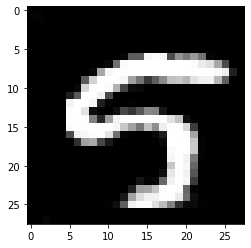

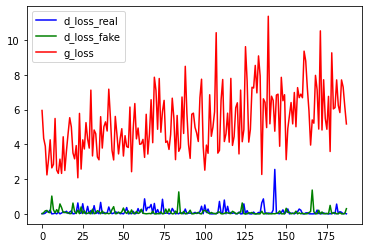

[188/200][0/938] Loss_D: 0.3371 Loss_G: 5.9816 D(x): 0.8606 D(G(z)): 0.0760 / 0.0419
[188/200][100/938] Loss_D: 0.0634 Loss_G: 4.9563 D(x): 0.9997 D(G(z)): 0.0431 / 0.0549
[188/200][200/938] Loss_D: 0.0838 Loss_G: 6.4702 D(x): 0.9474 D(G(z)): 0.0174 / 0.0148
[188/200][300/938] Loss_D: 0.1603 Loss_G: 6.6755 D(x): 0.8839 D(G(z)): 0.0044 / 0.0078
[188/200][400/938] Loss_D: 0.0827 Loss_G: 5.7022 D(x): 0.9897 D(G(z)): 0.0600 / 0.0198
[188/200][500/938] Loss_D: 0.0549 Loss_G: 7.0260 D(x): 0.9544 D(G(z)): 0.0031 / 0.0046
[188/200][600/938] Loss_D: 0.2384 Loss_G: 6.7179 D(x): 0.8361 D(G(z)): 0.0038 / 0.0098
[188/200][700/938] Loss_D: 0.0610 Loss_G: 6.3375 D(x): 0.9955 D(G(z)): 0.0420 / 0.0330
[188/200][800/938] Loss_D: 0.0300 Loss_G: 8.1428 D(x): 0.9760 D(G(z)): 0.0046 / 0.0039
[188/200][900/938] Loss_D: 0.1295 Loss_G: 6.8002 D(x): 0.9026 D(G(z)): 0.0073 / 0.0082


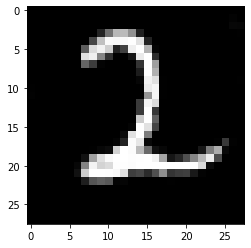

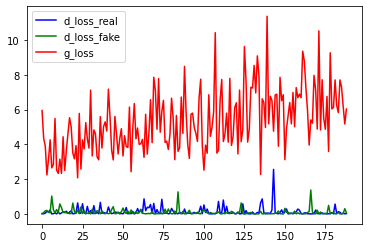

[189/200][0/938] Loss_D: 0.0144 Loss_G: 7.6536 D(x): 0.9963 D(G(z)): 0.0101 / 0.0050
[189/200][100/938] Loss_D: 0.0396 Loss_G: 5.9285 D(x): 0.9758 D(G(z)): 0.0135 / 0.0265
[189/200][200/938] Loss_D: 0.0268 Loss_G: 9.4582 D(x): 0.9766 D(G(z)): 0.0019 / 0.0009
[189/200][300/938] Loss_D: 0.0301 Loss_G: 7.9214 D(x): 0.9899 D(G(z)): 0.0133 / 0.0095
[189/200][400/938] Loss_D: 0.0804 Loss_G: 7.3879 D(x): 0.9490 D(G(z)): 0.0125 / 0.0039
[189/200][500/938] Loss_D: 0.2033 Loss_G: 4.3808 D(x): 0.9609 D(G(z)): 0.1071 / 0.0615
[189/200][600/938] Loss_D: 0.1827 Loss_G: 5.0242 D(x): 0.9454 D(G(z)): 0.0835 / 0.0404
[189/200][700/938] Loss_D: 0.0238 Loss_G: 7.2495 D(x): 0.9845 D(G(z)): 0.0072 / 0.0085
[189/200][800/938] Loss_D: 0.1079 Loss_G: 5.2535 D(x): 0.9782 D(G(z)): 0.0602 / 0.0634
[189/200][900/938] Loss_D: 0.0801 Loss_G: 5.0667 D(x): 0.9841 D(G(z)): 0.0553 / 0.0421


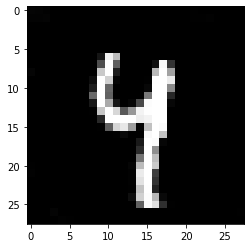

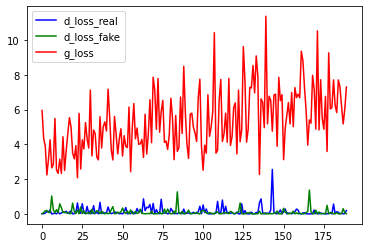

[190/200][0/938] Loss_D: 0.5888 Loss_G: 7.2150 D(x): 0.6579 D(G(z)): 0.0046 / 0.0162
[190/200][100/938] Loss_D: 0.0527 Loss_G: 5.6566 D(x): 0.9679 D(G(z)): 0.0151 / 0.0187
[190/200][200/938] Loss_D: 0.0347 Loss_G: 6.0194 D(x): 0.9793 D(G(z)): 0.0116 / 0.0334
[190/200][300/938] Loss_D: 0.0808 Loss_G: 6.3147 D(x): 0.9651 D(G(z)): 0.0353 / 0.0193
[190/200][400/938] Loss_D: 0.3458 Loss_G: 6.5902 D(x): 0.7944 D(G(z)): 0.0017 / 0.0202
[190/200][500/938] Loss_D: 0.2361 Loss_G: 3.9449 D(x): 0.8872 D(G(z)): 0.0659 / 0.0810
[190/200][600/938] Loss_D: 0.1831 Loss_G: 3.4602 D(x): 0.9966 D(G(z)): 0.1432 / 0.0783
[190/200][700/938] Loss_D: 0.0351 Loss_G: 7.1581 D(x): 0.9777 D(G(z)): 0.0113 / 0.0061
[190/200][800/938] Loss_D: 0.1149 Loss_G: 8.4442 D(x): 0.9124 D(G(z)): 0.0021 / 0.0034
[190/200][900/938] Loss_D: 0.0831 Loss_G: 5.8955 D(x): 0.9452 D(G(z)): 0.0131 / 0.0157


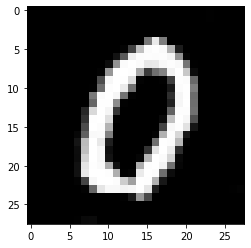

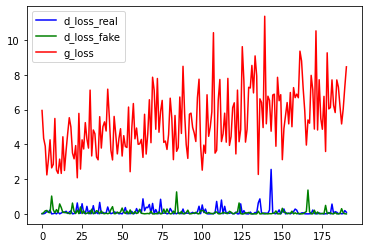

[191/200][0/938] Loss_D: 0.0531 Loss_G: 8.0645 D(x): 0.9607 D(G(z)): 0.0091 / 0.0074
[191/200][100/938] Loss_D: 0.0229 Loss_G: 7.2289 D(x): 0.9981 D(G(z)): 0.0168 / 0.0130
[191/200][200/938] Loss_D: 0.0596 Loss_G: 5.9276 D(x): 0.9767 D(G(z)): 0.0302 / 0.0173
[191/200][300/938] Loss_D: 0.0881 Loss_G: 7.0593 D(x): 0.9374 D(G(z)): 0.0023 / 0.0064
[191/200][400/938] Loss_D: 0.0292 Loss_G: 7.9697 D(x): 0.9800 D(G(z)): 0.0070 / 0.0033
[191/200][500/938] Loss_D: 0.3228 Loss_G: 5.6606 D(x): 0.7885 D(G(z)): 0.0108 / 0.0367
[191/200][600/938] Loss_D: 0.0347 Loss_G: 7.5342 D(x): 0.9784 D(G(z)): 0.0096 / 0.0077
[191/200][700/938] Loss_D: 0.0517 Loss_G: 6.1726 D(x): 0.9801 D(G(z)): 0.0291 / 0.0150
[191/200][800/938] Loss_D: 0.1271 Loss_G: 4.0644 D(x): 0.9722 D(G(z)): 0.0712 / 0.0692
[191/200][900/938] Loss_D: 0.0571 Loss_G: 8.1812 D(x): 0.9509 D(G(z)): 0.0031 / 0.0023


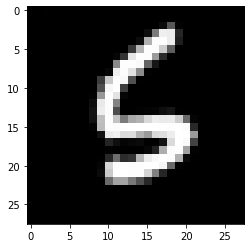

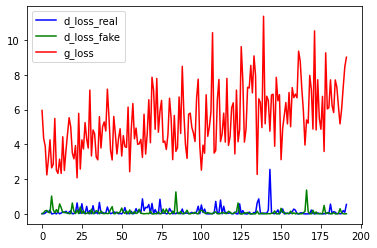

[192/200][0/938] Loss_D: 0.2605 Loss_G: 6.4857 D(x): 0.8759 D(G(z)): 0.0136 / 0.0227
[192/200][100/938] Loss_D: 0.1603 Loss_G: 9.1818 D(x): 0.8796 D(G(z)): 0.0026 / 0.0023
[192/200][200/938] Loss_D: 0.0188 Loss_G: 6.3989 D(x): 0.9989 D(G(z)): 0.0163 / 0.0170
[192/200][300/938] Loss_D: 0.0480 Loss_G: 7.7373 D(x): 0.9703 D(G(z)): 0.0127 / 0.0079
[192/200][400/938] Loss_D: 0.0535 Loss_G: 5.8346 D(x): 0.9810 D(G(z)): 0.0274 / 0.0285
[192/200][500/938] Loss_D: 0.0863 Loss_G: 8.4796 D(x): 0.9331 D(G(z)): 0.0013 / 0.0013
[192/200][600/938] Loss_D: 0.0935 Loss_G: 4.8309 D(x): 0.9955 D(G(z)): 0.0514 / 0.0626
[192/200][700/938] Loss_D: 0.1663 Loss_G: 5.2560 D(x): 0.9853 D(G(z)): 0.1023 / 0.0335
[192/200][800/938] Loss_D: 0.0248 Loss_G: 7.0055 D(x): 0.9894 D(G(z)): 0.0127 / 0.0098
[192/200][900/938] Loss_D: 0.1020 Loss_G: 6.1727 D(x): 0.9953 D(G(z)): 0.0575 / 0.0231


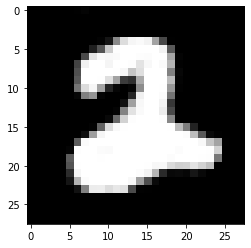

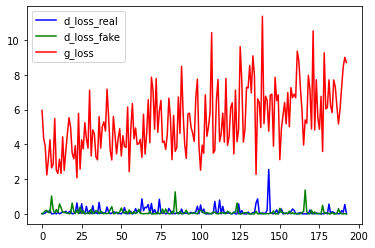

[193/200][0/938] Loss_D: 0.0804 Loss_G: 6.3848 D(x): 0.9520 D(G(z)): 0.0170 / 0.0164
[193/200][100/938] Loss_D: 0.0842 Loss_G: 5.0269 D(x): 0.9895 D(G(z)): 0.0563 / 0.0345
[193/200][200/938] Loss_D: 0.0563 Loss_G: 6.1651 D(x): 0.9831 D(G(z)): 0.0288 / 0.0206
[193/200][300/938] Loss_D: 0.1145 Loss_G: 6.0086 D(x): 0.9461 D(G(z)): 0.0304 / 0.0280
[193/200][400/938] Loss_D: 0.0969 Loss_G: 4.9650 D(x): 0.9606 D(G(z)): 0.0461 / 0.0423
[193/200][500/938] Loss_D: 0.0615 Loss_G: 12.3429 D(x): 0.9437 D(G(z)): 0.0001 / 0.0001
[193/200][600/938] Loss_D: 0.0463 Loss_G: 7.1457 D(x): 0.9671 D(G(z)): 0.0089 / 0.0126
[193/200][700/938] Loss_D: 0.2810 Loss_G: 6.1939 D(x): 0.8596 D(G(z)): 0.0349 / 0.0295
[193/200][800/938] Loss_D: 0.0377 Loss_G: 8.2471 D(x): 0.9684 D(G(z)): 0.0016 / 0.0025
[193/200][900/938] Loss_D: 0.2329 Loss_G: 8.6233 D(x): 0.8657 D(G(z)): 0.0006 / 0.0012


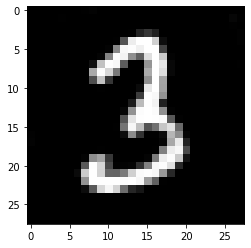

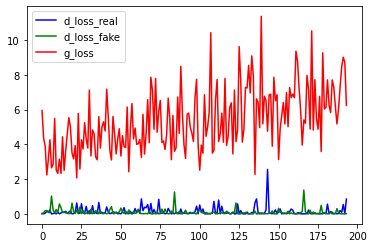

[194/200][0/938] Loss_D: 0.1128 Loss_G: 4.2223 D(x): 0.9394 D(G(z)): 0.0372 / 0.1096
[194/200][100/938] Loss_D: 0.2119 Loss_G: 3.8679 D(x): 0.9927 D(G(z)): 0.1403 / 0.0877
[194/200][200/938] Loss_D: 0.0806 Loss_G: 7.1462 D(x): 0.9679 D(G(z)): 0.0298 / 0.0193
[194/200][300/938] Loss_D: 0.8331 Loss_G: 7.1189 D(x): 0.5889 D(G(z)): 0.0199 / 0.0241
[194/200][400/938] Loss_D: 0.0761 Loss_G: 6.2723 D(x): 0.9422 D(G(z)): 0.0079 / 0.0098
[194/200][500/938] Loss_D: 0.0235 Loss_G: 6.5045 D(x): 0.9838 D(G(z)): 0.0065 / 0.0097
[194/200][600/938] Loss_D: 0.0289 Loss_G: 7.5184 D(x): 0.9858 D(G(z)): 0.0121 / 0.0084
[194/200][700/938] Loss_D: 0.0663 Loss_G: 5.0977 D(x): 0.9936 D(G(z)): 0.0502 / 0.0334
[194/200][800/938] Loss_D: 0.0400 Loss_G: 6.2743 D(x): 0.9713 D(G(z)): 0.0059 / 0.0097
[194/200][900/938] Loss_D: 0.0179 Loss_G: 7.4813 D(x): 0.9971 D(G(z)): 0.0140 / 0.0111


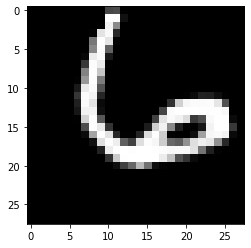

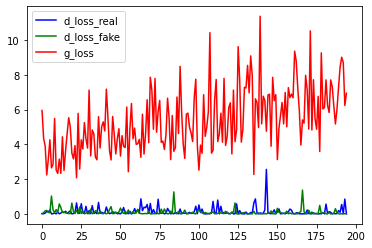

[195/200][0/938] Loss_D: 0.0476 Loss_G: 5.1879 D(x): 0.9965 D(G(z)): 0.0387 / 0.0344
[195/200][100/938] Loss_D: 0.1175 Loss_G: 8.8877 D(x): 0.9184 D(G(z)): 0.0034 / 0.0018
[195/200][200/938] Loss_D: 0.1290 Loss_G: 6.3352 D(x): 0.9056 D(G(z)): 0.0098 / 0.0179
[195/200][300/938] Loss_D: 0.0279 Loss_G: 9.1391 D(x): 0.9752 D(G(z)): 0.0012 / 0.0009
[195/200][400/938] Loss_D: 0.0220 Loss_G: 6.3909 D(x): 0.9980 D(G(z)): 0.0179 / 0.0125
[195/200][500/938] Loss_D: 0.2730 Loss_G: 8.2242 D(x): 0.8436 D(G(z)): 0.0024 / 0.0028
[195/200][600/938] Loss_D: 0.0642 Loss_G: 5.4978 D(x): 0.9934 D(G(z)): 0.0454 / 0.0214
[195/200][700/938] Loss_D: 0.0086 Loss_G: 10.2214 D(x): 0.9923 D(G(z)): 0.0008 / 0.0004
[195/200][800/938] Loss_D: 0.0482 Loss_G: 4.9490 D(x): 0.9935 D(G(z)): 0.0363 / 0.0493
[195/200][900/938] Loss_D: 0.0825 Loss_G: 5.1034 D(x): 0.9538 D(G(z)): 0.0240 / 0.0372


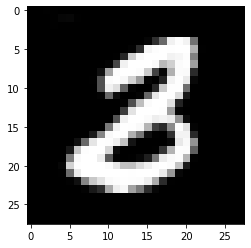

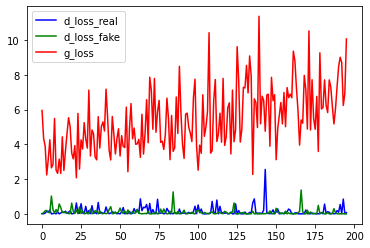

[196/200][0/938] Loss_D: 0.0231 Loss_G: 6.2247 D(x): 0.9961 D(G(z)): 0.0182 / 0.0185
[196/200][100/938] Loss_D: 0.1352 Loss_G: 6.0196 D(x): 0.9324 D(G(z)): 0.0378 / 0.0313
[196/200][200/938] Loss_D: 0.0618 Loss_G: 5.8633 D(x): 0.9978 D(G(z)): 0.0327 / 0.0372
[196/200][300/938] Loss_D: 0.0439 Loss_G: 6.0514 D(x): 0.9901 D(G(z)): 0.0304 / 0.0185
[196/200][400/938] Loss_D: 0.2494 Loss_G: 7.2093 D(x): 0.8352 D(G(z)): 0.0022 / 0.0043
[196/200][500/938] Loss_D: 0.0865 Loss_G: 7.4700 D(x): 0.9456 D(G(z)): 0.0199 / 0.0099
[196/200][600/938] Loss_D: 0.1028 Loss_G: 8.3017 D(x): 0.9268 D(G(z)): 0.0010 / 0.0018
[196/200][700/938] Loss_D: 0.0602 Loss_G: 6.0678 D(x): 0.9978 D(G(z)): 0.0359 / 0.0225
[196/200][800/938] Loss_D: 0.0726 Loss_G: 7.6017 D(x): 0.9622 D(G(z)): 0.0191 / 0.0076
[196/200][900/938] Loss_D: 0.3695 Loss_G: 5.8445 D(x): 0.8145 D(G(z)): 0.0595 / 0.0219


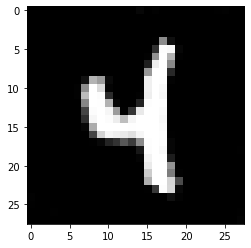

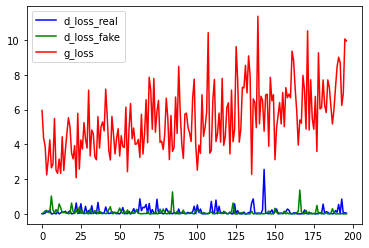

[197/200][0/938] Loss_D: 0.4084 Loss_G: 11.5537 D(x): 0.7566 D(G(z)): 0.0001 / 0.0002
[197/200][100/938] Loss_D: 0.0366 Loss_G: 6.2985 D(x): 0.9913 D(G(z)): 0.0229 / 0.0136
[197/200][200/938] Loss_D: 0.0347 Loss_G: 7.2345 D(x): 0.9703 D(G(z)): 0.0030 / 0.0041
[197/200][300/938] Loss_D: 0.0597 Loss_G: 5.1928 D(x): 0.9983 D(G(z)): 0.0415 / 0.0383
[197/200][400/938] Loss_D: 0.1114 Loss_G: 6.0490 D(x): 0.9687 D(G(z)): 0.0628 / 0.0109
[197/200][500/938] Loss_D: 0.2788 Loss_G: 8.9751 D(x): 0.8105 D(G(z)): 0.0006 / 0.0020
[197/200][600/938] Loss_D: 0.0338 Loss_G: 6.7871 D(x): 0.9894 D(G(z)): 0.0199 / 0.0129
[197/200][700/938] Loss_D: 0.4805 Loss_G: 6.5401 D(x): 0.6966 D(G(z)): 0.0017 / 0.0181
[197/200][800/938] Loss_D: 0.0886 Loss_G: 7.7402 D(x): 0.9340 D(G(z)): 0.0051 / 0.0045
[197/200][900/938] Loss_D: 0.0341 Loss_G: 6.3031 D(x): 0.9939 D(G(z)): 0.0180 / 0.0218


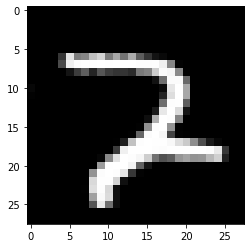

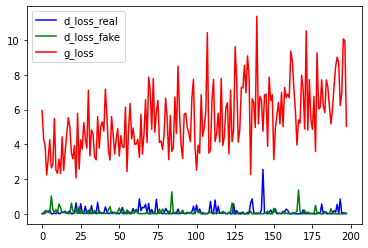

[198/200][0/938] Loss_D: 0.1189 Loss_G: 6.1388 D(x): 0.9187 D(G(z)): 0.0142 / 0.0214
[198/200][100/938] Loss_D: 0.0300 Loss_G: 7.3074 D(x): 0.9949 D(G(z)): 0.0215 / 0.0096
[198/200][200/938] Loss_D: 0.0553 Loss_G: 7.1035 D(x): 0.9695 D(G(z)): 0.0153 / 0.0090
[198/200][300/938] Loss_D: 0.1156 Loss_G: 4.3039 D(x): 0.9997 D(G(z)): 0.0897 / 0.0667
[198/200][400/938] Loss_D: 0.0790 Loss_G: 3.9508 D(x): 0.9992 D(G(z)): 0.0662 / 0.0814
[198/200][500/938] Loss_D: 0.0185 Loss_G: 6.6302 D(x): 0.9988 D(G(z)): 0.0168 / 0.0088
[198/200][600/938] Loss_D: 0.2315 Loss_G: 7.8640 D(x): 0.8334 D(G(z)): 0.0012 / 0.0038
[198/200][700/938] Loss_D: 0.0654 Loss_G: 8.0616 D(x): 0.9413 D(G(z)): 0.0009 / 0.0016
[198/200][800/938] Loss_D: 0.2847 Loss_G: 4.1567 D(x): 0.9965 D(G(z)): 0.1709 / 0.0515
[198/200][900/938] Loss_D: 0.1745 Loss_G: 11.3318 D(x): 0.8673 D(G(z)): 0.0009 / 0.0001


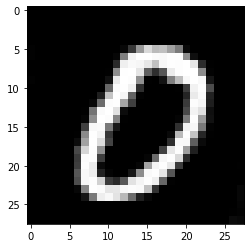

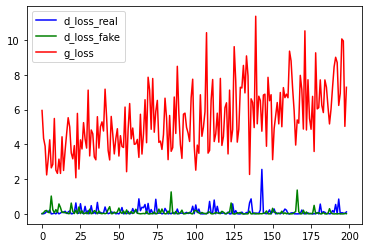

[199/200][0/938] Loss_D: 0.0836 Loss_G: 6.2652 D(x): 0.9802 D(G(z)): 0.0439 / 0.0335
[199/200][100/938] Loss_D: 0.3723 Loss_G: 6.8851 D(x): 0.7637 D(G(z)): 0.0033 / 0.0090
[199/200][200/938] Loss_D: 0.1194 Loss_G: 5.5437 D(x): 0.9699 D(G(z)): 0.0700 / 0.0246
[199/200][300/938] Loss_D: 0.0933 Loss_G: 4.9269 D(x): 0.9962 D(G(z)): 0.0666 / 0.0503
[199/200][400/938] Loss_D: 0.2858 Loss_G: 4.6250 D(x): 0.9992 D(G(z)): 0.1771 / 0.0687
[199/200][500/938] Loss_D: 0.2102 Loss_G: 4.5232 D(x): 0.9776 D(G(z)): 0.1168 / 0.0533
[199/200][600/938] Loss_D: 0.0410 Loss_G: 7.6786 D(x): 0.9646 D(G(z)): 0.0019 / 0.0039
[199/200][700/938] Loss_D: 0.1658 Loss_G: 4.0698 D(x): 0.9985 D(G(z)): 0.1212 / 0.0684
[199/200][800/938] Loss_D: 0.0637 Loss_G: 5.2158 D(x): 0.9989 D(G(z)): 0.0498 / 0.0427
[199/200][900/938] Loss_D: 0.0385 Loss_G: 6.7202 D(x): 0.9751 D(G(z)): 0.0107 / 0.0093


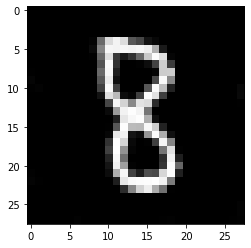

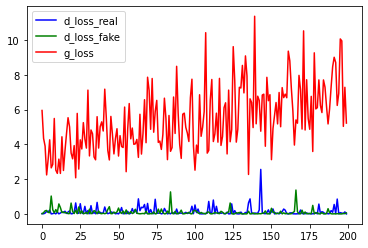

FileNotFoundError: ignored

In [11]:
g_loss_list = []
epoch_list = []
d_loss_real_list = []
d_loss_fake_list = []
for epoch in range(niter):
    epoch_list.append(epoch)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_img = data[0].to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_img)
        errD_real = criterion(output, label)

        if i == len(dataloader) - 1:
          d_loss_real_list.append(errD_real)

        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        noise = noise.view(batch_size, nz, 1, -1)
        fake = netG(noise)

        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()

        if i == len(dataloader) - 1:
          d_loss_fake_list.append(errD_fake)

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()

        if i == len(dataloader) - 1:
          g_loss_list.append(errG)
        
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    # Draw Sampled Images
    fake_images_clone = fake.clone()
    im = denorm(fake_images_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()

    plt.plot(epoch_list, d_loss_real_list, 'b-', label = 'd_loss_real')
    plt.plot(epoch_list, d_loss_fake_list, 'g-', label = 'd_loss_fake') 
    plt.plot(epoch_list, g_loss_list, 'r-', label = 'g_loss')
    plt.legend()
    plt.show()
        

# Save Models
torch.save(netG.state_dict(), G_save_loc)
torch.save(netD.state_dict(), D_save_loc)

# Setup and Train Auxiliary Classifier

## Data Augmentation

In [0]:
# Device setting
netD = netD.to(device)
netG = netG.to(device)

# Create an equal number of fake images
aug_size = len(dataset)
z = torch.randn(aug_size, nz, 1, 1).to(device)
fake_dataset_images = netG(z)
fake_dataset_labels = torch.zeros(aug_size, 1)
fake_dataset = (fake_dataset_images.clone().cpu().detach(), fake_dataset_labels.clone().cpu().detach())

# Ugly code to pry out data from an existing dataset
original_data = np.zeros((len(dataset), 1, image_size, image_size))
for i in range(len(dataset)):
  original_data[i,:] = dataset[i][0]


RuntimeError: ignored

In [0]:
# Create augmented dataset
class AugDataset(torch.utils.data.Dataset):
    def __init__(self, original_data, generated_data):
        # Load Data 
        self.x_train = np.vstack((original_data, generated_data[0].numpy()))
      
        self.y_train = np.vstack((np.ones(((original_data.shape[0], 1))), np.zeros(((generated_data[0].numpy().shape[0], 1)))))

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = AugDataset(original_data, fake_dataset)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

## Create Classifier

In [0]:
# Fully connected neural network with the same architecture as the Discriminator
class Classifier1(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input is (nc) x 28 x 28
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        self.relu1 = nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 14 x 14
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        self.bn1 = nn.BatchNorm2d(ndf * 2),
        self.relu2 =  nn.LeakyReLU(0.2, inplace=True),
        
        # state size. (ndf*2) x 7 x 7
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
        self.bn2 = nn.BatchNorm2d(ndf * 4),
        self.relu3 = nn.LeakyReLU(0.2, inplace=True),
            
        # state size. (ndf*4) x 4 x 4
        self.conv4 = nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        
        self.sig = nn.Sigmoid()

        self.criterion = nn.BCELoss()

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn1(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn2(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.sig(output)

        return output.view(-1, 1).squeeze(1)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.main2 = nn.Sequential(
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      
            nn.Sigmoid()
        )

        self.criterion = nn.BCELoss()

    def forward(self, input):
        output = self.main(input)
        output = self.main2(output)

        return output.view(-1, 1).squeeze(1)

clf = Classifier().to(device)
#clf.apply(weights_init)

## Train Classifier

In [0]:
# Train the model
num_epochs_clf = 100
total_step = len(train_loader)
optimizer = optim.Adam(clf.parameters(), lr=lr, betas=(0.9, 0.999))
for epoch in range(num_epochs_clf):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size).to(device)
        
        # Forward pass
        outputs = clf(images.float())
        loss = clf.criterion(outputs, labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_clf, i+1, total_step, loss.item()))

RuntimeError: ignored

## Test Classifier

In [0]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        #images = images.reshape(-1, 28*28).to(device)
        labels = labels.reshape(batch_size).to(device)

        outputs = clf(images.float())
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        predicted_labels = torch.where(outputs > 0.5, real_labels, fake_labels)

        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the network on the 24000 test images: 96.69583333333334 %


# Get Intermediate Output

In [0]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = clf

activations = np.zeros((len(train_loader)*batch_size, 256, 4, 4))
original_images = np.zeros((len(train_loader)*batch_size, 1, 28, 28))
print(len(train_loader))
for i, (images, labels) in enumerate(train_loader):  
    images = images.to(device)

    model.main.register_forward_hook(get_activation('main'))
    int_output = model(images.float())
    act = activation['main']

    original_images[i*64:(i+1)*64, :, :, :] = images.cpu().numpy()
    activations[i*64:(i+1)*64, :, :, :] = act.cpu().numpy()

1500


In [0]:
# Create augmented dataset
class ReconstDataset(torch.utils.data.Dataset):
    def __init__(self, original_images, activations):
        # Load Data 
        self.x_train = activations
      
        self.y_train = original_images

    def __getitem__(self, index):
        return (self.x_train[index], self.y_train[index])

    def __len__(self):
        return self.x_train.shape[0]

# Init dataset
ds = ReconstDataset(original_images, activations)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                           batch_size=batch_size, 
                                           shuffle=True)

# Image Reconstruction

In [0]:
class ReconstNet(nn.Module):
    def __init__(self):
        super(ReconstNet, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output

reconstNet = ReconstNet().to(device)

Epoch [1/100], Step [500/1200], Loss: 1.3671
Epoch [1/100], Step [1000/1200], Loss: 1.3628


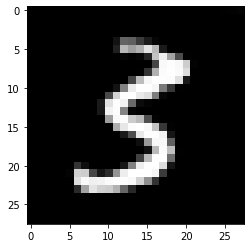

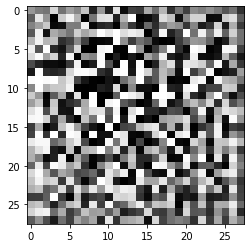

Epoch [2/100], Step [500/1200], Loss: 1.3741
Epoch [2/100], Step [1000/1200], Loss: 1.3706


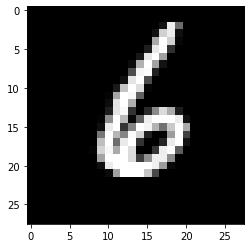

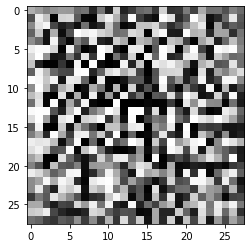

Epoch [3/100], Step [500/1200], Loss: 1.3669
Epoch [3/100], Step [1000/1200], Loss: 1.3661


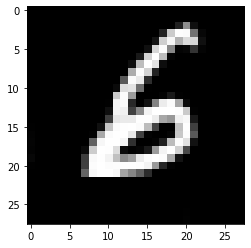

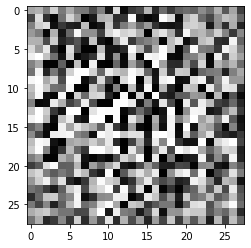

Epoch [4/100], Step [500/1200], Loss: 1.3694
Epoch [4/100], Step [1000/1200], Loss: 1.3697


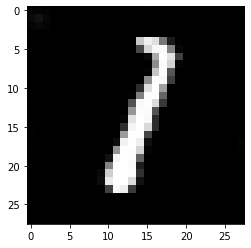

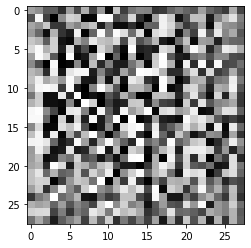

Epoch [5/100], Step [500/1200], Loss: 1.3601
Epoch [5/100], Step [1000/1200], Loss: 1.3692


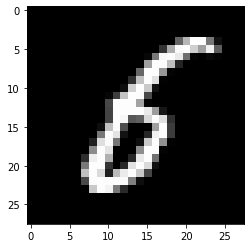

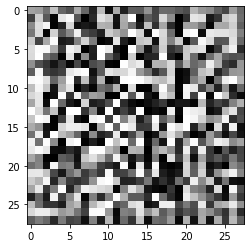

Epoch [6/100], Step [500/1200], Loss: 1.3661
Epoch [6/100], Step [1000/1200], Loss: 1.3620


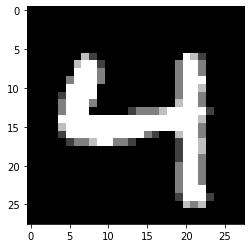

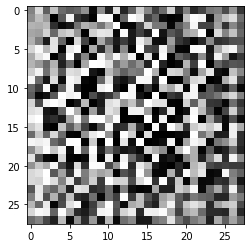

Epoch [7/100], Step [500/1200], Loss: 1.3682
Epoch [7/100], Step [1000/1200], Loss: 1.3648


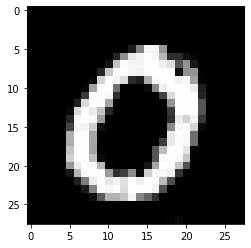

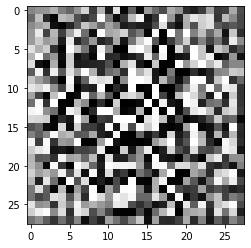

Epoch [8/100], Step [500/1200], Loss: 1.3674
Epoch [8/100], Step [1000/1200], Loss: 1.3662


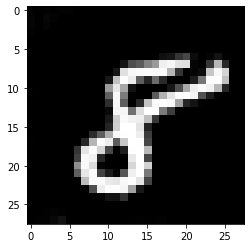

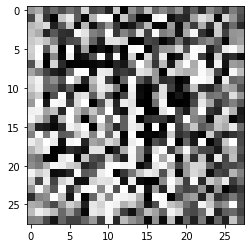

Epoch [9/100], Step [500/1200], Loss: 1.3745
Epoch [9/100], Step [1000/1200], Loss: 1.3630


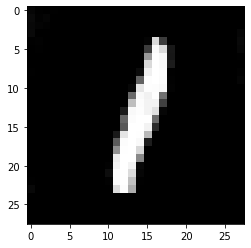

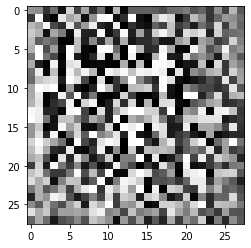

Epoch [10/100], Step [500/1200], Loss: 1.3691
Epoch [10/100], Step [1000/1200], Loss: 1.3635


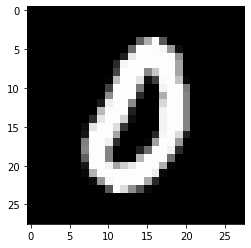

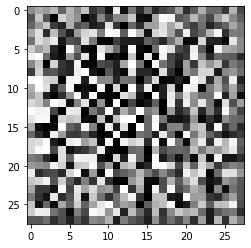

Epoch [11/100], Step [500/1200], Loss: 1.3523
Epoch [11/100], Step [1000/1200], Loss: 1.3679


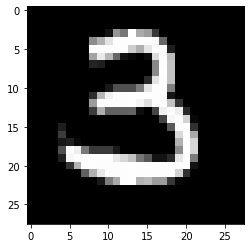

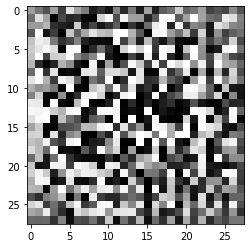

Epoch [12/100], Step [500/1200], Loss: 1.3663
Epoch [12/100], Step [1000/1200], Loss: 1.3697


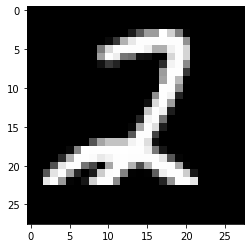

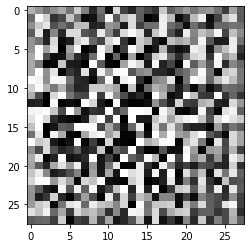

Epoch [13/100], Step [500/1200], Loss: 1.3710
Epoch [13/100], Step [1000/1200], Loss: 1.3624


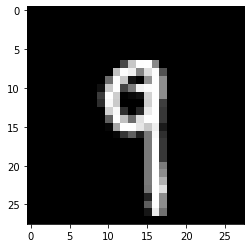

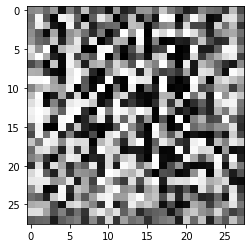

Epoch [14/100], Step [500/1200], Loss: 1.3573
Epoch [14/100], Step [1000/1200], Loss: 1.3722


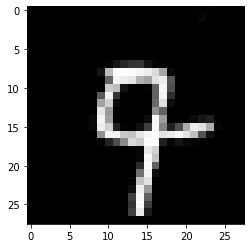

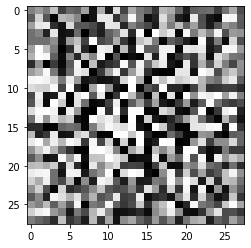

Epoch [15/100], Step [500/1200], Loss: 1.3677
Epoch [15/100], Step [1000/1200], Loss: 1.3633


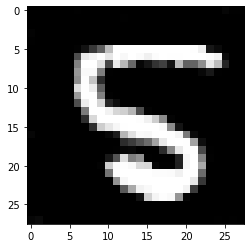

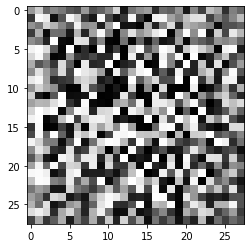

Epoch [16/100], Step [500/1200], Loss: 1.3685
Epoch [16/100], Step [1000/1200], Loss: 1.3664


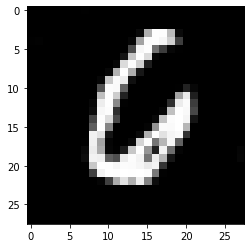

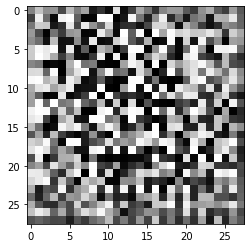

Epoch [17/100], Step [500/1200], Loss: 1.3687
Epoch [17/100], Step [1000/1200], Loss: 1.3681


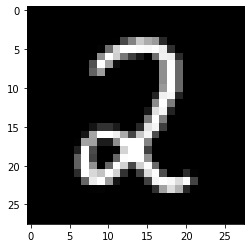

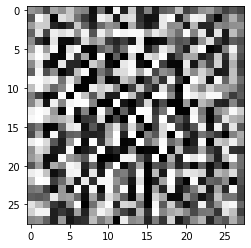

Epoch [18/100], Step [500/1200], Loss: 1.3739
Epoch [18/100], Step [1000/1200], Loss: 1.3733


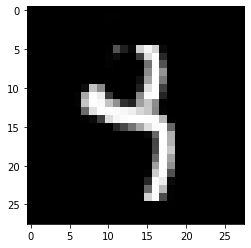

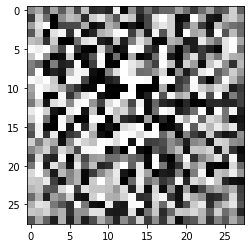

Epoch [19/100], Step [500/1200], Loss: 1.3610
Epoch [19/100], Step [1000/1200], Loss: 1.3671


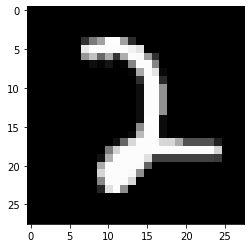

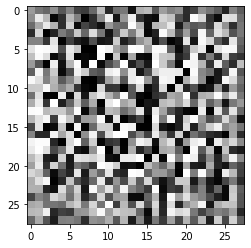

Epoch [20/100], Step [500/1200], Loss: 1.3697
Epoch [20/100], Step [1000/1200], Loss: 1.3626


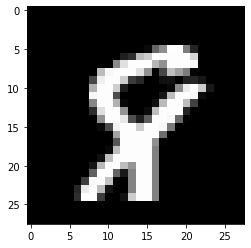

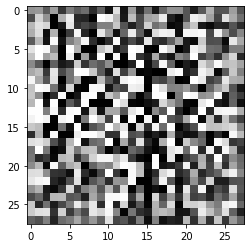

Epoch [21/100], Step [500/1200], Loss: 1.3667
Epoch [21/100], Step [1000/1200], Loss: 1.3710


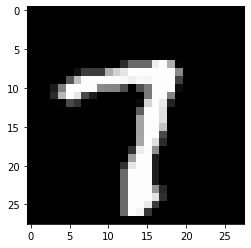

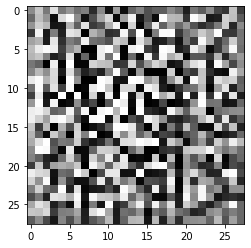

Epoch [22/100], Step [500/1200], Loss: 1.3658
Epoch [22/100], Step [1000/1200], Loss: 1.3680


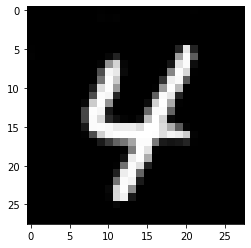

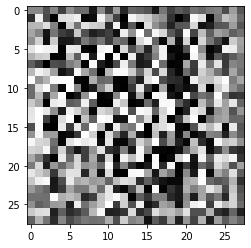

Epoch [23/100], Step [500/1200], Loss: 1.3621
Epoch [23/100], Step [1000/1200], Loss: 1.3659


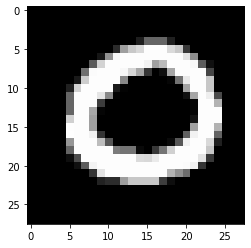

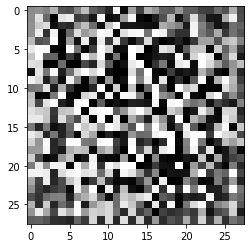

Epoch [24/100], Step [500/1200], Loss: 1.3656
Epoch [24/100], Step [1000/1200], Loss: 1.3635


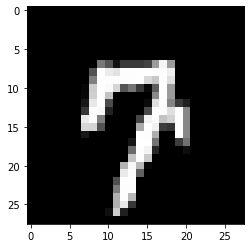

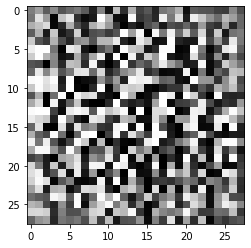

KeyboardInterrupt: ignored

In [0]:
# Train the model
num_epochs_reconst = 100
total_step = len(train_loader)
optimizer = optim.Adam(clf.parameters(), lr=lr, betas=(0.9, 0.999))
criterion_reconst = nn.MSELoss()
for epoch in range(num_epochs_reconst):
    for i, (act, images) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        #images = images.reshape(-1, 28*28).to(device)
        act = act.to(device)
        
        # Forward pass
        outputs = reconstNet(act.float())
        loss = criterion_reconst(outputs, images.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs_reconst, i+1, total_step, loss.item()))
            
    # Draw Sampled Images
    image_clone = images[0].clone()
    output_clone = outputs[0].clone()

    # Draw Original Image
    im = denorm(image_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show() 

    # Draw Reconst Image
    im = denorm(output_clone[0]).cpu().detach().numpy()
    im = (im * 255).astype(np.uint8)
    im = im.reshape((28, 28))
    imgplot = plt.imshow(im, cmap='gray')
    plt.show()  